In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = True

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

env = RetinaEnv(config, image_generator=dataset)

if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound

# You might want to adjust the hyperparameters
actor_lr = 0.0001
critic_lr = 0.001
gamma = 0.99
tau = 0.005

buffer_capacity = 10000



# Create actor and critic networks
actor_model = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
critic_model = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Create target actor and critic networks
target_actor = create_actor_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)
target_critic = create_critic_model(env.image_h, env.image_w, env.spectral_density_size, env.location_history_size, env.timestep_size, env.action_size)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Experience replay buffer
buffer = Buffer(buffer_capacity, config.batch_size, num_states=num_states, num_actions=num_actions,
                state_reshape_fn=env.unflatten_observation, use_dones=config.use_dones)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [2]:
# Training loop
reward_records = []
epsilon_records = []
action_var_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset()
    episodic_reward = 0
    epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        deterministic_action = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))

        if env.warmup_done:
            action = epsilon*random_action + (1-epsilon)*deterministic_action
        else:
            action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            if config.use_dones:
                buffer.record((prev_state, action, reward, state, done))
            else:   
                buffer.record((prev_state, action, reward, state))
                
            episodic_reward += reward

            buffer.learn(actor_model, target_actor, critic_model, target_critic, actor_optimizer, critic_optimizer, gamma, tau)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)
            
            action_var_records.append(deterministic_action.numpy().var(axis=0))
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action variances at step -5:", action_var_records[-5])
    reward_records.append(episodic_reward.numpy().mean())
    epsilon_records.append(epsilon)

Episode * 0 * exploration epsilon 1.0 * Episodic Reward is ==> -10.384956359863281
action variances at step -5: [0.09773348 0.0215303 ]
Episode * 1 * exploration epsilon 0.9991 * Episodic Reward is ==> -10.775936126708984
action variances at step -5: [0.00236934 0.00326842]
Episode * 2 * exploration epsilon 0.9982 * Episodic Reward is ==> -12.008220672607422
action variances at step -5: [0.00198459 0.00096087]
Episode * 3 * exploration epsilon 0.9973 * Episodic Reward is ==> -10.007404327392578
action variances at step -5: [0.00095115 0.00017355]
Episode * 4 * exploration epsilon 0.9964 * Episodic Reward is ==> -11.176019668579102
action variances at step -5: [0.00025322 0.00018963]
Episode * 5 * exploration epsilon 0.9955 * Episodic Reward is ==> -11.653297424316406
action variances at step -5: [0.0001297  0.00012731]
Episode * 6 * exploration epsilon 0.9946 * Episodic Reward is ==> -11.99394416809082
action variances at step -5: [1.1134117e-04 4.1000247e-05]
Episode * 7 * exploration

Episode * 20 * exploration epsilon 0.982 * Episodic Reward is ==> -10.57268238067627
action variances at step -5: [4.8502705e-05 2.9483923e-05]
Episode * 21 * exploration epsilon 0.9811 * Episodic Reward is ==> -11.432842254638672
action variances at step -5: [7.6692977e-06 6.7937876e-06]
Episode * 22 * exploration epsilon 0.9802 * Episodic Reward is ==> -12.434240341186523
action variances at step -5: [1.3618825e-06 4.5939119e-06]
Episode * 23 * exploration epsilon 0.9793 * Episodic Reward is ==> -10.460655212402344
action variances at step -5: [1.7024242e-06 2.6098828e-06]
Episode * 24 * exploration epsilon 0.9784 * Episodic Reward is ==> -10.713726997375488
action variances at step -5: [4.1499179e-06 2.0185778e-06]
Episode * 25 * exploration epsilon 0.9775 * Episodic Reward is ==> -11.075772285461426
action variances at step -5: [1.5902200e-05 2.8706909e-05]
Episode * 26 * exploration epsilon 0.9766 * Episodic Reward is ==> -10.467073440551758
action variances at step -5: [4.0663734

Episode * 41 * exploration epsilon 0.9631 * Episodic Reward is ==> -11.309168815612793
action variances at step -5: [7.4878619e-05 5.5267596e-05]
Episode * 42 * exploration epsilon 0.9621999999999999 * Episodic Reward is ==> -9.959972381591797
action variances at step -5: [1.1763446e-05 1.0109231e-05]
Episode * 43 * exploration epsilon 0.9613 * Episodic Reward is ==> -11.780693054199219
action variances at step -5: [1.2569253e-05 9.3503468e-06]
Episode * 44 * exploration epsilon 0.9604 * Episodic Reward is ==> -10.014963150024414
action variances at step -5: [1.02391805e-05 1.70388084e-05]
Episode * 45 * exploration epsilon 0.9595 * Episodic Reward is ==> -10.630523681640625
action variances at step -5: [5.104578e-06 1.176630e-05]
Episode * 46 * exploration epsilon 0.9586 * Episodic Reward is ==> -11.661796569824219
action variances at step -5: [2.5956213e-05 4.9568007e-06]
Episode * 47 * exploration epsilon 0.9577 * Episodic Reward is ==> -10.437173843383789
action variances at step -

Episode * 61 * exploration epsilon 0.9451 * Episodic Reward is ==> -11.039981842041016
action variances at step -5: [8.1366074e-05 1.4031694e-04]
Episode * 62 * exploration epsilon 0.9442 * Episodic Reward is ==> -8.261165618896484
action variances at step -5: [1.6052069e-05 2.0052074e-05]
Episode * 63 * exploration epsilon 0.9433 * Episodic Reward is ==> -10.687904357910156
action variances at step -5: [1.3904399e-05 1.6190499e-05]
Episode * 64 * exploration epsilon 0.9424 * Episodic Reward is ==> -10.573441505432129
action variances at step -5: [1.8665896e-05 1.3872789e-05]
Episode * 65 * exploration epsilon 0.9415 * Episodic Reward is ==> -10.661144256591797
action variances at step -5: [0.00020971 0.00024419]
Episode * 66 * exploration epsilon 0.9406 * Episodic Reward is ==> -11.347929954528809
action variances at step -5: [5.3628151e-05 5.5758766e-05]
Episode * 67 * exploration epsilon 0.9397 * Episodic Reward is ==> -10.143163681030273
action variances at step -5: [1.3168842e-05 

Episode * 82 * exploration epsilon 0.9262 * Episodic Reward is ==> -11.04697036743164
action variances at step -5: [0.00014417 0.00013711]
Episode * 83 * exploration epsilon 0.9253 * Episodic Reward is ==> -9.883874893188477
action variances at step -5: [8.89700750e-05 1.21822224e-04]
Episode * 84 * exploration epsilon 0.9244 * Episodic Reward is ==> -10.323057174682617
action variances at step -5: [7.9173624e-05 7.2513409e-05]
Episode * 85 * exploration epsilon 0.9235 * Episodic Reward is ==> -10.005279541015625
action variances at step -5: [8.77525817e-05 1.14972536e-04]
Episode * 86 * exploration epsilon 0.9226 * Episodic Reward is ==> -11.559402465820312
action variances at step -5: [7.5264914e-05 9.7734795e-05]
Episode * 87 * exploration epsilon 0.9217 * Episodic Reward is ==> -10.007183074951172
action variances at step -5: [3.6910709e-04 2.2540446e-05]
Episode * 88 * exploration epsilon 0.9208 * Episodic Reward is ==> -9.611570358276367
action variances at step -5: [1.0727607e-0

Episode * 102 * exploration epsilon 0.9082 * Episodic Reward is ==> -10.417793273925781
action variances at step -5: [2.7549993e-05 4.6764839e-05]
Episode * 103 * exploration epsilon 0.9073 * Episodic Reward is ==> -10.424514770507812
action variances at step -5: [5.0709827e-05 1.2020404e-04]
Episode * 104 * exploration epsilon 0.9064 * Episodic Reward is ==> -8.760637283325195
action variances at step -5: [9.4831857e-06 3.6653917e-05]
Episode * 105 * exploration epsilon 0.9055 * Episodic Reward is ==> -10.365743637084961
action variances at step -5: [1.5029230e-05 1.9247855e-05]
Episode * 106 * exploration epsilon 0.9046 * Episodic Reward is ==> -10.136266708374023
action variances at step -5: [1.9048317e-05 2.1481157e-05]
Episode * 107 * exploration epsilon 0.9037 * Episodic Reward is ==> -11.889182090759277
action variances at step -5: [1.18245836e-04 9.59927056e-05]
Episode * 108 * exploration epsilon 0.9028 * Episodic Reward is ==> -10.015777587890625
action variances at step -5: 

Episode * 123 * exploration epsilon 0.8893 * Episodic Reward is ==> -10.588647842407227
action variances at step -5: [8.3279927e-05 1.7041825e-04]
Episode * 124 * exploration epsilon 0.8884 * Episodic Reward is ==> -10.774473190307617
action variances at step -5: [4.9606577e-05 4.8943195e-05]
Episode * 125 * exploration epsilon 0.8875 * Episodic Reward is ==> -10.410118103027344
action variances at step -5: [5.0929131e-05 1.6908835e-04]
Episode * 126 * exploration epsilon 0.8866 * Episodic Reward is ==> -10.348759651184082
action variances at step -5: [9.164632e-06 9.088917e-05]
Episode * 127 * exploration epsilon 0.8857 * Episodic Reward is ==> -10.656710624694824
action variances at step -5: [6.3363545e-06 7.7613804e-05]
Episode * 128 * exploration epsilon 0.8848 * Episodic Reward is ==> -8.142646789550781
action variances at step -5: [1.0656835e-05 1.2019709e-04]
Episode * 129 * exploration epsilon 0.8839 * Episodic Reward is ==> -9.330389022827148
action variances at step -5: [4.71

Episode * 143 * exploration epsilon 0.8713 * Episodic Reward is ==> -11.481466293334961
action variances at step -5: [1.1992549e-04 3.0803571e-06]
Episode * 144 * exploration epsilon 0.8704000000000001 * Episodic Reward is ==> -10.887989044189453
action variances at step -5: [7.8821540e-05 1.4054979e-06]
Episode * 145 * exploration epsilon 0.8694999999999999 * Episodic Reward is ==> -11.702676773071289
action variances at step -5: [3.8916824e-05 6.2930047e-07]
Episode * 146 * exploration epsilon 0.8686 * Episodic Reward is ==> -9.553312301635742
action variances at step -5: [2.2967843e-05 4.3542371e-07]
Episode * 147 * exploration epsilon 0.8677 * Episodic Reward is ==> -11.098886489868164
action variances at step -5: [1.2050604e-05 2.4756233e-07]
Episode * 148 * exploration epsilon 0.8668 * Episodic Reward is ==> -10.351144790649414
action variances at step -5: [1.0910381e-05 2.1167158e-07]
Episode * 149 * exploration epsilon 0.8659 * Episodic Reward is ==> -12.757017135620117
action 

Episode * 164 * exploration epsilon 0.8524 * Episodic Reward is ==> -9.938043594360352
action variances at step -5: [6.800116e-16 0.000000e+00]
Episode * 165 * exploration epsilon 0.8515 * Episodic Reward is ==> -9.732112884521484
action variances at step -5: [5.5511151e-17 4.9960036e-16]
Episode * 166 * exploration epsilon 0.8506 * Episodic Reward is ==> -9.684940338134766
action variances at step -5: [4.9960036e-16 0.0000000e+00]
Episode * 167 * exploration epsilon 0.8497 * Episodic Reward is ==> -8.70496940612793
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 168 * exploration epsilon 0.8488 * Episodic Reward is ==> -10.151925086975098
action variances at step -5: [2.220446e-16 2.220446e-16]
Episode * 169 * exploration epsilon 0.8479 * Episodic Reward is ==> -10.59969711303711
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 170 * exploration epsilon 0.847 * Episodic Reward is ==> -10.379851341247559
action variances at step -5: [3.4694470e-16 1

Episode * 184 * exploration epsilon 0.8344 * Episodic Reward is ==> -9.662147521972656
action variances at step -5: [1.3877788e-17 7.9936058e-15]
Episode * 185 * exploration epsilon 0.8335 * Episodic Reward is ==> -9.36771011352539
action variances at step -5: [1.2490009e-16 8.8817842e-16]
Episode * 186 * exploration epsilon 0.8326 * Episodic Reward is ==> -10.456287384033203
action variances at step -5: [0. 0.]
Episode * 187 * exploration epsilon 0.8317 * Episodic Reward is ==> -9.320775985717773
action variances at step -5: [5.5511151e-17 1.4210855e-14]
Episode * 188 * exploration epsilon 0.8308 * Episodic Reward is ==> -10.60728645324707
action variances at step -5: [1.2490009e-16 7.9936058e-15]
Episode * 189 * exploration epsilon 0.8299 * Episodic Reward is ==> -9.799371719360352
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 190 * exploration epsilon 0.829 * Episodic Reward is ==> -9.998445510864258
action variances at step -5: [4.9960036e-16 8.8817842e-16]
E

Episode * 205 * exploration epsilon 0.8155 * Episodic Reward is ==> -9.253936767578125
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 206 * exploration epsilon 0.8146 * Episodic Reward is ==> -11.023059844970703
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 207 * exploration epsilon 0.8137 * Episodic Reward is ==> -10.311206817626953
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 208 * exploration epsilon 0.8128 * Episodic Reward is ==> -8.999177932739258
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 209 * exploration epsilon 0.8119000000000001 * Episodic Reward is ==> -9.84821891784668
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 210 * exploration epsilon 0.8109999999999999 * Episodic Reward is ==> -10.287269592285156
action variances at step -5: [2.220446e-16 2.220446e-14]
Episode * 211 * exploration epsilon 0.8101 * Episodic Reward is ==> -9.669170379638672
action variances 

Episode * 225 * exploration epsilon 0.7975 * Episodic Reward is ==> -8.520660400390625
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 226 * exploration epsilon 0.7966 * Episodic Reward is ==> -9.677919387817383
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 227 * exploration epsilon 0.7957 * Episodic Reward is ==> -9.044366836547852
action variances at step -5: [4.9960036e-16 3.5527137e-15]
Episode * 228 * exploration epsilon 0.7948 * Episodic Reward is ==> -9.955841064453125
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 229 * exploration epsilon 0.7939 * Episodic Reward is ==> -11.324104309082031
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 230 * exploration epsilon 0.793 * Episodic Reward is ==> -11.721210479736328
action variances at step -5: [4.9960036e-16 8.8817842e-16]
Episode * 231 * exploration epsilon 0.7921 * Episodic Reward is ==> -10.229084968566895
action variances at step -5: [4.9960036e-16

Episode * 246 * exploration epsilon 0.7786 * Episodic Reward is ==> -10.504334449768066
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 247 * exploration epsilon 0.7777000000000001 * Episodic Reward is ==> -9.24329948425293
action variances at step -5: [1.2490009e-16 7.9936058e-15]
Episode * 248 * exploration epsilon 0.7767999999999999 * Episodic Reward is ==> -10.601066589355469
action variances at step -5: [1.2490009e-16 3.5527137e-15]
Episode * 249 * exploration epsilon 0.7759 * Episodic Reward is ==> -10.231420516967773
action variances at step -5: [1.3877788e-17 8.8817842e-16]
Episode * 250 * exploration epsilon 0.775 * Episodic Reward is ==> -11.071182250976562
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 251 * exploration epsilon 0.7741 * Episodic Reward is ==> -9.719743728637695
action variances at step -5: [1.2490009e-16 8.8817842e-16]
Episode * 252 * exploration epsilon 0.7732 * Episodic Reward is ==> -9.883134841918945
action varian

Episode * 266 * exploration epsilon 0.7605999999999999 * Episodic Reward is ==> -10.720563888549805
action variances at step -5: [1.9984014e-15 8.8817842e-16]
Episode * 267 * exploration epsilon 0.7597 * Episodic Reward is ==> -10.55723762512207
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 268 * exploration epsilon 0.7587999999999999 * Episodic Reward is ==> -12.232263565063477
action variances at step -5: [1.9984014e-15 0.0000000e+00]
Episode * 269 * exploration epsilon 0.7579 * Episodic Reward is ==> -10.669727325439453
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 270 * exploration epsilon 0.757 * Episodic Reward is ==> -10.324480056762695
action variances at step -5: [2.220446e-16 7.993606e-15]
Episode * 271 * exploration epsilon 0.7561 * Episodic Reward is ==> -10.21241283416748
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 272 * exploration epsilon 0.7552 * Episodic Reward is ==> -8.331547737121582
action variances

Episode * 287 * exploration epsilon 0.7417 * Episodic Reward is ==> -9.341194152832031
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 288 * exploration epsilon 0.7408 * Episodic Reward is ==> -8.608271598815918
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 289 * exploration epsilon 0.7399 * Episodic Reward is ==> -10.248834609985352
action variances at step -5: [8.881784e-16 2.220446e-14]
Episode * 290 * exploration epsilon 0.739 * Episodic Reward is ==> -9.171503067016602
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 291 * exploration epsilon 0.7381 * Episodic Reward is ==> -12.255521774291992
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 292 * exploration epsilon 0.7372 * Episodic Reward is ==> -10.2244873046875
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 293 * exploration epsilon 0.7363 * Episodic Reward is ==> -9.373498916625977
action variances at step -5: [3.5527137e-15

Episode * 307 * exploration epsilon 0.7237 * Episodic Reward is ==> -10.844505310058594
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 308 * exploration epsilon 0.7228 * Episodic Reward is ==> -11.28183364868164
action variances at step -5: [5.5511151e-15 3.5527137e-15]
Episode * 309 * exploration epsilon 0.7219 * Episodic Reward is ==> -10.347557067871094
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 310 * exploration epsilon 0.721 * Episodic Reward is ==> -10.30691909790039
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 311 * exploration epsilon 0.7201 * Episodic Reward is ==> -11.073532104492188
action variances at step -5: [2.220446e-16 2.220446e-14]
Episode * 312 * exploration epsilon 0.7192000000000001 * Episodic Reward is ==> -8.585657119750977
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 313 * exploration epsilon 0.7182999999999999 * Episodic Reward is ==> -8.532439231872559
action varian

Episode * 328 * exploration epsilon 0.7048000000000001 * Episodic Reward is ==> -9.993317604064941
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 329 * exploration epsilon 0.7039 * Episodic Reward is ==> -10.503779411315918
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 330 * exploration epsilon 0.7030000000000001 * Episodic Reward is ==> -9.433484077453613
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 331 * exploration epsilon 0.7021 * Episodic Reward is ==> -9.173799514770508
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 332 * exploration epsilon 0.7012 * Episodic Reward is ==> -9.451991081237793
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 333 * exploration epsilon 0.7003 * Episodic Reward is ==> -10.066056251525879
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 334 * exploration epsilon 0.6994 * Episodic Reward is ==> -9.317625999450684
action variance

Episode * 348 * exploration epsilon 0.6868000000000001 * Episodic Reward is ==> -11.209318161010742
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 349 * exploration epsilon 0.6859 * Episodic Reward is ==> -9.826626777648926
action variances at step -5: [2.220446e-16 7.993606e-15]
Episode * 350 * exploration epsilon 0.685 * Episodic Reward is ==> -10.0860595703125
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 351 * exploration epsilon 0.6840999999999999 * Episodic Reward is ==> -9.413732528686523
action variances at step -5: [1.0880186e-14 0.0000000e+00]
Episode * 352 * exploration epsilon 0.6832 * Episodic Reward is ==> -10.0289306640625
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 353 * exploration epsilon 0.6823 * Episodic Reward is ==> -10.70263671875
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 354 * exploration epsilon 0.6814 * Episodic Reward is ==> -10.837862014770508
action variances at

Episode * 369 * exploration epsilon 0.6678999999999999 * Episodic Reward is ==> -11.64866828918457
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 370 * exploration epsilon 0.667 * Episodic Reward is ==> -10.169071197509766
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 371 * exploration epsilon 0.6660999999999999 * Episodic Reward is ==> -9.175230979919434
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 372 * exploration epsilon 0.6652 * Episodic Reward is ==> -10.943769454956055
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 373 * exploration epsilon 0.6643 * Episodic Reward is ==> -9.386165618896484
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 374 * exploration epsilon 0.6634 * Episodic Reward is ==> -10.317195892333984
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 375 * exploration epsilon 0.6625 * Episodic Reward is ==> -9.559381484985352
action variance

Episode * 389 * exploration epsilon 0.6498999999999999 * Episodic Reward is ==> -10.16702651977539
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 390 * exploration epsilon 0.649 * Episodic Reward is ==> -10.186893463134766
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 391 * exploration epsilon 0.6480999999999999 * Episodic Reward is ==> -10.927868843078613
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 392 * exploration epsilon 0.6472 * Episodic Reward is ==> -9.564361572265625
action variances at step -5: [0. 0.]
Episode * 393 * exploration epsilon 0.6463 * Episodic Reward is ==> -12.149845123291016
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 394 * exploration epsilon 0.6454 * Episodic Reward is ==> -11.184680938720703
action variances at step -5: [8.881784e-16 2.220446e-14]
Episode * 395 * exploration epsilon 0.6445000000000001 * Episodic Reward is ==> -10.106975555419922
action variances at s

Episode * 410 * exploration epsilon 0.631 * Episodic Reward is ==> -8.533714294433594
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 411 * exploration epsilon 0.6301 * Episodic Reward is ==> -10.20802116394043
action variances at step -5: [1.0880186e-14 7.9936058e-15]
Episode * 412 * exploration epsilon 0.6292 * Episodic Reward is ==> -8.663293838500977
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 413 * exploration epsilon 0.6283000000000001 * Episodic Reward is ==> -8.749588012695312
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 414 * exploration epsilon 0.6274 * Episodic Reward is ==> -9.41057014465332
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 415 * exploration epsilon 0.6265000000000001 * Episodic Reward is ==> -9.139469146728516
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 416 * exploration epsilon 0.6255999999999999 * Episodic Reward is ==> -9.658187866210938
actio

Episode * 430 * exploration epsilon 0.613 * Episodic Reward is ==> -8.776503562927246
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 431 * exploration epsilon 0.6121 * Episodic Reward is ==> -10.403953552246094
action variances at step -5: [1.9984014e-15 2.2204460e-14]
Episode * 432 * exploration epsilon 0.6112 * Episodic Reward is ==> -11.149229049682617
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 433 * exploration epsilon 0.6103000000000001 * Episodic Reward is ==> -11.242473602294922
action variances at step -5: [1.9984014e-15 2.2204460e-14]
Episode * 434 * exploration epsilon 0.6093999999999999 * Episodic Reward is ==> -9.06300163269043
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 435 * exploration epsilon 0.6085 * Episodic Reward is ==> -8.86196517944336
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 436 * exploration epsilon 0.6075999999999999 * Episodic Reward is ==> -9.071619033813477
a

Episode * 451 * exploration epsilon 0.5941 * Episodic Reward is ==> -10.055992126464844
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 452 * exploration epsilon 0.5932 * Episodic Reward is ==> -9.385175704956055
action variances at step -5: [5.551115e-15 0.000000e+00]
Episode * 453 * exploration epsilon 0.5923 * Episodic Reward is ==> -9.014322280883789
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 454 * exploration epsilon 0.5913999999999999 * Episodic Reward is ==> -10.228788375854492
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 455 * exploration epsilon 0.5905 * Episodic Reward is ==> -9.597793579101562
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 456 * exploration epsilon 0.5895999999999999 * Episodic Reward is ==> -10.467445373535156
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 457 * exploration epsilon 0.5887 * Episodic Reward is ==> -10.571327209472656
action vari

Episode * 471 * exploration epsilon 0.5761 * Episodic Reward is ==> -9.168889999389648
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 472 * exploration epsilon 0.5751999999999999 * Episodic Reward is ==> -9.513521194458008
action variances at step -5: [5.551115e-15 7.993606e-15]
Episode * 473 * exploration epsilon 0.5743 * Episodic Reward is ==> -10.036349296569824
action variances at step -5: [1.9984014e-15 5.6843419e-14]
Episode * 474 * exploration epsilon 0.5733999999999999 * Episodic Reward is ==> -9.77365493774414
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 475 * exploration epsilon 0.5725 * Episodic Reward is ==> -9.561601638793945
action variances at step -5: [1.9984014e-15 3.1974423e-14]
Episode * 476 * exploration epsilon 0.5715999999999999 * Episodic Reward is ==> -9.341706275939941
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 477 * exploration epsilon 0.5707 * Episodic Reward is ==> -9.388466835021973
act

Episode * 492 * exploration epsilon 0.5571999999999999 * Episodic Reward is ==> -11.431339263916016
action variances at step -5: [1.898545e-07 2.870903e-05]
Episode * 493 * exploration epsilon 0.5563 * Episodic Reward is ==> -9.608989715576172
action variances at step -5: [1.1345841e-05 1.0169753e-03]
Episode * 494 * exploration epsilon 0.5554 * Episodic Reward is ==> -9.266942977905273
action variances at step -5: [0.00095802 0.00081667]
Episode * 495 * exploration epsilon 0.5545 * Episodic Reward is ==> -8.59814453125
action variances at step -5: [0.00012309 0.00022862]
Episode * 496 * exploration epsilon 0.5536 * Episodic Reward is ==> -11.294025421142578
action variances at step -5: [0.00013657 0.00032963]
Episode * 497 * exploration epsilon 0.5527 * Episodic Reward is ==> -11.20888614654541
action variances at step -5: [8.168210e-05 1.166003e-04]
Episode * 498 * exploration epsilon 0.5518000000000001 * Episodic Reward is ==> -9.075279235839844
action variances at step -5: [6.77309

Episode * 512 * exploration epsilon 0.5392 * Episodic Reward is ==> -9.917369842529297
action variances at step -5: [1.9253981e-05 5.6393059e-05]
Episode * 513 * exploration epsilon 0.5383 * Episodic Reward is ==> -8.914186477661133
action variances at step -5: [1.4331458e-05 3.1527998e-05]
Episode * 514 * exploration epsilon 0.5374 * Episodic Reward is ==> -11.865276336669922
action variances at step -5: [2.1824608e-05 2.9756418e-05]
Episode * 515 * exploration epsilon 0.5365 * Episodic Reward is ==> -10.019229888916016
action variances at step -5: [2.3192575e-05 3.8025653e-05]
Episode * 516 * exploration epsilon 0.5356 * Episodic Reward is ==> -11.503194808959961
action variances at step -5: [3.6549634e-05 4.4556866e-05]
Episode * 517 * exploration epsilon 0.5347 * Episodic Reward is ==> -10.5495023727417
action variances at step -5: [2.2185424e-05 4.5964873e-05]
Episode * 518 * exploration epsilon 0.5338 * Episodic Reward is ==> -9.967451095581055
action variances at step -5: [4.005

Episode * 533 * exploration epsilon 0.5203 * Episodic Reward is ==> -9.493328094482422
action variances at step -5: [1.4362383e-08 8.9740925e-06]
Episode * 534 * exploration epsilon 0.5194 * Episodic Reward is ==> -8.668185234069824
action variances at step -5: [1.46521275e-08 1.06952466e-05]
Episode * 535 * exploration epsilon 0.5185 * Episodic Reward is ==> -8.580759048461914
action variances at step -5: [1.0394756e-08 9.7905931e-06]
Episode * 536 * exploration epsilon 0.5176 * Episodic Reward is ==> -10.264212608337402
action variances at step -5: [9.514807e-09 1.167184e-05]
Episode * 537 * exploration epsilon 0.5166999999999999 * Episodic Reward is ==> -8.358399391174316
action variances at step -5: [7.9136813e-09 1.1502175e-05]
Episode * 538 * exploration epsilon 0.5158 * Episodic Reward is ==> -8.718989372253418
action variances at step -5: [5.3228235e-09 9.1320253e-06]
Episode * 539 * exploration epsilon 0.5148999999999999 * Episodic Reward is ==> -9.772201538085938
action varia

Episode * 553 * exploration epsilon 0.5023 * Episodic Reward is ==> -8.556634902954102
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 554 * exploration epsilon 0.5014 * Episodic Reward is ==> -9.315874099731445
action variances at step -5: [5.684342e-14 2.220446e-14]
Episode * 555 * exploration epsilon 0.5005 * Episodic Reward is ==> -9.197053909301758
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 556 * exploration epsilon 0.49959999999999993 * Episodic Reward is ==> -9.270214080810547
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 557 * exploration epsilon 0.49870000000000003 * Episodic Reward is ==> -11.342403411865234
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 558 * exploration epsilon 0.4978 * Episodic Reward is ==> -10.018335342407227
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 559 * exploration epsilon 0.4969 * Episodic Reward is ==> -10.960134506225586
action var

Episode * 574 * exploration epsilon 0.48339999999999994 * Episodic Reward is ==> -12.17141342163086
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 575 * exploration epsilon 0.48250000000000004 * Episodic Reward is ==> -11.243929862976074
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 576 * exploration epsilon 0.48160000000000003 * Episodic Reward is ==> -8.743095397949219
action variances at step -5: [3.5527137e-15 4.3520743e-14]
Episode * 577 * exploration epsilon 0.4806999999999999 * Episodic Reward is ==> -10.27498722076416
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 578 * exploration epsilon 0.4798 * Episodic Reward is ==> -9.060515403747559
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 579 * exploration epsilon 0.4789 * Episodic Reward is ==> -9.545085906982422
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 580 * exploration epsilon 0.478 * Episodic Reward is ==> -10.75834

Episode * 594 * exploration epsilon 0.4653999999999999 * Episodic Reward is ==> -9.61654281616211
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 595 * exploration epsilon 0.4645 * Episodic Reward is ==> -10.140317916870117
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 596 * exploration epsilon 0.4636 * Episodic Reward is ==> -8.861828804016113
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 597 * exploration epsilon 0.4626999999999999 * Episodic Reward is ==> -11.505449295043945
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 598 * exploration epsilon 0.4618 * Episodic Reward is ==> -8.269599914550781
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 599 * exploration epsilon 0.4609 * Episodic Reward is ==> -7.936388969421387
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 600 * exploration epsilon 0.45999999999999996 * Episodic Reward is ==> -9.811580657958984
a

Episode * 614 * exploration epsilon 0.4474 * Episodic Reward is ==> -10.795954704284668
action variances at step -5: [1.3877788e-15 5.6843419e-14]
Episode * 615 * exploration epsilon 0.4465 * Episodic Reward is ==> -9.738809585571289
action variances at step -5: [1.3877788e-15 5.6843419e-14]
Episode * 616 * exploration epsilon 0.4456 * Episodic Reward is ==> -10.497581481933594
action variances at step -5: [1.3877788e-15 1.4210855e-14]
Episode * 617 * exploration epsilon 0.4447 * Episodic Reward is ==> -9.487152099609375
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 618 * exploration epsilon 0.4438 * Episodic Reward is ==> -9.10791015625
action variances at step -5: [8.881784e-16 5.684342e-14]
Episode * 619 * exploration epsilon 0.44289999999999996 * Episodic Reward is ==> -11.66466999053955
action variances at step -5: [1.2490009e-16 1.4210855e-14]
Episode * 620 * exploration epsilon 0.44199999999999995 * Episodic Reward is ==> -11.70584774017334
action variance

Episode * 634 * exploration epsilon 0.4294 * Episodic Reward is ==> -10.037578582763672
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 635 * exploration epsilon 0.4285 * Episodic Reward is ==> -9.187126159667969
action variances at step -5: [1.2490009e-16 7.9936058e-15]
Episode * 636 * exploration epsilon 0.4276 * Episodic Reward is ==> -9.991032600402832
action variances at step -5: [4.9960036e-16 3.5527137e-15]
Episode * 637 * exploration epsilon 0.42669999999999997 * Episodic Reward is ==> -10.753448486328125
action variances at step -5: [4.9960036e-16 0.0000000e+00]
Episode * 638 * exploration epsilon 0.42579999999999996 * Episodic Reward is ==> -11.473596572875977
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 639 * exploration epsilon 0.42489999999999994 * Episodic Reward is ==> -9.713228225708008
action variances at step -5: [2.2204460e-16 1.9984014e-15]
Episode * 640 * exploration epsilon 0.42400000000000004 * Episodic Reward is ==> -10

Episode * 654 * exploration epsilon 0.4114 * Episodic Reward is ==> -10.214168548583984
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 655 * exploration epsilon 0.4105 * Episodic Reward is ==> -9.36607837677002
action variances at step -5: [7.993606e-15 5.551115e-17]
Episode * 656 * exploration epsilon 0.4096000000000001 * Episodic Reward is ==> -9.65864372253418
action variances at step -5: [5.5511151e-15 4.9960036e-16]
Episode * 657 * exploration epsilon 0.40869999999999995 * Episodic Reward is ==> -9.085241317749023
action variances at step -5: [8.8817842e-16 4.9960036e-16]
Episode * 658 * exploration epsilon 0.40779999999999994 * Episodic Reward is ==> -9.084968566894531
action variances at step -5: [3.5527137e-15 4.9960036e-16]
Episode * 659 * exploration epsilon 0.40689999999999993 * Episodic Reward is ==> -9.506211280822754
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 660 * exploration epsilon 0.406 * Episodic Reward is ==> -9.82490730

Episode * 674 * exploration epsilon 0.39339999999999997 * Episodic Reward is ==> -10.311235427856445
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 675 * exploration epsilon 0.39249999999999996 * Episodic Reward is ==> -10.682790756225586
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 676 * exploration epsilon 0.39160000000000006 * Episodic Reward is ==> -10.378345489501953
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 677 * exploration epsilon 0.39069999999999994 * Episodic Reward is ==> -11.623892784118652
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 678 * exploration epsilon 0.3897999999999999 * Episodic Reward is ==> -10.618605613708496
action variances at step -5: [3.1974423e-14 1.9984014e-15]
Episode * 679 * exploration epsilon 0.3889 * Episodic Reward is ==> -9.632213592529297
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 680 * exploration epsilon 0.388 * Episodic Rewa

Episode * 694 * exploration epsilon 0.37539999999999996 * Episodic Reward is ==> -8.966835021972656
action variances at step -5: [7.993606e-15 2.220446e-16]
Episode * 695 * exploration epsilon 0.37450000000000006 * Episodic Reward is ==> -10.599456787109375
action variances at step -5: [0.0000000e+00 1.2490009e-16]
Episode * 696 * exploration epsilon 0.37360000000000004 * Episodic Reward is ==> -8.319478988647461
action variances at step -5: [0.0000000e+00 1.3877788e-17]
Episode * 697 * exploration epsilon 0.3726999999999999 * Episodic Reward is ==> -8.80885124206543
action variances at step -5: [4.3520743e-14 1.3552527e-20]
Episode * 698 * exploration epsilon 0.3717999999999999 * Episodic Reward is ==> -12.134453773498535
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 699 * exploration epsilon 0.3709 * Episodic Reward is ==> -7.822416305541992
action variances at step -5: [2.220446e-14 5.551115e-17]
Episode * 700 * exploration epsilon 0.37 * Episodic Reward is ==> 

Episode * 714 * exploration epsilon 0.35739999999999994 * Episodic Reward is ==> -9.877214431762695
action variances at step -5: [7.993606e-15 7.806256e-18]
Episode * 715 * exploration epsilon 0.35650000000000004 * Episodic Reward is ==> -10.980428695678711
action variances at step -5: [2.2204460e-14 1.3552527e-20]
Episode * 716 * exploration epsilon 0.3556 * Episodic Reward is ==> -8.843099594116211
action variances at step -5: [1.4210855e-14 2.1684043e-17]
Episode * 717 * exploration epsilon 0.3546999999999999 * Episodic Reward is ==> -9.298534393310547
action variances at step -5: [0.0000000e+00 3.1225023e-17]
Episode * 718 * exploration epsilon 0.3538 * Episodic Reward is ==> -9.56852912902832
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 719 * exploration epsilon 0.3529 * Episodic Reward is ==> -9.939873695373535
action variances at step -5: [2.2204460e-14 1.2490009e-16]
Episode * 720 * exploration epsilon 0.352 * Episodic Reward is ==> -9.639985084533691
acti

Episode * 734 * exploration epsilon 0.3393999999999999 * Episodic Reward is ==> -10.666929244995117
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 735 * exploration epsilon 0.3385 * Episodic Reward is ==> -9.122118949890137
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 736 * exploration epsilon 0.3376 * Episodic Reward is ==> -9.967318534851074
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 737 * exploration epsilon 0.3366999999999999 * Episodic Reward is ==> -10.402961730957031
action variances at step -5: [2.220446e-14 2.220446e-14]
Episode * 738 * exploration epsilon 0.3358 * Episodic Reward is ==> -10.087728500366211
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 739 * exploration epsilon 0.3349 * Episodic Reward is ==> -9.56391429901123
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 740 * exploration epsilon 0.33399999999999996 * Episodic Reward is ==> -8.649749755859375
action

Episode * 754 * exploration epsilon 0.3214 * Episodic Reward is ==> -9.601527214050293
action variances at step -5: [2.2204460e-14 1.4210855e-14]
Episode * 755 * exploration epsilon 0.3205 * Episodic Reward is ==> -8.827543258666992
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 756 * exploration epsilon 0.3196 * Episodic Reward is ==> -10.03515625
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 757 * exploration epsilon 0.3187 * Episodic Reward is ==> -9.131736755371094
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 758 * exploration epsilon 0.31779999999999997 * Episodic Reward is ==> -9.687259674072266
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 759 * exploration epsilon 0.31689999999999996 * Episodic Reward is ==> -10.176366806030273
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 760 * exploration epsilon 0.31599999999999995 * Episodic Reward is ==> -10.624860763549805
ac

Episode * 774 * exploration epsilon 0.3034 * Episodic Reward is ==> -10.884886741638184
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 775 * exploration epsilon 0.3025 * Episodic Reward is ==> -11.56004524230957
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 776 * exploration epsilon 0.3016 * Episodic Reward is ==> -11.429141998291016
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 777 * exploration epsilon 0.30069999999999997 * Episodic Reward is ==> -10.466447830200195
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 778 * exploration epsilon 0.29979999999999996 * Episodic Reward is ==> -10.838716506958008
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 779 * exploration epsilon 0.29889999999999994 * Episodic Reward is ==> -12.020997047424316
action variances at step -5: [5.6843419e-14 1.9984014e-15]
Episode * 780 * exploration epsilon 0.29800000000000004 * Episodic Reward is ==> -

Episode * 794 * exploration epsilon 0.2854 * Episodic Reward is ==> -9.558671951293945
action variances at step -5: [8.881784e-14 5.551115e-17]
Episode * 795 * exploration epsilon 0.2845 * Episodic Reward is ==> -11.154762268066406
action variances at step -5: [8.8817842e-14 1.3877788e-15]
Episode * 796 * exploration epsilon 0.2836000000000001 * Episodic Reward is ==> -9.951818466186523
action variances at step -5: [3.1974423e-14 5.5511151e-17]
Episode * 797 * exploration epsilon 0.28269999999999995 * Episodic Reward is ==> -10.119550704956055
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 798 * exploration epsilon 0.28179999999999994 * Episodic Reward is ==> -11.450492858886719
action variances at step -5: [3.1974423e-14 5.5511151e-17]
Episode * 799 * exploration epsilon 0.2808999999999999 * Episodic Reward is ==> -9.246919631958008
action variances at step -5: [3.1974423e-14 5.5511151e-17]
Episode * 800 * exploration epsilon 0.28 * Episodic Reward is ==> -10.303

Episode * 814 * exploration epsilon 0.26739999999999997 * Episodic Reward is ==> -10.48747730255127
action variances at step -5: [8.8817842e-14 1.9984014e-15]
Episode * 815 * exploration epsilon 0.26649999999999996 * Episodic Reward is ==> -11.260370254516602
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 816 * exploration epsilon 0.26560000000000006 * Episodic Reward is ==> -10.740528106689453
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 817 * exploration epsilon 0.26469999999999994 * Episodic Reward is ==> -9.29983901977539
action variances at step -5: [3.1974423e-14 2.2204460e-16]
Episode * 818 * exploration epsilon 0.2637999999999999 * Episodic Reward is ==> -12.279834747314453
action variances at step -5: [3.5527137e-15 1.9984014e-15]
Episode * 819 * exploration epsilon 0.2629 * Episodic Reward is ==> -9.697381973266602
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 820 * exploration epsilon 0.262 * Episodic Reward 

Episode * 834 * exploration epsilon 0.24939999999999996 * Episodic Reward is ==> -10.668815612792969
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 835 * exploration epsilon 0.24850000000000005 * Episodic Reward is ==> -11.443388938903809
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 836 * exploration epsilon 0.24760000000000004 * Episodic Reward is ==> -9.639849662780762
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 837 * exploration epsilon 0.24669999999999992 * Episodic Reward is ==> -10.812309265136719
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 838 * exploration epsilon 0.2457999999999999 * Episodic Reward is ==> -8.175317764282227
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 839 * exploration epsilon 0.2449 * Episodic Reward is ==> -9.96051025390625
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 840 * exploration epsilon 0.244 * Episodic Reward is =

Episode * 854 * exploration epsilon 0.23139999999999994 * Episodic Reward is ==> -10.844148635864258
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 855 * exploration epsilon 0.23050000000000004 * Episodic Reward is ==> -10.079607963562012
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 856 * exploration epsilon 0.22960000000000003 * Episodic Reward is ==> -10.368585586547852
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 857 * exploration epsilon 0.2286999999999999 * Episodic Reward is ==> -10.488424301147461
action variances at step -5: [2.2204460e-14 3.1974423e-14]
Episode * 858 * exploration epsilon 0.2278 * Episodic Reward is ==> -10.259848594665527
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 859 * exploration epsilon 0.2269 * Episodic Reward is ==> -11.828588485717773
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 860 * exploration epsilon 0.22599999999999998 * Episodic Re

Episode * 874 * exploration epsilon 0.21339999999999992 * Episodic Reward is ==> -10.673406600952148
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 875 * exploration epsilon 0.21250000000000002 * Episodic Reward is ==> -11.586848258972168
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 876 * exploration epsilon 0.2116 * Episodic Reward is ==> -10.3037109375
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 877 * exploration epsilon 0.2106999999999999 * Episodic Reward is ==> -10.31175422668457
action variances at step -5: [4.3520743e-14 1.4210855e-14]
Episode * 878 * exploration epsilon 0.2098 * Episodic Reward is ==> -9.2258882522583
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 879 * exploration epsilon 0.20889999999999997 * Episodic Reward is ==> -11.268461227416992
action variances at step -5: [3.1974423e-14 8.8817842e-14]
Episode * 880 * exploration epsilon 0.20799999999999996 * Episodic Reward is =

Episode * 894 * exploration epsilon 0.19540000000000002 * Episodic Reward is ==> -11.563941955566406
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 895 * exploration epsilon 0.1945 * Episodic Reward is ==> -9.84719467163086
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 896 * exploration epsilon 0.1936 * Episodic Reward is ==> -11.61011791229248
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 897 * exploration epsilon 0.19269999999999998 * Episodic Reward is ==> -9.716140747070312
action variances at step -5: [3.5527137e-15 8.8817842e-14]
Episode * 898 * exploration epsilon 0.19179999999999997 * Episodic Reward is ==> -11.265514373779297
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 899 * exploration epsilon 0.19089999999999996 * Episodic Reward is ==> -9.81908893585205
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 900 * exploration epsilon 0.18999999999999995 * Episodic Rewar

Episode * 914 * exploration epsilon 0.1774 * Episodic Reward is ==> -11.091526985168457
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 915 * exploration epsilon 0.1765 * Episodic Reward is ==> -10.601892471313477
action variances at step -5: [3.1974423e-14 5.6843419e-14]
Episode * 916 * exploration epsilon 0.17559999999999998 * Episodic Reward is ==> -10.469839096069336
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 917 * exploration epsilon 0.17469999999999997 * Episodic Reward is ==> -10.073637962341309
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 918 * exploration epsilon 0.17379999999999995 * Episodic Reward is ==> -9.12922191619873
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 919 * exploration epsilon 0.17289999999999994 * Episodic Reward is ==> -11.695968627929688
action variances at step -5: [2.2204460e-14 1.4210855e-14]
Episode * 920 * exploration epsilon 0.17200000000000004 * Episodic R

Episode * 934 * exploration epsilon 0.1594 * Episodic Reward is ==> -11.579123497009277
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 935 * exploration epsilon 0.15849999999999997 * Episodic Reward is ==> -10.556385040283203
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 936 * exploration epsilon 0.15760000000000007 * Episodic Reward is ==> -8.98416519165039
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 937 * exploration epsilon 0.15669999999999995 * Episodic Reward is ==> -11.596258163452148
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 938 * exploration epsilon 0.15579999999999994 * Episodic Reward is ==> -10.040647506713867
action variances at step -5: [0. 0.]
Episode * 939 * exploration epsilon 0.15489999999999993 * Episodic Reward is ==> -10.301380157470703
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 940 * exploration epsilon 0.15400000000000003 * Episodic Reward is ==

Episode * 954 * exploration epsilon 0.14139999999999997 * Episodic Reward is ==> -9.977389335632324
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 955 * exploration epsilon 0.14049999999999996 * Episodic Reward is ==> -8.755816459655762
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 956 * exploration epsilon 0.13960000000000006 * Episodic Reward is ==> -9.036819458007812
action variances at step -5: [1.9984014e-15 3.1974423e-14]
Episode * 957 * exploration epsilon 0.13869999999999993 * Episodic Reward is ==> -10.812899589538574
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 958 * exploration epsilon 0.13779999999999992 * Episodic Reward is ==> -10.03176498413086
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 959 * exploration epsilon 0.13690000000000002 * Episodic Reward is ==> -10.554838180541992
action variances at step -5: [1.9984014e-15 2.2204460e-14]
Episode * 960 * exploration epsilon 0.136 * Ep

Episode * 974 * exploration epsilon 0.12339999999999995 * Episodic Reward is ==> -10.195022583007812
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 975 * exploration epsilon 0.12250000000000005 * Episodic Reward is ==> -10.100034713745117
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 976 * exploration epsilon 0.12160000000000004 * Episodic Reward is ==> -9.146651268005371
action variances at step -5: [2.220446e-16 7.993606e-15]
Episode * 977 * exploration epsilon 0.12069999999999992 * Episodic Reward is ==> -9.677948951721191
action variances at step -5: [2.220446e-16 2.220446e-14]
Episode * 978 * exploration epsilon 0.1197999999999999 * Episodic Reward is ==> -9.783468246459961
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 979 * exploration epsilon 0.1189 * Episodic Reward is ==> -10.105260848999023
action variances at step -5: [2.220446e-16 2.220446e-14]
Episode * 980 * exploration epsilon 0.118 * Episodic Reward is ==

Episode * 994 * exploration epsilon 0.10539999999999994 * Episodic Reward is ==> -8.59975528717041
action variances at step -5: [0. 0.]
Episode * 995 * exploration epsilon 0.10450000000000004 * Episodic Reward is ==> -8.62180233001709
action variances at step -5: [7.806256e-18 7.993606e-15]
Episode * 996 * exploration epsilon 0.10360000000000003 * Episodic Reward is ==> -9.317533493041992
action variances at step -5: [2.1684043e-19 3.5527137e-15]
Episode * 997 * exploration epsilon 0.1026999999999999 * Episodic Reward is ==> -9.76283073425293
action variances at step -5: [1.951564e-18 7.993606e-15]
Episode * 998 * exploration epsilon 0.1018 * Episodic Reward is ==> -9.945143699645996
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 999 * exploration epsilon 0.10089999999999999 * Episodic Reward is ==> -8.519432067871094
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 1000 * exploration epsilon 0.1 * Episodic Reward is ==> -8.908585548400879
acti

Episode * 1015 * exploration epsilon 0.1 * Episodic Reward is ==> -8.672933578491211
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 1016 * exploration epsilon 0.1 * Episodic Reward is ==> -9.96805477142334
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 1017 * exploration epsilon 0.1 * Episodic Reward is ==> -7.807260036468506
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 1018 * exploration epsilon 0.1 * Episodic Reward is ==> -11.726082801818848
action variances at step -5: [7.9936058e-15 4.9960036e-16]
Episode * 1019 * exploration epsilon 0.1 * Episodic Reward is ==> -8.906391143798828
action variances at step -5: [1.0880186e-14 4.9960036e-16]
Episode * 1020 * exploration epsilon 0.1 * Episodic Reward is ==> -9.886869430541992
action variances at step -5: [2.2204460e-16 4.9960036e-16]
Episode * 1021 * exploration epsilon 0.1 * Episodic Reward is ==> -9.513395309448242
action variances at step -5: [7.993606e-15 8.881784e-

Episode * 1036 * exploration epsilon 0.1 * Episodic Reward is ==> -8.55405044555664
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 1037 * exploration epsilon 0.1 * Episodic Reward is ==> -9.775917053222656
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 1038 * exploration epsilon 0.1 * Episodic Reward is ==> -9.052757263183594
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 1039 * exploration epsilon 0.1 * Episodic Reward is ==> -9.797760963439941
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 1040 * exploration epsilon 0.1 * Episodic Reward is ==> -9.010200500488281
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 1041 * exploration epsilon 0.1 * Episodic Reward is ==> -9.444280624389648
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 1042 * exploration epsilon 0.1 * Episodic Reward is ==> -8.420421600341797
action variances at step -5: [0.0000000e+00 3.5527137e

Episode * 1057 * exploration epsilon 0.1 * Episodic Reward is ==> -9.724806785583496
action variances at step -5: [1.3877788e-17 8.8817842e-16]
Episode * 1058 * exploration epsilon 0.1 * Episodic Reward is ==> -9.74203872680664
action variances at step -5: [1.3877788e-17 2.2204460e-14]
Episode * 1059 * exploration epsilon 0.1 * Episodic Reward is ==> -8.736006736755371
action variances at step -5: [1.3552527e-18 7.9936058e-15]
Episode * 1060 * exploration epsilon 0.1 * Episodic Reward is ==> -8.90706729888916
action variances at step -5: [2.1684043e-17 7.9936058e-15]
Episode * 1061 * exploration epsilon 0.1 * Episodic Reward is ==> -9.328231811523438
action variances at step -5: [5.551115e-17 2.220446e-14]
Episode * 1062 * exploration epsilon 0.1 * Episodic Reward is ==> -10.680109024047852
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 1063 * exploration epsilon 0.1 * Episodic Reward is ==> -11.220252990722656
action variances at step -5: [5.551115e-17 7.993606e-

Episode * 1078 * exploration epsilon 0.1 * Episodic Reward is ==> -10.346940994262695
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 1079 * exploration epsilon 0.1 * Episodic Reward is ==> -11.448365211486816
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 1080 * exploration epsilon 0.1 * Episodic Reward is ==> -11.554281234741211
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 1081 * exploration epsilon 0.1 * Episodic Reward is ==> -10.594042778015137
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 1082 * exploration epsilon 0.1 * Episodic Reward is ==> -8.582120895385742
action variances at step -5: [7.993606e-15 2.220446e-14]
Episode * 1083 * exploration epsilon 0.1 * Episodic Reward is ==> -9.10478401184082
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 1084 * exploration epsilon 0.1 * Episodic Reward is ==> -10.585893630981445
action variances at step -5: [3.5527137e-15 8.88178

Episode * 1099 * exploration epsilon 0.1 * Episodic Reward is ==> -9.12733268737793
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 1100 * exploration epsilon 0.1 * Episodic Reward is ==> -9.021479606628418
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1101 * exploration epsilon 0.1 * Episodic Reward is ==> -9.372884750366211
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 1102 * exploration epsilon 0.1 * Episodic Reward is ==> -9.800697326660156
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 1103 * exploration epsilon 0.1 * Episodic Reward is ==> -10.575437545776367
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 1104 * exploration epsilon 0.1 * Episodic Reward is ==> -9.383890151977539
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 1105 * exploration epsilon 0.1 * Episodic Reward is ==> -12.599071502685547
action variances at step -5: [8.8817842e-16 3.5527137e-1

Episode * 1120 * exploration epsilon 0.1 * Episodic Reward is ==> -10.113607406616211
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 1121 * exploration epsilon 0.1 * Episodic Reward is ==> -10.33909797668457
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 1122 * exploration epsilon 0.1 * Episodic Reward is ==> -10.147171974182129
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 1123 * exploration epsilon 0.1 * Episodic Reward is ==> -9.521059036254883
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 1124 * exploration epsilon 0.1 * Episodic Reward is ==> -9.183778762817383
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 1125 * exploration epsilon 0.1 * Episodic Reward is ==> -10.30476188659668
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 1126 * exploration epsilon 0.1 * Episodic Reward is ==> -10.69597339630127
action variances at step -5: [7.993606e-15 8.881784e-16]


Episode * 1141 * exploration epsilon 0.1 * Episodic Reward is ==> -11.243917465209961
action variances at step -5: [2.220446e-14 8.881784e-16]
Episode * 1142 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507349014282227
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 1143 * exploration epsilon 0.1 * Episodic Reward is ==> -9.446771621704102
action variances at step -5: [3.5527137e-15 1.9984014e-15]
Episode * 1144 * exploration epsilon 0.1 * Episodic Reward is ==> -10.636685371398926
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 1145 * exploration epsilon 0.1 * Episodic Reward is ==> -8.600757598876953
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 1146 * exploration epsilon 0.1 * Episodic Reward is ==> -8.949527740478516
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 1147 * exploration epsilon 0.1 * Episodic Reward is ==> -10.6937894821167
action variances at step -5: [7.993606e-15 0.000000e+00

Episode * 1162 * exploration epsilon 0.1 * Episodic Reward is ==> -9.347314834594727
action variances at step -5: [7.9936058e-15 4.9960036e-16]
Episode * 1163 * exploration epsilon 0.1 * Episodic Reward is ==> -10.543458938598633
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 1164 * exploration epsilon 0.1 * Episodic Reward is ==> -8.767454147338867
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 1165 * exploration epsilon 0.1 * Episodic Reward is ==> -9.73562240600586
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 1166 * exploration epsilon 0.1 * Episodic Reward is ==> -10.457342147827148
action variances at step -5: [2.2204460e-14 1.3877788e-17]
Episode * 1167 * exploration epsilon 0.1 * Episodic Reward is ==> -10.404296875
action variances at step -5: [7.993606e-15 5.551115e-17]
Episode * 1168 * exploration epsilon 0.1 * Episodic Reward is ==> -8.67530345916748
action variances at step -5: [5.684342e-14 2.220446e-16]
Episo

Episode * 1183 * exploration epsilon 0.1 * Episodic Reward is ==> -11.720999717712402
action variances at step -5: [3.5527137e-15 1.2490009e-16]
Episode * 1184 * exploration epsilon 0.1 * Episodic Reward is ==> -9.196829795837402
action variances at step -5: [3.1974423e-14 1.2490009e-16]
Episode * 1185 * exploration epsilon 0.1 * Episodic Reward is ==> -9.342893600463867
action variances at step -5: [0.000000e+00 3.469447e-16]
Episode * 1186 * exploration epsilon 0.1 * Episodic Reward is ==> -8.966940879821777
action variances at step -5: [3.1974423e-14 1.2490009e-16]
Episode * 1187 * exploration epsilon 0.1 * Episodic Reward is ==> -10.56562614440918
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 1188 * exploration epsilon 0.1 * Episodic Reward is ==> -11.117064476013184
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 1189 * exploration epsilon 0.1 * Episodic Reward is ==> -10.905998229980469
action variances at step -5: [3.5527137e-15 5.551115

Episode * 1204 * exploration epsilon 0.1 * Episodic Reward is ==> -9.73084831237793
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 1205 * exploration epsilon 0.1 * Episodic Reward is ==> -11.96903133392334
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 1206 * exploration epsilon 0.1 * Episodic Reward is ==> -9.964097023010254
action variances at step -5: [3.5527137e-15 5.5511151e-15]
Episode * 1207 * exploration epsilon 0.1 * Episodic Reward is ==> -10.634612083435059
action variances at step -5: [3.1974423e-14 1.9984014e-15]
Episode * 1208 * exploration epsilon 0.1 * Episodic Reward is ==> -11.116323471069336
action variances at step -5: [1.4210855e-14 5.5511151e-15]
Episode * 1209 * exploration epsilon 0.1 * Episodic Reward is ==> -11.384536743164062
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 1210 * exploration epsilon 0.1 * Episodic Reward is ==> -9.970464706420898
action variances at step -5: [3.1974423e-14 3.552

Episode * 1225 * exploration epsilon 0.1 * Episodic Reward is ==> -12.2429780960083
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 1226 * exploration epsilon 0.1 * Episodic Reward is ==> -9.89916706085205
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 1227 * exploration epsilon 0.1 * Episodic Reward is ==> -11.509538650512695
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 1228 * exploration epsilon 0.1 * Episodic Reward is ==> -11.600625991821289
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 1229 * exploration epsilon 0.1 * Episodic Reward is ==> -11.361288070678711
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 1230 * exploration epsilon 0.1 * Episodic Reward is ==> -11.752922058105469
action variances at step -5: [5.684342e-14 2.220446e-14]
Episode * 1231 * exploration epsilon 0.1 * Episodic Reward is ==> -12.545829772949219
action variances at step -5: [3.1974423e-14 1.4210

Episode * 1246 * exploration epsilon 0.1 * Episodic Reward is ==> -10.730646133422852
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1247 * exploration epsilon 0.1 * Episodic Reward is ==> -11.382309913635254
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 1248 * exploration epsilon 0.1 * Episodic Reward is ==> -10.014533996582031
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 1249 * exploration epsilon 0.1 * Episodic Reward is ==> -10.634085655212402
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1250 * exploration epsilon 0.1 * Episodic Reward is ==> -9.656194686889648
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 1251 * exploration epsilon 0.1 * Episodic Reward is ==> -10.235225677490234
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 1252 * exploration epsilon 0.1 * Episodic Reward is ==> -9.693239212036133
action variances at step -5: [1.4210855e-14 8.88

Episode * 1267 * exploration epsilon 0.1 * Episodic Reward is ==> -11.238283157348633
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1268 * exploration epsilon 0.1 * Episodic Reward is ==> -11.344831466674805
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 1269 * exploration epsilon 0.1 * Episodic Reward is ==> -11.169755935668945
action variances at step -5: [5.684342e-14 5.551115e-15]
Episode * 1270 * exploration epsilon 0.1 * Episodic Reward is ==> -8.84970474243164
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 1271 * exploration epsilon 0.1 * Episodic Reward is ==> -9.736490249633789
action variances at step -5: [1.4210855e-14 5.5511151e-15]
Episode * 1272 * exploration epsilon 0.1 * Episodic Reward is ==> -10.112056732177734
action variances at step -5: [3.5527137e-15 5.5511151e-15]
Episode * 1273 * exploration epsilon 0.1 * Episodic Reward is ==> -11.27375316619873
action variances at step -5: [5.684342e-14 2.220446e

Episode * 1288 * exploration epsilon 0.1 * Episodic Reward is ==> -8.37177562713623
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 1289 * exploration epsilon 0.1 * Episodic Reward is ==> -9.835309982299805
action variances at step -5: [5.6843419e-14 1.9984014e-15]
Episode * 1290 * exploration epsilon 0.1 * Episodic Reward is ==> -10.270442008972168
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 1291 * exploration epsilon 0.1 * Episodic Reward is ==> -8.438539505004883
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 1292 * exploration epsilon 0.1 * Episodic Reward is ==> -9.272083282470703
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 1293 * exploration epsilon 0.1 * Episodic Reward is ==> -10.943948745727539
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 1294 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6320161819458
action variances at step -5: [1.4210855e-14 1.9984014e-1

Episode * 1309 * exploration epsilon 0.1 * Episodic Reward is ==> -10.576712608337402
action variances at step -5: [3.5527137e-15 4.9960036e-16]
Episode * 1310 * exploration epsilon 0.1 * Episodic Reward is ==> -10.297562599182129
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 1311 * exploration epsilon 0.1 * Episodic Reward is ==> -10.814517974853516
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 1312 * exploration epsilon 0.1 * Episodic Reward is ==> -10.462509155273438
action variances at step -5: [7.993606e-15 2.220446e-16]
Episode * 1313 * exploration epsilon 0.1 * Episodic Reward is ==> -10.834939002990723
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 1314 * exploration epsilon 0.1 * Episodic Reward is ==> -9.457535743713379
action variances at step -5: [8.8817842e-16 1.3877788e-15]
Episode * 1315 * exploration epsilon 0.1 * Episodic Reward is ==> -11.19310474395752
action variances at step -5: [7.993606e-15 2.220446e

Episode * 1330 * exploration epsilon 0.1 * Episodic Reward is ==> -10.456419944763184
action variances at step -5: [3.4694470e-16 1.4210855e-14]
Episode * 1331 * exploration epsilon 0.1 * Episodic Reward is ==> -9.765692710876465
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 1332 * exploration epsilon 0.1 * Episodic Reward is ==> -9.77957820892334
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 1333 * exploration epsilon 0.1 * Episodic Reward is ==> -10.882744789123535
action variances at step -5: [1.3877788e-17 7.9936058e-15]
Episode * 1334 * exploration epsilon 0.1 * Episodic Reward is ==> -9.2030029296875
action variances at step -5: [7.8062556e-18 3.5527137e-15]
Episode * 1335 * exploration epsilon 0.1 * Episodic Reward is ==> -7.712061405181885
action variances at step -5: [8.6736174e-19 3.5527137e-15]
Episode * 1336 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6494140625
action variances at step -5: [7.806256e-18 2.220446e-14]
Epis

Episode * 1351 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08891487121582
action variances at step -5: [4.9960036e-16 3.1974423e-14]
Episode * 1352 * exploration epsilon 0.1 * Episodic Reward is ==> -9.423261642456055
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 1353 * exploration epsilon 0.1 * Episodic Reward is ==> -8.916594505310059
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 1354 * exploration epsilon 0.1 * Episodic Reward is ==> -9.182865142822266
action variances at step -5: [0. 0.]
Episode * 1355 * exploration epsilon 0.1 * Episodic Reward is ==> -9.447832107543945
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 1356 * exploration epsilon 0.1 * Episodic Reward is ==> -10.50216293334961
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 1357 * exploration epsilon 0.1 * Episodic Reward is ==> -9.745428085327148
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 1358

Episode * 1372 * exploration epsilon 0.1 * Episodic Reward is ==> -10.148972511291504
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 1373 * exploration epsilon 0.1 * Episodic Reward is ==> -8.588972091674805
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 1374 * exploration epsilon 0.1 * Episodic Reward is ==> -10.318073272705078
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 1375 * exploration epsilon 0.1 * Episodic Reward is ==> -11.209541320800781
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 1376 * exploration epsilon 0.1 * Episodic Reward is ==> -11.19346809387207
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1377 * exploration epsilon 0.1 * Episodic Reward is ==> -10.570429801940918
action variances at step -5: [8.881784e-16 8.881784e-14]
Episode * 1378 * exploration epsilon 0.1 * Episodic Reward is ==> -11.217218399047852
action variances at step -5: [7.993606e-15 8.881

Episode * 1393 * exploration epsilon 0.1 * Episodic Reward is ==> -9.624116897583008
action variances at step -5: [1.9984014e-15 0.0000000e+00]
Episode * 1394 * exploration epsilon 0.1 * Episodic Reward is ==> -10.37147045135498
action variances at step -5: [5.5511151e-15 3.1974423e-14]
Episode * 1395 * exploration epsilon 0.1 * Episodic Reward is ==> -10.671034812927246
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 1396 * exploration epsilon 0.1 * Episodic Reward is ==> -11.253311157226562
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 1397 * exploration epsilon 0.1 * Episodic Reward is ==> -9.336092948913574
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1398 * exploration epsilon 0.1 * Episodic Reward is ==> -9.426118850708008
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1399 * exploration epsilon 0.1 * Episodic Reward is ==> -11.155471801757812
action variances at step -5: [0. 0.]
Episode * 140

Episode * 1414 * exploration epsilon 0.1 * Episodic Reward is ==> -11.385704040527344
action variances at step -5: [2.2204460e-14 1.4210855e-14]
Episode * 1415 * exploration epsilon 0.1 * Episodic Reward is ==> -9.161685943603516
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 1416 * exploration epsilon 0.1 * Episodic Reward is ==> -10.768352508544922
action variances at step -5: [2.220446e-14 2.220446e-14]
Episode * 1417 * exploration epsilon 0.1 * Episodic Reward is ==> -11.099209785461426
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 1418 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88400936126709
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 1419 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6466703414917
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 1420 * exploration epsilon 0.1 * Episodic Reward is ==> -9.907973289489746
action variances at step -5: [0.0000000e+00 3.5527137e-15

Episode * 1435 * exploration epsilon 0.1 * Episodic Reward is ==> -8.729572296142578
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 1436 * exploration epsilon 0.1 * Episodic Reward is ==> -9.913419723510742
action variances at step -5: [3.5527137e-15 5.5511151e-15]
Episode * 1437 * exploration epsilon 0.1 * Episodic Reward is ==> -11.327014923095703
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 1438 * exploration epsilon 0.1 * Episodic Reward is ==> -11.399786949157715
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 1439 * exploration epsilon 0.1 * Episodic Reward is ==> -9.670490264892578
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 1440 * exploration epsilon 0.1 * Episodic Reward is ==> -10.568888664245605
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 1441 * exploration epsilon 0.1 * Episodic Reward is ==> -10.37093448638916
action variances at step -5: [0.0000000e+00 3.5527

Episode * 1456 * exploration epsilon 0.1 * Episodic Reward is ==> -10.959668159484863
action variances at step -5: [1.4210855e-14 4.9960036e-16]
Episode * 1457 * exploration epsilon 0.1 * Episodic Reward is ==> -10.395736694335938
action variances at step -5: [1.4210855e-14 4.9960036e-16]
Episode * 1458 * exploration epsilon 0.1 * Episodic Reward is ==> -8.645580291748047
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 1459 * exploration epsilon 0.1 * Episodic Reward is ==> -11.401704788208008
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 1460 * exploration epsilon 0.1 * Episodic Reward is ==> -10.04631519317627
action variances at step -5: [3.1974423e-14 1.9984014e-15]
Episode * 1461 * exploration epsilon 0.1 * Episodic Reward is ==> -10.867356300354004
action variances at step -5: [0. 0.]
Episode * 1462 * exploration epsilon 0.1 * Episodic Reward is ==> -10.927584648132324
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 146

Episode * 1477 * exploration epsilon 0.1 * Episodic Reward is ==> -10.42911148071289
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 1478 * exploration epsilon 0.1 * Episodic Reward is ==> -9.16714859008789
action variances at step -5: [8.881784e-14 2.220446e-14]
Episode * 1479 * exploration epsilon 0.1 * Episodic Reward is ==> -9.765472412109375
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1480 * exploration epsilon 0.1 * Episodic Reward is ==> -11.43519401550293
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 1481 * exploration epsilon 0.1 * Episodic Reward is ==> -10.80484390258789
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 1482 * exploration epsilon 0.1 * Episodic Reward is ==> -10.119815826416016
action variances at step -5: [8.8817842e-14 3.5527137e-15]
Episode * 1483 * exploration epsilon 0.1 * Episodic Reward is ==> -9.878120422363281
action variances at step -5: [3.5527137e-15 0.0000000

Episode * 1498 * exploration epsilon 0.1 * Episodic Reward is ==> -12.027990341186523
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1499 * exploration epsilon 0.1 * Episodic Reward is ==> -11.451610565185547
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1500 * exploration epsilon 0.1 * Episodic Reward is ==> -9.700447082519531
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 1501 * exploration epsilon 0.1 * Episodic Reward is ==> -11.139155387878418
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 1502 * exploration epsilon 0.1 * Episodic Reward is ==> -12.665184020996094
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 1503 * exploration epsilon 0.1 * Episodic Reward is ==> -8.593348503112793
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1504 * exploration epsilon 0.1 * Episodic Reward is ==> -11.04201889038086
action variances at step -5: [5.684342e-14 0.000000

Episode * 1519 * exploration epsilon 0.1 * Episodic Reward is ==> -11.300986289978027
action variances at step -5: [1.4210855e-14 2.2204460e-14]
Episode * 1520 * exploration epsilon 0.1 * Episodic Reward is ==> -10.08669376373291
action variances at step -5: [1.4210855e-14 2.2204460e-14]
Episode * 1521 * exploration epsilon 0.1 * Episodic Reward is ==> -11.071503639221191
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1522 * exploration epsilon 0.1 * Episodic Reward is ==> -10.36111831665039
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 1523 * exploration epsilon 0.1 * Episodic Reward is ==> -8.684945106506348
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 1524 * exploration epsilon 0.1 * Episodic Reward is ==> -9.806020736694336
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 1525 * exploration epsilon 0.1 * Episodic Reward is ==> -10.898126602172852
action variances at step -5: [0. 0.]
Episode * 152

Episode * 1540 * exploration epsilon 0.1 * Episodic Reward is ==> -9.832571029663086
action variances at step -5: [7.993606e-15 2.220446e-14]
Episode * 1541 * exploration epsilon 0.1 * Episodic Reward is ==> -9.947608947753906
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1542 * exploration epsilon 0.1 * Episodic Reward is ==> -9.43853759765625
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 1543 * exploration epsilon 0.1 * Episodic Reward is ==> -11.978075981140137
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 1544 * exploration epsilon 0.1 * Episodic Reward is ==> -10.812126159667969
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 1545 * exploration epsilon 0.1 * Episodic Reward is ==> -11.58526611328125
action variances at step -5: [1.9984014e-15 8.8817842e-16]
Episode * 1546 * exploration epsilon 0.1 * Episodic Reward is ==> -9.44970417022705
action variances at step -5: [0.000000e+00 7.993606e-15

Episode * 1561 * exploration epsilon 0.1 * Episodic Reward is ==> -10.495830535888672
action variances at step -5: [4.9960036e-16 7.9936058e-15]
Episode * 1562 * exploration epsilon 0.1 * Episodic Reward is ==> -10.415042877197266
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 1563 * exploration epsilon 0.1 * Episodic Reward is ==> -10.06935977935791
action variances at step -5: [1.2490009e-16 3.5527137e-15]
Episode * 1564 * exploration epsilon 0.1 * Episodic Reward is ==> -9.223325729370117
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1565 * exploration epsilon 0.1 * Episodic Reward is ==> -10.421305656433105
action variances at step -5: [1.3877788e-17 1.4210855e-14]
Episode * 1566 * exploration epsilon 0.1 * Episodic Reward is ==> -9.03327465057373
action variances at step -5: [8.6736174e-19 0.0000000e+00]
Episode * 1567 * exploration epsilon 0.1 * Episodic Reward is ==> -10.58608627319336
action variances at step -5: [1.3552527e-18 1.4210855

Episode * 1582 * exploration epsilon 0.1 * Episodic Reward is ==> -11.803589820861816
action variances at step -5: [4.9960036e-16 0.0000000e+00]
Episode * 1583 * exploration epsilon 0.1 * Episodic Reward is ==> -9.878375053405762
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 1584 * exploration epsilon 0.1 * Episodic Reward is ==> -10.929791450500488
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 1585 * exploration epsilon 0.1 * Episodic Reward is ==> -10.391201972961426
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1586 * exploration epsilon 0.1 * Episodic Reward is ==> -9.564615249633789
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 1587 * exploration epsilon 0.1 * Episodic Reward is ==> -8.796209335327148
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 1588 * exploration epsilon 0.1 * Episodic Reward is ==> -9.634499549865723
action variances at step -5: [8.881784e-16 8.881784e-1

Episode * 1603 * exploration epsilon 0.1 * Episodic Reward is ==> -8.616373062133789
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 1604 * exploration epsilon 0.1 * Episodic Reward is ==> -9.378927230834961
action variances at step -5: [8.881784e-16 2.220446e-16]
Episode * 1605 * exploration epsilon 0.1 * Episodic Reward is ==> -11.59972858428955
action variances at step -5: [0.0000000e+00 1.2490009e-16]
Episode * 1606 * exploration epsilon 0.1 * Episodic Reward is ==> -11.081639289855957
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 1607 * exploration epsilon 0.1 * Episodic Reward is ==> -9.08508014678955
action variances at step -5: [2.220446e-14 4.878910e-19]
Episode * 1608 * exploration epsilon 0.1 * Episodic Reward is ==> -9.637174606323242
action variances at step -5: [7.993606e-15 7.806256e-18]
Episode * 1609 * exploration epsilon 0.1 * Episodic Reward is ==> -9.027753829956055
action variances at step -5: [3.5527137e-15 1.2490009e-16

Episode * 1624 * exploration epsilon 0.1 * Episodic Reward is ==> -10.854698181152344
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1625 * exploration epsilon 0.1 * Episodic Reward is ==> -10.762493133544922
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1626 * exploration epsilon 0.1 * Episodic Reward is ==> -10.597923278808594
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 1627 * exploration epsilon 0.1 * Episodic Reward is ==> -9.747360229492188
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 1628 * exploration epsilon 0.1 * Episodic Reward is ==> -11.486650466918945
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 1629 * exploration epsilon 0.1 * Episodic Reward is ==> -10.074398040771484
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 1630 * exploration epsilon 0.1 * Episodic Reward is ==> -11.084037780761719
action variances at step -5: [1.4210855e-14 8.8

Episode * 1645 * exploration epsilon 0.1 * Episodic Reward is ==> -11.493775367736816
action variances at step -5: [8.8817842e-14 1.4210855e-14]
Episode * 1646 * exploration epsilon 0.1 * Episodic Reward is ==> -11.39541244506836
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1647 * exploration epsilon 0.1 * Episodic Reward is ==> -13.210945129394531
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 1648 * exploration epsilon 0.1 * Episodic Reward is ==> -11.828994750976562
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1649 * exploration epsilon 0.1 * Episodic Reward is ==> -10.498111724853516
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 1650 * exploration epsilon 0.1 * Episodic Reward is ==> -11.528766632080078
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 1651 * exploration epsilon 0.1 * Episodic Reward is ==> -11.178447723388672
action variances at step -5: [1.4210855e-14 3

Episode * 1666 * exploration epsilon 0.1 * Episodic Reward is ==> -12.410066604614258
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1667 * exploration epsilon 0.1 * Episodic Reward is ==> -11.074019432067871
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 1668 * exploration epsilon 0.1 * Episodic Reward is ==> -11.824506759643555
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 1669 * exploration epsilon 0.1 * Episodic Reward is ==> -11.38251781463623
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 1670 * exploration epsilon 0.1 * Episodic Reward is ==> -11.364608764648438
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 1671 * exploration epsilon 0.1 * Episodic Reward is ==> -10.942338943481445
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 1672 * exploration epsilon 0.1 * Episodic Reward is ==> -12.583244323730469
action variances at step -5: [3.1974423e-14 3

Episode * 1687 * exploration epsilon 0.1 * Episodic Reward is ==> -10.534140586853027
action variances at step -5: [8.881784e-14 8.881784e-14]
Episode * 1688 * exploration epsilon 0.1 * Episodic Reward is ==> -10.956663131713867
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 1689 * exploration epsilon 0.1 * Episodic Reward is ==> -9.580718994140625
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 1690 * exploration epsilon 0.1 * Episodic Reward is ==> -10.754701614379883
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 1691 * exploration epsilon 0.1 * Episodic Reward is ==> -12.77452564239502
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1692 * exploration epsilon 0.1 * Episodic Reward is ==> -12.136067390441895
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 1693 * exploration epsilon 0.1 * Episodic Reward is ==> -12.998604774475098
action variances at step -5: [3.1974423e-14 3.1974

Episode * 1708 * exploration epsilon 0.1 * Episodic Reward is ==> -12.334779739379883
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1709 * exploration epsilon 0.1 * Episodic Reward is ==> -10.326459884643555
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 1710 * exploration epsilon 0.1 * Episodic Reward is ==> -11.163372039794922
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 1711 * exploration epsilon 0.1 * Episodic Reward is ==> -11.267660140991211
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 1712 * exploration epsilon 0.1 * Episodic Reward is ==> -11.748565673828125
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1713 * exploration epsilon 0.1 * Episodic Reward is ==> -9.929201126098633
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 1714 * exploration epsilon 0.1 * Episodic Reward is ==> -9.582012176513672
action variances at step -5: [5.6843419e-14 1.

Episode * 1729 * exploration epsilon 0.1 * Episodic Reward is ==> -11.86201000213623
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 1730 * exploration epsilon 0.1 * Episodic Reward is ==> -9.046028137207031
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 1731 * exploration epsilon 0.1 * Episodic Reward is ==> -11.34626293182373
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1732 * exploration epsilon 0.1 * Episodic Reward is ==> -10.302051544189453
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 1733 * exploration epsilon 0.1 * Episodic Reward is ==> -9.978171348571777
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1734 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10925006866455
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 1735 * exploration epsilon 0.1 * Episodic Reward is ==> -10.513345718383789
action variances at step -5: [3.1974423e-14 8.88178

Episode * 1750 * exploration epsilon 0.1 * Episodic Reward is ==> -11.853399276733398
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1751 * exploration epsilon 0.1 * Episodic Reward is ==> -9.226155281066895
action variances at step -5: [7.993606e-15 5.684342e-14]
Episode * 1752 * exploration epsilon 0.1 * Episodic Reward is ==> -10.558764457702637
action variances at step -5: [7.993606e-15 8.881784e-14]
Episode * 1753 * exploration epsilon 0.1 * Episodic Reward is ==> -10.062776565551758
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 1754 * exploration epsilon 0.1 * Episodic Reward is ==> -13.259466171264648
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 1755 * exploration epsilon 0.1 * Episodic Reward is ==> -10.710573196411133
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 1756 * exploration epsilon 0.1 * Episodic Reward is ==> -11.251421928405762
action variances at step -5: [0.000000e+00 8.881784e-

Episode * 1771 * exploration epsilon 0.1 * Episodic Reward is ==> -11.626716613769531
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 1772 * exploration epsilon 0.1 * Episodic Reward is ==> -12.172845840454102
action variances at step -5: [8.881784e-16 8.881784e-14]
Episode * 1773 * exploration epsilon 0.1 * Episodic Reward is ==> -10.82558822631836
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 1774 * exploration epsilon 0.1 * Episodic Reward is ==> -9.395491600036621
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 1775 * exploration epsilon 0.1 * Episodic Reward is ==> -10.296749114990234
action variances at step -5: [3.5527137e-15 8.8817842e-14]
Episode * 1776 * exploration epsilon 0.1 * Episodic Reward is ==> -9.76344108581543
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1777 * exploration epsilon 0.1 * Episodic Reward is ==> -9.280261993408203
action variances at step -5: [7.9936058e-15 3.1974423

Episode * 1792 * exploration epsilon 0.1 * Episodic Reward is ==> -13.06503677368164
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 1793 * exploration epsilon 0.1 * Episodic Reward is ==> -10.981698989868164
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 1794 * exploration epsilon 0.1 * Episodic Reward is ==> -10.332500457763672
action variances at step -5: [5.5511151e-17 3.1974423e-14]
Episode * 1795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.447010040283203
action variances at step -5: [5.551115e-17 5.684342e-14]
Episode * 1796 * exploration epsilon 0.1 * Episodic Reward is ==> -11.335065841674805
action variances at step -5: [5.551115e-17 8.881784e-14]
Episode * 1797 * exploration epsilon 0.1 * Episodic Reward is ==> -9.583015441894531
action variances at step -5: [2.220446e-16 8.881784e-14]
Episode * 1798 * exploration epsilon 0.1 * Episodic Reward is ==> -8.855758666992188
action variances at step -5: [3.4694470e-16 3.1974423e-14]

Episode * 1813 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46985912322998
action variances at step -5: [2.220446e-16 5.684342e-14]
Episode * 1814 * exploration epsilon 0.1 * Episodic Reward is ==> -9.259820938110352
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 1815 * exploration epsilon 0.1 * Episodic Reward is ==> -11.295608520507812
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 1816 * exploration epsilon 0.1 * Episodic Reward is ==> -9.49070930480957
action variances at step -5: [4.9960036e-16 0.0000000e+00]
Episode * 1817 * exploration epsilon 0.1 * Episodic Reward is ==> -9.29613208770752
action variances at step -5: [4.9960036e-16 3.5527137e-15]
Episode * 1818 * exploration epsilon 0.1 * Episodic Reward is ==> -10.489992141723633
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 1819 * exploration epsilon 0.1 * Episodic Reward is ==> -9.731306076049805
action variances at step -5: [0.000000e+00 8.881784e-

Episode * 1834 * exploration epsilon 0.1 * Episodic Reward is ==> -10.670194625854492
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 1835 * exploration epsilon 0.1 * Episodic Reward is ==> -10.247661590576172
action variances at step -5: [1.9984014e-15 5.6843419e-14]
Episode * 1836 * exploration epsilon 0.1 * Episodic Reward is ==> -11.026979446411133
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1837 * exploration epsilon 0.1 * Episodic Reward is ==> -9.889541625976562
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1838 * exploration epsilon 0.1 * Episodic Reward is ==> -10.681310653686523
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 1839 * exploration epsilon 0.1 * Episodic Reward is ==> -10.182415008544922
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1840 * exploration epsilon 0.1 * Episodic Reward is ==> -9.413162231445312
action variances at step -5: [0.0000000e+00 3.

Episode * 1855 * exploration epsilon 0.1 * Episodic Reward is ==> -8.580530166625977
action variances at step -5: [4.8789098e-19 3.5527137e-15]
Episode * 1856 * exploration epsilon 0.1 * Episodic Reward is ==> -9.883434295654297
action variances at step -5: [3.469447e-18 0.000000e+00]
Episode * 1857 * exploration epsilon 0.1 * Episodic Reward is ==> -9.333956718444824
action variances at step -5: [3.4694470e-18 3.5527137e-15]
Episode * 1858 * exploration epsilon 0.1 * Episodic Reward is ==> -9.858845710754395
action variances at step -5: [3.4694470e-18 3.5527137e-15]
Episode * 1859 * exploration epsilon 0.1 * Episodic Reward is ==> -9.332036018371582
action variances at step -5: [3.4694470e-18 3.5527137e-15]
Episode * 1860 * exploration epsilon 0.1 * Episodic Reward is ==> -9.3038969039917
action variances at step -5: [1.3877788e-17 1.4210855e-14]
Episode * 1861 * exploration epsilon 0.1 * Episodic Reward is ==> -9.53114128112793
action variances at step -5: [3.4694470e-18 3.5527137e-1

Episode * 1876 * exploration epsilon 0.1 * Episodic Reward is ==> -9.776772499084473
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 1877 * exploration epsilon 0.1 * Episodic Reward is ==> -10.967641830444336
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 1878 * exploration epsilon 0.1 * Episodic Reward is ==> -9.005462646484375
action variances at step -5: [2.220446e-16 5.684342e-14]
Episode * 1879 * exploration epsilon 0.1 * Episodic Reward is ==> -9.729393005371094
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 1880 * exploration epsilon 0.1 * Episodic Reward is ==> -10.095319747924805
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 1881 * exploration epsilon 0.1 * Episodic Reward is ==> -9.621488571166992
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 1882 * exploration epsilon 0.1 * Episodic Reward is ==> -8.826019287109375
action variances at step -5: [1.4210855e-14 1.42108

Episode * 1897 * exploration epsilon 0.1 * Episodic Reward is ==> -11.072863578796387
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 1898 * exploration epsilon 0.1 * Episodic Reward is ==> -11.449657440185547
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 1899 * exploration epsilon 0.1 * Episodic Reward is ==> -10.579761505126953
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 1900 * exploration epsilon 0.1 * Episodic Reward is ==> -12.412242889404297
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 1901 * exploration epsilon 0.1 * Episodic Reward is ==> -12.167144775390625
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1902 * exploration epsilon 0.1 * Episodic Reward is ==> -9.27270221710205
action variances at step -5: [0. 0.]
Episode * 1903 * exploration epsilon 0.1 * Episodic Reward is ==> -11.374584197998047
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode *

Episode * 1918 * exploration epsilon 0.1 * Episodic Reward is ==> -11.022016525268555
action variances at step -5: [8.8817842e-14 3.1974423e-14]
Episode * 1919 * exploration epsilon 0.1 * Episodic Reward is ==> -10.475905418395996
action variances at step -5: [5.684342e-14 2.220446e-14]
Episode * 1920 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730234146118164
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 1921 * exploration epsilon 0.1 * Episodic Reward is ==> -11.403963088989258
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1922 * exploration epsilon 0.1 * Episodic Reward is ==> -9.433816909790039
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 1923 * exploration epsilon 0.1 * Episodic Reward is ==> -10.121932029724121
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 1924 * exploration epsilon 0.1 * Episodic Reward is ==> -9.46996784210205
action variances at step -5: [3.5527137e-15 7.9936

Episode * 1939 * exploration epsilon 0.1 * Episodic Reward is ==> -9.971484184265137
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 1940 * exploration epsilon 0.1 * Episodic Reward is ==> -11.58352279663086
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 1941 * exploration epsilon 0.1 * Episodic Reward is ==> -11.280634880065918
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 1942 * exploration epsilon 0.1 * Episodic Reward is ==> -10.419093132019043
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1943 * exploration epsilon 0.1 * Episodic Reward is ==> -9.926581382751465
action variances at step -5: [8.8817842e-14 3.5527137e-15]
Episode * 1944 * exploration epsilon 0.1 * Episodic Reward is ==> -11.434700012207031
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 1945 * exploration epsilon 0.1 * Episodic Reward is ==> -11.809566497802734
action variances at step -5: [3.1974423e-14 3.552

Episode * 1960 * exploration epsilon 0.1 * Episodic Reward is ==> -10.76504135131836
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1961 * exploration epsilon 0.1 * Episodic Reward is ==> -11.13376522064209
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 1962 * exploration epsilon 0.1 * Episodic Reward is ==> -11.194427490234375
action variances at step -5: [3.1974423e-14 2.2204460e-14]
Episode * 1963 * exploration epsilon 0.1 * Episodic Reward is ==> -10.429661750793457
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 1964 * exploration epsilon 0.1 * Episodic Reward is ==> -11.826181411743164
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 1965 * exploration epsilon 0.1 * Episodic Reward is ==> -10.870325088500977
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 1966 * exploration epsilon 0.1 * Episodic Reward is ==> -11.333940505981445
action variances at step -5: [3.1974423e-14 7.99

Episode * 1981 * exploration epsilon 0.1 * Episodic Reward is ==> -11.742286682128906
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 1982 * exploration epsilon 0.1 * Episodic Reward is ==> -10.237272262573242
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 1983 * exploration epsilon 0.1 * Episodic Reward is ==> -10.665931701660156
action variances at step -5: [3.1974423e-14 2.2204460e-14]
Episode * 1984 * exploration epsilon 0.1 * Episodic Reward is ==> -10.055727005004883
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 1985 * exploration epsilon 0.1 * Episodic Reward is ==> -11.626441955566406
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 1986 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507292747497559
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 1987 * exploration epsilon 0.1 * Episodic Reward is ==> -10.482418060302734
action variances at step -5: [3.1974423e-14 7.

Episode * 2002 * exploration epsilon 0.1 * Episodic Reward is ==> -11.063515663146973
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2003 * exploration epsilon 0.1 * Episodic Reward is ==> -8.403563499450684
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 2004 * exploration epsilon 0.1 * Episodic Reward is ==> -10.987159729003906
action variances at step -5: [7.9936058e-15 4.3520743e-14]
Episode * 2005 * exploration epsilon 0.1 * Episodic Reward is ==> -9.309743881225586
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 2006 * exploration epsilon 0.1 * Episodic Reward is ==> -11.032958984375
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 2007 * exploration epsilon 0.1 * Episodic Reward is ==> -10.438619613647461
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 2008 * exploration epsilon 0.1 * Episodic Reward is ==> -10.001625061035156
action variances at step -5: [7.993606e-15 0.0000

Episode * 2023 * exploration epsilon 0.1 * Episodic Reward is ==> -8.964349746704102
action variances at step -5: [1.3877788e-15 1.4210855e-14]
Episode * 2024 * exploration epsilon 0.1 * Episodic Reward is ==> -10.005763053894043
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 2025 * exploration epsilon 0.1 * Episodic Reward is ==> -8.55036735534668
action variances at step -5: [4.9960036e-16 2.2204460e-14]
Episode * 2026 * exploration epsilon 0.1 * Episodic Reward is ==> -10.895816802978516
action variances at step -5: [8.881784e-16 2.220446e-14]
Episode * 2027 * exploration epsilon 0.1 * Episodic Reward is ==> -10.147639274597168
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2028 * exploration epsilon 0.1 * Episodic Reward is ==> -9.212413787841797
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2029 * exploration epsilon 0.1 * Episodic Reward is ==> -9.168100357055664
action variances at step -5: [4.9960036e-16 4.3520743

Episode * 2044 * exploration epsilon 0.1 * Episodic Reward is ==> -9.585453033447266
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 2045 * exploration epsilon 0.1 * Episodic Reward is ==> -8.21374797821045
action variances at step -5: [3.1225023e-17 1.4210855e-14]
Episode * 2046 * exploration epsilon 0.1 * Episodic Reward is ==> -8.902355194091797
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2047 * exploration epsilon 0.1 * Episodic Reward is ==> -8.951218605041504
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 2048 * exploration epsilon 0.1 * Episodic Reward is ==> -9.799457550048828
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 2049 * exploration epsilon 0.1 * Episodic Reward is ==> -9.637663841247559
action variances at step -5: [1.2490009e-16 3.5527137e-15]
Episode * 2050 * exploration epsilon 0.1 * Episodic Reward is ==> -8.691923141479492
action variances at step -5: [4.9960036e-16 1.421085

Episode * 2065 * exploration epsilon 0.1 * Episodic Reward is ==> -8.768924713134766
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 2066 * exploration epsilon 0.1 * Episodic Reward is ==> -10.23260498046875
action variances at step -5: [0. 0.]
Episode * 2067 * exploration epsilon 0.1 * Episodic Reward is ==> -10.575200080871582
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 2068 * exploration epsilon 0.1 * Episodic Reward is ==> -7.806658744812012
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 2069 * exploration epsilon 0.1 * Episodic Reward is ==> -9.002777099609375
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 2070 * exploration epsilon 0.1 * Episodic Reward is ==> -7.794830322265625
action variances at step -5: [4.9960036e-16 1.4210855e-14]
Episode * 2071 * exploration epsilon 0.1 * Episodic Reward is ==> -8.907947540283203
action variances at step -5: [1.3877788e-15 4.3520743e-14]
Episode * 207

Episode * 2086 * exploration epsilon 0.1 * Episodic Reward is ==> -11.217321395874023
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2087 * exploration epsilon 0.1 * Episodic Reward is ==> -10.585945129394531
action variances at step -5: [4.9960036e-16 3.5527137e-15]
Episode * 2088 * exploration epsilon 0.1 * Episodic Reward is ==> -11.033770561218262
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 2089 * exploration epsilon 0.1 * Episodic Reward is ==> -9.71729850769043
action variances at step -5: [2.220446e-16 7.993606e-15]
Episode * 2090 * exploration epsilon 0.1 * Episodic Reward is ==> -11.052254676818848
action variances at step -5: [4.9960036e-16 2.2204460e-14]
Episode * 2091 * exploration epsilon 0.1 * Episodic Reward is ==> -9.32557487487793
action variances at step -5: [4.9960036e-16 2.2204460e-14]
Episode * 2092 * exploration epsilon 0.1 * Episodic Reward is ==> -9.166017532348633
action variances at step -5: [4.9960036e-16 0.0000000e+

Episode * 2107 * exploration epsilon 0.1 * Episodic Reward is ==> -8.274983406066895
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 2108 * exploration epsilon 0.1 * Episodic Reward is ==> -11.055051803588867
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2109 * exploration epsilon 0.1 * Episodic Reward is ==> -10.692390441894531
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 2110 * exploration epsilon 0.1 * Episodic Reward is ==> -10.089635848999023
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 2111 * exploration epsilon 0.1 * Episodic Reward is ==> -10.806093215942383
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 2112 * exploration epsilon 0.1 * Episodic Reward is ==> -9.236260414123535
action variances at step -5: [1.9984014e-15 2.2204460e-14]
Episode * 2113 * exploration epsilon 0.1 * Episodic Reward is ==> -9.73480224609375
action variances at step -5: [3.5527137e-15 3.1974

Episode * 2128 * exploration epsilon 0.1 * Episodic Reward is ==> -10.004047393798828
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2129 * exploration epsilon 0.1 * Episodic Reward is ==> -10.170257568359375
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 2130 * exploration epsilon 0.1 * Episodic Reward is ==> -9.191473007202148
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 2131 * exploration epsilon 0.1 * Episodic Reward is ==> -10.618950843811035
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 2132 * exploration epsilon 0.1 * Episodic Reward is ==> -13.402706146240234
action variances at step -5: [1.4210855e-14 2.2204460e-14]
Episode * 2133 * exploration epsilon 0.1 * Episodic Reward is ==> -10.507597923278809
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2134 * exploration epsilon 0.1 * Episodic Reward is ==> -10.403909683227539
action variances at step -5: [7.993606e-15 0.00

Episode * 2149 * exploration epsilon 0.1 * Episodic Reward is ==> -9.878321647644043
action variances at step -5: [2.220446e-14 7.993606e-15]
Episode * 2150 * exploration epsilon 0.1 * Episodic Reward is ==> -11.360307693481445
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 2151 * exploration epsilon 0.1 * Episodic Reward is ==> -10.275769233703613
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2152 * exploration epsilon 0.1 * Episodic Reward is ==> -9.715692520141602
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2153 * exploration epsilon 0.1 * Episodic Reward is ==> -8.688844680786133
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 2154 * exploration epsilon 0.1 * Episodic Reward is ==> -9.714151382446289
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 2155 * exploration epsilon 0.1 * Episodic Reward is ==> -9.708999633789062
action variances at step -5: [7.9936058e-15 1.99840

Episode * 2170 * exploration epsilon 0.1 * Episodic Reward is ==> -9.28715705871582
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 2171 * exploration epsilon 0.1 * Episodic Reward is ==> -8.611541748046875
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2172 * exploration epsilon 0.1 * Episodic Reward is ==> -11.167106628417969
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 2173 * exploration epsilon 0.1 * Episodic Reward is ==> -11.701224327087402
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2174 * exploration epsilon 0.1 * Episodic Reward is ==> -11.01241683959961
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 2175 * exploration epsilon 0.1 * Episodic Reward is ==> -10.204349517822266
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2176 * exploration epsilon 0.1 * Episodic Reward is ==> -9.58466911315918
action variances at step -5: [8.881784e-14 7.99360

Episode * 2191 * exploration epsilon 0.1 * Episodic Reward is ==> -8.464761734008789
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 2192 * exploration epsilon 0.1 * Episodic Reward is ==> -10.292449951171875
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 2193 * exploration epsilon 0.1 * Episodic Reward is ==> -11.284353256225586
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2194 * exploration epsilon 0.1 * Episodic Reward is ==> -9.135318756103516
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 2195 * exploration epsilon 0.1 * Episodic Reward is ==> -10.679818153381348
action variances at step -5: [3.5527137e-15 5.5511151e-15]
Episode * 2196 * exploration epsilon 0.1 * Episodic Reward is ==> -9.770620346069336
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2197 * exploration epsilon 0.1 * Episodic Reward is ==> -12.246920585632324
action variances at step -5: [0.000000e+00 7.9936

Episode * 2212 * exploration epsilon 0.1 * Episodic Reward is ==> -9.356683731079102
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 2213 * exploration epsilon 0.1 * Episodic Reward is ==> -9.87699031829834
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 2214 * exploration epsilon 0.1 * Episodic Reward is ==> -11.327657699584961
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 2215 * exploration epsilon 0.1 * Episodic Reward is ==> -11.169261932373047
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 2216 * exploration epsilon 0.1 * Episodic Reward is ==> -11.350278854370117
action variances at step -5: [1.4210855e-14 1.0880186e-14]
Episode * 2217 * exploration epsilon 0.1 * Episodic Reward is ==> -9.308554649353027
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 2218 * exploration epsilon 0.1 * Episodic Reward is ==> -9.849367141723633
action variances at step -5: [1.4210855e-14 1.998

Episode * 2233 * exploration epsilon 0.1 * Episodic Reward is ==> -10.445672988891602
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 2234 * exploration epsilon 0.1 * Episodic Reward is ==> -10.506641387939453
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2235 * exploration epsilon 0.1 * Episodic Reward is ==> -10.724575996398926
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 2236 * exploration epsilon 0.1 * Episodic Reward is ==> -10.930598258972168
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 2237 * exploration epsilon 0.1 * Episodic Reward is ==> -10.404775619506836
action variances at step -5: [3.5527137e-15 1.9984014e-15]
Episode * 2238 * exploration epsilon 0.1 * Episodic Reward is ==> -10.9002685546875
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 2239 * exploration epsilon 0.1 * Episodic Reward is ==> -10.00927448272705
action variances at step -5: [3.5527137e-15 0.000

Episode * 2254 * exploration epsilon 0.1 * Episodic Reward is ==> -11.906377792358398
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 2255 * exploration epsilon 0.1 * Episodic Reward is ==> -10.10384750366211
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 2256 * exploration epsilon 0.1 * Episodic Reward is ==> -10.98550033569336
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2257 * exploration epsilon 0.1 * Episodic Reward is ==> -8.065713882446289
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2258 * exploration epsilon 0.1 * Episodic Reward is ==> -10.531829833984375
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 2259 * exploration epsilon 0.1 * Episodic Reward is ==> -9.33714485168457
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2260 * exploration epsilon 0.1 * Episodic Reward is ==> -10.409250259399414
action variances at step -5: [0.000000e+00 2.220446e-

Episode * 2275 * exploration epsilon 0.1 * Episodic Reward is ==> -8.465787887573242
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 2276 * exploration epsilon 0.1 * Episodic Reward is ==> -11.045980453491211
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2277 * exploration epsilon 0.1 * Episodic Reward is ==> -9.910072326660156
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 2278 * exploration epsilon 0.1 * Episodic Reward is ==> -8.639671325683594
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 2279 * exploration epsilon 0.1 * Episodic Reward is ==> -10.346536636352539
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 2280 * exploration epsilon 0.1 * Episodic Reward is ==> -9.592973709106445
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 2281 * exploration epsilon 0.1 * Episodic Reward is ==> -10.106768608093262
action variances at step -5: [0.000000e+00 8.881784e

Episode * 2296 * exploration epsilon 0.1 * Episodic Reward is ==> -7.866274833679199
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 2297 * exploration epsilon 0.1 * Episodic Reward is ==> -9.598762512207031
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2298 * exploration epsilon 0.1 * Episodic Reward is ==> -9.609617233276367
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2299 * exploration epsilon 0.1 * Episodic Reward is ==> -12.242639541625977
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2300 * exploration epsilon 0.1 * Episodic Reward is ==> -9.242042541503906
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 2301 * exploration epsilon 0.1 * Episodic Reward is ==> -9.267496109008789
action variances at step -5: [2.220446e-14 8.881784e-16]
Episode * 2302 * exploration epsilon 0.1 * Episodic Reward is ==> -8.601164817810059
action variances at step -5: [2.2204460e-14 3.5527137e

Episode * 2317 * exploration epsilon 0.1 * Episodic Reward is ==> -10.229673385620117
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 2318 * exploration epsilon 0.1 * Episodic Reward is ==> -9.718487739562988
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 2319 * exploration epsilon 0.1 * Episodic Reward is ==> -9.205991744995117
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 2320 * exploration epsilon 0.1 * Episodic Reward is ==> -9.399548530578613
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 2321 * exploration epsilon 0.1 * Episodic Reward is ==> -10.70322036743164
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 2322 * exploration epsilon 0.1 * Episodic Reward is ==> -10.501319885253906
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 2323 * exploration epsilon 0.1 * Episodic Reward is ==> -10.370059967041016
action variances at step -5: [3.5527137e-15 8.8817842e

Episode * 2338 * exploration epsilon 0.1 * Episodic Reward is ==> -9.084209442138672
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 2339 * exploration epsilon 0.1 * Episodic Reward is ==> -10.583617210388184
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 2340 * exploration epsilon 0.1 * Episodic Reward is ==> -9.028430938720703
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 2341 * exploration epsilon 0.1 * Episodic Reward is ==> -9.83272933959961
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 2342 * exploration epsilon 0.1 * Episodic Reward is ==> -9.616395950317383
action variances at step -5: [2.220446e-16 2.220446e-14]
Episode * 2343 * exploration epsilon 0.1 * Episodic Reward is ==> -11.844942092895508
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2344 * exploration epsilon 0.1 * Episodic Reward is ==> -10.54692554473877
action variances at step -5: [8.881784e-16 7.993606e-15]

Episode * 2359 * exploration epsilon 0.1 * Episodic Reward is ==> -9.65850830078125
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2360 * exploration epsilon 0.1 * Episodic Reward is ==> -9.432125091552734
action variances at step -5: [1.3877788e-17 1.4210855e-14]
Episode * 2361 * exploration epsilon 0.1 * Episodic Reward is ==> -8.567253112792969
action variances at step -5: [3.469447e-16 7.993606e-15]
Episode * 2362 * exploration epsilon 0.1 * Episodic Reward is ==> -9.899455070495605
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2363 * exploration epsilon 0.1 * Episodic Reward is ==> -8.56650447845459
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2364 * exploration epsilon 0.1 * Episodic Reward is ==> -9.500772476196289
action variances at step -5: [1.3877788e-17 2.2204460e-14]
Episode * 2365 * exploration epsilon 0.1 * Episodic Reward is ==> -9.351851463317871
action variances at step -5: [7.8062556e-18 3.5527137e-15]
Ep

Episode * 2380 * exploration epsilon 0.1 * Episodic Reward is ==> -10.063390731811523
action variances at step -5: [5.5511151e-17 3.1974423e-14]
Episode * 2381 * exploration epsilon 0.1 * Episodic Reward is ==> -9.379481315612793
action variances at step -5: [4.9960036e-16 1.4210855e-14]
Episode * 2382 * exploration epsilon 0.1 * Episodic Reward is ==> -9.394454956054688
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 2383 * exploration epsilon 0.1 * Episodic Reward is ==> -9.601312637329102
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 2384 * exploration epsilon 0.1 * Episodic Reward is ==> -9.22121810913086
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 2385 * exploration epsilon 0.1 * Episodic Reward is ==> -9.726730346679688
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 2386 * exploration epsilon 0.1 * Episodic Reward is ==> -9.07725715637207
action variances at step -5: [2.2204460e-16 3.5527137e-1

Episode * 2401 * exploration epsilon 0.1 * Episodic Reward is ==> -10.537569046020508
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2402 * exploration epsilon 0.1 * Episodic Reward is ==> -8.130448341369629
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2403 * exploration epsilon 0.1 * Episodic Reward is ==> -10.959074974060059
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 2404 * exploration epsilon 0.1 * Episodic Reward is ==> -10.06186580657959
action variances at step -5: [8.881784e-16 5.684342e-14]
Episode * 2405 * exploration epsilon 0.1 * Episodic Reward is ==> -9.879656791687012
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2406 * exploration epsilon 0.1 * Episodic Reward is ==> -11.227851867675781
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2407 * exploration epsilon 0.1 * Episodic Reward is ==> -10.213932037353516
action variances at step -5: [0.0000000e+00 3.552

Episode * 2422 * exploration epsilon 0.1 * Episodic Reward is ==> -10.569965362548828
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2423 * exploration epsilon 0.1 * Episodic Reward is ==> -11.668292999267578
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2424 * exploration epsilon 0.1 * Episodic Reward is ==> -10.483480453491211
action variances at step -5: [0. 0.]
Episode * 2425 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46978759765625
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 2426 * exploration epsilon 0.1 * Episodic Reward is ==> -11.041563034057617
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 2427 * exploration epsilon 0.1 * Episodic Reward is ==> -10.983789443969727
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2428 * exploration epsilon 0.1 * Episodic Reward is ==> -9.773369789123535
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode *

Episode * 2443 * exploration epsilon 0.1 * Episodic Reward is ==> -12.40693187713623
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2444 * exploration epsilon 0.1 * Episodic Reward is ==> -11.734224319458008
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2445 * exploration epsilon 0.1 * Episodic Reward is ==> -9.608072280883789
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 2446 * exploration epsilon 0.1 * Episodic Reward is ==> -9.475502014160156
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2447 * exploration epsilon 0.1 * Episodic Reward is ==> -10.62142562866211
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 2448 * exploration epsilon 0.1 * Episodic Reward is ==> -9.64050579071045
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 2449 * exploration epsilon 0.1 * Episodic Reward is ==> -11.027278900146484
action variances at step -5: [3.1974423e-14 3.1974

Episode * 2464 * exploration epsilon 0.1 * Episodic Reward is ==> -11.731343269348145
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2465 * exploration epsilon 0.1 * Episodic Reward is ==> -11.212891578674316
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 2466 * exploration epsilon 0.1 * Episodic Reward is ==> -10.6912841796875
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 2467 * exploration epsilon 0.1 * Episodic Reward is ==> -10.912757873535156
action variances at step -5: [1.2789769e-13 2.2204460e-14]
Episode * 2468 * exploration epsilon 0.1 * Episodic Reward is ==> -13.481430053710938
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 2469 * exploration epsilon 0.1 * Episodic Reward is ==> -12.107889175415039
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 2470 * exploration epsilon 0.1 * Episodic Reward is ==> -9.84707260131836
action variances at step -5: [3.5527137e-15 8.881784

Episode * 2485 * exploration epsilon 0.1 * Episodic Reward is ==> -10.404878616333008
action variances at step -5: [8.8817842e-14 3.1974423e-14]
Episode * 2486 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35407543182373
action variances at step -5: [8.881784e-14 2.220446e-14]
Episode * 2487 * exploration epsilon 0.1 * Episodic Reward is ==> -11.751901626586914
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 2488 * exploration epsilon 0.1 * Episodic Reward is ==> -11.015174865722656
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2489 * exploration epsilon 0.1 * Episodic Reward is ==> -10.746047973632812
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 2490 * exploration epsilon 0.1 * Episodic Reward is ==> -11.629858016967773
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 2491 * exploration epsilon 0.1 * Episodic Reward is ==> -9.51241683959961
action variances at step -5: [5.684342e-14 7.993606

Episode * 2506 * exploration epsilon 0.1 * Episodic Reward is ==> -12.194595336914062
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 2507 * exploration epsilon 0.1 * Episodic Reward is ==> -12.55865478515625
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 2508 * exploration epsilon 0.1 * Episodic Reward is ==> -11.760566711425781
action variances at step -5: [5.684342e-14 2.220446e-14]
Episode * 2509 * exploration epsilon 0.1 * Episodic Reward is ==> -11.489015579223633
action variances at step -5: [3.1974423e-14 2.2204460e-14]
Episode * 2510 * exploration epsilon 0.1 * Episodic Reward is ==> -11.982789039611816
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 2511 * exploration epsilon 0.1 * Episodic Reward is ==> -10.383682250976562
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 2512 * exploration epsilon 0.1 * Episodic Reward is ==> -9.263919830322266
action variances at step -5: [1.4210855e-14 8.8817

Episode * 2527 * exploration epsilon 0.1 * Episodic Reward is ==> -11.111127853393555
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 2528 * exploration epsilon 0.1 * Episodic Reward is ==> -11.022143363952637
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 2529 * exploration epsilon 0.1 * Episodic Reward is ==> -10.087894439697266
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2530 * exploration epsilon 0.1 * Episodic Reward is ==> -9.953271865844727
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 2531 * exploration epsilon 0.1 * Episodic Reward is ==> -11.583810806274414
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 2532 * exploration epsilon 0.1 * Episodic Reward is ==> -10.574592590332031
action variances at step -5: [2.220446e-14 2.220446e-14]
Episode * 2533 * exploration epsilon 0.1 * Episodic Reward is ==> -12.656595230102539
action variances at step -5: [1.4210855e-14 2.2

Episode * 2548 * exploration epsilon 0.1 * Episodic Reward is ==> -10.074491500854492
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 2549 * exploration epsilon 0.1 * Episodic Reward is ==> -9.176264762878418
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2550 * exploration epsilon 0.1 * Episodic Reward is ==> -9.215453147888184
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 2551 * exploration epsilon 0.1 * Episodic Reward is ==> -11.015380859375
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 2552 * exploration epsilon 0.1 * Episodic Reward is ==> -10.688616752624512
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2553 * exploration epsilon 0.1 * Episodic Reward is ==> -9.365779876708984
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 2554 * exploration epsilon 0.1 * Episodic Reward is ==> -8.71475601196289
action variances at step -5: [3.5527137e-15 3.5527137e-15]

Episode * 2569 * exploration epsilon 0.1 * Episodic Reward is ==> -10.007416725158691
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 2570 * exploration epsilon 0.1 * Episodic Reward is ==> -10.445456504821777
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 2571 * exploration epsilon 0.1 * Episodic Reward is ==> -8.698172569274902
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 2572 * exploration epsilon 0.1 * Episodic Reward is ==> -10.470914840698242
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2573 * exploration epsilon 0.1 * Episodic Reward is ==> -10.787134170532227
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 2574 * exploration epsilon 0.1 * Episodic Reward is ==> -10.361560821533203
action variances at step -5: [5.5511151e-15 3.5527137e-15]
Episode * 2575 * exploration epsilon 0.1 * Episodic Reward is ==> -9.407898902893066
action variances at step -5: [1.9984014e-15 8.88

Episode * 2590 * exploration epsilon 0.1 * Episodic Reward is ==> -11.951597213745117
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 2591 * exploration epsilon 0.1 * Episodic Reward is ==> -9.984237670898438
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 2592 * exploration epsilon 0.1 * Episodic Reward is ==> -9.362380027770996
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 2593 * exploration epsilon 0.1 * Episodic Reward is ==> -8.854571342468262
action variances at step -5: [5.551115e-15 2.220446e-14]
Episode * 2594 * exploration epsilon 0.1 * Episodic Reward is ==> -9.485115051269531
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 2595 * exploration epsilon 0.1 * Episodic Reward is ==> -9.854531288146973
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 2596 * exploration epsilon 0.1 * Episodic Reward is ==> -9.193219184875488
action variances at step -5: [0.000000e+00 8.881784e-16]

Episode * 2611 * exploration epsilon 0.1 * Episodic Reward is ==> -10.317276000976562
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 2612 * exploration epsilon 0.1 * Episodic Reward is ==> -9.85007095336914
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 2613 * exploration epsilon 0.1 * Episodic Reward is ==> -9.287114143371582
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2614 * exploration epsilon 0.1 * Episodic Reward is ==> -10.405221939086914
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 2615 * exploration epsilon 0.1 * Episodic Reward is ==> -10.915374755859375
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 2616 * exploration epsilon 0.1 * Episodic Reward is ==> -10.447456359863281
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 2617 * exploration epsilon 0.1 * Episodic Reward is ==> -8.892301559448242
action variances at step -5: [2.220446e-14 0.000000e

Episode * 2632 * exploration epsilon 0.1 * Episodic Reward is ==> -9.289945602416992
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 2633 * exploration epsilon 0.1 * Episodic Reward is ==> -10.141609191894531
action variances at step -5: [2.220446e-14 7.993606e-15]
Episode * 2634 * exploration epsilon 0.1 * Episodic Reward is ==> -11.269304275512695
action variances at step -5: [2.220446e-14 8.881784e-16]
Episode * 2635 * exploration epsilon 0.1 * Episodic Reward is ==> -10.898704528808594
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 2636 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46554183959961
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 2637 * exploration epsilon 0.1 * Episodic Reward is ==> -9.35384750366211
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2638 * exploration epsilon 0.1 * Episodic Reward is ==> -9.700838088989258
action variances at step -5: [8.8817842e-16 1.4210855e-14

Episode * 2653 * exploration epsilon 0.1 * Episodic Reward is ==> -9.997194290161133
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 2654 * exploration epsilon 0.1 * Episodic Reward is ==> -10.971939086914062
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2655 * exploration epsilon 0.1 * Episodic Reward is ==> -12.135459899902344
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 2656 * exploration epsilon 0.1 * Episodic Reward is ==> -9.151833534240723
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 2657 * exploration epsilon 0.1 * Episodic Reward is ==> -10.918395042419434
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 2658 * exploration epsilon 0.1 * Episodic Reward is ==> -11.71784496307373
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2659 * exploration epsilon 0.1 * Episodic Reward is ==> -10.578241348266602
action variances at step -5: [0.000000e+00 7.9936

Episode * 2674 * exploration epsilon 0.1 * Episodic Reward is ==> -11.673858642578125
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 2675 * exploration epsilon 0.1 * Episodic Reward is ==> -10.666259765625
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 2676 * exploration epsilon 0.1 * Episodic Reward is ==> -10.883804321289062
action variances at step -5: [8.881784e-14 0.000000e+00]
Episode * 2677 * exploration epsilon 0.1 * Episodic Reward is ==> -8.648866653442383
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2678 * exploration epsilon 0.1 * Episodic Reward is ==> -11.84975814819336
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2679 * exploration epsilon 0.1 * Episodic Reward is ==> -10.607824325561523
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 2680 * exploration epsilon 0.1 * Episodic Reward is ==> -9.845806121826172
action variances at step -5: [0.000000e+00 8.881784e-16]

Episode * 2695 * exploration epsilon 0.1 * Episodic Reward is ==> -10.19938850402832
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 2696 * exploration epsilon 0.1 * Episodic Reward is ==> -9.832165718078613
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 2697 * exploration epsilon 0.1 * Episodic Reward is ==> -8.572437286376953
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 2698 * exploration epsilon 0.1 * Episodic Reward is ==> -9.620243072509766
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 2699 * exploration epsilon 0.1 * Episodic Reward is ==> -11.19286823272705
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2700 * exploration epsilon 0.1 * Episodic Reward is ==> -10.976076126098633
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 2701 * exploration epsilon 0.1 * Episodic Reward is ==> -12.756494522094727
action variances at step -5: [2.220446e-14 7.993606

Episode * 2716 * exploration epsilon 0.1 * Episodic Reward is ==> -9.63493537902832
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 2717 * exploration epsilon 0.1 * Episodic Reward is ==> -9.255157470703125
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 2718 * exploration epsilon 0.1 * Episodic Reward is ==> -10.48269271850586
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2719 * exploration epsilon 0.1 * Episodic Reward is ==> -10.916211128234863
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 2720 * exploration epsilon 0.1 * Episodic Reward is ==> -10.676552772521973
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 2721 * exploration epsilon 0.1 * Episodic Reward is ==> -10.332429885864258
action variances at step -5: [5.551115e-15 8.881784e-16]
Episode * 2722 * exploration epsilon 0.1 * Episodic Reward is ==> -11.126453399658203
action variances at step -5: [1.9984014e-15 7.9936058e

Episode * 2737 * exploration epsilon 0.1 * Episodic Reward is ==> -10.431830406188965
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2738 * exploration epsilon 0.1 * Episodic Reward is ==> -8.603230476379395
action variances at step -5: [3.1225023e-17 0.0000000e+00]
Episode * 2739 * exploration epsilon 0.1 * Episodic Reward is ==> -9.010183334350586
action variances at step -5: [5.5511151e-17 3.5527137e-15]
Episode * 2740 * exploration epsilon 0.1 * Episodic Reward is ==> -9.317368507385254
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 2741 * exploration epsilon 0.1 * Episodic Reward is ==> -10.579078674316406
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 2742 * exploration epsilon 0.1 * Episodic Reward is ==> -10.52177619934082
action variances at step -5: [5.5511151e-17 1.9984014e-15]
Episode * 2743 * exploration epsilon 0.1 * Episodic Reward is ==> -9.181949615478516
action variances at step -5: [2.2204460e-16 1.9984014

Episode * 2758 * exploration epsilon 0.1 * Episodic Reward is ==> -9.783435821533203
action variances at step -5: [7.9936058e-15 1.9984014e-15]
Episode * 2759 * exploration epsilon 0.1 * Episodic Reward is ==> -9.55722427368164
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 2760 * exploration epsilon 0.1 * Episodic Reward is ==> -9.306648254394531
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 2761 * exploration epsilon 0.1 * Episodic Reward is ==> -9.191017150878906
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 2762 * exploration epsilon 0.1 * Episodic Reward is ==> -10.839754104614258
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 2763 * exploration epsilon 0.1 * Episodic Reward is ==> -9.036044120788574
action variances at step -5: [0. 0.]
Episode * 2764 * exploration epsilon 0.1 * Episodic Reward is ==> -11.58222484588623
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 2765 * explo

Episode * 2779 * exploration epsilon 0.1 * Episodic Reward is ==> -10.19112777709961
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 2780 * exploration epsilon 0.1 * Episodic Reward is ==> -7.927084922790527
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 2781 * exploration epsilon 0.1 * Episodic Reward is ==> -8.84147834777832
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2782 * exploration epsilon 0.1 * Episodic Reward is ==> -9.726545333862305
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 2783 * exploration epsilon 0.1 * Episodic Reward is ==> -8.999736785888672
action variances at step -5: [1.4210855e-14 4.9960036e-16]
Episode * 2784 * exploration epsilon 0.1 * Episodic Reward is ==> -11.231372833251953
action variances at step -5: [0.0000000e+00 1.3877788e-17]
Episode * 2785 * exploration epsilon 0.1 * Episodic Reward is ==> -9.922796249389648
action variances at step -5: [0.000000e+00 8.881784

Episode * 2800 * exploration epsilon 0.1 * Episodic Reward is ==> -9.764320373535156
action variances at step -5: [3.5527137e-15 3.4694470e-16]
Episode * 2801 * exploration epsilon 0.1 * Episodic Reward is ==> -9.790529251098633
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 2802 * exploration epsilon 0.1 * Episodic Reward is ==> -8.175458908081055
action variances at step -5: [3.1974423e-14 1.2490009e-16]
Episode * 2803 * exploration epsilon 0.1 * Episodic Reward is ==> -11.04531478881836
action variances at step -5: [8.8817842e-14 3.1225023e-17]
Episode * 2804 * exploration epsilon 0.1 * Episodic Reward is ==> -11.616162300109863
action variances at step -5: [0.0000000e+00 1.3877788e-17]
Episode * 2805 * exploration epsilon 0.1 * Episodic Reward is ==> -9.014243125915527
action variances at step -5: [8.881784e-14 3.469447e-18]
Episode * 2806 * exploration epsilon 0.1 * Episodic Reward is ==> -10.7010498046875
action variances at step -5: [1.4210855e-14 2.1684043e-

Episode * 2821 * exploration epsilon 0.1 * Episodic Reward is ==> -9.61185073852539
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 2822 * exploration epsilon 0.1 * Episodic Reward is ==> -8.790536880493164
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 2823 * exploration epsilon 0.1 * Episodic Reward is ==> -10.25210952758789
action variances at step -5: [1.4210855e-14 1.3877788e-15]
Episode * 2824 * exploration epsilon 0.1 * Episodic Reward is ==> -10.844255447387695
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 2825 * exploration epsilon 0.1 * Episodic Reward is ==> -10.105398178100586
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 2826 * exploration epsilon 0.1 * Episodic Reward is ==> -8.929940223693848
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 2827 * exploration epsilon 0.1 * Episodic Reward is ==> -11.186624526977539
action variances at step -5: [8.881784e-14 2.220446e-

Episode * 2842 * exploration epsilon 0.1 * Episodic Reward is ==> -11.556365966796875
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 2843 * exploration epsilon 0.1 * Episodic Reward is ==> -9.756218910217285
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2844 * exploration epsilon 0.1 * Episodic Reward is ==> -11.020720481872559
action variances at step -5: [8.8817842e-14 3.5527137e-15]
Episode * 2845 * exploration epsilon 0.1 * Episodic Reward is ==> -11.581729888916016
action variances at step -5: [1.4210855e-14 2.2204460e-14]
Episode * 2846 * exploration epsilon 0.1 * Episodic Reward is ==> -11.517511367797852
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2847 * exploration epsilon 0.1 * Episodic Reward is ==> -11.570890426635742
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 2848 * exploration epsilon 0.1 * Episodic Reward is ==> -9.028257369995117
action variances at step -5: [3.1974423e-14 7.

Episode * 2863 * exploration epsilon 0.1 * Episodic Reward is ==> -10.982720375061035
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 2864 * exploration epsilon 0.1 * Episodic Reward is ==> -12.29245376586914
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 2865 * exploration epsilon 0.1 * Episodic Reward is ==> -11.396871566772461
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2866 * exploration epsilon 0.1 * Episodic Reward is ==> -12.249970436096191
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 2867 * exploration epsilon 0.1 * Episodic Reward is ==> -12.186450958251953
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 2868 * exploration epsilon 0.1 * Episodic Reward is ==> -10.844043731689453
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 2869 * exploration epsilon 0.1 * Episodic Reward is ==> -11.048294067382812
action variances at step -5: [5.6843419e-14 3.5

Episode * 2884 * exploration epsilon 0.1 * Episodic Reward is ==> -10.283385276794434
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2885 * exploration epsilon 0.1 * Episodic Reward is ==> -12.519187927246094
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2886 * exploration epsilon 0.1 * Episodic Reward is ==> -11.879537582397461
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 2887 * exploration epsilon 0.1 * Episodic Reward is ==> -12.193408966064453
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 2888 * exploration epsilon 0.1 * Episodic Reward is ==> -11.958246231079102
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 2889 * exploration epsilon 0.1 * Episodic Reward is ==> -11.168722152709961
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2890 * exploration epsilon 0.1 * Episodic Reward is ==> -10.984807968139648
action variances at step -5: [1.4210855e-14 3.

Episode * 2905 * exploration epsilon 0.1 * Episodic Reward is ==> -11.396961212158203
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 2906 * exploration epsilon 0.1 * Episodic Reward is ==> -13.388471603393555
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 2907 * exploration epsilon 0.1 * Episodic Reward is ==> -13.454787254333496
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 2908 * exploration epsilon 0.1 * Episodic Reward is ==> -10.467151641845703
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2909 * exploration epsilon 0.1 * Episodic Reward is ==> -13.03834342956543
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 2910 * exploration epsilon 0.1 * Episodic Reward is ==> -12.171405792236328
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 2911 * exploration epsilon 0.1 * Episodic Reward is ==> -11.570068359375
action variances at step -5: [5.6843419e-14 3.19

Episode * 2926 * exploration epsilon 0.1 * Episodic Reward is ==> -12.876083374023438
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 2927 * exploration epsilon 0.1 * Episodic Reward is ==> -11.581159591674805
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 2928 * exploration epsilon 0.1 * Episodic Reward is ==> -12.82435417175293
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 2929 * exploration epsilon 0.1 * Episodic Reward is ==> -10.990654945373535
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2930 * exploration epsilon 0.1 * Episodic Reward is ==> -11.773900985717773
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 2931 * exploration epsilon 0.1 * Episodic Reward is ==> -11.618858337402344
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 2932 * exploration epsilon 0.1 * Episodic Reward is ==> -13.687554359436035
action variances at step -5: [1.4210855e-14 1.2

Episode * 2947 * exploration epsilon 0.1 * Episodic Reward is ==> -12.700666427612305
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 2948 * exploration epsilon 0.1 * Episodic Reward is ==> -12.876829147338867
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 2949 * exploration epsilon 0.1 * Episodic Reward is ==> -9.507673263549805
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2950 * exploration epsilon 0.1 * Episodic Reward is ==> -13.336179733276367
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 2951 * exploration epsilon 0.1 * Episodic Reward is ==> -11.415521621704102
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 2952 * exploration epsilon 0.1 * Episodic Reward is ==> -10.214302062988281
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 2953 * exploration epsilon 0.1 * Episodic Reward is ==> -11.887554168701172
action variances at step -5: [1.4210855e-14 1

Episode * 2968 * exploration epsilon 0.1 * Episodic Reward is ==> -11.877654075622559
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 2969 * exploration epsilon 0.1 * Episodic Reward is ==> -9.802637100219727
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 2970 * exploration epsilon 0.1 * Episodic Reward is ==> -13.212149620056152
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 2971 * exploration epsilon 0.1 * Episodic Reward is ==> -9.523574829101562
action variances at step -5: [8.8817842e-14 3.1974423e-14]
Episode * 2972 * exploration epsilon 0.1 * Episodic Reward is ==> -11.02757453918457
action variances at step -5: [0. 0.]
Episode * 2973 * exploration epsilon 0.1 * Episodic Reward is ==> -11.90796947479248
action variances at step -5: [8.8817842e-14 3.5527137e-15]
Episode * 2974 * exploration epsilon 0.1 * Episodic Reward is ==> -10.606958389282227
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 2

Episode * 2989 * exploration epsilon 0.1 * Episodic Reward is ==> -10.832902908325195
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 2990 * exploration epsilon 0.1 * Episodic Reward is ==> -10.516944885253906
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 2991 * exploration epsilon 0.1 * Episodic Reward is ==> -10.81884765625
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 2992 * exploration epsilon 0.1 * Episodic Reward is ==> -9.85854721069336
action variances at step -5: [3.5527137e-15 2.2204460e-14]
Episode * 2993 * exploration epsilon 0.1 * Episodic Reward is ==> -11.047748565673828
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 2994 * exploration epsilon 0.1 * Episodic Reward is ==> -11.906143188476562
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 2995 * exploration epsilon 0.1 * Episodic Reward is ==> -9.534700393676758
action variances at step -5: [3.1974423e-14 3.5527137

Episode * 3010 * exploration epsilon 0.1 * Episodic Reward is ==> -10.323009490966797
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 3011 * exploration epsilon 0.1 * Episodic Reward is ==> -12.05538272857666
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3012 * exploration epsilon 0.1 * Episodic Reward is ==> -9.6214599609375
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 3013 * exploration epsilon 0.1 * Episodic Reward is ==> -8.832639694213867
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 3014 * exploration epsilon 0.1 * Episodic Reward is ==> -11.087966918945312
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 3015 * exploration epsilon 0.1 * Episodic Reward is ==> -9.236984252929688
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 3016 * exploration epsilon 0.1 * Episodic Reward is ==> -10.5420560836792
action variances at step -5: [7.993606e-15 8.881784e-16]
Epi

Episode * 3031 * exploration epsilon 0.1 * Episodic Reward is ==> -10.301155090332031
action variances at step -5: [2.220446e-14 5.551115e-15]
Episode * 3032 * exploration epsilon 0.1 * Episodic Reward is ==> -9.874483108520508
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 3033 * exploration epsilon 0.1 * Episodic Reward is ==> -10.448707580566406
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 3034 * exploration epsilon 0.1 * Episodic Reward is ==> -10.208979606628418
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 3035 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043996810913086
action variances at step -5: [3.5527137e-15 5.5511151e-15]
Episode * 3036 * exploration epsilon 0.1 * Episodic Reward is ==> -9.280485153198242
action variances at step -5: [8.881784e-16 5.551115e-15]
Episode * 3037 * exploration epsilon 0.1 * Episodic Reward is ==> -10.242191314697266
action variances at step -5: [3.5527137e-15 2.2204

Episode * 3052 * exploration epsilon 0.1 * Episodic Reward is ==> -9.491500854492188
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 3053 * exploration epsilon 0.1 * Episodic Reward is ==> -10.217458724975586
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 3054 * exploration epsilon 0.1 * Episodic Reward is ==> -8.49640941619873
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3055 * exploration epsilon 0.1 * Episodic Reward is ==> -9.239877700805664
action variances at step -5: [1.9984014e-15 1.3877788e-15]
Episode * 3056 * exploration epsilon 0.1 * Episodic Reward is ==> -11.11302375793457
action variances at step -5: [4.9960036e-16 4.9960036e-16]
Episode * 3057 * exploration epsilon 0.1 * Episodic Reward is ==> -10.022069931030273
action variances at step -5: [8.881784e-16 5.551115e-17]
Episode * 3058 * exploration epsilon 0.1 * Episodic Reward is ==> -9.218427658081055
action variances at step -5: [1.3877788e-15 5.5511151e-17]

Episode * 3073 * exploration epsilon 0.1 * Episodic Reward is ==> -11.695327758789062
action variances at step -5: [8.6736174e-19 2.1684043e-17]
Episode * 3074 * exploration epsilon 0.1 * Episodic Reward is ==> -12.383700370788574
action variances at step -5: [7.806256e-18 3.469447e-18]
Episode * 3075 * exploration epsilon 0.1 * Episodic Reward is ==> -11.502599716186523
action variances at step -5: [3.4694470e-18 2.1684043e-19]
Episode * 3076 * exploration epsilon 0.1 * Episodic Reward is ==> -13.125194549560547
action variances at step -5: [3.4694470e-18 1.3552527e-18]
Episode * 3077 * exploration epsilon 0.1 * Episodic Reward is ==> -10.837605476379395
action variances at step -5: [3.469447e-18 7.806256e-18]
Episode * 3078 * exploration epsilon 0.1 * Episodic Reward is ==> -13.098081588745117
action variances at step -5: [1.3877788e-17 1.3877788e-17]
Episode * 3079 * exploration epsilon 0.1 * Episodic Reward is ==> -10.584027290344238
action variances at step -5: [1.2490009e-16 1.38

Episode * 3094 * exploration epsilon 0.1 * Episodic Reward is ==> -12.20743179321289
action variances at step -5: [4.9960036e-16 3.1225023e-17]
Episode * 3095 * exploration epsilon 0.1 * Episodic Reward is ==> -9.43946647644043
action variances at step -5: [5.551115e-17 5.421011e-18]
Episode * 3096 * exploration epsilon 0.1 * Episodic Reward is ==> -11.342493057250977
action variances at step -5: [5.5511151e-17 8.6736174e-19]
Episode * 3097 * exploration epsilon 0.1 * Episodic Reward is ==> -9.884069442749023
action variances at step -5: [2.2204460e-16 8.6736174e-19]
Episode * 3098 * exploration epsilon 0.1 * Episodic Reward is ==> -10.63486385345459
action variances at step -5: [8.8817842e-16 8.6736174e-19]
Episode * 3099 * exploration epsilon 0.1 * Episodic Reward is ==> -10.22188949584961
action variances at step -5: [8.8817842e-16 8.6736174e-19]
Episode * 3100 * exploration epsilon 0.1 * Episodic Reward is ==> -9.056503295898438
action variances at step -5: [5.5511151e-15 2.1684043

Episode * 3115 * exploration epsilon 0.1 * Episodic Reward is ==> -10.271858215332031
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 3116 * exploration epsilon 0.1 * Episodic Reward is ==> -10.48672103881836
action variances at step -5: [2.2204460e-14 3.5527137e-15]
Episode * 3117 * exploration epsilon 0.1 * Episodic Reward is ==> -10.640084266662598
action variances at step -5: [1.4210855e-14 8.8817842e-16]
Episode * 3118 * exploration epsilon 0.1 * Episodic Reward is ==> -9.575727462768555
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 3119 * exploration epsilon 0.1 * Episodic Reward is ==> -9.828533172607422
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 3120 * exploration epsilon 0.1 * Episodic Reward is ==> -10.345439910888672
action variances at step -5: [4.3520743e-14 8.8817842e-16]
Episode * 3121 * exploration epsilon 0.1 * Episodic Reward is ==> -10.996492385864258
action variances at step -5: [3.1974423e-14 0.000

Episode * 3136 * exploration epsilon 0.1 * Episodic Reward is ==> -10.54073715209961
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3137 * exploration epsilon 0.1 * Episodic Reward is ==> -10.048089981079102
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 3138 * exploration epsilon 0.1 * Episodic Reward is ==> -11.593838691711426
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 3139 * exploration epsilon 0.1 * Episodic Reward is ==> -11.989042282104492
action variances at step -5: [8.881784e-14 2.220446e-14]
Episode * 3140 * exploration epsilon 0.1 * Episodic Reward is ==> -9.91489028930664
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 3141 * exploration epsilon 0.1 * Episodic Reward is ==> -10.48783016204834
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 3142 * exploration epsilon 0.1 * Episodic Reward is ==> -10.61002254486084
action variances at step -5: [8.881784e-14 2.220446e-14

Episode * 3157 * exploration epsilon 0.1 * Episodic Reward is ==> -10.388113021850586
action variances at step -5: [3.1974423e-14 2.2204460e-16]
Episode * 3158 * exploration epsilon 0.1 * Episodic Reward is ==> -11.045872688293457
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 3159 * exploration epsilon 0.1 * Episodic Reward is ==> -12.941211700439453
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 3160 * exploration epsilon 0.1 * Episodic Reward is ==> -9.316459655761719
action variances at step -5: [3.5527137e-15 1.9984014e-15]
Episode * 3161 * exploration epsilon 0.1 * Episodic Reward is ==> -8.912464141845703
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 3162 * exploration epsilon 0.1 * Episodic Reward is ==> -11.307353019714355
action variances at step -5: [5.6843419e-14 4.9960036e-16]
Episode * 3163 * exploration epsilon 0.1 * Episodic Reward is ==> -9.453960418701172
action variances at step -5: [0.000000e+00 5.5511

Episode * 3178 * exploration epsilon 0.1 * Episodic Reward is ==> -9.080246925354004
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 3179 * exploration epsilon 0.1 * Episodic Reward is ==> -11.961020469665527
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 3180 * exploration epsilon 0.1 * Episodic Reward is ==> -10.638285636901855
action variances at step -5: [5.6843419e-14 1.3877788e-17]
Episode * 3181 * exploration epsilon 0.1 * Episodic Reward is ==> -9.909506797790527
action variances at step -5: [1.4210855e-14 1.2490009e-16]
Episode * 3182 * exploration epsilon 0.1 * Episodic Reward is ==> -12.0543794631958
action variances at step -5: [0.0000000e+00 1.2490009e-16]
Episode * 3183 * exploration epsilon 0.1 * Episodic Reward is ==> -12.1156005859375
action variances at step -5: [2.2737368e-13 5.5511151e-17]
Episode * 3184 * exploration epsilon 0.1 * Episodic Reward is ==> -9.755491256713867
action variances at step -5: [5.684342e-14 5.551115e-

Episode * 3199 * exploration epsilon 0.1 * Episodic Reward is ==> -10.076976776123047
action variances at step -5: [1.4210855e-14 1.2490009e-16]
Episode * 3200 * exploration epsilon 0.1 * Episodic Reward is ==> -11.88555908203125
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 3201 * exploration epsilon 0.1 * Episodic Reward is ==> -10.029518127441406
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 3202 * exploration epsilon 0.1 * Episodic Reward is ==> -11.365023612976074
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 3203 * exploration epsilon 0.1 * Episodic Reward is ==> -12.498891830444336
action variances at step -5: [1.4210855e-14 4.9960036e-16]
Episode * 3204 * exploration epsilon 0.1 * Episodic Reward is ==> -10.852750778198242
action variances at step -5: [3.5527137e-13 5.5511151e-17]
Episode * 3205 * exploration epsilon 0.1 * Episodic Reward is ==> -9.929390907287598
action variances at step -5: [0.000000e+00 5.55111

Episode * 3220 * exploration epsilon 0.1 * Episodic Reward is ==> -13.042867660522461
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 3221 * exploration epsilon 0.1 * Episodic Reward is ==> -10.323486328125
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3222 * exploration epsilon 0.1 * Episodic Reward is ==> -11.899517059326172
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 3223 * exploration epsilon 0.1 * Episodic Reward is ==> -11.840194702148438
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 3224 * exploration epsilon 0.1 * Episodic Reward is ==> -10.150955200195312
action variances at step -5: [2.2737368e-13 1.4210855e-14]
Episode * 3225 * exploration epsilon 0.1 * Episodic Reward is ==> -12.218610763549805
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 3226 * exploration epsilon 0.1 * Episodic Reward is ==> -12.589896202087402
action variances at step -5: [5.684342e-14 0.0000

Episode * 3241 * exploration epsilon 0.1 * Episodic Reward is ==> -11.174966812133789
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 3242 * exploration epsilon 0.1 * Episodic Reward is ==> -11.395617485046387
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 3243 * exploration epsilon 0.1 * Episodic Reward is ==> -11.3511323928833
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 3244 * exploration epsilon 0.1 * Episodic Reward is ==> -10.896773338317871
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 3245 * exploration epsilon 0.1 * Episodic Reward is ==> -10.802001953125
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 3246 * exploration epsilon 0.1 * Episodic Reward is ==> -11.385302543640137
action variances at step -5: [3.5527137e-13 7.9936058e-15]
Episode * 3247 * exploration epsilon 0.1 * Episodic Reward is ==> -10.932613372802734
action variances at step -5: [1.2789769e-13 3.552

Episode * 3262 * exploration epsilon 0.1 * Episodic Reward is ==> -12.232271194458008
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 3263 * exploration epsilon 0.1 * Episodic Reward is ==> -11.804313659667969
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 3264 * exploration epsilon 0.1 * Episodic Reward is ==> -11.388436317443848
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 3265 * exploration epsilon 0.1 * Episodic Reward is ==> -10.838902473449707
action variances at step -5: [3.5527137e-13 8.8817842e-16]
Episode * 3266 * exploration epsilon 0.1 * Episodic Reward is ==> -11.497108459472656
action variances at step -5: [3.5527137e-13 8.8817842e-16]
Episode * 3267 * exploration epsilon 0.1 * Episodic Reward is ==> -10.655023574829102
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 3268 * exploration epsilon 0.1 * Episodic Reward is ==> -12.153911590576172
action variances at step -5: [1.4210855e-14 

Episode * 3283 * exploration epsilon 0.1 * Episodic Reward is ==> -13.54384708404541
action variances at step -5: [2.2737368e-13 3.4694470e-18]
Episode * 3284 * exploration epsilon 0.1 * Episodic Reward is ==> -13.437202453613281
action variances at step -5: [1.4210855e-14 3.4694470e-18]
Episode * 3285 * exploration epsilon 0.1 * Episodic Reward is ==> -12.40157699584961
action variances at step -5: [1.2789769e-13 1.3877788e-17]
Episode * 3286 * exploration epsilon 0.1 * Episodic Reward is ==> -11.132034301757812
action variances at step -5: [2.2737368e-13 5.5511151e-17]
Episode * 3287 * exploration epsilon 0.1 * Episodic Reward is ==> -11.27950382232666
action variances at step -5: [5.1159077e-13 3.4694470e-18]
Episode * 3288 * exploration epsilon 0.1 * Episodic Reward is ==> -11.866905212402344
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 3289 * exploration epsilon 0.1 * Episodic Reward is ==> -11.465075492858887
action variances at step -5: [1.4210855e-14 1.2

Episode * 3304 * exploration epsilon 0.1 * Episodic Reward is ==> -10.090988159179688
action variances at step -5: [1.2789769e-13 5.5511151e-17]
Episode * 3305 * exploration epsilon 0.1 * Episodic Reward is ==> -10.43034553527832
action variances at step -5: [3.5527137e-13 1.2490009e-16]
Episode * 3306 * exploration epsilon 0.1 * Episodic Reward is ==> -12.139402389526367
action variances at step -5: [2.2737368e-13 1.2490009e-16]
Episode * 3307 * exploration epsilon 0.1 * Episodic Reward is ==> -10.965055465698242
action variances at step -5: [1.2789769e-13 2.2204460e-16]
Episode * 3308 * exploration epsilon 0.1 * Episodic Reward is ==> -15.190801620483398
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 3309 * exploration epsilon 0.1 * Episodic Reward is ==> -10.888319969177246
action variances at step -5: [1.2789769e-13 4.9960036e-16]
Episode * 3310 * exploration epsilon 0.1 * Episodic Reward is ==> -11.141427993774414
action variances at step -5: [2.2737368e-13 2

Episode * 3325 * exploration epsilon 0.1 * Episodic Reward is ==> -13.343676567077637
action variances at step -5: [1.4210855e-14 4.9960036e-16]
Episode * 3326 * exploration epsilon 0.1 * Episodic Reward is ==> -11.120818138122559
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 3327 * exploration epsilon 0.1 * Episodic Reward is ==> -10.610746383666992
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 3328 * exploration epsilon 0.1 * Episodic Reward is ==> -10.510169982910156
action variances at step -5: [1.2789769e-13 4.9960036e-16]
Episode * 3329 * exploration epsilon 0.1 * Episodic Reward is ==> -10.32256031036377
action variances at step -5: [1.2789769e-13 5.5511151e-17]
Episode * 3330 * exploration epsilon 0.1 * Episodic Reward is ==> -13.335901260375977
action variances at step -5: [2.2737368e-13 1.9984014e-15]
Episode * 3331 * exploration epsilon 0.1 * Episodic Reward is ==> -11.684490203857422
action variances at step -5: [1.2789769e-13 5.5

Episode * 3346 * exploration epsilon 0.1 * Episodic Reward is ==> -12.44175910949707
action variances at step -5: [5.1159077e-13 1.9984014e-15]
Episode * 3347 * exploration epsilon 0.1 * Episodic Reward is ==> -10.720433235168457
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 3348 * exploration epsilon 0.1 * Episodic Reward is ==> -11.384308815002441
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 3349 * exploration epsilon 0.1 * Episodic Reward is ==> -10.764652252197266
action variances at step -5: [1.2789769e-13 1.9984014e-15]
Episode * 3350 * exploration epsilon 0.1 * Episodic Reward is ==> -11.404901504516602
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 3351 * exploration epsilon 0.1 * Episodic Reward is ==> -11.45918083190918
action variances at step -5: [1.2789769e-13 7.9936058e-15]
Episode * 3352 * exploration epsilon 0.1 * Episodic Reward is ==> -11.221419334411621
action variances at step -5: [5.6843419e-14 1.

Episode * 3367 * exploration epsilon 0.1 * Episodic Reward is ==> -11.01739501953125
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 3368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.538461685180664
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 3369 * exploration epsilon 0.1 * Episodic Reward is ==> -12.542774200439453
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 3370 * exploration epsilon 0.1 * Episodic Reward is ==> -10.544333457946777
action variances at step -5: [2.2737368e-13 7.9936058e-15]
Episode * 3371 * exploration epsilon 0.1 * Episodic Reward is ==> -11.102139472961426
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 3372 * exploration epsilon 0.1 * Episodic Reward is ==> -10.335325241088867
action variances at step -5: [2.2737368e-13 7.9936058e-15]
Episode * 3373 * exploration epsilon 0.1 * Episodic Reward is ==> -11.384239196777344
action variances at step -5: [1.4210855e-14 7

Episode * 3388 * exploration epsilon 0.1 * Episodic Reward is ==> -11.77680778503418
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 3389 * exploration epsilon 0.1 * Episodic Reward is ==> -12.589359283447266
action variances at step -5: [1.4210855e-14 2.2204460e-14]
Episode * 3390 * exploration epsilon 0.1 * Episodic Reward is ==> -10.358145713806152
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 3391 * exploration epsilon 0.1 * Episodic Reward is ==> -11.642293930053711
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 3392 * exploration epsilon 0.1 * Episodic Reward is ==> -11.495960235595703
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3393 * exploration epsilon 0.1 * Episodic Reward is ==> -11.606478691101074
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 3394 * exploration epsilon 0.1 * Episodic Reward is ==> -11.93015193939209
action variances at step -5: [0. 0.]
Episode * 3

Episode * 3409 * exploration epsilon 0.1 * Episodic Reward is ==> -12.131168365478516
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 3410 * exploration epsilon 0.1 * Episodic Reward is ==> -9.430924415588379
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 3411 * exploration epsilon 0.1 * Episodic Reward is ==> -9.540241241455078
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 3412 * exploration epsilon 0.1 * Episodic Reward is ==> -10.493717193603516
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 3413 * exploration epsilon 0.1 * Episodic Reward is ==> -10.613012313842773
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 3414 * exploration epsilon 0.1 * Episodic Reward is ==> -11.84791088104248
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 3415 * exploration epsilon 0.1 * Episodic Reward is ==> -11.68701457977295
action variances at step -5: [1.4210855e-14 3.19

Episode * 3430 * exploration epsilon 0.1 * Episodic Reward is ==> -10.687471389770508
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 3431 * exploration epsilon 0.1 * Episodic Reward is ==> -10.791379928588867
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 3432 * exploration epsilon 0.1 * Episodic Reward is ==> -11.807497024536133
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 3433 * exploration epsilon 0.1 * Episodic Reward is ==> -11.463155746459961
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3434 * exploration epsilon 0.1 * Episodic Reward is ==> -11.142080307006836
action variances at step -5: [8.881784e-14 5.684342e-14]
Episode * 3435 * exploration epsilon 0.1 * Episodic Reward is ==> -12.035398483276367
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 3436 * exploration epsilon 0.1 * Episodic Reward is ==> -13.849684715270996
action variances at step -5: [8.881784e-14 5.6

Episode * 3451 * exploration epsilon 0.1 * Episodic Reward is ==> -9.976269721984863
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 3452 * exploration epsilon 0.1 * Episodic Reward is ==> -10.398079872131348
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 3453 * exploration epsilon 0.1 * Episodic Reward is ==> -12.42219352722168
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 3454 * exploration epsilon 0.1 * Episodic Reward is ==> -11.993517875671387
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 3455 * exploration epsilon 0.1 * Episodic Reward is ==> -13.071821212768555
action variances at step -5: [8.881784e-14 0.000000e+00]
Episode * 3456 * exploration epsilon 0.1 * Episodic Reward is ==> -10.635917663574219
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 3457 * exploration epsilon 0.1 * Episodic Reward is ==> -12.26613998413086
action variances at step -5: [3.5527137e-15 8.881

Episode * 3472 * exploration epsilon 0.1 * Episodic Reward is ==> -12.738365173339844
action variances at step -5: [3.5527137e-15 1.2789769e-13]
Episode * 3473 * exploration epsilon 0.1 * Episodic Reward is ==> -10.564002990722656
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 3474 * exploration epsilon 0.1 * Episodic Reward is ==> -12.05312728881836
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3475 * exploration epsilon 0.1 * Episodic Reward is ==> -9.81202507019043
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3476 * exploration epsilon 0.1 * Episodic Reward is ==> -10.771442413330078
action variances at step -5: [3.1974423e-14 5.6843419e-14]
Episode * 3477 * exploration epsilon 0.1 * Episodic Reward is ==> -11.820916175842285
action variances at step -5: [1.4210855e-14 1.2789769e-13]
Episode * 3478 * exploration epsilon 0.1 * Episodic Reward is ==> -10.372929573059082
action variances at step -5: [3.1974423e-14 1.278

Episode * 3493 * exploration epsilon 0.1 * Episodic Reward is ==> -10.657472610473633
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 3494 * exploration epsilon 0.1 * Episodic Reward is ==> -11.805875778198242
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 3495 * exploration epsilon 0.1 * Episodic Reward is ==> -10.650289535522461
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3496 * exploration epsilon 0.1 * Episodic Reward is ==> -12.731816291809082
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 3497 * exploration epsilon 0.1 * Episodic Reward is ==> -11.457684516906738
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3498 * exploration epsilon 0.1 * Episodic Reward is ==> -10.358373641967773
action variances at step -5: [1.4210855e-14 1.2789769e-13]
Episode * 3499 * exploration epsilon 0.1 * Episodic Reward is ==> -10.091985702514648
action variances at step -5: [1.4210855e-14 1.4210

Episode * 3514 * exploration epsilon 0.1 * Episodic Reward is ==> -14.204480171203613
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 3515 * exploration epsilon 0.1 * Episodic Reward is ==> -10.690150260925293
action variances at step -5: [1.9984014e-15 0.0000000e+00]
Episode * 3516 * exploration epsilon 0.1 * Episodic Reward is ==> -12.357221603393555
action variances at step -5: [5.551115e-15 5.684342e-14]
Episode * 3517 * exploration epsilon 0.1 * Episodic Reward is ==> -10.688794136047363
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 3518 * exploration epsilon 0.1 * Episodic Reward is ==> -9.494766235351562
action variances at step -5: [1.9984014e-15 0.0000000e+00]
Episode * 3519 * exploration epsilon 0.1 * Episodic Reward is ==> -12.017255783081055
action variances at step -5: [1.9984014e-15 0.0000000e+00]
Episode * 3520 * exploration epsilon 0.1 * Episodic Reward is ==> -11.168246269226074
action variances at step -5: [2.220446e-16 0.00

Episode * 3535 * exploration epsilon 0.1 * Episodic Reward is ==> -11.802249908447266
action variances at step -5: [1.3877788e-17 1.2789769e-13]
Episode * 3536 * exploration epsilon 0.1 * Episodic Reward is ==> -10.194642066955566
action variances at step -5: [5.5511151e-17 1.4210855e-14]
Episode * 3537 * exploration epsilon 0.1 * Episodic Reward is ==> -10.428638458251953
action variances at step -5: [1.3877788e-17 1.2789769e-13]
Episode * 3538 * exploration epsilon 0.1 * Episodic Reward is ==> -10.499088287353516
action variances at step -5: [3.469447e-18 5.684342e-14]
Episode * 3539 * exploration epsilon 0.1 * Episodic Reward is ==> -9.896692276000977
action variances at step -5: [4.8789098e-19 2.2737368e-13]
Episode * 3540 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199837684631348
action variances at step -5: [5.421011e-18 5.684342e-14]
Episode * 3541 * exploration epsilon 0.1 * Episodic Reward is ==> -9.971668243408203
action variances at step -5: [1.3877788e-17 3.5527

Episode * 3556 * exploration epsilon 0.1 * Episodic Reward is ==> -10.710219383239746
action variances at step -5: [4.9960036e-16 1.2789769e-13]
Episode * 3557 * exploration epsilon 0.1 * Episodic Reward is ==> -10.382492065429688
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3558 * exploration epsilon 0.1 * Episodic Reward is ==> -12.744428634643555
action variances at step -5: [8.881784e-16 5.684342e-14]
Episode * 3559 * exploration epsilon 0.1 * Episodic Reward is ==> -10.569352149963379
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 3560 * exploration epsilon 0.1 * Episodic Reward is ==> -11.787471771240234
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3561 * exploration epsilon 0.1 * Episodic Reward is ==> -9.959785461425781
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 3562 * exploration epsilon 0.1 * Episodic Reward is ==> -11.591996192932129
action variances at step -5: [2.220446e-16 5.684342

Episode * 3577 * exploration epsilon 0.1 * Episodic Reward is ==> -10.98625373840332
action variances at step -5: [8.8817842e-16 3.5527137e-13]
Episode * 3578 * exploration epsilon 0.1 * Episodic Reward is ==> -12.22944450378418
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 3579 * exploration epsilon 0.1 * Episodic Reward is ==> -11.526833534240723
action variances at step -5: [8.8817842e-16 2.2737368e-13]
Episode * 3580 * exploration epsilon 0.1 * Episodic Reward is ==> -11.274164199829102
action variances at step -5: [7.9936058e-15 2.2737368e-13]
Episode * 3581 * exploration epsilon 0.1 * Episodic Reward is ==> -11.855470657348633
action variances at step -5: [3.5527137e-15 5.1159077e-13]
Episode * 3582 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8158597946167
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 3583 * exploration epsilon 0.1 * Episodic Reward is ==> -11.480911254882812
action variances at step -5: [8.8817842e-16 3.55

Episode * 3598 * exploration epsilon 0.1 * Episodic Reward is ==> -11.081958770751953
action variances at step -5: [3.1974423e-14 3.5527137e-13]
Episode * 3599 * exploration epsilon 0.1 * Episodic Reward is ==> -10.406368255615234
action variances at step -5: [2.2204460e-14 1.4210855e-14]
Episode * 3600 * exploration epsilon 0.1 * Episodic Reward is ==> -11.053153991699219
action variances at step -5: [1.4210855e-14 1.2789769e-13]
Episode * 3601 * exploration epsilon 0.1 * Episodic Reward is ==> -10.387245178222656
action variances at step -5: [3.5527137e-15 2.2737368e-13]
Episode * 3602 * exploration epsilon 0.1 * Episodic Reward is ==> -12.232522964477539
action variances at step -5: [3.1974423e-14 1.2789769e-13]
Episode * 3603 * exploration epsilon 0.1 * Episodic Reward is ==> -11.025142669677734
action variances at step -5: [3.5527137e-15 1.2789769e-13]
Episode * 3604 * exploration epsilon 0.1 * Episodic Reward is ==> -10.214210510253906
action variances at step -5: [1.4210855e-14 

Episode * 3619 * exploration epsilon 0.1 * Episodic Reward is ==> -11.527265548706055
action variances at step -5: [5.6843419e-14 2.2737368e-13]
Episode * 3620 * exploration epsilon 0.1 * Episodic Reward is ==> -11.85743236541748
action variances at step -5: [5.6843419e-14 5.1159077e-13]
Episode * 3621 * exploration epsilon 0.1 * Episodic Reward is ==> -13.035052299499512
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 3622 * exploration epsilon 0.1 * Episodic Reward is ==> -12.126060485839844
action variances at step -5: [3.1974423e-14 1.2789769e-13]
Episode * 3623 * exploration epsilon 0.1 * Episodic Reward is ==> -12.581526756286621
action variances at step -5: [3.1974423e-14 1.2789769e-13]
Episode * 3624 * exploration epsilon 0.1 * Episodic Reward is ==> -11.743795394897461
action variances at step -5: [1.4210855e-14 3.5527137e-13]
Episode * 3625 * exploration epsilon 0.1 * Episodic Reward is ==> -11.504924774169922
action variances at step -5: [5.6843419e-14 1

Episode * 3640 * exploration epsilon 0.1 * Episodic Reward is ==> -11.076562881469727
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 3641 * exploration epsilon 0.1 * Episodic Reward is ==> -11.95706558227539
action variances at step -5: [1.2789769e-13 2.2737368e-13]
Episode * 3642 * exploration epsilon 0.1 * Episodic Reward is ==> -10.930074691772461
action variances at step -5: [8.8817842e-14 2.2737368e-13]
Episode * 3643 * exploration epsilon 0.1 * Episodic Reward is ==> -13.882558822631836
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 3644 * exploration epsilon 0.1 * Episodic Reward is ==> -13.397396087646484
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 3645 * exploration epsilon 0.1 * Episodic Reward is ==> -12.015857696533203
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 3646 * exploration epsilon 0.1 * Episodic Reward is ==> -14.199881553649902
action variances at step -5: [1.4210855e-14 1.2

Episode * 3661 * exploration epsilon 0.1 * Episodic Reward is ==> -10.695653915405273
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3662 * exploration epsilon 0.1 * Episodic Reward is ==> -12.842717170715332
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 3663 * exploration epsilon 0.1 * Episodic Reward is ==> -12.278360366821289
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 3664 * exploration epsilon 0.1 * Episodic Reward is ==> -14.085973739624023
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 3665 * exploration epsilon 0.1 * Episodic Reward is ==> -13.55801773071289
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 3666 * exploration epsilon 0.1 * Episodic Reward is ==> -12.472251892089844
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3667 * exploration epsilon 0.1 * Episodic Reward is ==> -13.73716926574707
action variances at step -5: [5.684342e-14 0.000

Episode * 3682 * exploration epsilon 0.1 * Episodic Reward is ==> -14.103202819824219
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 3683 * exploration epsilon 0.1 * Episodic Reward is ==> -12.785002708435059
action variances at step -5: [1.4210855e-14 1.2789769e-13]
Episode * 3684 * exploration epsilon 0.1 * Episodic Reward is ==> -12.338610649108887
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 3685 * exploration epsilon 0.1 * Episodic Reward is ==> -13.917080879211426
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 3686 * exploration epsilon 0.1 * Episodic Reward is ==> -11.084026336669922
action variances at step -5: [1.2789769e-13 8.8817842e-14]
Episode * 3687 * exploration epsilon 0.1 * Episodic Reward is ==> -12.492552757263184
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 3688 * exploration epsilon 0.1 * Episodic Reward is ==> -14.332548141479492
action variances at step -5: [5.6843419e-14 3.19

Episode * 3703 * exploration epsilon 0.1 * Episodic Reward is ==> -12.376752853393555
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 3704 * exploration epsilon 0.1 * Episodic Reward is ==> -14.722597122192383
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 3705 * exploration epsilon 0.1 * Episodic Reward is ==> -11.456964492797852
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 3706 * exploration epsilon 0.1 * Episodic Reward is ==> -14.933262825012207
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 3707 * exploration epsilon 0.1 * Episodic Reward is ==> -11.386758804321289
action variances at step -5: [2.2737368e-13 5.6843419e-14]
Episode * 3708 * exploration epsilon 0.1 * Episodic Reward is ==> -13.050199508666992
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 3709 * exploration epsilon 0.1 * Episodic Reward is ==> -13.908740043640137
action variances at step -5: [2.2737368e-13 

Episode * 3724 * exploration epsilon 0.1 * Episodic Reward is ==> -11.223915100097656
action variances at step -5: [3.5527137e-13 7.9936058e-15]
Episode * 3725 * exploration epsilon 0.1 * Episodic Reward is ==> -11.658801078796387
action variances at step -5: [1.2789769e-13 2.2204460e-14]
Episode * 3726 * exploration epsilon 0.1 * Episodic Reward is ==> -12.446767807006836
action variances at step -5: [0. 0.]
Episode * 3727 * exploration epsilon 0.1 * Episodic Reward is ==> -11.960618019104004
action variances at step -5: [1.2789769e-13 7.9936058e-15]
Episode * 3728 * exploration epsilon 0.1 * Episodic Reward is ==> -11.888114929199219
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 3729 * exploration epsilon 0.1 * Episodic Reward is ==> -12.071911811828613
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 3730 * exploration epsilon 0.1 * Episodic Reward is ==> -10.386651039123535
action variances at step -5: [5.1159077e-13 2.2204460e-14]
Episode *

Episode * 3745 * exploration epsilon 0.1 * Episodic Reward is ==> -11.290215492248535
action variances at step -5: [3.5527137e-13 7.9936058e-15]
Episode * 3746 * exploration epsilon 0.1 * Episodic Reward is ==> -11.427811622619629
action variances at step -5: [3.5527137e-13 0.0000000e+00]
Episode * 3747 * exploration epsilon 0.1 * Episodic Reward is ==> -12.556949615478516
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 3748 * exploration epsilon 0.1 * Episodic Reward is ==> -12.921016693115234
action variances at step -5: [1.2789769e-13 7.9936058e-15]
Episode * 3749 * exploration epsilon 0.1 * Episodic Reward is ==> -9.28565788269043
action variances at step -5: [2.2737368e-13 8.8817842e-16]
Episode * 3750 * exploration epsilon 0.1 * Episodic Reward is ==> -10.875198364257812
action variances at step -5: [2.2737368e-13 1.0880186e-14]
Episode * 3751 * exploration epsilon 0.1 * Episodic Reward is ==> -10.41252326965332
action variances at step -5: [1.4210855e-14 5.5

Episode * 3766 * exploration epsilon 0.1 * Episodic Reward is ==> -12.201424598693848
action variances at step -5: [1.2789769e-13 2.2204460e-16]
Episode * 3767 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0340576171875
action variances at step -5: [6.9633188e-13 1.2490009e-16]
Episode * 3768 * exploration epsilon 0.1 * Episodic Reward is ==> -13.355737686157227
action variances at step -5: [5.1159077e-13 2.2204460e-16]
Episode * 3769 * exploration epsilon 0.1 * Episodic Reward is ==> -12.129962921142578
action variances at step -5: [5.1159077e-13 5.5511151e-17]
Episode * 3770 * exploration epsilon 0.1 * Episodic Reward is ==> -13.22121810913086
action variances at step -5: [1.2789769e-13 3.1225023e-17]
Episode * 3771 * exploration epsilon 0.1 * Episodic Reward is ==> -13.488394737243652
action variances at step -5: [1.2789769e-13 2.1684043e-19]
Episode * 3772 * exploration epsilon 0.1 * Episodic Reward is ==> -11.761285781860352
action variances at step -5: [1.2789769e-13 1.9

Episode * 3787 * exploration epsilon 0.1 * Episodic Reward is ==> -12.974346160888672
action variances at step -5: [5.1159077e-13 8.8817842e-16]
Episode * 3788 * exploration epsilon 0.1 * Episodic Reward is ==> -11.411069869995117
action variances at step -5: [9.094947e-13 2.220446e-16]
Episode * 3789 * exploration epsilon 0.1 * Episodic Reward is ==> -11.446356773376465
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 3790 * exploration epsilon 0.1 * Episodic Reward is ==> -11.806838035583496
action variances at step -5: [5.1159077e-13 1.9984014e-15]
Episode * 3791 * exploration epsilon 0.1 * Episodic Reward is ==> -11.222911834716797
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 3792 * exploration epsilon 0.1 * Episodic Reward is ==> -11.63936996459961
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3793 * exploration epsilon 0.1 * Episodic Reward is ==> -10.734180450439453
action variances at step -5: [9.094947e-13 7.993606

Episode * 3808 * exploration epsilon 0.1 * Episodic Reward is ==> -11.962427139282227
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3809 * exploration epsilon 0.1 * Episodic Reward is ==> -10.76844596862793
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3810 * exploration epsilon 0.1 * Episodic Reward is ==> -13.368274688720703
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3811 * exploration epsilon 0.1 * Episodic Reward is ==> -12.30651569366455
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3812 * exploration epsilon 0.1 * Episodic Reward is ==> -12.328442573547363
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3813 * exploration epsilon 0.1 * Episodic Reward is ==> -11.486408233642578
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3814 * exploration epsilon 0.1 * Episodic Reward is ==> -10.343868255615234
action variances at step -5: [0.0000000e+00 3.5527137e

Episode * 3829 * exploration epsilon 0.1 * Episodic Reward is ==> -12.998537063598633
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3830 * exploration epsilon 0.1 * Episodic Reward is ==> -11.87838077545166
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3831 * exploration epsilon 0.1 * Episodic Reward is ==> -11.111270904541016
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3832 * exploration epsilon 0.1 * Episodic Reward is ==> -13.351744651794434
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3833 * exploration epsilon 0.1 * Episodic Reward is ==> -10.963136672973633
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3834 * exploration epsilon 0.1 * Episodic Reward is ==> -13.11141586303711
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3835 * exploration epsilon 0.1 * Episodic Reward is ==> -13.047416687011719
action variances at step -5: [0.0000000e+00 3.55

Episode * 3850 * exploration epsilon 0.1 * Episodic Reward is ==> -11.838555335998535
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3851 * exploration epsilon 0.1 * Episodic Reward is ==> -12.752073287963867
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3852 * exploration epsilon 0.1 * Episodic Reward is ==> -13.673349380493164
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3853 * exploration epsilon 0.1 * Episodic Reward is ==> -12.886844635009766
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 3854 * exploration epsilon 0.1 * Episodic Reward is ==> -12.237643241882324
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3855 * exploration epsilon 0.1 * Episodic Reward is ==> -13.205765724182129
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3856 * exploration epsilon 0.1 * Episodic Reward is ==> -11.888385772705078
action variances at step -5: [0.0000000e+00 1.

Episode * 3871 * exploration epsilon 0.1 * Episodic Reward is ==> -10.825963973999023
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3872 * exploration epsilon 0.1 * Episodic Reward is ==> -12.870723724365234
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3873 * exploration epsilon 0.1 * Episodic Reward is ==> -11.20976734161377
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3874 * exploration epsilon 0.1 * Episodic Reward is ==> -12.554356575012207
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3875 * exploration epsilon 0.1 * Episodic Reward is ==> -12.290899276733398
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3876 * exploration epsilon 0.1 * Episodic Reward is ==> -11.639302253723145
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3877 * exploration epsilon 0.1 * Episodic Reward is ==> -12.989291191101074
action variances at step -5: [0.0000000e+00 1

Episode * 3892 * exploration epsilon 0.1 * Episodic Reward is ==> -11.806875228881836
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3893 * exploration epsilon 0.1 * Episodic Reward is ==> -12.887772560119629
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3894 * exploration epsilon 0.1 * Episodic Reward is ==> -12.103943824768066
action variances at step -5: [0. 0.]
Episode * 3895 * exploration epsilon 0.1 * Episodic Reward is ==> -12.115999221801758
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3896 * exploration epsilon 0.1 * Episodic Reward is ==> -12.068151473999023
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3897 * exploration epsilon 0.1 * Episodic Reward is ==> -11.922197341918945
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3898 * exploration epsilon 0.1 * Episodic Reward is ==> -11.780146598815918
action variances at step -5: [0. 0.]
Episode * 3899 * exploration ep

Episode * 3913 * exploration epsilon 0.1 * Episodic Reward is ==> -11.626708984375
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3914 * exploration epsilon 0.1 * Episodic Reward is ==> -11.737322807312012
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3915 * exploration epsilon 0.1 * Episodic Reward is ==> -11.617748260498047
action variances at step -5: [0. 0.]
Episode * 3916 * exploration epsilon 0.1 * Episodic Reward is ==> -11.591071128845215
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3917 * exploration epsilon 0.1 * Episodic Reward is ==> -11.802295684814453
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 3918 * exploration epsilon 0.1 * Episodic Reward is ==> -12.286754608154297
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3919 * exploration epsilon 0.1 * Episodic Reward is ==> -14.518970489501953
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 3920 * exp

Episode * 3934 * exploration epsilon 0.1 * Episodic Reward is ==> -12.807363510131836
action variances at step -5: [0. 0.]
Episode * 3935 * exploration epsilon 0.1 * Episodic Reward is ==> -12.511959075927734
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 3936 * exploration epsilon 0.1 * Episodic Reward is ==> -11.309041976928711
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 3937 * exploration epsilon 0.1 * Episodic Reward is ==> -13.00840950012207
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 3938 * exploration epsilon 0.1 * Episodic Reward is ==> -12.670783996582031
action variances at step -5: [0. 0.]
Episode * 3939 * exploration epsilon 0.1 * Episodic Reward is ==> -11.909587860107422
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 3940 * exploration epsilon 0.1 * Episodic Reward is ==> -12.666417121887207
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3941 * exploration epsilon 0

Episode * 3955 * exploration epsilon 0.1 * Episodic Reward is ==> -11.049117088317871
action variances at step -5: [0. 0.]
Episode * 3956 * exploration epsilon 0.1 * Episodic Reward is ==> -12.816493034362793
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3957 * exploration epsilon 0.1 * Episodic Reward is ==> -11.422063827514648
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3958 * exploration epsilon 0.1 * Episodic Reward is ==> -10.993086814880371
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 3959 * exploration epsilon 0.1 * Episodic Reward is ==> -10.435847282409668
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 3960 * exploration epsilon 0.1 * Episodic Reward is ==> -11.368011474609375
action variances at step -5: [0. 0.]
Episode * 3961 * exploration epsilon 0.1 * Episodic Reward is ==> -12.657770156860352
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3962 * exploration epsilon 

Episode * 3976 * exploration epsilon 0.1 * Episodic Reward is ==> -12.635400772094727
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3977 * exploration epsilon 0.1 * Episodic Reward is ==> -13.106164932250977
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 3978 * exploration epsilon 0.1 * Episodic Reward is ==> -12.082256317138672
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 3979 * exploration epsilon 0.1 * Episodic Reward is ==> -10.781900405883789
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3980 * exploration epsilon 0.1 * Episodic Reward is ==> -11.491432189941406
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 3981 * exploration epsilon 0.1 * Episodic Reward is ==> -11.5550537109375
action variances at step -5: [0. 0.]
Episode * 3982 * exploration epsilon 0.1 * Episodic Reward is ==> -13.310611724853516
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 3983 * 

Episode * 3997 * exploration epsilon 0.1 * Episodic Reward is ==> -14.071381568908691
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 3998 * exploration epsilon 0.1 * Episodic Reward is ==> -12.476470947265625
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 3999 * exploration epsilon 0.1 * Episodic Reward is ==> -11.580863952636719
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4000 * exploration epsilon 0.1 * Episodic Reward is ==> -13.65050220489502
action variances at step -5: [0. 0.]
Episode * 4001 * exploration epsilon 0.1 * Episodic Reward is ==> -12.545496940612793
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4002 * exploration epsilon 0.1 * Episodic Reward is ==> -11.745000839233398
action variances at step -5: [0. 0.]
Episode * 4003 * exploration epsilon 0.1 * Episodic Reward is ==> -13.06713581085205
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4004 * exploration epsi

Episode * 4018 * exploration epsilon 0.1 * Episodic Reward is ==> -11.731039047241211
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4019 * exploration epsilon 0.1 * Episodic Reward is ==> -11.825132369995117
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4020 * exploration epsilon 0.1 * Episodic Reward is ==> -13.699150085449219
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 4021 * exploration epsilon 0.1 * Episodic Reward is ==> -12.623592376708984
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4022 * exploration epsilon 0.1 * Episodic Reward is ==> -12.88508129119873
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 4023 * exploration epsilon 0.1 * Episodic Reward is ==> -13.930130958557129
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 4024 * exploration epsilon 0.1 * Episodic Reward is ==> -12.532990455627441
action variances at step -5: [0.000000e+00 8.8817

Episode * 4039 * exploration epsilon 0.1 * Episodic Reward is ==> -11.777142524719238
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4040 * exploration epsilon 0.1 * Episodic Reward is ==> -10.543952941894531
action variances at step -5: [0.0000000e+00 1.7408297e-13]
Episode * 4041 * exploration epsilon 0.1 * Episodic Reward is ==> -12.46704387664795
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4042 * exploration epsilon 0.1 * Episodic Reward is ==> -13.739692687988281
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4043 * exploration epsilon 0.1 * Episodic Reward is ==> -13.777128219604492
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4044 * exploration epsilon 0.1 * Episodic Reward is ==> -14.232965469360352
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4045 * exploration epsilon 0.1 * Episodic Reward is ==> -11.684638977050781
action variances at step -5: [0.000000e+00 5.68

Episode * 4060 * exploration epsilon 0.1 * Episodic Reward is ==> -13.392523765563965
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4061 * exploration epsilon 0.1 * Episodic Reward is ==> -14.41936206817627
action variances at step -5: [0. 0.]
Episode * 4062 * exploration epsilon 0.1 * Episodic Reward is ==> -13.93089485168457
action variances at step -5: [0. 0.]
Episode * 4063 * exploration epsilon 0.1 * Episodic Reward is ==> -12.844444274902344
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4064 * exploration epsilon 0.1 * Episodic Reward is ==> -13.440237045288086
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4065 * exploration epsilon 0.1 * Episodic Reward is ==> -13.157958984375
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4066 * exploration epsilon 0.1 * Episodic Reward is ==> -13.114304542541504
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4067 * exploration epsilon 0.1 * E

Episode * 4081 * exploration epsilon 0.1 * Episodic Reward is ==> -13.203835487365723
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 4082 * exploration epsilon 0.1 * Episodic Reward is ==> -14.856850624084473
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4083 * exploration epsilon 0.1 * Episodic Reward is ==> -13.255755424499512
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4084 * exploration epsilon 0.1 * Episodic Reward is ==> -13.12451171875
action variances at step -5: [0. 0.]
Episode * 4085 * exploration epsilon 0.1 * Episodic Reward is ==> -12.345638275146484
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 4086 * exploration epsilon 0.1 * Episodic Reward is ==> -12.689096450805664
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4087 * exploration epsilon 0.1 * Episodic Reward is ==> -14.017850875854492
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4088 * 

Episode * 4102 * exploration epsilon 0.1 * Episodic Reward is ==> -13.504659652709961
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4103 * exploration epsilon 0.1 * Episodic Reward is ==> -13.451531410217285
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4104 * exploration epsilon 0.1 * Episodic Reward is ==> -12.927085876464844
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 4105 * exploration epsilon 0.1 * Episodic Reward is ==> -12.929510116577148
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4106 * exploration epsilon 0.1 * Episodic Reward is ==> -13.210412979125977
action variances at step -5: [0. 0.]
Episode * 4107 * exploration epsilon 0.1 * Episodic Reward is ==> -13.88461971282959
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4108 * exploration epsilon 0.1 * Episodic Reward is ==> -12.975728988647461
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode 

Episode * 4123 * exploration epsilon 0.1 * Episodic Reward is ==> -12.970939636230469
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4124 * exploration epsilon 0.1 * Episodic Reward is ==> -12.773736953735352
action variances at step -5: [0. 0.]
Episode * 4125 * exploration epsilon 0.1 * Episodic Reward is ==> -14.150701522827148
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4126 * exploration epsilon 0.1 * Episodic Reward is ==> -13.138914108276367
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4127 * exploration epsilon 0.1 * Episodic Reward is ==> -14.533307075500488
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4128 * exploration epsilon 0.1 * Episodic Reward is ==> -12.859594345092773
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4129 * exploration epsilon 0.1 * Episodic Reward is ==> -13.984331130981445
action variances at step -5: [0. 0.]
Episode * 4130 * exploration epsilo

Episode * 4144 * exploration epsilon 0.1 * Episodic Reward is ==> -12.841371536254883
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4145 * exploration epsilon 0.1 * Episodic Reward is ==> -12.348434448242188
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4146 * exploration epsilon 0.1 * Episodic Reward is ==> -13.167060852050781
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4147 * exploration epsilon 0.1 * Episodic Reward is ==> -12.755499839782715
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4148 * exploration epsilon 0.1 * Episodic Reward is ==> -13.343135833740234
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4149 * exploration epsilon 0.1 * Episodic Reward is ==> -14.227592468261719
action variances at step -5: [0. 0.]
Episode * 4150 * exploration epsilon 0.1 * Episodic Reward is ==> -14.185508728027344
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 415

Episode * 4165 * exploration epsilon 0.1 * Episodic Reward is ==> -12.292827606201172
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 4166 * exploration epsilon 0.1 * Episodic Reward is ==> -12.144805908203125
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 4167 * exploration epsilon 0.1 * Episodic Reward is ==> -14.520133972167969
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 4168 * exploration epsilon 0.1 * Episodic Reward is ==> -13.315601348876953
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 4169 * exploration epsilon 0.1 * Episodic Reward is ==> -12.19886589050293
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 4170 * exploration epsilon 0.1 * Episodic Reward is ==> -13.104636192321777
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 4171 * exploration epsilon 0.1 * Episodic Reward is ==> -13.169736862182617
action variances at step -5: [0.0000000e+00 1.4210855e-

Episode * 4186 * exploration epsilon 0.1 * Episodic Reward is ==> -12.121545791625977
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4187 * exploration epsilon 0.1 * Episodic Reward is ==> -12.872756958007812
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4188 * exploration epsilon 0.1 * Episodic Reward is ==> -11.55960464477539
action variances at step -5: [0. 0.]
Episode * 4189 * exploration epsilon 0.1 * Episodic Reward is ==> -12.799562454223633
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4190 * exploration epsilon 0.1 * Episodic Reward is ==> -11.271979331970215
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 4191 * exploration epsilon 0.1 * Episodic Reward is ==> -12.139838218688965
action variances at step -5: [0. 0.]
Episode * 4192 * exploration epsilon 0.1 * Episodic Reward is ==> -12.35503101348877
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4193 * exploration ep

Episode * 4207 * exploration epsilon 0.1 * Episodic Reward is ==> -11.522124290466309
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 4208 * exploration epsilon 0.1 * Episodic Reward is ==> -12.560405731201172
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4209 * exploration epsilon 0.1 * Episodic Reward is ==> -13.182645797729492
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4210 * exploration epsilon 0.1 * Episodic Reward is ==> -12.179579734802246
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 4211 * exploration epsilon 0.1 * Episodic Reward is ==> -13.439977645874023
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4212 * exploration epsilon 0.1 * Episodic Reward is ==> -12.222920417785645
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4213 * exploration epsilon 0.1 * Episodic Reward is ==> -11.379940032958984
action variances at step -5: [0.000000e+00 8.881784e

Episode * 4228 * exploration epsilon 0.1 * Episodic Reward is ==> -11.588428497314453
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 4229 * exploration epsilon 0.1 * Episodic Reward is ==> -11.378378868103027
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 4230 * exploration epsilon 0.1 * Episodic Reward is ==> -11.325616836547852
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 4231 * exploration epsilon 0.1 * Episodic Reward is ==> -11.931379318237305
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4232 * exploration epsilon 0.1 * Episodic Reward is ==> -10.953535079956055
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 4233 * exploration epsilon 0.1 * Episodic Reward is ==> -11.248916625976562
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 4234 * exploration epsilon 0.1 * Episodic Reward is ==> -10.900839805603027
action variances at step -5: [0.0000000e+00 4.996003

Episode * 4249 * exploration epsilon 0.1 * Episodic Reward is ==> -13.0983304977417
action variances at step -5: [6.9633188e-13 1.3877788e-17]
Episode * 4250 * exploration epsilon 0.1 * Episodic Reward is ==> -11.8753023147583
action variances at step -5: [5.1159077e-13 2.1684043e-19]
Episode * 4251 * exploration epsilon 0.1 * Episodic Reward is ==> -11.579575538635254
action variances at step -5: [9.0949470e-13 3.3881318e-21]
Episode * 4252 * exploration epsilon 0.1 * Episodic Reward is ==> -12.780717849731445
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 4253 * exploration epsilon 0.1 * Episodic Reward is ==> -12.791173934936523
action variances at step -5: [1.2789769e-13 2.1684043e-17]
Episode * 4254 * exploration epsilon 0.1 * Episodic Reward is ==> -11.514299392700195
action variances at step -5: [2.2737368e-13 3.4694470e-18]
Episode * 4255 * exploration epsilon 0.1 * Episodic Reward is ==> -13.142427444458008
action variances at step -5: [5.1159077e-13 5.55

Episode * 4270 * exploration epsilon 0.1 * Episodic Reward is ==> -12.183245658874512
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 4271 * exploration epsilon 0.1 * Episodic Reward is ==> -11.899992942810059
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 4272 * exploration epsilon 0.1 * Episodic Reward is ==> -9.831225395202637
action variances at step -5: [5.6843419e-14 4.9960036e-16]
Episode * 4273 * exploration epsilon 0.1 * Episodic Reward is ==> -10.99746322631836
action variances at step -5: [1.2789769e-13 1.9984014e-15]
Episode * 4274 * exploration epsilon 0.1 * Episodic Reward is ==> -11.875829696655273
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 4275 * exploration epsilon 0.1 * Episodic Reward is ==> -10.945755958557129
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 4276 * exploration epsilon 0.1 * Episodic Reward is ==> -11.69180965423584
action variances at step -5: [1.4210855e-14 8.88178

Episode * 4291 * exploration epsilon 0.1 * Episodic Reward is ==> -11.380317687988281
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4292 * exploration epsilon 0.1 * Episodic Reward is ==> -12.077943801879883
action variances at step -5: [1.2789769e-13 7.9936058e-15]
Episode * 4293 * exploration epsilon 0.1 * Episodic Reward is ==> -10.970952033996582
action variances at step -5: [3.5527137e-13 8.8817842e-16]
Episode * 4294 * exploration epsilon 0.1 * Episodic Reward is ==> -11.805095672607422
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 4295 * exploration epsilon 0.1 * Episodic Reward is ==> -11.31861400604248
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 4296 * exploration epsilon 0.1 * Episodic Reward is ==> -11.65805435180664
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 4297 * exploration epsilon 0.1 * Episodic Reward is ==> -11.749197959899902
action variances at step -5: [1.2789769e-13 3.55

Episode * 4312 * exploration epsilon 0.1 * Episodic Reward is ==> -11.957107543945312
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4313 * exploration epsilon 0.1 * Episodic Reward is ==> -12.309837341308594
action variances at step -5: [2.2737368e-13 1.4210855e-14]
Episode * 4314 * exploration epsilon 0.1 * Episodic Reward is ==> -12.077789306640625
action variances at step -5: [2.2737368e-13 2.2204460e-14]
Episode * 4315 * exploration epsilon 0.1 * Episodic Reward is ==> -12.860738754272461
action variances at step -5: [2.2737368e-13 1.4210855e-14]
Episode * 4316 * exploration epsilon 0.1 * Episodic Reward is ==> -12.068704605102539
action variances at step -5: [5.684342e-14 2.220446e-14]
Episode * 4317 * exploration epsilon 0.1 * Episodic Reward is ==> -12.039569854736328
action variances at step -5: [3.5527137e-13 2.2204460e-14]
Episode * 4318 * exploration epsilon 0.1 * Episodic Reward is ==> -11.452155113220215
action variances at step -5: [1.2789769e-13 7.

Episode * 4333 * exploration epsilon 0.1 * Episodic Reward is ==> -11.037307739257812
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4334 * exploration epsilon 0.1 * Episodic Reward is ==> -11.111978530883789
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4335 * exploration epsilon 0.1 * Episodic Reward is ==> -10.778778076171875
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 4336 * exploration epsilon 0.1 * Episodic Reward is ==> -11.047039985656738
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 4337 * exploration epsilon 0.1 * Episodic Reward is ==> -10.444478988647461
action variances at step -5: [1.2789769e-13 1.9984014e-15]
Episode * 4338 * exploration epsilon 0.1 * Episodic Reward is ==> -11.239588737487793
action variances at step -5: [2.2737368e-13 1.9984014e-15]
Episode * 4339 * exploration epsilon 0.1 * Episodic Reward is ==> -11.785350799560547
action variances at step -5: [5.684342e-14 7.993

Episode * 4354 * exploration epsilon 0.1 * Episodic Reward is ==> -11.144099235534668
action variances at step -5: [5.6843419e-14 1.9984014e-15]
Episode * 4355 * exploration epsilon 0.1 * Episodic Reward is ==> -9.713423728942871
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 4356 * exploration epsilon 0.1 * Episodic Reward is ==> -11.264760971069336
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 4357 * exploration epsilon 0.1 * Episodic Reward is ==> -11.792414665222168
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 4358 * exploration epsilon 0.1 * Episodic Reward is ==> -11.562329292297363
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4359 * exploration epsilon 0.1 * Episodic Reward is ==> -10.569291114807129
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 4360 * exploration epsilon 0.1 * Episodic Reward is ==> -11.715360641479492
action variances at step -5: [1.2789769e-13 1.998

Episode * 4375 * exploration epsilon 0.1 * Episodic Reward is ==> -10.701919555664062
action variances at step -5: [5.684342e-14 5.551115e-17]
Episode * 4376 * exploration epsilon 0.1 * Episodic Reward is ==> -11.202073097229004
action variances at step -5: [1.2789769e-13 3.1225023e-17]
Episode * 4377 * exploration epsilon 0.1 * Episodic Reward is ==> -9.826095581054688
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 4378 * exploration epsilon 0.1 * Episodic Reward is ==> -11.225744247436523
action variances at step -5: [1.2789769e-13 1.2490009e-16]
Episode * 4379 * exploration epsilon 0.1 * Episodic Reward is ==> -10.745784759521484
action variances at step -5: [1.2789769e-13 2.2204460e-16]
Episode * 4380 * exploration epsilon 0.1 * Episodic Reward is ==> -11.468548774719238
action variances at step -5: [1.2789769e-13 1.2490009e-16]
Episode * 4381 * exploration epsilon 0.1 * Episodic Reward is ==> -11.782018661499023
action variances at step -5: [0.000000e+00 3.4694

Episode * 4396 * exploration epsilon 0.1 * Episodic Reward is ==> -9.753868103027344
action variances at step -5: [8.8817842e-14 1.3877788e-15]
Episode * 4397 * exploration epsilon 0.1 * Episodic Reward is ==> -9.823031425476074
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 4398 * exploration epsilon 0.1 * Episodic Reward is ==> -10.242773056030273
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 4399 * exploration epsilon 0.1 * Episodic Reward is ==> -9.740370750427246
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 4400 * exploration epsilon 0.1 * Episodic Reward is ==> -11.952664375305176
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 4401 * exploration epsilon 0.1 * Episodic Reward is ==> -9.258901596069336
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 4402 * exploration epsilon 0.1 * Episodic Reward is ==> -9.850582122802734
action variances at step -5: [8.8817842e-14 1.99840

Episode * 4417 * exploration epsilon 0.1 * Episodic Reward is ==> -11.210679054260254
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 4418 * exploration epsilon 0.1 * Episodic Reward is ==> -11.86295223236084
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4419 * exploration epsilon 0.1 * Episodic Reward is ==> -11.580350875854492
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4420 * exploration epsilon 0.1 * Episodic Reward is ==> -9.960105895996094
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 4421 * exploration epsilon 0.1 * Episodic Reward is ==> -9.222042083740234
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4422 * exploration epsilon 0.1 * Episodic Reward is ==> -10.820871353149414
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4423 * exploration epsilon 0.1 * Episodic Reward is ==> -10.739644050598145
action variances at step -5: [3.5527137e-15 7.99360

Episode * 4438 * exploration epsilon 0.1 * Episodic Reward is ==> -11.42703628540039
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4439 * exploration epsilon 0.1 * Episodic Reward is ==> -10.401634216308594
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 4440 * exploration epsilon 0.1 * Episodic Reward is ==> -9.652103424072266
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 4441 * exploration epsilon 0.1 * Episodic Reward is ==> -9.805583953857422
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 4442 * exploration epsilon 0.1 * Episodic Reward is ==> -10.885726928710938
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 4443 * exploration epsilon 0.1 * Episodic Reward is ==> -10.882869720458984
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 4444 * exploration epsilon 0.1 * Episodic Reward is ==> -10.743005752563477
action variances at step -5: [1.4210855e-14 0.0

Episode * 4459 * exploration epsilon 0.1 * Episodic Reward is ==> -10.844799041748047
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 4460 * exploration epsilon 0.1 * Episodic Reward is ==> -12.43027114868164
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 4461 * exploration epsilon 0.1 * Episodic Reward is ==> -10.612480163574219
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 4462 * exploration epsilon 0.1 * Episodic Reward is ==> -12.376626968383789
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 4463 * exploration epsilon 0.1 * Episodic Reward is ==> -11.789957046508789
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 4464 * exploration epsilon 0.1 * Episodic Reward is ==> -12.366337776184082
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 4465 * exploration epsilon 0.1 * Episodic Reward is ==> -10.119726181030273
action variances at step -5: [0.0000000e+00 3.5

Episode * 4480 * exploration epsilon 0.1 * Episodic Reward is ==> -11.346485137939453
action variances at step -5: [7.993606e-15 8.881784e-14]
Episode * 4481 * exploration epsilon 0.1 * Episodic Reward is ==> -10.802461624145508
action variances at step -5: [8.881784e-16 8.881784e-14]
Episode * 4482 * exploration epsilon 0.1 * Episodic Reward is ==> -11.112794876098633
action variances at step -5: [5.684342e-14 8.881784e-14]
Episode * 4483 * exploration epsilon 0.1 * Episodic Reward is ==> -10.944087028503418
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 4484 * exploration epsilon 0.1 * Episodic Reward is ==> -9.818531036376953
action variances at step -5: [3.1974423e-14 8.8817842e-14]
Episode * 4485 * exploration epsilon 0.1 * Episodic Reward is ==> -10.824965476989746
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 4486 * exploration epsilon 0.1 * Episodic Reward is ==> -12.572258949279785
action variances at step -5: [1.4210855e-14 1.27897

Episode * 4501 * exploration epsilon 0.1 * Episodic Reward is ==> -11.672637939453125
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 4502 * exploration epsilon 0.1 * Episodic Reward is ==> -10.921968460083008
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 4503 * exploration epsilon 0.1 * Episodic Reward is ==> -10.648442268371582
action variances at step -5: [3.1974423e-14 5.6843419e-14]
Episode * 4504 * exploration epsilon 0.1 * Episodic Reward is ==> -11.487005233764648
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 4505 * exploration epsilon 0.1 * Episodic Reward is ==> -11.325279235839844
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4506 * exploration epsilon 0.1 * Episodic Reward is ==> -12.197168350219727
action variances at step -5: [3.1974423e-14 5.6843419e-14]
Episode * 4507 * exploration epsilon 0.1 * Episodic Reward is ==> -9.908309936523438
action variances at step -5: [3.1974423e-14 1

Episode * 4522 * exploration epsilon 0.1 * Episodic Reward is ==> -11.944209098815918
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 4523 * exploration epsilon 0.1 * Episodic Reward is ==> -8.590995788574219
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 4524 * exploration epsilon 0.1 * Episodic Reward is ==> -10.331764221191406
action variances at step -5: [0. 0.]
Episode * 4525 * exploration epsilon 0.1 * Episodic Reward is ==> -11.62842082977295
action variances at step -5: [1.0880186e-14 5.6843419e-14]
Episode * 4526 * exploration epsilon 0.1 * Episodic Reward is ==> -10.154180526733398
action variances at step -5: [1.9984014e-15 3.1974423e-14]
Episode * 4527 * exploration epsilon 0.1 * Episodic Reward is ==> -9.91037654876709
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 4528 * exploration epsilon 0.1 * Episodic Reward is ==> -10.743850708007812
action variances at step -5: [5.5511151e-15 1.4210855e-14]
Episode * 4

Episode * 4543 * exploration epsilon 0.1 * Episodic Reward is ==> -10.828984260559082
action variances at step -5: [5.551115e-15 8.881784e-14]
Episode * 4544 * exploration epsilon 0.1 * Episodic Reward is ==> -10.770176887512207
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 4545 * exploration epsilon 0.1 * Episodic Reward is ==> -9.027417182922363
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 4546 * exploration epsilon 0.1 * Episodic Reward is ==> -11.63107681274414
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 4547 * exploration epsilon 0.1 * Episodic Reward is ==> -9.757387161254883
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 4548 * exploration epsilon 0.1 * Episodic Reward is ==> -10.794844627380371
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4549 * exploration epsilon 0.1 * Episodic Reward is ==> -10.549272537231445
action variances at step -5: [1.4210855e-14 1.421

Episode * 4564 * exploration epsilon 0.1 * Episodic Reward is ==> -9.558902740478516
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 4565 * exploration epsilon 0.1 * Episodic Reward is ==> -9.548126220703125
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 4566 * exploration epsilon 0.1 * Episodic Reward is ==> -10.846549987792969
action variances at step -5: [3.1974423e-14 8.8817842e-14]
Episode * 4567 * exploration epsilon 0.1 * Episodic Reward is ==> -10.58438491821289
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 4568 * exploration epsilon 0.1 * Episodic Reward is ==> -11.694275856018066
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4569 * exploration epsilon 0.1 * Episodic Reward is ==> -10.588642120361328
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 4570 * exploration epsilon 0.1 * Episodic Reward is ==> -11.250572204589844
action variances at step -5: [1.4210855e-14 0.0

Episode * 4585 * exploration epsilon 0.1 * Episodic Reward is ==> -11.782097816467285
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 4586 * exploration epsilon 0.1 * Episodic Reward is ==> -9.887142181396484
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 4587 * exploration epsilon 0.1 * Episodic Reward is ==> -10.75336742401123
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 4588 * exploration epsilon 0.1 * Episodic Reward is ==> -12.564482688903809
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 4589 * exploration epsilon 0.1 * Episodic Reward is ==> -9.13754940032959
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 4590 * exploration epsilon 0.1 * Episodic Reward is ==> -11.047677993774414
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 4591 * exploration epsilon 0.1 * Episodic Reward is ==> -11.506855010986328
action variances at step -5: [1.4210855e-14 2.22

Episode * 4606 * exploration epsilon 0.1 * Episodic Reward is ==> -10.512369155883789
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 4607 * exploration epsilon 0.1 * Episodic Reward is ==> -9.79397201538086
action variances at step -5: [8.881784e-14 2.220446e-16]
Episode * 4608 * exploration epsilon 0.1 * Episodic Reward is ==> -11.870930671691895
action variances at step -5: [5.684342e-14 5.551115e-17]
Episode * 4609 * exploration epsilon 0.1 * Episodic Reward is ==> -10.78902530670166
action variances at step -5: [5.684342e-14 5.551115e-17]
Episode * 4610 * exploration epsilon 0.1 * Episodic Reward is ==> -10.331206321716309
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 4611 * exploration epsilon 0.1 * Episodic Reward is ==> -12.813896179199219
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 4612 * exploration epsilon 0.1 * Episodic Reward is ==> -10.64214038848877
action variances at step -5: [5.684342e-14 5.551115e-17]
E

Episode * 4627 * exploration epsilon 0.1 * Episodic Reward is ==> -10.736858367919922
action variances at step -5: [8.881784e-14 5.551115e-17]
Episode * 4628 * exploration epsilon 0.1 * Episodic Reward is ==> -9.499683380126953
action variances at step -5: [3.5527137e-15 4.9960036e-16]
Episode * 4629 * exploration epsilon 0.1 * Episodic Reward is ==> -10.357690811157227
action variances at step -5: [3.5527137e-15 5.5511151e-17]
Episode * 4630 * exploration epsilon 0.1 * Episodic Reward is ==> -11.121048927307129
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 4631 * exploration epsilon 0.1 * Episodic Reward is ==> -10.890623092651367
action variances at step -5: [8.8817842e-14 4.9960036e-16]
Episode * 4632 * exploration epsilon 0.1 * Episodic Reward is ==> -11.99830436706543
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 4633 * exploration epsilon 0.1 * Episodic Reward is ==> -11.661907196044922
action variances at step -5: [3.1974423e-14 1.387778

Episode * 4648 * exploration epsilon 0.1 * Episodic Reward is ==> -9.90152359008789
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 4649 * exploration epsilon 0.1 * Episodic Reward is ==> -13.066214561462402
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 4650 * exploration epsilon 0.1 * Episodic Reward is ==> -9.89847183227539
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 4651 * exploration epsilon 0.1 * Episodic Reward is ==> -12.29029655456543
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4652 * exploration epsilon 0.1 * Episodic Reward is ==> -8.580644607543945
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 4653 * exploration epsilon 0.1 * Episodic Reward is ==> -11.234273910522461
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 4654 * exploration epsilon 0.1 * Episodic Reward is ==> -13.879894256591797
action variances at step -5: [8.881784e-14 7.993606e-1

Episode * 4669 * exploration epsilon 0.1 * Episodic Reward is ==> -10.860883712768555
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 4670 * exploration epsilon 0.1 * Episodic Reward is ==> -10.951180458068848
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 4671 * exploration epsilon 0.1 * Episodic Reward is ==> -10.632976531982422
action variances at step -5: [1.4210855e-14 2.2204460e-14]
Episode * 4672 * exploration epsilon 0.1 * Episodic Reward is ==> -9.959834098815918
action variances at step -5: [1.4210855e-14 2.2204460e-14]
Episode * 4673 * exploration epsilon 0.1 * Episodic Reward is ==> -11.921623229980469
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 4674 * exploration epsilon 0.1 * Episodic Reward is ==> -10.685759544372559
action variances at step -5: [8.881784e-14 7.993606e-15]
Episode * 4675 * exploration epsilon 0.1 * Episodic Reward is ==> -11.003985404968262
action variances at step -5: [0.0000000e+00 3.552

Episode * 4690 * exploration epsilon 0.1 * Episodic Reward is ==> -10.134373664855957
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 4691 * exploration epsilon 0.1 * Episodic Reward is ==> -10.578384399414062
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 4692 * exploration epsilon 0.1 * Episodic Reward is ==> -8.838371276855469
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 4693 * exploration epsilon 0.1 * Episodic Reward is ==> -9.329280853271484
action variances at step -5: [8.881784e-16 7.993606e-15]
Episode * 4694 * exploration epsilon 0.1 * Episodic Reward is ==> -10.098727226257324
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 4695 * exploration epsilon 0.1 * Episodic Reward is ==> -8.47209644317627
action variances at step -5: [2.220446e-14 8.881784e-16]
Episode * 4696 * exploration epsilon 0.1 * Episodic Reward is ==> -9.727248191833496
action variances at step -5: [1.4210855e-14 0.0000000e+00]


Episode * 4711 * exploration epsilon 0.1 * Episodic Reward is ==> -11.719693183898926
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 4712 * exploration epsilon 0.1 * Episodic Reward is ==> -10.837631225585938
action variances at step -5: [4.9960036e-16 5.5511151e-17]
Episode * 4713 * exploration epsilon 0.1 * Episodic Reward is ==> -8.638771057128906
action variances at step -5: [1.3877788e-15 1.2490009e-16]
Episode * 4714 * exploration epsilon 0.1 * Episodic Reward is ==> -11.669775009155273
action variances at step -5: [4.9960036e-16 1.3877788e-17]
Episode * 4715 * exploration epsilon 0.1 * Episodic Reward is ==> -9.806020736694336
action variances at step -5: [4.9960036e-16 3.4694470e-18]
Episode * 4716 * exploration epsilon 0.1 * Episodic Reward is ==> -9.719398498535156
action variances at step -5: [4.9960036e-16 3.4694470e-18]
Episode * 4717 * exploration epsilon 0.1 * Episodic Reward is ==> -12.019214630126953
action variances at step -5: [2.2204460e-16 8.673

Episode * 4732 * exploration epsilon 0.1 * Episodic Reward is ==> -10.342018127441406
action variances at step -5: [3.469447e-18 8.881784e-16]
Episode * 4733 * exploration epsilon 0.1 * Episodic Reward is ==> -10.735332489013672
action variances at step -5: [1.3877788e-17 8.8817842e-16]
Episode * 4734 * exploration epsilon 0.1 * Episodic Reward is ==> -8.515676498413086
action variances at step -5: [3.469447e-18 2.220446e-16]
Episode * 4735 * exploration epsilon 0.1 * Episodic Reward is ==> -8.844720840454102
action variances at step -5: [7.806256e-18 8.881784e-16]
Episode * 4736 * exploration epsilon 0.1 * Episodic Reward is ==> -8.962200164794922
action variances at step -5: [2.1684043e-19 2.2204460e-16]
Episode * 4737 * exploration epsilon 0.1 * Episodic Reward is ==> -8.678215026855469
action variances at step -5: [1.951564e-18 8.881784e-16]
Episode * 4738 * exploration epsilon 0.1 * Episodic Reward is ==> -9.63310718536377
action variances at step -5: [8.6736174e-19 8.8817842e-16]

Episode * 4753 * exploration epsilon 0.1 * Episodic Reward is ==> -10.175064086914062
action variances at step -5: [7.8062556e-18 1.9984014e-15]
Episode * 4754 * exploration epsilon 0.1 * Episodic Reward is ==> -8.914388656616211
action variances at step -5: [7.806256e-18 8.881784e-16]
Episode * 4755 * exploration epsilon 0.1 * Episodic Reward is ==> -8.692628860473633
action variances at step -5: [3.469447e-18 8.881784e-16]
Episode * 4756 * exploration epsilon 0.1 * Episodic Reward is ==> -8.000994682312012
action variances at step -5: [5.5511151e-17 3.5527137e-15]
Episode * 4757 * exploration epsilon 0.1 * Episodic Reward is ==> -11.50048828125
action variances at step -5: [3.4694470e-18 1.9984014e-15]
Episode * 4758 * exploration epsilon 0.1 * Episodic Reward is ==> -8.539310455322266
action variances at step -5: [2.1684043e-17 5.5511151e-15]
Episode * 4759 * exploration epsilon 0.1 * Episodic Reward is ==> -9.220544815063477
action variances at step -5: [8.6736174e-19 5.5511151e-15

Episode * 4774 * exploration epsilon 0.1 * Episodic Reward is ==> -9.279638290405273
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 4775 * exploration epsilon 0.1 * Episodic Reward is ==> -10.197925567626953
action variances at step -5: [8.6736174e-19 8.8817842e-16]
Episode * 4776 * exploration epsilon 0.1 * Episodic Reward is ==> -10.073892593383789
action variances at step -5: [1.3877788e-17 7.9936058e-15]
Episode * 4777 * exploration epsilon 0.1 * Episodic Reward is ==> -9.095381736755371
action variances at step -5: [3.469447e-18 8.881784e-16]
Episode * 4778 * exploration epsilon 0.1 * Episodic Reward is ==> -10.042852401733398
action variances at step -5: [3.4694470e-18 3.5527137e-15]
Episode * 4779 * exploration epsilon 0.1 * Episodic Reward is ==> -9.167381286621094
action variances at step -5: [3.1225023e-17 0.0000000e+00]
Episode * 4780 * exploration epsilon 0.1 * Episodic Reward is ==> -10.624183654785156
action variances at step -5: [5.5511151e-17 3.552

Episode * 4795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.310676574707031
action variances at step -5: [3.469447e-18 7.993606e-15]
Episode * 4796 * exploration epsilon 0.1 * Episodic Reward is ==> -8.230701446533203
action variances at step -5: [1.3877788e-17 8.8817842e-16]
Episode * 4797 * exploration epsilon 0.1 * Episodic Reward is ==> -8.426934242248535
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 4798 * exploration epsilon 0.1 * Episodic Reward is ==> -12.154537200927734
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 4799 * exploration epsilon 0.1 * Episodic Reward is ==> -10.741121292114258
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 4800 * exploration epsilon 0.1 * Episodic Reward is ==> -10.252330780029297
action variances at step -5: [5.5511151e-17 3.5527137e-15]
Episode * 4801 * exploration epsilon 0.1 * Episodic Reward is ==> -10.07186508178711
action variances at step -5: [0.000000e+00 8.881784e-16]

Episode * 4816 * exploration epsilon 0.1 * Episodic Reward is ==> -8.647104263305664
action variances at step -5: [5.5511151e-17 1.4210855e-14]
Episode * 4817 * exploration epsilon 0.1 * Episodic Reward is ==> -11.281808853149414
action variances at step -5: [5.551115e-17 0.000000e+00]
Episode * 4818 * exploration epsilon 0.1 * Episodic Reward is ==> -8.884040832519531
action variances at step -5: [1.2490009e-16 3.5527137e-15]
Episode * 4819 * exploration epsilon 0.1 * Episodic Reward is ==> -8.583915710449219
action variances at step -5: [5.551115e-17 0.000000e+00]
Episode * 4820 * exploration epsilon 0.1 * Episodic Reward is ==> -9.48648738861084
action variances at step -5: [5.5511151e-17 1.4210855e-14]
Episode * 4821 * exploration epsilon 0.1 * Episodic Reward is ==> -7.673790454864502
action variances at step -5: [3.469447e-16 0.000000e+00]
Episode * 4822 * exploration epsilon 0.1 * Episodic Reward is ==> -9.123886108398438
action variances at step -5: [2.220446e-16 7.993606e-15]


Episode * 4837 * exploration epsilon 0.1 * Episodic Reward is ==> -10.409996032714844
action variances at step -5: [3.1225023e-17 7.9936058e-15]
Episode * 4838 * exploration epsilon 0.1 * Episodic Reward is ==> -9.059656143188477
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 4839 * exploration epsilon 0.1 * Episodic Reward is ==> -8.564427375793457
action variances at step -5: [8.6736174e-19 1.4210855e-14]
Episode * 4840 * exploration epsilon 0.1 * Episodic Reward is ==> -10.060110092163086
action variances at step -5: [3.4694470e-18 1.4210855e-14]
Episode * 4841 * exploration epsilon 0.1 * Episodic Reward is ==> -10.031818389892578
action variances at step -5: [7.8062556e-18 3.5527137e-15]
Episode * 4842 * exploration epsilon 0.1 * Episodic Reward is ==> -10.666849136352539
action variances at step -5: [5.551115e-17 0.000000e+00]
Episode * 4843 * exploration epsilon 0.1 * Episodic Reward is ==> -9.67640209197998
action variances at step -5: [8.6736174e-17 3.552713

Episode * 4858 * exploration epsilon 0.1 * Episodic Reward is ==> -10.284661293029785
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 4859 * exploration epsilon 0.1 * Episodic Reward is ==> -9.725496292114258
action variances at step -5: [1.3552527e-20 3.1974423e-14]
Episode * 4860 * exploration epsilon 0.1 * Episodic Reward is ==> -10.442511558532715
action variances at step -5: [8.6736174e-19 1.4210855e-14]
Episode * 4861 * exploration epsilon 0.1 * Episodic Reward is ==> -10.358494758605957
action variances at step -5: [3.4694470e-18 1.4210855e-14]
Episode * 4862 * exploration epsilon 0.1 * Episodic Reward is ==> -11.437450408935547
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 4863 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0650634765625
action variances at step -5: [1.7000290e-16 3.1974423e-14]
Episode * 4864 * exploration epsilon 0.1 * Episodic Reward is ==> -8.756298065185547
action variances at step -5: [5.5511151e-17 1.4210

Episode * 4879 * exploration epsilon 0.1 * Episodic Reward is ==> -9.67663288116455
action variances at step -5: [0. 0.]
Episode * 4880 * exploration epsilon 0.1 * Episodic Reward is ==> -11.23807144165039
action variances at step -5: [8.8817842e-16 1.2789769e-13]
Episode * 4881 * exploration epsilon 0.1 * Episodic Reward is ==> -10.725940704345703
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 4882 * exploration epsilon 0.1 * Episodic Reward is ==> -11.251852035522461
action variances at step -5: [8.8817842e-16 1.7408297e-13]
Episode * 4883 * exploration epsilon 0.1 * Episodic Reward is ==> -10.393895149230957
action variances at step -5: [3.5527137e-15 1.2789769e-13]
Episode * 4884 * exploration epsilon 0.1 * Episodic Reward is ==> -10.94293212890625
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 4885 * exploration epsilon 0.1 * Episodic Reward is ==> -10.653799057006836
action variances at step -5: [2.220446e-14 5.684342e-14]
Episode * 488

Episode * 4900 * exploration epsilon 0.1 * Episodic Reward is ==> -10.490549087524414
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 4901 * exploration epsilon 0.1 * Episodic Reward is ==> -12.189432144165039
action variances at step -5: [0. 0.]
Episode * 4902 * exploration epsilon 0.1 * Episodic Reward is ==> -12.175225257873535
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 4903 * exploration epsilon 0.1 * Episodic Reward is ==> -12.074942588806152
action variances at step -5: [3.5527137e-15 1.2789769e-13]
Episode * 4904 * exploration epsilon 0.1 * Episodic Reward is ==> -12.46319580078125
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 4905 * exploration epsilon 0.1 * Episodic Reward is ==> -10.718621253967285
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 4906 * exploration epsilon 0.1 * Episodic Reward is ==> -12.05858039855957
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode *

Episode * 4921 * exploration epsilon 0.1 * Episodic Reward is ==> -11.825997352600098
action variances at step -5: [8.881784e-14 0.000000e+00]
Episode * 4922 * exploration epsilon 0.1 * Episodic Reward is ==> -11.588943481445312
action variances at step -5: [8.8817842e-14 1.4210855e-14]
Episode * 4923 * exploration epsilon 0.1 * Episodic Reward is ==> -10.847175598144531
action variances at step -5: [8.8817842e-14 1.2789769e-13]
Episode * 4924 * exploration epsilon 0.1 * Episodic Reward is ==> -12.891712188720703
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 4925 * exploration epsilon 0.1 * Episodic Reward is ==> -13.114456176757812
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 4926 * exploration epsilon 0.1 * Episodic Reward is ==> -12.44162368774414
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 4927 * exploration epsilon 0.1 * Episodic Reward is ==> -10.159029960632324
action variances at step -5: [3.1974423e-14 2.2

Episode * 4942 * exploration epsilon 0.1 * Episodic Reward is ==> -10.89383316040039
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 4943 * exploration epsilon 0.1 * Episodic Reward is ==> -10.73060131072998
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 4944 * exploration epsilon 0.1 * Episodic Reward is ==> -13.58310604095459
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 4945 * exploration epsilon 0.1 * Episodic Reward is ==> -11.164401054382324
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 4946 * exploration epsilon 0.1 * Episodic Reward is ==> -12.709466934204102
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 4947 * exploration epsilon 0.1 * Episodic Reward is ==> -11.550642013549805
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 4948 * exploration epsilon 0.1 * Episodic Reward is ==> -10.796104431152344
action variances at step -5: [0.0000000e+00 3.1

Episode * 4963 * exploration epsilon 0.1 * Episodic Reward is ==> -11.2926025390625
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 4964 * exploration epsilon 0.1 * Episodic Reward is ==> -12.501710891723633
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 4965 * exploration epsilon 0.1 * Episodic Reward is ==> -11.861936569213867
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 4966 * exploration epsilon 0.1 * Episodic Reward is ==> -11.622652053833008
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 4967 * exploration epsilon 0.1 * Episodic Reward is ==> -11.86635971069336
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 4968 * exploration epsilon 0.1 * Episodic Reward is ==> -11.424907684326172
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 4969 * exploration epsilon 0.1 * Episodic Reward is ==> -11.809029579162598
action variances at step -5: [0.0000000e+00 3.5

Episode * 4984 * exploration epsilon 0.1 * Episodic Reward is ==> -11.101605415344238
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 4985 * exploration epsilon 0.1 * Episodic Reward is ==> -12.443798065185547
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 4986 * exploration epsilon 0.1 * Episodic Reward is ==> -10.893712997436523
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 4987 * exploration epsilon 0.1 * Episodic Reward is ==> -13.261598587036133
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 4988 * exploration epsilon 0.1 * Episodic Reward is ==> -12.317853927612305
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 4989 * exploration epsilon 0.1 * Episodic Reward is ==> -9.610010147094727
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 4990 * exploration epsilon 0.1 * Episodic Reward is ==> -12.026639938354492
action variances at step -5: [1.4210855e-14 2.220

Episode * 5005 * exploration epsilon 0.1 * Episodic Reward is ==> -11.087203979492188
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 5006 * exploration epsilon 0.1 * Episodic Reward is ==> -12.793468475341797
action variances at step -5: [3.5527137e-13 8.8817842e-16]
Episode * 5007 * exploration epsilon 0.1 * Episodic Reward is ==> -11.250600814819336
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 5008 * exploration epsilon 0.1 * Episodic Reward is ==> -9.098453521728516
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 5009 * exploration epsilon 0.1 * Episodic Reward is ==> -11.44106674194336
action variances at step -5: [1.2789769e-13 2.2204460e-16]
Episode * 5010 * exploration epsilon 0.1 * Episodic Reward is ==> -11.44279956817627
action variances at step -5: [2.2737368e-13 8.8817842e-16]
Episode * 5011 * exploration epsilon 0.1 * Episodic Reward is ==> -12.337759971618652
action variances at step -5: [5.6843419e-14 4.9

Episode * 5026 * exploration epsilon 0.1 * Episodic Reward is ==> -10.96341609954834
action variances at step -5: [1.2789769e-13 3.4694470e-16]
Episode * 5027 * exploration epsilon 0.1 * Episodic Reward is ==> -12.93203353881836
action variances at step -5: [0. 0.]
Episode * 5028 * exploration epsilon 0.1 * Episodic Reward is ==> -11.276508331298828
action variances at step -5: [1.2789769e-13 1.3877788e-17]
Episode * 5029 * exploration epsilon 0.1 * Episodic Reward is ==> -11.301093101501465
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 5030 * exploration epsilon 0.1 * Episodic Reward is ==> -11.961549758911133
action variances at step -5: [3.5527137e-13 1.3877788e-17]
Episode * 5031 * exploration epsilon 0.1 * Episodic Reward is ==> -10.7647066116333
action variances at step -5: [3.5527137e-13 3.1225023e-17]
Episode * 5032 * exploration epsilon 0.1 * Episodic Reward is ==> -13.304669380187988
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 503

Episode * 5047 * exploration epsilon 0.1 * Episodic Reward is ==> -12.447009086608887
action variances at step -5: [0.000000e+00 7.806256e-18]
Episode * 5048 * exploration epsilon 0.1 * Episodic Reward is ==> -12.283809661865234
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 5049 * exploration epsilon 0.1 * Episodic Reward is ==> -12.18142318725586
action variances at step -5: [3.5527137e-13 1.7000290e-16]
Episode * 5050 * exploration epsilon 0.1 * Episodic Reward is ==> -11.932478904724121
action variances at step -5: [3.5527137e-13 1.3877788e-17]
Episode * 5051 * exploration epsilon 0.1 * Episodic Reward is ==> -13.106901168823242
action variances at step -5: [1.2789769e-13 4.9960036e-16]
Episode * 5052 * exploration epsilon 0.1 * Episodic Reward is ==> -10.191410064697266
action variances at step -5: [3.5527137e-13 6.8001160e-16]
Episode * 5053 * exploration epsilon 0.1 * Episodic Reward is ==> -11.972269058227539
action variances at step -5: [5.684342e-14 2.2204

Episode * 5068 * exploration epsilon 0.1 * Episodic Reward is ==> -10.93282699584961
action variances at step -5: [5.1159077e-13 5.5511151e-17]
Episode * 5069 * exploration epsilon 0.1 * Episodic Reward is ==> -11.32962703704834
action variances at step -5: [2.2737368e-13 4.9960036e-16]
Episode * 5070 * exploration epsilon 0.1 * Episodic Reward is ==> -12.00094985961914
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5071 * exploration epsilon 0.1 * Episodic Reward is ==> -12.566320419311523
action variances at step -5: [2.2737368e-13 5.5511151e-17]
Episode * 5072 * exploration epsilon 0.1 * Episodic Reward is ==> -10.728952407836914
action variances at step -5: [5.1159077e-13 1.3877788e-15]
Episode * 5073 * exploration epsilon 0.1 * Episodic Reward is ==> -12.519777297973633
action variances at step -5: [5.1159077e-13 4.9960036e-16]
Episode * 5074 * exploration epsilon 0.1 * Episodic Reward is ==> -11.557463645935059
action variances at step -5: [5.1159077e-13 4.996

Episode * 5089 * exploration epsilon 0.1 * Episodic Reward is ==> -11.195516586303711
action variances at step -5: [2.2737368e-13 4.9960036e-16]
Episode * 5090 * exploration epsilon 0.1 * Episodic Reward is ==> -11.472188949584961
action variances at step -5: [6.963319e-13 5.551115e-17]
Episode * 5091 * exploration epsilon 0.1 * Episodic Reward is ==> -13.441166877746582
action variances at step -5: [2.2737368e-13 2.2204460e-16]
Episode * 5092 * exploration epsilon 0.1 * Episodic Reward is ==> -12.58747673034668
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 5093 * exploration epsilon 0.1 * Episodic Reward is ==> -13.158246994018555
action variances at step -5: [5.1159077e-13 8.6736174e-19]
Episode * 5094 * exploration epsilon 0.1 * Episodic Reward is ==> -12.217900276184082
action variances at step -5: [3.5527137e-13 7.8062556e-18]
Episode * 5095 * exploration epsilon 0.1 * Episodic Reward is ==> -13.644405364990234
action variances at step -5: [2.2737368e-13 1.3

Episode * 5110 * exploration epsilon 0.1 * Episodic Reward is ==> -13.02464485168457
action variances at step -5: [0. 0.]
Episode * 5111 * exploration epsilon 0.1 * Episodic Reward is ==> -12.350805282592773
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 5112 * exploration epsilon 0.1 * Episodic Reward is ==> -12.680160522460938
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5113 * exploration epsilon 0.1 * Episodic Reward is ==> -11.113415718078613
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 5114 * exploration epsilon 0.1 * Episodic Reward is ==> -11.647050857543945
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 5115 * exploration epsilon 0.1 * Episodic Reward is ==> -11.380457878112793
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 5116 * exploration epsilon 0.1 * Episodic Reward is ==> -11.823945999145508
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 51

Episode * 5131 * exploration epsilon 0.1 * Episodic Reward is ==> -12.989522933959961
action variances at step -5: [0.0000000e+00 3.1225023e-17]
Episode * 5132 * exploration epsilon 0.1 * Episodic Reward is ==> -12.357614517211914
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5133 * exploration epsilon 0.1 * Episodic Reward is ==> -11.840599060058594
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5134 * exploration epsilon 0.1 * Episodic Reward is ==> -12.837484359741211
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 5135 * exploration epsilon 0.1 * Episodic Reward is ==> -10.819648742675781
action variances at step -5: [0.000000e+00 3.469447e-16]
Episode * 5136 * exploration epsilon 0.1 * Episodic Reward is ==> -12.015357971191406
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5137 * exploration epsilon 0.1 * Episodic Reward is ==> -11.444483757019043
action variances at step -5: [0.000000e+00 2.220446e-1

Episode * 5152 * exploration epsilon 0.1 * Episodic Reward is ==> -11.998218536376953
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5153 * exploration epsilon 0.1 * Episodic Reward is ==> -10.555744171142578
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5154 * exploration epsilon 0.1 * Episodic Reward is ==> -11.886658668518066
action variances at step -5: [0.0000000e+00 1.3877788e-17]
Episode * 5155 * exploration epsilon 0.1 * Episodic Reward is ==> -13.194293975830078
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5156 * exploration epsilon 0.1 * Episodic Reward is ==> -12.00761604309082
action variances at step -5: [0.0000000e+00 3.1225023e-17]
Episode * 5157 * exploration epsilon 0.1 * Episodic Reward is ==> -12.931668281555176
action variances at step -5: [0.000000e+00 1.951564e-18]
Episode * 5158 * exploration epsilon 0.1 * Episodic Reward is ==> -12.14454460144043
action variances at step -5: [0.000000e+00 7.806256e-1

Episode * 5173 * exploration epsilon 0.1 * Episodic Reward is ==> -12.27596378326416
action variances at step -5: [0. 0.]
Episode * 5174 * exploration epsilon 0.1 * Episodic Reward is ==> -14.485282897949219
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 5175 * exploration epsilon 0.1 * Episodic Reward is ==> -11.623266220092773
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 5176 * exploration epsilon 0.1 * Episodic Reward is ==> -11.168220520019531
action variances at step -5: [0.000000e+00 5.551115e-17]
Episode * 5177 * exploration epsilon 0.1 * Episodic Reward is ==> -12.371472358703613
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 5178 * exploration epsilon 0.1 * Episodic Reward is ==> -10.426063537597656
action variances at step -5: [0. 0.]
Episode * 5179 * exploration epsilon 0.1 * Episodic Reward is ==> -9.82697582244873
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 5180 * exploration epsilon 0.1

Episode * 5194 * exploration epsilon 0.1 * Episodic Reward is ==> -11.42296314239502
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 5195 * exploration epsilon 0.1 * Episodic Reward is ==> -10.637752532958984
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 5196 * exploration epsilon 0.1 * Episodic Reward is ==> -13.16756820678711
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 5197 * exploration epsilon 0.1 * Episodic Reward is ==> -11.787416458129883
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 5198 * exploration epsilon 0.1 * Episodic Reward is ==> -12.496664047241211
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 5199 * exploration epsilon 0.1 * Episodic Reward is ==> -12.330034255981445
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5200 * exploration epsilon 0.1 * Episodic Reward is ==> -10.188079833984375
action variances at step -5: [0.0000000e+00 1.9984

Episode * 5215 * exploration epsilon 0.1 * Episodic Reward is ==> -13.074617385864258
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5216 * exploration epsilon 0.1 * Episodic Reward is ==> -11.706850051879883
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 5217 * exploration epsilon 0.1 * Episodic Reward is ==> -11.739692687988281
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 5218 * exploration epsilon 0.1 * Episodic Reward is ==> -13.071181297302246
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 5219 * exploration epsilon 0.1 * Episodic Reward is ==> -11.385141372680664
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 5220 * exploration epsilon 0.1 * Episodic Reward is ==> -11.95285415649414
action variances at step -5: [0. 0.]
Episode * 5221 * exploration epsilon 0.1 * Episodic Reward is ==> -11.252433776855469
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 5222 * e

Episode * 5236 * exploration epsilon 0.1 * Episodic Reward is ==> -13.720417022705078
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5237 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10279655456543
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5238 * exploration epsilon 0.1 * Episodic Reward is ==> -12.83470344543457
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5239 * exploration epsilon 0.1 * Episodic Reward is ==> -12.208200454711914
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5240 * exploration epsilon 0.1 * Episodic Reward is ==> -13.215036392211914
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5241 * exploration epsilon 0.1 * Episodic Reward is ==> -11.96367073059082
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5242 * exploration epsilon 0.1 * Episodic Reward is ==> -12.376153945922852
action variances at step -5: [0.0000000e+00 3.1

Episode * 5257 * exploration epsilon 0.1 * Episodic Reward is ==> -12.623565673828125
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 5258 * exploration epsilon 0.1 * Episodic Reward is ==> -12.424932479858398
action variances at step -5: [0. 0.]
Episode * 5259 * exploration epsilon 0.1 * Episodic Reward is ==> -12.051657676696777
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5260 * exploration epsilon 0.1 * Episodic Reward is ==> -13.32635498046875
action variances at step -5: [0. 0.]
Episode * 5261 * exploration epsilon 0.1 * Episodic Reward is ==> -13.850404739379883
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5262 * exploration epsilon 0.1 * Episodic Reward is ==> -12.567143440246582
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5263 * exploration epsilon 0.1 * Episodic Reward is ==> -14.815208435058594
action variances at step -5: [0. 0.]
Episode * 5264 * exploration epsilon 0.1 * Episodic Re

Episode * 5278 * exploration epsilon 0.1 * Episodic Reward is ==> -11.898603439331055
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5279 * exploration epsilon 0.1 * Episodic Reward is ==> -13.489206314086914
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5280 * exploration epsilon 0.1 * Episodic Reward is ==> -13.624784469604492
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5281 * exploration epsilon 0.1 * Episodic Reward is ==> -12.69576358795166
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5282 * exploration epsilon 0.1 * Episodic Reward is ==> -13.2771577835083
action variances at step -5: [0. 0.]
Episode * 5283 * exploration epsilon 0.1 * Episodic Reward is ==> -11.561835289001465
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5284 * exploration epsilon 0.1 * Episodic Reward is ==> -13.364099502563477
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 

Episode * 5299 * exploration epsilon 0.1 * Episodic Reward is ==> -12.145879745483398
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5300 * exploration epsilon 0.1 * Episodic Reward is ==> -12.98274040222168
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5301 * exploration epsilon 0.1 * Episodic Reward is ==> -12.221986770629883
action variances at step -5: [0. 0.]
Episode * 5302 * exploration epsilon 0.1 * Episodic Reward is ==> -11.272953987121582
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5303 * exploration epsilon 0.1 * Episodic Reward is ==> -13.093276977539062
action variances at step -5: [0. 0.]
Episode * 5304 * exploration epsilon 0.1 * Episodic Reward is ==> -12.06442642211914
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5305 * exploration epsilon 0.1 * Episodic Reward is ==> -10.806167602539062
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5306 * exploration ep

Episode * 5320 * exploration epsilon 0.1 * Episodic Reward is ==> -12.786347389221191
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 5321 * exploration epsilon 0.1 * Episodic Reward is ==> -12.002887725830078
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5322 * exploration epsilon 0.1 * Episodic Reward is ==> -11.639946937561035
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5323 * exploration epsilon 0.1 * Episodic Reward is ==> -12.876300811767578
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5324 * exploration epsilon 0.1 * Episodic Reward is ==> -13.50654125213623
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5325 * exploration epsilon 0.1 * Episodic Reward is ==> -12.191187858581543
action variances at step -5: [0. 0.]
Episode * 5326 * exploration epsilon 0.1 * Episodic Reward is ==> -12.43239688873291
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 532

Episode * 5341 * exploration epsilon 0.1 * Episodic Reward is ==> -12.60380744934082
action variances at step -5: [0. 0.]
Episode * 5342 * exploration epsilon 0.1 * Episodic Reward is ==> -11.677034378051758
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5343 * exploration epsilon 0.1 * Episodic Reward is ==> -12.234365463256836
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5344 * exploration epsilon 0.1 * Episodic Reward is ==> -12.532562255859375
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 5345 * exploration epsilon 0.1 * Episodic Reward is ==> -11.897164344787598
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 5346 * exploration epsilon 0.1 * Episodic Reward is ==> -11.352190971374512
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 5347 * exploration epsilon 0.1 * Episodic Reward is ==> -11.4777193069458
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5348 *

Episode * 5362 * exploration epsilon 0.1 * Episodic Reward is ==> -13.707254409790039
action variances at step -5: [0.0000000e+00 1.2490009e-16]
Episode * 5363 * exploration epsilon 0.1 * Episodic Reward is ==> -11.293702125549316
action variances at step -5: [0. 0.]
Episode * 5364 * exploration epsilon 0.1 * Episodic Reward is ==> -11.630078315734863
action variances at step -5: [0. 0.]
Episode * 5365 * exploration epsilon 0.1 * Episodic Reward is ==> -12.209108352661133
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 5366 * exploration epsilon 0.1 * Episodic Reward is ==> -12.916236877441406
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5367 * exploration epsilon 0.1 * Episodic Reward is ==> -11.196765899658203
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 5368 * exploration epsilon 0.1 * Episodic Reward is ==> -10.351235389709473
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 5369 * exploration ep

Episode * 5383 * exploration epsilon 0.1 * Episodic Reward is ==> -11.595134735107422
action variances at step -5: [0. 0.]
Episode * 5384 * exploration epsilon 0.1 * Episodic Reward is ==> -11.003013610839844
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 5385 * exploration epsilon 0.1 * Episodic Reward is ==> -13.346750259399414
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 5386 * exploration epsilon 0.1 * Episodic Reward is ==> -11.639991760253906
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5387 * exploration epsilon 0.1 * Episodic Reward is ==> -11.181238174438477
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 5388 * exploration epsilon 0.1 * Episodic Reward is ==> -13.187505722045898
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 5389 * exploration epsilon 0.1 * Episodic Reward is ==> -12.90023136138916
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5390 *

Episode * 5404 * exploration epsilon 0.1 * Episodic Reward is ==> -12.125860214233398
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5405 * exploration epsilon 0.1 * Episodic Reward is ==> -13.017011642456055
action variances at step -5: [0. 0.]
Episode * 5406 * exploration epsilon 0.1 * Episodic Reward is ==> -12.835607528686523
action variances at step -5: [0. 0.]
Episode * 5407 * exploration epsilon 0.1 * Episodic Reward is ==> -14.590383529663086
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5408 * exploration epsilon 0.1 * Episodic Reward is ==> -12.036564826965332
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5409 * exploration epsilon 0.1 * Episodic Reward is ==> -14.246708869934082
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5410 * exploration epsilon 0.1 * Episodic Reward is ==> -13.105777740478516
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5411 * exploration 

Episode * 5425 * exploration epsilon 0.1 * Episodic Reward is ==> -13.380899429321289
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5426 * exploration epsilon 0.1 * Episodic Reward is ==> -11.965940475463867
action variances at step -5: [0. 0.]
Episode * 5427 * exploration epsilon 0.1 * Episodic Reward is ==> -12.835098266601562
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5428 * exploration epsilon 0.1 * Episodic Reward is ==> -10.993163108825684
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5429 * exploration epsilon 0.1 * Episodic Reward is ==> -13.354933738708496
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5430 * exploration epsilon 0.1 * Episodic Reward is ==> -10.980947494506836
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5431 * exploration epsilon 0.1 * Episodic Reward is ==> -12.839427947998047
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode

Episode * 5446 * exploration epsilon 0.1 * Episodic Reward is ==> -12.750974655151367
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 5447 * exploration epsilon 0.1 * Episodic Reward is ==> -12.03381633758545
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 5448 * exploration epsilon 0.1 * Episodic Reward is ==> -12.57014274597168
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 5449 * exploration epsilon 0.1 * Episodic Reward is ==> -12.873340606689453
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 5450 * exploration epsilon 0.1 * Episodic Reward is ==> -12.935821533203125
action variances at step -5: [3.5527137e-13 1.4210855e-14]
Episode * 5451 * exploration epsilon 0.1 * Episodic Reward is ==> -14.216312408447266
action variances at step -5: [0. 0.]
Episode * 5452 * exploration epsilon 0.1 * Episodic Reward is ==> -13.128682136535645
action variances at step -5: [1.2789769e-13 3.1974423e-14]
Episode * 5453 

Episode * 5467 * exploration epsilon 0.1 * Episodic Reward is ==> -13.85948371887207
action variances at step -5: [2.2737368e-13 1.2789769e-13]
Episode * 5468 * exploration epsilon 0.1 * Episodic Reward is ==> -12.094616889953613
action variances at step -5: [5.1159077e-13 1.4210855e-14]
Episode * 5469 * exploration epsilon 0.1 * Episodic Reward is ==> -12.50262451171875
action variances at step -5: [2.2737368e-13 1.2789769e-13]
Episode * 5470 * exploration epsilon 0.1 * Episodic Reward is ==> -13.508813858032227
action variances at step -5: [5.1159077e-13 5.6843419e-14]
Episode * 5471 * exploration epsilon 0.1 * Episodic Reward is ==> -12.620577812194824
action variances at step -5: [1.2789769e-13 1.2789769e-13]
Episode * 5472 * exploration epsilon 0.1 * Episodic Reward is ==> -14.535571098327637
action variances at step -5: [5.1159077e-13 5.6843419e-14]
Episode * 5473 * exploration epsilon 0.1 * Episodic Reward is ==> -12.68736743927002
action variances at step -5: [0. 0.]
Episode * 

Episode * 5488 * exploration epsilon 0.1 * Episodic Reward is ==> -14.164249420166016
action variances at step -5: [3.5527137e-13 1.4210855e-14]
Episode * 5489 * exploration epsilon 0.1 * Episodic Reward is ==> -14.558595657348633
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5490 * exploration epsilon 0.1 * Episodic Reward is ==> -13.653575897216797
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 5491 * exploration epsilon 0.1 * Episodic Reward is ==> -12.732094764709473
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 5492 * exploration epsilon 0.1 * Episodic Reward is ==> -12.695316314697266
action variances at step -5: [2.2737368e-13 1.2789769e-13]
Episode * 5493 * exploration epsilon 0.1 * Episodic Reward is ==> -11.993099212646484
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 5494 * exploration epsilon 0.1 * Episodic Reward is ==> -13.21300983428955
action variances at step -5: [1.2789769e-13 5

Episode * 5509 * exploration epsilon 0.1 * Episodic Reward is ==> -11.516469955444336
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 5510 * exploration epsilon 0.1 * Episodic Reward is ==> -11.878718376159668
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 5511 * exploration epsilon 0.1 * Episodic Reward is ==> -11.794046401977539
action variances at step -5: [5.6843419e-14 2.2737368e-13]
Episode * 5512 * exploration epsilon 0.1 * Episodic Reward is ==> -12.7561616897583
action variances at step -5: [2.2737368e-13 1.2789769e-13]
Episode * 5513 * exploration epsilon 0.1 * Episodic Reward is ==> -12.931605339050293
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 5514 * exploration epsilon 0.1 * Episodic Reward is ==> -12.287961959838867
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5515 * exploration epsilon 0.1 * Episodic Reward is ==> -13.405505180358887
action variances at step -5: [5.684342e-14 5.6

Episode * 5530 * exploration epsilon 0.1 * Episodic Reward is ==> -12.961381912231445
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 5531 * exploration epsilon 0.1 * Episodic Reward is ==> -13.368734359741211
action variances at step -5: [2.2737368e-13 1.2789769e-13]
Episode * 5532 * exploration epsilon 0.1 * Episodic Reward is ==> -12.171279907226562
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 5533 * exploration epsilon 0.1 * Episodic Reward is ==> -13.732667922973633
action variances at step -5: [0. 0.]
Episode * 5534 * exploration epsilon 0.1 * Episodic Reward is ==> -12.843822479248047
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 5535 * exploration epsilon 0.1 * Episodic Reward is ==> -14.484264373779297
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 5536 * exploration epsilon 0.1 * Episodic Reward is ==> -12.370861053466797
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 5

Episode * 5551 * exploration epsilon 0.1 * Episodic Reward is ==> -13.605583190917969
action variances at step -5: [3.5527137e-15 1.2789769e-13]
Episode * 5552 * exploration epsilon 0.1 * Episodic Reward is ==> -10.941916465759277
action variances at step -5: [8.881784e-14 8.881784e-14]
Episode * 5553 * exploration epsilon 0.1 * Episodic Reward is ==> -13.021858215332031
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 5554 * exploration epsilon 0.1 * Episodic Reward is ==> -12.299667358398438
action variances at step -5: [3.1974423e-14 8.8817842e-14]
Episode * 5555 * exploration epsilon 0.1 * Episodic Reward is ==> -12.292166709899902
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 5556 * exploration epsilon 0.1 * Episodic Reward is ==> -13.738428115844727
action variances at step -5: [3.1974423e-14 1.2789769e-13]
Episode * 5557 * exploration epsilon 0.1 * Episodic Reward is ==> -12.031452178955078
action variances at step -5: [5.6843419e-14 1.74

Episode * 5572 * exploration epsilon 0.1 * Episodic Reward is ==> -11.560173034667969
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 5573 * exploration epsilon 0.1 * Episodic Reward is ==> -12.259828567504883
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5574 * exploration epsilon 0.1 * Episodic Reward is ==> -11.94544506072998
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 5575 * exploration epsilon 0.1 * Episodic Reward is ==> -11.440469741821289
action variances at step -5: [8.8817842e-14 1.4210855e-14]
Episode * 5576 * exploration epsilon 0.1 * Episodic Reward is ==> -11.953352928161621
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 5577 * exploration epsilon 0.1 * Episodic Reward is ==> -11.26700210571289
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5578 * exploration epsilon 0.1 * Episodic Reward is ==> -11.22744369506836
action variances at step -5: [1.4210855e-14 1.2

Episode * 5593 * exploration epsilon 0.1 * Episodic Reward is ==> -11.445341110229492
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5594 * exploration epsilon 0.1 * Episodic Reward is ==> -11.112741470336914
action variances at step -5: [2.2204460e-14 3.5527137e-15]
Episode * 5595 * exploration epsilon 0.1 * Episodic Reward is ==> -9.814510345458984
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 5596 * exploration epsilon 0.1 * Episodic Reward is ==> -9.706422805786133
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 5597 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199131965637207
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 5598 * exploration epsilon 0.1 * Episodic Reward is ==> -9.634286880493164
action variances at step -5: [2.2204460e-14 3.1974423e-14]
Episode * 5599 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043731689453125
action variances at step -5: [7.9936058e-15 3.5

Episode * 5614 * exploration epsilon 0.1 * Episodic Reward is ==> -11.304637908935547
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 5615 * exploration epsilon 0.1 * Episodic Reward is ==> -10.043907165527344
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 5616 * exploration epsilon 0.1 * Episodic Reward is ==> -10.891658782958984
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 5617 * exploration epsilon 0.1 * Episodic Reward is ==> -10.369365692138672
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 5618 * exploration epsilon 0.1 * Episodic Reward is ==> -10.595008850097656
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 5619 * exploration epsilon 0.1 * Episodic Reward is ==> -9.957101821899414
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 5620 * exploration epsilon 0.1 * Episodic Reward is ==> -9.805325508117676
action variances at step -5: [1.9984014e-15 3.

Episode * 5635 * exploration epsilon 0.1 * Episodic Reward is ==> -8.981647491455078
action variances at step -5: [1.3877788e-17 3.1974423e-14]
Episode * 5636 * exploration epsilon 0.1 * Episodic Reward is ==> -10.3538818359375
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5637 * exploration epsilon 0.1 * Episodic Reward is ==> -10.191720962524414
action variances at step -5: [1.2490009e-16 1.4210855e-14]
Episode * 5638 * exploration epsilon 0.1 * Episodic Reward is ==> -9.427419662475586
action variances at step -5: [3.1225023e-17 5.6843419e-14]
Episode * 5639 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730684280395508
action variances at step -5: [5.5511151e-17 3.1974423e-14]
Episode * 5640 * exploration epsilon 0.1 * Episodic Reward is ==> -10.703237533569336
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5641 * exploration epsilon 0.1 * Episodic Reward is ==> -9.904242515563965
action variances at step -5: [1.2490009e-16 1.4210

Episode * 5656 * exploration epsilon 0.1 * Episodic Reward is ==> -10.970966339111328
action variances at step -5: [1.3877788e-17 7.9936058e-15]
Episode * 5657 * exploration epsilon 0.1 * Episodic Reward is ==> -12.159656524658203
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 5658 * exploration epsilon 0.1 * Episodic Reward is ==> -8.208002090454102
action variances at step -5: [1.3877788e-17 0.0000000e+00]
Episode * 5659 * exploration epsilon 0.1 * Episodic Reward is ==> -9.021260261535645
action variances at step -5: [3.1225023e-17 1.4210855e-14]
Episode * 5660 * exploration epsilon 0.1 * Episodic Reward is ==> -8.451560020446777
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 5661 * exploration epsilon 0.1 * Episodic Reward is ==> -10.74046516418457
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5662 * exploration epsilon 0.1 * Episodic Reward is ==> -9.024757385253906
action variances at step -5: [5.551115e-17 8.881784

Episode * 5677 * exploration epsilon 0.1 * Episodic Reward is ==> -13.049431800842285
action variances at step -5: [3.1225023e-17 8.8817842e-16]
Episode * 5678 * exploration epsilon 0.1 * Episodic Reward is ==> -11.626102447509766
action variances at step -5: [8.6736174e-17 2.2204460e-16]
Episode * 5679 * exploration epsilon 0.1 * Episodic Reward is ==> -14.025829315185547
action variances at step -5: [3.1225023e-17 1.3877788e-17]
Episode * 5680 * exploration epsilon 0.1 * Episodic Reward is ==> -11.361220359802246
action variances at step -5: [8.6736174e-17 4.9960036e-16]
Episode * 5681 * exploration epsilon 0.1 * Episodic Reward is ==> -10.749641418457031
action variances at step -5: [5.551115e-17 2.220446e-16]
Episode * 5682 * exploration epsilon 0.1 * Episodic Reward is ==> -12.765581130981445
action variances at step -5: [3.4694470e-18 4.9960036e-16]
Episode * 5683 * exploration epsilon 0.1 * Episodic Reward is ==> -11.642616271972656
action variances at step -5: [3.469447e-18 2.2

Episode * 5698 * exploration epsilon 0.1 * Episodic Reward is ==> -9.845813751220703
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 5699 * exploration epsilon 0.1 * Episodic Reward is ==> -11.090179443359375
action variances at step -5: [5.5511151e-17 4.9960036e-16]
Episode * 5700 * exploration epsilon 0.1 * Episodic Reward is ==> -11.832462310791016
action variances at step -5: [1.3877788e-17 2.2204460e-16]
Episode * 5701 * exploration epsilon 0.1 * Episodic Reward is ==> -11.264793395996094
action variances at step -5: [8.6736174e-17 4.9960036e-16]
Episode * 5702 * exploration epsilon 0.1 * Episodic Reward is ==> -9.115983963012695
action variances at step -5: [1.3877788e-17 8.8817842e-16]
Episode * 5703 * exploration epsilon 0.1 * Episodic Reward is ==> -13.204648971557617
action variances at step -5: [3.469447e-18 2.220446e-16]
Episode * 5704 * exploration epsilon 0.1 * Episodic Reward is ==> -11.876819610595703
action variances at step -5: [0.000000e+00 5.55111

Episode * 5719 * exploration epsilon 0.1 * Episodic Reward is ==> -11.875801086425781
action variances at step -5: [1.3877788e-17 1.2490009e-16]
Episode * 5720 * exploration epsilon 0.1 * Episodic Reward is ==> -11.206426620483398
action variances at step -5: [1.3877788e-17 1.2490009e-16]
Episode * 5721 * exploration epsilon 0.1 * Episodic Reward is ==> -12.320611953735352
action variances at step -5: [3.1225023e-17 2.2204460e-16]
Episode * 5722 * exploration epsilon 0.1 * Episodic Reward is ==> -11.377737045288086
action variances at step -5: [5.551115e-17 0.000000e+00]
Episode * 5723 * exploration epsilon 0.1 * Episodic Reward is ==> -13.04709243774414
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 5724 * exploration epsilon 0.1 * Episodic Reward is ==> -12.430672645568848
action variances at step -5: [3.1225023e-17 5.5511151e-17]
Episode * 5725 * exploration epsilon 0.1 * Episodic Reward is ==> -9.826240539550781
action variances at step -5: [1.3877788e-17 8.8817

Episode * 5740 * exploration epsilon 0.1 * Episodic Reward is ==> -8.80186653137207
action variances at step -5: [1.2490009e-16 3.5527137e-15]
Episode * 5741 * exploration epsilon 0.1 * Episodic Reward is ==> -8.965141296386719
action variances at step -5: [3.1225023e-17 3.5527137e-15]
Episode * 5742 * exploration epsilon 0.1 * Episodic Reward is ==> -8.80978012084961
action variances at step -5: [8.6736174e-17 3.5527137e-15]
Episode * 5743 * exploration epsilon 0.1 * Episodic Reward is ==> -10.725037574768066
action variances at step -5: [1.2490009e-16 1.4210855e-14]
Episode * 5744 * exploration epsilon 0.1 * Episodic Reward is ==> -9.865926742553711
action variances at step -5: [1.3877788e-17 1.4210855e-14]
Episode * 5745 * exploration epsilon 0.1 * Episodic Reward is ==> -8.52495002746582
action variances at step -5: [3.469447e-18 7.993606e-15]
Episode * 5746 * exploration epsilon 0.1 * Episodic Reward is ==> -9.312801361083984
action variances at step -5: [0.0000000e+00 1.4210855e-

Episode * 5761 * exploration epsilon 0.1 * Episodic Reward is ==> -9.903960227966309
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 5762 * exploration epsilon 0.1 * Episodic Reward is ==> -8.956037521362305
action variances at step -5: [1.3877788e-17 0.0000000e+00]
Episode * 5763 * exploration epsilon 0.1 * Episodic Reward is ==> -10.060872077941895
action variances at step -5: [7.8062556e-18 1.4210855e-14]
Episode * 5764 * exploration epsilon 0.1 * Episodic Reward is ==> -9.594358444213867
action variances at step -5: [2.1684043e-17 1.4210855e-14]
Episode * 5765 * exploration epsilon 0.1 * Episodic Reward is ==> -9.357118606567383
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 5766 * exploration epsilon 0.1 * Episodic Reward is ==> -10.720576286315918
action variances at step -5: [7.806256e-18 5.684342e-14]
Episode * 5767 * exploration epsilon 0.1 * Episodic Reward is ==> -8.966751098632812
action variances at step -5: [8.6736174e-19 1.4210855

Episode * 5782 * exploration epsilon 0.1 * Episodic Reward is ==> -10.192107200622559
action variances at step -5: [1.9515639e-18 3.1974423e-14]
Episode * 5783 * exploration epsilon 0.1 * Episodic Reward is ==> -11.142884254455566
action variances at step -5: [7.806256e-18 5.684342e-14]
Episode * 5784 * exploration epsilon 0.1 * Episodic Reward is ==> -10.428975105285645
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 5785 * exploration epsilon 0.1 * Episodic Reward is ==> -11.578720092773438
action variances at step -5: [8.6736174e-19 1.4210855e-14]
Episode * 5786 * exploration epsilon 0.1 * Episodic Reward is ==> -10.702463150024414
action variances at step -5: [5.4210109e-20 1.4210855e-14]
Episode * 5787 * exploration epsilon 0.1 * Episodic Reward is ==> -10.369779586791992
action variances at step -5: [8.6736174e-19 3.5527137e-15]
Episode * 5788 * exploration epsilon 0.1 * Episodic Reward is ==> -9.743937492370605
action variances at step -5: [2.6562953e-18 3.1

Episode * 5803 * exploration epsilon 0.1 * Episodic Reward is ==> -9.825010299682617
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 5804 * exploration epsilon 0.1 * Episodic Reward is ==> -10.323441505432129
action variances at step -5: [1.2490009e-16 5.6843419e-14]
Episode * 5805 * exploration epsilon 0.1 * Episodic Reward is ==> -9.964405059814453
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 5806 * exploration epsilon 0.1 * Episodic Reward is ==> -9.486593246459961
action variances at step -5: [5.5511151e-17 3.1974423e-14]
Episode * 5807 * exploration epsilon 0.1 * Episodic Reward is ==> -10.326854705810547
action variances at step -5: [2.1684043e-17 3.1974423e-14]
Episode * 5808 * exploration epsilon 0.1 * Episodic Reward is ==> -11.62026596069336
action variances at step -5: [7.8062556e-18 3.1974423e-14]
Episode * 5809 * exploration epsilon 0.1 * Episodic Reward is ==> -9.615715026855469
action variances at step -5: [8.6736174e-19 1.421

Episode * 5824 * exploration epsilon 0.1 * Episodic Reward is ==> -11.243311882019043
action variances at step -5: [4.9960036e-16 3.1974423e-14]
Episode * 5825 * exploration epsilon 0.1 * Episodic Reward is ==> -11.442886352539062
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 5826 * exploration epsilon 0.1 * Episodic Reward is ==> -10.152234077453613
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 5827 * exploration epsilon 0.1 * Episodic Reward is ==> -10.778632164001465
action variances at step -5: [1.9984014e-15 3.1974423e-14]
Episode * 5828 * exploration epsilon 0.1 * Episodic Reward is ==> -10.243182182312012
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 5829 * exploration epsilon 0.1 * Episodic Reward is ==> -10.767046928405762
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 5830 * exploration epsilon 0.1 * Episodic Reward is ==> -9.252214431762695
action variances at step -5: [3.5527137e-15 3

Episode * 5845 * exploration epsilon 0.1 * Episodic Reward is ==> -9.330434799194336
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 5846 * exploration epsilon 0.1 * Episodic Reward is ==> -10.419719696044922
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 5847 * exploration epsilon 0.1 * Episodic Reward is ==> -11.067025184631348
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 5848 * exploration epsilon 0.1 * Episodic Reward is ==> -11.447234153747559
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 5849 * exploration epsilon 0.1 * Episodic Reward is ==> -9.123210906982422
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 5850 * exploration epsilon 0.1 * Episodic Reward is ==> -11.13316822052002
action variances at step -5: [4.3520743e-14 7.9936058e-15]
Episode * 5851 * exploration epsilon 0.1 * Episodic Reward is ==> -11.318807601928711
action variances at step -5: [3.1974423e-14 0.0

Episode * 5866 * exploration epsilon 0.1 * Episodic Reward is ==> -10.819045066833496
action variances at step -5: [3.1974423e-14 1.3877788e-17]
Episode * 5867 * exploration epsilon 0.1 * Episodic Reward is ==> -10.621917724609375
action variances at step -5: [0.000000e+00 3.469447e-18]
Episode * 5868 * exploration epsilon 0.1 * Episodic Reward is ==> -11.453410148620605
action variances at step -5: [3.5527137e-15 3.1225023e-17]
Episode * 5869 * exploration epsilon 0.1 * Episodic Reward is ==> -9.729589462280273
action variances at step -5: [0.0000000e+00 1.3552527e-18]
Episode * 5870 * exploration epsilon 0.1 * Episodic Reward is ==> -9.559602737426758
action variances at step -5: [3.5527137e-15 3.4694470e-18]
Episode * 5871 * exploration epsilon 0.1 * Episodic Reward is ==> -11.509239196777344
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 5872 * exploration epsilon 0.1 * Episodic Reward is ==> -9.735530853271484
action variances at step -5: [0.000000e+00 3.4694

Episode * 5887 * exploration epsilon 0.1 * Episodic Reward is ==> -8.598286628723145
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 5888 * exploration epsilon 0.1 * Episodic Reward is ==> -12.914962768554688
action variances at step -5: [3.5527137e-15 1.9984014e-15]
Episode * 5889 * exploration epsilon 0.1 * Episodic Reward is ==> -11.880138397216797
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 5890 * exploration epsilon 0.1 * Episodic Reward is ==> -9.883810997009277
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 5891 * exploration epsilon 0.1 * Episodic Reward is ==> -11.125791549682617
action variances at step -5: [3.1974423e-14 1.9984014e-15]
Episode * 5892 * exploration epsilon 0.1 * Episodic Reward is ==> -8.862174034118652
action variances at step -5: [8.881784e-14 0.000000e+00]
Episode * 5893 * exploration epsilon 0.1 * Episodic Reward is ==> -11.481779098510742
action variances at step -5: [3.5527137e-15 3.55271

Episode * 5908 * exploration epsilon 0.1 * Episodic Reward is ==> -10.526948928833008
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 5909 * exploration epsilon 0.1 * Episodic Reward is ==> -9.72806167602539
action variances at step -5: [8.881784e-14 5.551115e-15]
Episode * 5910 * exploration epsilon 0.1 * Episodic Reward is ==> -9.25688362121582
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 5911 * exploration epsilon 0.1 * Episodic Reward is ==> -9.268333435058594
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 5912 * exploration epsilon 0.1 * Episodic Reward is ==> -9.259017944335938
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 5913 * exploration epsilon 0.1 * Episodic Reward is ==> -9.144981384277344
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 5914 * exploration epsilon 0.1 * Episodic Reward is ==> -12.09208869934082
action variances at step -5: [0. 0.]
Episode * 5915 * ex

Episode * 5929 * exploration epsilon 0.1 * Episodic Reward is ==> -11.144410133361816
action variances at step -5: [3.1974423e-14 1.2490009e-16]
Episode * 5930 * exploration epsilon 0.1 * Episodic Reward is ==> -10.403841018676758
action variances at step -5: [3.5527137e-15 1.3877788e-17]
Episode * 5931 * exploration epsilon 0.1 * Episodic Reward is ==> -10.284553527832031
action variances at step -5: [3.1974423e-14 1.3877788e-17]
Episode * 5932 * exploration epsilon 0.1 * Episodic Reward is ==> -10.284278869628906
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 5933 * exploration epsilon 0.1 * Episodic Reward is ==> -11.566450119018555
action variances at step -5: [1.2789769e-13 5.5511151e-17]
Episode * 5934 * exploration epsilon 0.1 * Episodic Reward is ==> -12.245380401611328
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 5935 * exploration epsilon 0.1 * Episodic Reward is ==> -10.620742797851562
action variances at step -5: [5.684342e-14 8

Episode * 5950 * exploration epsilon 0.1 * Episodic Reward is ==> -10.69253158569336
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 5951 * exploration epsilon 0.1 * Episodic Reward is ==> -11.533828735351562
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 5952 * exploration epsilon 0.1 * Episodic Reward is ==> -10.374547958374023
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 5953 * exploration epsilon 0.1 * Episodic Reward is ==> -10.638042449951172
action variances at step -5: [8.8817842e-14 3.5527137e-15]
Episode * 5954 * exploration epsilon 0.1 * Episodic Reward is ==> -11.267980575561523
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 5955 * exploration epsilon 0.1 * Episodic Reward is ==> -9.87256145477295
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 5956 * exploration epsilon 0.1 * Episodic Reward is ==> -11.928556442260742
action variances at step -5: [3.1974423e-14 7.993

Episode * 5971 * exploration epsilon 0.1 * Episodic Reward is ==> -13.000558853149414
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 5972 * exploration epsilon 0.1 * Episodic Reward is ==> -11.199893951416016
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 5973 * exploration epsilon 0.1 * Episodic Reward is ==> -11.678178787231445
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 5974 * exploration epsilon 0.1 * Episodic Reward is ==> -12.614359855651855
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 5975 * exploration epsilon 0.1 * Episodic Reward is ==> -11.964225769042969
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 5976 * exploration epsilon 0.1 * Episodic Reward is ==> -11.018644332885742
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 5977 * exploration epsilon 0.1 * Episodic Reward is ==> -9.39120101928711
action variances at step -5: [3.1974423e-14 3.

Episode * 5992 * exploration epsilon 0.1 * Episodic Reward is ==> -11.185646057128906
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 5993 * exploration epsilon 0.1 * Episodic Reward is ==> -10.607653617858887
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 5994 * exploration epsilon 0.1 * Episodic Reward is ==> -10.841367721557617
action variances at step -5: [3.5527137e-15 8.8817842e-14]
Episode * 5995 * exploration epsilon 0.1 * Episodic Reward is ==> -11.092360496520996
action variances at step -5: [1.4210855e-14 8.8817842e-14]
Episode * 5996 * exploration epsilon 0.1 * Episodic Reward is ==> -10.405657768249512
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 5997 * exploration epsilon 0.1 * Episodic Reward is ==> -12.087432861328125
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 5998 * exploration epsilon 0.1 * Episodic Reward is ==> -10.047016143798828
action variances at step -5: [1.4210855e-14 

Episode * 6013 * exploration epsilon 0.1 * Episodic Reward is ==> -10.567103385925293
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 6014 * exploration epsilon 0.1 * Episodic Reward is ==> -10.613727569580078
action variances at step -5: [3.5527137e-15 8.8817842e-14]
Episode * 6015 * exploration epsilon 0.1 * Episodic Reward is ==> -11.60075855255127
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6016 * exploration epsilon 0.1 * Episodic Reward is ==> -9.989402770996094
action variances at step -5: [8.881784e-16 8.881784e-14]
Episode * 6017 * exploration epsilon 0.1 * Episodic Reward is ==> -10.673253059387207
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 6018 * exploration epsilon 0.1 * Episodic Reward is ==> -10.8399658203125
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 6019 * exploration epsilon 0.1 * Episodic Reward is ==> -10.802253723144531
action variances at step -5: [8.8817842e-16 3.1974

Episode * 6034 * exploration epsilon 0.1 * Episodic Reward is ==> -10.166090965270996
action variances at step -5: [1.3877788e-15 3.1974423e-14]
Episode * 6035 * exploration epsilon 0.1 * Episodic Reward is ==> -11.950922012329102
action variances at step -5: [2.2204460e-16 1.2789769e-13]
Episode * 6036 * exploration epsilon 0.1 * Episodic Reward is ==> -10.464048385620117
action variances at step -5: [4.9960036e-16 2.2737368e-13]
Episode * 6037 * exploration epsilon 0.1 * Episodic Reward is ==> -9.835123062133789
action variances at step -5: [5.5511151e-17 2.2737368e-13]
Episode * 6038 * exploration epsilon 0.1 * Episodic Reward is ==> -10.640497207641602
action variances at step -5: [5.551115e-17 5.684342e-14]
Episode * 6039 * exploration epsilon 0.1 * Episodic Reward is ==> -10.691499710083008
action variances at step -5: [8.6736174e-17 2.2737368e-13]
Episode * 6040 * exploration epsilon 0.1 * Episodic Reward is ==> -12.241080284118652
action variances at step -5: [7.806256e-18 0.00

Episode * 6055 * exploration epsilon 0.1 * Episodic Reward is ==> -8.875789642333984
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 6056 * exploration epsilon 0.1 * Episodic Reward is ==> -10.690185546875
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 6057 * exploration epsilon 0.1 * Episodic Reward is ==> -11.33895492553711
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 6058 * exploration epsilon 0.1 * Episodic Reward is ==> -10.985504150390625
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 6059 * exploration epsilon 0.1 * Episodic Reward is ==> -9.888420104980469
action variances at step -5: [0. 0.]
Episode * 6060 * exploration epsilon 0.1 * Episodic Reward is ==> -12.438182830810547
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 6061 * exploration epsilon 0.1 * Episodic Reward is ==> -11.007457733154297
action variances at step -5: [8.881784e-16 5.684342e-14]
Episode * 6062 * 

Episode * 6076 * exploration epsilon 0.1 * Episodic Reward is ==> -10.79183292388916
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 6077 * exploration epsilon 0.1 * Episodic Reward is ==> -11.339591026306152
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 6078 * exploration epsilon 0.1 * Episodic Reward is ==> -11.363725662231445
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 6079 * exploration epsilon 0.1 * Episodic Reward is ==> -10.091386795043945
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 6080 * exploration epsilon 0.1 * Episodic Reward is ==> -11.148508071899414
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 6081 * exploration epsilon 0.1 * Episodic Reward is ==> -12.148728370666504
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 6082 * exploration epsilon 0.1 * Episodic Reward is ==> -11.78337287902832
action variances at step -5: [7.993606e-15 0.000000e+0

Episode * 6097 * exploration epsilon 0.1 * Episodic Reward is ==> -13.10218334197998
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 6098 * exploration epsilon 0.1 * Episodic Reward is ==> -11.656728744506836
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 6099 * exploration epsilon 0.1 * Episodic Reward is ==> -9.933013916015625
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 6100 * exploration epsilon 0.1 * Episodic Reward is ==> -10.82917308807373
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 6101 * exploration epsilon 0.1 * Episodic Reward is ==> -11.881016731262207
action variances at step -5: [0. 0.]
Episode * 6102 * exploration epsilon 0.1 * Episodic Reward is ==> -11.447433471679688
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 6103 * exploration epsilon 0.1 * Episodic Reward is ==> -13.111503601074219
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 

Episode * 6118 * exploration epsilon 0.1 * Episodic Reward is ==> -12.694735527038574
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 6119 * exploration epsilon 0.1 * Episodic Reward is ==> -11.178670883178711
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 6120 * exploration epsilon 0.1 * Episodic Reward is ==> -11.480025291442871
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 6121 * exploration epsilon 0.1 * Episodic Reward is ==> -12.332477569580078
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 6122 * exploration epsilon 0.1 * Episodic Reward is ==> -11.678153038024902
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 6123 * exploration epsilon 0.1 * Episodic Reward is ==> -11.794281959533691
action variances at step -5: [5.684342e-14 8.881784e-14]
Episode * 6124 * exploration epsilon 0.1 * Episodic Reward is ==> -11.951266288757324
action variances at step -5: [0.0000000e+00 3.

Episode * 6139 * exploration epsilon 0.1 * Episodic Reward is ==> -11.939193725585938
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 6140 * exploration epsilon 0.1 * Episodic Reward is ==> -10.545245170593262
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 6141 * exploration epsilon 0.1 * Episodic Reward is ==> -10.757119178771973
action variances at step -5: [8.881784e-16 8.881784e-14]
Episode * 6142 * exploration epsilon 0.1 * Episodic Reward is ==> -9.821747779846191
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 6143 * exploration epsilon 0.1 * Episodic Reward is ==> -9.587494850158691
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 6144 * exploration epsilon 0.1 * Episodic Reward is ==> -9.052846908569336
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 6145 * exploration epsilon 0.1 * Episodic Reward is ==> -10.574621200561523
action variances at step -5: [8.8817842e-16 3.552

Episode * 6160 * exploration epsilon 0.1 * Episodic Reward is ==> -10.146679878234863
action variances at step -5: [2.220446e-16 2.220446e-14]
Episode * 6161 * exploration epsilon 0.1 * Episodic Reward is ==> -9.261091232299805
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 6162 * exploration epsilon 0.1 * Episodic Reward is ==> -10.177322387695312
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 6163 * exploration epsilon 0.1 * Episodic Reward is ==> -10.783817291259766
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 6164 * exploration epsilon 0.1 * Episodic Reward is ==> -11.449699401855469
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 6165 * exploration epsilon 0.1 * Episodic Reward is ==> -10.544332504272461
action variances at step -5: [2.220446e-16 2.220446e-14]
Episode * 6166 * exploration epsilon 0.1 * Episodic Reward is ==> -9.799337387084961
action variances at step -5: [2.220446e-16 2.220446e

Episode * 6181 * exploration epsilon 0.1 * Episodic Reward is ==> -10.02603530883789
action variances at step -5: [8.6736174e-19 1.9984014e-15]
Episode * 6182 * exploration epsilon 0.1 * Episodic Reward is ==> -9.545425415039062
action variances at step -5: [8.6736174e-17 8.8817842e-16]
Episode * 6183 * exploration epsilon 0.1 * Episodic Reward is ==> -10.142098426818848
action variances at step -5: [1.3877788e-17 5.5511151e-15]
Episode * 6184 * exploration epsilon 0.1 * Episodic Reward is ==> -9.723382949829102
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 6185 * exploration epsilon 0.1 * Episodic Reward is ==> -10.216466903686523
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 6186 * exploration epsilon 0.1 * Episodic Reward is ==> -9.705110549926758
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 6187 * exploration epsilon 0.1 * Episodic Reward is ==> -11.317763328552246
action variances at step -5: [8.881784e-16 0.00000

Episode * 6202 * exploration epsilon 0.1 * Episodic Reward is ==> -8.713638305664062
action variances at step -5: [3.5527137e-15 1.7000290e-16]
Episode * 6203 * exploration epsilon 0.1 * Episodic Reward is ==> -9.67519474029541
action variances at step -5: [0.0000000e+00 1.2490009e-16]
Episode * 6204 * exploration epsilon 0.1 * Episodic Reward is ==> -10.412233352661133
action variances at step -5: [1.4210855e-14 3.4694470e-16]
Episode * 6205 * exploration epsilon 0.1 * Episodic Reward is ==> -8.675084114074707
action variances at step -5: [7.9936058e-15 1.3877788e-17]
Episode * 6206 * exploration epsilon 0.1 * Episodic Reward is ==> -9.606892585754395
action variances at step -5: [7.993606e-15 5.551115e-17]
Episode * 6207 * exploration epsilon 0.1 * Episodic Reward is ==> -9.064209938049316
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 6208 * exploration epsilon 0.1 * Episodic Reward is ==> -9.816104888916016
action variances at step -5: [1.4210855e-14 1.3877788

Episode * 6223 * exploration epsilon 0.1 * Episodic Reward is ==> -9.385135650634766
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 6224 * exploration epsilon 0.1 * Episodic Reward is ==> -11.009831428527832
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 6225 * exploration epsilon 0.1 * Episodic Reward is ==> -10.879562377929688
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 6226 * exploration epsilon 0.1 * Episodic Reward is ==> -10.347647666931152
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 6227 * exploration epsilon 0.1 * Episodic Reward is ==> -11.454185485839844
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 6228 * exploration epsilon 0.1 * Episodic Reward is ==> -13.123189926147461
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 6229 * exploration epsilon 0.1 * Episodic Reward is ==> -10.605947494506836
action variances at step -5: [5.684342e-14 7.99

Episode * 6244 * exploration epsilon 0.1 * Episodic Reward is ==> -12.094983100891113
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 6245 * exploration epsilon 0.1 * Episodic Reward is ==> -12.391048431396484
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 6246 * exploration epsilon 0.1 * Episodic Reward is ==> -12.106679916381836
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 6247 * exploration epsilon 0.1 * Episodic Reward is ==> -10.461443901062012
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 6248 * exploration epsilon 0.1 * Episodic Reward is ==> -11.614744186401367
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 6249 * exploration epsilon 0.1 * Episodic Reward is ==> -11.383386611938477
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 6250 * exploration epsilon 0.1 * Episodic Reward is ==> -9.963996887207031
action variances at step -5: [1.4210855e-14 3.5

Episode * 6265 * exploration epsilon 0.1 * Episodic Reward is ==> -11.451876640319824
action variances at step -5: [1.2789769e-13 8.8817842e-14]
Episode * 6266 * exploration epsilon 0.1 * Episodic Reward is ==> -10.83610725402832
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 6267 * exploration epsilon 0.1 * Episodic Reward is ==> -12.19052505493164
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 6268 * exploration epsilon 0.1 * Episodic Reward is ==> -10.427587509155273
action variances at step -5: [3.1974423e-14 8.8817842e-14]
Episode * 6269 * exploration epsilon 0.1 * Episodic Reward is ==> -12.336177825927734
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 6270 * exploration epsilon 0.1 * Episodic Reward is ==> -11.005995750427246
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 6271 * exploration epsilon 0.1 * Episodic Reward is ==> -12.06376838684082
action variances at step -5: [3.5527137e-15 3.55271

Episode * 6286 * exploration epsilon 0.1 * Episodic Reward is ==> -10.771484375
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 6287 * exploration epsilon 0.1 * Episodic Reward is ==> -10.668447494506836
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 6288 * exploration epsilon 0.1 * Episodic Reward is ==> -12.3646879196167
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 6289 * exploration epsilon 0.1 * Episodic Reward is ==> -11.877435684204102
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 6290 * exploration epsilon 0.1 * Episodic Reward is ==> -10.482852935791016
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 6291 * exploration epsilon 0.1 * Episodic Reward is ==> -9.658586502075195
action variances at step -5: [3.5527137e-15 1.4210855e-14]
Episode * 6292 * exploration epsilon 0.1 * Episodic Reward is ==> -9.797045707702637
action variances at step -5: [0.000000e+00 8.881784e-14]

Episode * 6307 * exploration epsilon 0.1 * Episodic Reward is ==> -10.14385986328125
action variances at step -5: [7.993606e-15 5.684342e-14]
Episode * 6308 * exploration epsilon 0.1 * Episodic Reward is ==> -10.770005226135254
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 6309 * exploration epsilon 0.1 * Episodic Reward is ==> -10.589569091796875
action variances at step -5: [8.881784e-16 5.684342e-14]
Episode * 6310 * exploration epsilon 0.1 * Episodic Reward is ==> -11.086499214172363
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 6311 * exploration epsilon 0.1 * Episodic Reward is ==> -9.712427139282227
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 6312 * exploration epsilon 0.1 * Episodic Reward is ==> -9.951704025268555
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6313 * exploration epsilon 0.1 * Episodic Reward is ==> -11.167363166809082
action variances at step -5: [8.881784e-16 8.881784

Episode * 6328 * exploration epsilon 0.1 * Episodic Reward is ==> -9.962202072143555
action variances at step -5: [2.220446e-16 5.684342e-14]
Episode * 6329 * exploration epsilon 0.1 * Episodic Reward is ==> -11.299427032470703
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 6330 * exploration epsilon 0.1 * Episodic Reward is ==> -9.986650466918945
action variances at step -5: [1.9984014e-15 8.8817842e-14]
Episode * 6331 * exploration epsilon 0.1 * Episodic Reward is ==> -9.907502174377441
action variances at step -5: [4.9960036e-16 3.1974423e-14]
Episode * 6332 * exploration epsilon 0.1 * Episodic Reward is ==> -9.957680702209473
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 6333 * exploration epsilon 0.1 * Episodic Reward is ==> -8.260370254516602
action variances at step -5: [4.9960036e-16 0.0000000e+00]
Episode * 6334 * exploration epsilon 0.1 * Episodic Reward is ==> -10.577431678771973
action variances at step -5: [2.2204460e-16 3.1974423e-

Episode * 6349 * exploration epsilon 0.1 * Episodic Reward is ==> -8.500774383544922
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 6350 * exploration epsilon 0.1 * Episodic Reward is ==> -8.273210525512695
action variances at step -5: [1.3877788e-17 2.2204460e-14]
Episode * 6351 * exploration epsilon 0.1 * Episodic Reward is ==> -9.624039649963379
action variances at step -5: [1.3877788e-17 1.4210855e-14]
Episode * 6352 * exploration epsilon 0.1 * Episodic Reward is ==> -9.9617919921875
action variances at step -5: [3.4694470e-18 1.4210855e-14]
Episode * 6353 * exploration epsilon 0.1 * Episodic Reward is ==> -9.41901969909668
action variances at step -5: [3.4694470e-18 1.4210855e-14]
Episode * 6354 * exploration epsilon 0.1 * Episodic Reward is ==> -9.818108558654785
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 6355 * exploration epsilon 0.1 * Episodic Reward is ==> -8.484591484069824
action variances at step -5: [1.3877788e-17 3.5527137e

Episode * 6370 * exploration epsilon 0.1 * Episodic Reward is ==> -8.96541690826416
action variances at step -5: [5.551115e-17 0.000000e+00]
Episode * 6371 * exploration epsilon 0.1 * Episodic Reward is ==> -8.168109893798828
action variances at step -5: [8.8817842e-16 4.9960036e-16]
Episode * 6372 * exploration epsilon 0.1 * Episodic Reward is ==> -10.011163711547852
action variances at step -5: [1.9984014e-15 4.9960036e-16]
Episode * 6373 * exploration epsilon 0.1 * Episodic Reward is ==> -10.560308456420898
action variances at step -5: [8.881784e-16 2.220446e-16]
Episode * 6374 * exploration epsilon 0.1 * Episodic Reward is ==> -11.165987014770508
action variances at step -5: [8.881784e-16 5.551115e-17]
Episode * 6375 * exploration epsilon 0.1 * Episodic Reward is ==> -8.730428695678711
action variances at step -5: [0.0000000e+00 1.2490009e-16]
Episode * 6376 * exploration epsilon 0.1 * Episodic Reward is ==> -9.67092227935791
action variances at step -5: [1.9984014e-15 1.2490009e-1

Episode * 6391 * exploration epsilon 0.1 * Episodic Reward is ==> -8.157691955566406
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 6392 * exploration epsilon 0.1 * Episodic Reward is ==> -9.751826286315918
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 6393 * exploration epsilon 0.1 * Episodic Reward is ==> -9.59593391418457
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 6394 * exploration epsilon 0.1 * Episodic Reward is ==> -10.229762077331543
action variances at step -5: [1.9984014e-15 5.5511151e-15]
Episode * 6395 * exploration epsilon 0.1 * Episodic Reward is ==> -8.256159782409668
action variances at step -5: [0.000000e+00 5.551115e-15]
Episode * 6396 * exploration epsilon 0.1 * Episodic Reward is ==> -9.72451400756836
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 6397 * exploration epsilon 0.1 * Episodic Reward is ==> -9.792985916137695
action variances at step -5: [4.9960036e-16 5.5511151e-1

Episode * 6412 * exploration epsilon 0.1 * Episodic Reward is ==> -8.826045989990234
action variances at step -5: [5.551115e-17 7.993606e-15]
Episode * 6413 * exploration epsilon 0.1 * Episodic Reward is ==> -10.034708023071289
action variances at step -5: [8.881784e-16 2.220446e-14]
Episode * 6414 * exploration epsilon 0.1 * Episodic Reward is ==> -8.347046852111816
action variances at step -5: [1.3877788e-15 3.1974423e-14]
Episode * 6415 * exploration epsilon 0.1 * Episodic Reward is ==> -9.965794563293457
action variances at step -5: [8.8817842e-16 3.1974423e-14]
Episode * 6416 * exploration epsilon 0.1 * Episodic Reward is ==> -8.862649917602539
action variances at step -5: [2.220446e-16 7.993606e-15]
Episode * 6417 * exploration epsilon 0.1 * Episodic Reward is ==> -8.25143051147461
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 6418 * exploration epsilon 0.1 * Episodic Reward is ==> -10.956228256225586
action variances at step -5: [2.2204460e-16 1.4210855e-1

Episode * 6433 * exploration epsilon 0.1 * Episodic Reward is ==> -10.2696533203125
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 6434 * exploration epsilon 0.1 * Episodic Reward is ==> -11.333003997802734
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 6435 * exploration epsilon 0.1 * Episodic Reward is ==> -8.865903854370117
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 6436 * exploration epsilon 0.1 * Episodic Reward is ==> -11.01708984375
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 6437 * exploration epsilon 0.1 * Episodic Reward is ==> -10.008912086486816
action variances at step -5: [0. 0.]
Episode * 6438 * exploration epsilon 0.1 * Episodic Reward is ==> -10.372312545776367
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 6439 * exploration epsilon 0.1 * Episodic Reward is ==> -8.566719055175781
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 6440 

Episode * 6454 * exploration epsilon 0.1 * Episodic Reward is ==> -10.35539722442627
action variances at step -5: [3.1974423e-14 5.6843419e-14]
Episode * 6455 * exploration epsilon 0.1 * Episodic Reward is ==> -10.096803665161133
action variances at step -5: [0. 0.]
Episode * 6456 * exploration epsilon 0.1 * Episodic Reward is ==> -12.206462860107422
action variances at step -5: [1.4210855e-14 8.8817842e-14]
Episode * 6457 * exploration epsilon 0.1 * Episodic Reward is ==> -10.013586044311523
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 6458 * exploration epsilon 0.1 * Episodic Reward is ==> -10.924766540527344
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 6459 * exploration epsilon 0.1 * Episodic Reward is ==> -12.383527755737305
action variances at step -5: [1.4210855e-14 8.8817842e-14]
Episode * 6460 * exploration epsilon 0.1 * Episodic Reward is ==> -10.65400505065918
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode *

Episode * 6475 * exploration epsilon 0.1 * Episodic Reward is ==> -11.987882614135742
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 6476 * exploration epsilon 0.1 * Episodic Reward is ==> -10.606786727905273
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 6477 * exploration epsilon 0.1 * Episodic Reward is ==> -12.313484191894531
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 6478 * exploration epsilon 0.1 * Episodic Reward is ==> -11.01306438446045
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 6479 * exploration epsilon 0.1 * Episodic Reward is ==> -11.570138931274414
action variances at step -5: [1.4210855e-14 1.2789769e-13]
Episode * 6480 * exploration epsilon 0.1 * Episodic Reward is ==> -10.818092346191406
action variances at step -5: [3.5527137e-15 8.8817842e-14]
Episode * 6481 * exploration epsilon 0.1 * Episodic Reward is ==> -13.4715576171875
action variances at step -5: [3.5527137e-15 1.4

Episode * 6496 * exploration epsilon 0.1 * Episodic Reward is ==> -9.622200012207031
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 6497 * exploration epsilon 0.1 * Episodic Reward is ==> -10.71202278137207
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 6498 * exploration epsilon 0.1 * Episodic Reward is ==> -10.951416015625
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 6499 * exploration epsilon 0.1 * Episodic Reward is ==> -10.753826141357422
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 6500 * exploration epsilon 0.1 * Episodic Reward is ==> -11.714268684387207
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 6501 * exploration epsilon 0.1 * Episodic Reward is ==> -11.10533618927002
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 6502 * exploration epsilon 0.1 * Episodic Reward is ==> -10.659492492675781
action variances at step -5: [3.1974423e-14 8.8817

Episode * 6517 * exploration epsilon 0.1 * Episodic Reward is ==> -11.971986770629883
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 6518 * exploration epsilon 0.1 * Episodic Reward is ==> -11.186952590942383
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 6519 * exploration epsilon 0.1 * Episodic Reward is ==> -10.81875228881836
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 6520 * exploration epsilon 0.1 * Episodic Reward is ==> -12.652534484863281
action variances at step -5: [0. 0.]
Episode * 6521 * exploration epsilon 0.1 * Episodic Reward is ==> -11.225357055664062
action variances at step -5: [3.1974423e-14 3.1974423e-14]
Episode * 6522 * exploration epsilon 0.1 * Episodic Reward is ==> -12.58076000213623
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 6523 * exploration epsilon 0.1 * Episodic Reward is ==> -9.723855018615723
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 

Episode * 6538 * exploration epsilon 0.1 * Episodic Reward is ==> -10.753120422363281
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 6539 * exploration epsilon 0.1 * Episodic Reward is ==> -10.415367126464844
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6540 * exploration epsilon 0.1 * Episodic Reward is ==> -10.319124221801758
action variances at step -5: [1.9984014e-15 1.4210855e-14]
Episode * 6541 * exploration epsilon 0.1 * Episodic Reward is ==> -10.814542770385742
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 6542 * exploration epsilon 0.1 * Episodic Reward is ==> -10.602433204650879
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 6543 * exploration epsilon 0.1 * Episodic Reward is ==> -9.532793998718262
action variances at step -5: [3.5527137e-15 5.6843419e-14]
Episode * 6544 * exploration epsilon 0.1 * Episodic Reward is ==> -9.989373207092285
action variances at step -5: [2.2204460e-16 3.19

Episode * 6559 * exploration epsilon 0.1 * Episodic Reward is ==> -9.596484184265137
action variances at step -5: [7.8062556e-18 1.4210855e-14]
Episode * 6560 * exploration epsilon 0.1 * Episodic Reward is ==> -10.957063674926758
action variances at step -5: [3.469447e-18 8.881784e-16]
Episode * 6561 * exploration epsilon 0.1 * Episodic Reward is ==> -8.934276580810547
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 6562 * exploration epsilon 0.1 * Episodic Reward is ==> -9.3779878616333
action variances at step -5: [1.2490009e-16 8.8817842e-16]
Episode * 6563 * exploration epsilon 0.1 * Episodic Reward is ==> -10.032635688781738
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 6564 * exploration epsilon 0.1 * Episodic Reward is ==> -10.399768829345703
action variances at step -5: [5.551115e-17 7.993606e-15]
Episode * 6565 * exploration epsilon 0.1 * Episodic Reward is ==> -9.325475692749023
action variances at step -5: [1.3877788e-15 3.5527137e-1

Episode * 6580 * exploration epsilon 0.1 * Episodic Reward is ==> -9.39847183227539
action variances at step -5: [5.5511151e-15 1.3552527e-20]
Episode * 6581 * exploration epsilon 0.1 * Episodic Reward is ==> -8.519486427307129
action variances at step -5: [2.220446e-16 3.469447e-18]
Episode * 6582 * exploration epsilon 0.1 * Episodic Reward is ==> -8.481269836425781
action variances at step -5: [5.5511151e-15 3.1225023e-17]
Episode * 6583 * exploration epsilon 0.1 * Episodic Reward is ==> -8.16303825378418
action variances at step -5: [7.9936058e-15 1.3877788e-17]
Episode * 6584 * exploration epsilon 0.1 * Episodic Reward is ==> -8.279363632202148
action variances at step -5: [1.9984014e-15 2.2204460e-16]
Episode * 6585 * exploration epsilon 0.1 * Episodic Reward is ==> -10.969850540161133
action variances at step -5: [5.551115e-15 5.551115e-17]
Episode * 6586 * exploration epsilon 0.1 * Episodic Reward is ==> -9.256660461425781
action variances at step -5: [1.9984014e-15 5.5511151e-1

Episode * 6601 * exploration epsilon 0.1 * Episodic Reward is ==> -8.450437545776367
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6602 * exploration epsilon 0.1 * Episodic Reward is ==> -11.865169525146484
action variances at step -5: [5.551115e-15 8.881784e-16]
Episode * 6603 * exploration epsilon 0.1 * Episodic Reward is ==> -10.840906143188477
action variances at step -5: [1.9984014e-15 2.2204460e-16]
Episode * 6604 * exploration epsilon 0.1 * Episodic Reward is ==> -10.379419326782227
action variances at step -5: [3.5527137e-15 5.5511151e-15]
Episode * 6605 * exploration epsilon 0.1 * Episodic Reward is ==> -11.57463264465332
action variances at step -5: [5.5511151e-15 1.9984014e-15]
Episode * 6606 * exploration epsilon 0.1 * Episodic Reward is ==> -11.34616470336914
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 6607 * exploration epsilon 0.1 * Episodic Reward is ==> -10.693527221679688
action variances at step -5: [3.5527137e-15 1.998

Episode * 6622 * exploration epsilon 0.1 * Episodic Reward is ==> -9.309890747070312
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6623 * exploration epsilon 0.1 * Episodic Reward is ==> -9.879415512084961
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 6624 * exploration epsilon 0.1 * Episodic Reward is ==> -10.013290405273438
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6625 * exploration epsilon 0.1 * Episodic Reward is ==> -9.851424217224121
action variances at step -5: [8.8817842e-16 1.4210855e-14]
Episode * 6626 * exploration epsilon 0.1 * Episodic Reward is ==> -11.228035926818848
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 6627 * exploration epsilon 0.1 * Episodic Reward is ==> -8.484234809875488
action variances at step -5: [2.220446e-16 7.993606e-15]
Episode * 6628 * exploration epsilon 0.1 * Episodic Reward is ==> -10.883550643920898
action variances at step -5: [3.5527137e-15 0.0000

Episode * 6643 * exploration epsilon 0.1 * Episodic Reward is ==> -9.060928344726562
action variances at step -5: [0. 0.]
Episode * 6644 * exploration epsilon 0.1 * Episodic Reward is ==> -10.284472465515137
action variances at step -5: [8.881784e-16 5.551115e-17]
Episode * 6645 * exploration epsilon 0.1 * Episodic Reward is ==> -10.308876037597656
action variances at step -5: [8.881784e-16 3.469447e-18]
Episode * 6646 * exploration epsilon 0.1 * Episodic Reward is ==> -9.975658416748047
action variances at step -5: [3.5527137e-15 5.4210109e-20]
Episode * 6647 * exploration epsilon 0.1 * Episodic Reward is ==> -10.440834045410156
action variances at step -5: [8.8817842e-16 1.3877788e-17]
Episode * 6648 * exploration epsilon 0.1 * Episodic Reward is ==> -9.810523986816406
action variances at step -5: [3.5527137e-15 8.6736174e-17]
Episode * 6649 * exploration epsilon 0.1 * Episodic Reward is ==> -10.764437675476074
action variances at step -5: [8.8817842e-16 1.3877788e-17]
Episode * 6650

Episode * 6664 * exploration epsilon 0.1 * Episodic Reward is ==> -10.0673246383667
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 6665 * exploration epsilon 0.1 * Episodic Reward is ==> -8.611910820007324
action variances at step -5: [8.881784e-16 2.220446e-16]
Episode * 6666 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46717643737793
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 6667 * exploration epsilon 0.1 * Episodic Reward is ==> -11.27845573425293
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6668 * exploration epsilon 0.1 * Episodic Reward is ==> -9.650243759155273
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 6669 * exploration epsilon 0.1 * Episodic Reward is ==> -11.548044204711914
action variances at step -5: [7.993606e-15 5.551115e-15]
Episode * 6670 * exploration epsilon 0.1 * Episodic Reward is ==> -10.105066299438477
action variances at step -5: [7.993606e-15 7.993606e-1

Episode * 6685 * exploration epsilon 0.1 * Episodic Reward is ==> -10.620492935180664
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 6686 * exploration epsilon 0.1 * Episodic Reward is ==> -10.8233642578125
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 6687 * exploration epsilon 0.1 * Episodic Reward is ==> -9.18034553527832
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 6688 * exploration epsilon 0.1 * Episodic Reward is ==> -9.850887298583984
action variances at step -5: [1.9984014e-15 0.0000000e+00]
Episode * 6689 * exploration epsilon 0.1 * Episodic Reward is ==> -10.71852970123291
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 6690 * exploration epsilon 0.1 * Episodic Reward is ==> -10.480440139770508
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 6691 * exploration epsilon 0.1 * Episodic Reward is ==> -8.252241134643555
action variances at step -5: [5.551115e-15 0.000000e+

Episode * 6706 * exploration epsilon 0.1 * Episodic Reward is ==> -9.259085655212402
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 6707 * exploration epsilon 0.1 * Episodic Reward is ==> -8.839849472045898
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 6708 * exploration epsilon 0.1 * Episodic Reward is ==> -8.803766250610352
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 6709 * exploration epsilon 0.1 * Episodic Reward is ==> -9.730831146240234
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 6710 * exploration epsilon 0.1 * Episodic Reward is ==> -9.369544982910156
action variances at step -5: [1.9984014e-15 5.5511151e-17]
Episode * 6711 * exploration epsilon 0.1 * Episodic Reward is ==> -9.465751647949219
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 6712 * exploration epsilon 0.1 * Episodic Reward is ==> -8.957045555114746
action variances at step -5: [1.9984014e-15 4.9960036e-

Episode * 6727 * exploration epsilon 0.1 * Episodic Reward is ==> -8.670646667480469
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 6728 * exploration epsilon 0.1 * Episodic Reward is ==> -9.836801528930664
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 6729 * exploration epsilon 0.1 * Episodic Reward is ==> -9.720781326293945
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 6730 * exploration epsilon 0.1 * Episodic Reward is ==> -10.15646743774414
action variances at step -5: [8.8817842e-16 1.9984014e-15]
Episode * 6731 * exploration epsilon 0.1 * Episodic Reward is ==> -10.613839149475098
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 6732 * exploration epsilon 0.1 * Episodic Reward is ==> -9.838740348815918
action variances at step -5: [1.9984014e-15 8.8817842e-16]
Episode * 6733 * exploration epsilon 0.1 * Episodic Reward is ==> -9.921865463256836
action variances at step -5: [2.220446e-16 5.55111

Episode * 6748 * exploration epsilon 0.1 * Episodic Reward is ==> -10.185219764709473
action variances at step -5: [2.220446e-16 8.881784e-16]
Episode * 6749 * exploration epsilon 0.1 * Episodic Reward is ==> -8.22116756439209
action variances at step -5: [1.2490009e-16 0.0000000e+00]
Episode * 6750 * exploration epsilon 0.1 * Episodic Reward is ==> -9.078195571899414
action variances at step -5: [5.551115e-17 8.881784e-16]
Episode * 6751 * exploration epsilon 0.1 * Episodic Reward is ==> -9.63818073272705
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 6752 * exploration epsilon 0.1 * Episodic Reward is ==> -9.284280776977539
action variances at step -5: [3.1225023e-17 8.8817842e-16]
Episode * 6753 * exploration epsilon 0.1 * Episodic Reward is ==> -8.793808937072754
action variances at step -5: [5.551115e-17 0.000000e+00]
Episode * 6754 * exploration epsilon 0.1 * Episodic Reward is ==> -10.968523025512695
action variances at step -5: [3.469447e-16 7.993606e-15]


Episode * 6769 * exploration epsilon 0.1 * Episodic Reward is ==> -9.117510795593262
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 6770 * exploration epsilon 0.1 * Episodic Reward is ==> -8.07773494720459
action variances at step -5: [1.3877788e-17 7.9936058e-15]
Episode * 6771 * exploration epsilon 0.1 * Episodic Reward is ==> -9.719955444335938
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 6772 * exploration epsilon 0.1 * Episodic Reward is ==> -9.595864295959473
action variances at step -5: [1.3877788e-17 7.9936058e-15]
Episode * 6773 * exploration epsilon 0.1 * Episodic Reward is ==> -9.379491806030273
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 6774 * exploration epsilon 0.1 * Episodic Reward is ==> -10.782716751098633
action variances at step -5: [1.2490009e-16 3.1974423e-14]
Episode * 6775 * exploration epsilon 0.1 * Episodic Reward is ==> -8.336711883544922
action variances at step -5: [1.3877788e-17 3.55271

Episode * 6790 * exploration epsilon 0.1 * Episodic Reward is ==> -10.317413330078125
action variances at step -5: [7.993606e-15 0.000000e+00]
Episode * 6791 * exploration epsilon 0.1 * Episodic Reward is ==> -10.95792293548584
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 6792 * exploration epsilon 0.1 * Episodic Reward is ==> -9.760695457458496
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 6793 * exploration epsilon 0.1 * Episodic Reward is ==> -9.635456085205078
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 6794 * exploration epsilon 0.1 * Episodic Reward is ==> -9.307089805603027
action variances at step -5: [1.0880186e-14 3.1974423e-14]
Episode * 6795 * exploration epsilon 0.1 * Episodic Reward is ==> -9.232217788696289
action variances at step -5: [7.9936058e-15 1.4210855e-14]
Episode * 6796 * exploration epsilon 0.1 * Episodic Reward is ==> -10.236373901367188
action variances at step -5: [1.9984014e-15 1.42108

Episode * 6811 * exploration epsilon 0.1 * Episodic Reward is ==> -11.904037475585938
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 6812 * exploration epsilon 0.1 * Episodic Reward is ==> -12.026473999023438
action variances at step -5: [7.9936058e-15 3.5527137e-15]
Episode * 6813 * exploration epsilon 0.1 * Episodic Reward is ==> -10.597368240356445
action variances at step -5: [1.9984014e-15 7.9936058e-15]
Episode * 6814 * exploration epsilon 0.1 * Episodic Reward is ==> -9.562423706054688
action variances at step -5: [2.2204460e-16 3.5527137e-15]
Episode * 6815 * exploration epsilon 0.1 * Episodic Reward is ==> -10.246597290039062
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 6816 * exploration epsilon 0.1 * Episodic Reward is ==> -9.152111053466797
action variances at step -5: [0.000000e+00 2.220446e-14]
Episode * 6817 * exploration epsilon 0.1 * Episodic Reward is ==> -8.810249328613281
action variances at step -5: [1.9984014e-15 2.22044

Episode * 6832 * exploration epsilon 0.1 * Episodic Reward is ==> -11.566096305847168
action variances at step -5: [0. 0.]
Episode * 6833 * exploration epsilon 0.1 * Episodic Reward is ==> -9.381884574890137
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 6834 * exploration epsilon 0.1 * Episodic Reward is ==> -9.662027359008789
action variances at step -5: [1.3877788e-17 3.5527137e-15]
Episode * 6835 * exploration epsilon 0.1 * Episodic Reward is ==> -8.344677925109863
action variances at step -5: [0.000000e+00 8.881784e-16]
Episode * 6836 * exploration epsilon 0.1 * Episodic Reward is ==> -8.876928329467773
action variances at step -5: [1.3877788e-17 5.5511151e-15]
Episode * 6837 * exploration epsilon 0.1 * Episodic Reward is ==> -9.496267318725586
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 6838 * exploration epsilon 0.1 * Episodic Reward is ==> -9.45469856262207
action variances at step -5: [5.551115e-17 5.551115e-15]
Episode * 6839 * e

Episode * 6853 * exploration epsilon 0.1 * Episodic Reward is ==> -9.851583480834961
action variances at step -5: [7.9936058e-15 8.6736174e-19]
Episode * 6854 * exploration epsilon 0.1 * Episodic Reward is ==> -9.070564270019531
action variances at step -5: [1.0880186e-14 8.6736174e-17]
Episode * 6855 * exploration epsilon 0.1 * Episodic Reward is ==> -9.60165023803711
action variances at step -5: [0.0000000e+00 1.2490009e-16]
Episode * 6856 * exploration epsilon 0.1 * Episodic Reward is ==> -10.824565887451172
action variances at step -5: [8.8817842e-16 1.2490009e-16]
Episode * 6857 * exploration epsilon 0.1 * Episodic Reward is ==> -9.437955856323242
action variances at step -5: [7.993606e-15 2.220446e-16]
Episode * 6858 * exploration epsilon 0.1 * Episodic Reward is ==> -10.066274642944336
action variances at step -5: [2.220446e-16 2.220446e-16]
Episode * 6859 * exploration epsilon 0.1 * Episodic Reward is ==> -10.340804100036621
action variances at step -5: [2.220446e-16 5.551115e-

Episode * 6874 * exploration epsilon 0.1 * Episodic Reward is ==> -9.023176193237305
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 6875 * exploration epsilon 0.1 * Episodic Reward is ==> -10.433357238769531
action variances at step -5: [8.8817842e-16 3.5527137e-15]
Episode * 6876 * exploration epsilon 0.1 * Episodic Reward is ==> -8.536391258239746
action variances at step -5: [4.9960036e-16 7.9936058e-15]
Episode * 6877 * exploration epsilon 0.1 * Episodic Reward is ==> -11.9485445022583
action variances at step -5: [2.220446e-16 0.000000e+00]
Episode * 6878 * exploration epsilon 0.1 * Episodic Reward is ==> -10.24099063873291
action variances at step -5: [2.2204460e-16 1.4210855e-14]
Episode * 6879 * exploration epsilon 0.1 * Episodic Reward is ==> -10.194037437438965
action variances at step -5: [4.9960036e-16 7.9936058e-15]
Episode * 6880 * exploration epsilon 0.1 * Episodic Reward is ==> -9.666360855102539
action variances at step -5: [4.9960036e-16 1.421085

Episode * 6895 * exploration epsilon 0.1 * Episodic Reward is ==> -8.85141372680664
action variances at step -5: [5.5511151e-17 3.5527137e-15]
Episode * 6896 * exploration epsilon 0.1 * Episodic Reward is ==> -11.738739013671875
action variances at step -5: [5.551115e-17 5.684342e-14]
Episode * 6897 * exploration epsilon 0.1 * Episodic Reward is ==> -12.457315444946289
action variances at step -5: [1.3877788e-17 0.0000000e+00]
Episode * 6898 * exploration epsilon 0.1 * Episodic Reward is ==> -7.929905891418457
action variances at step -5: [5.5511151e-17 3.1974423e-14]
Episode * 6899 * exploration epsilon 0.1 * Episodic Reward is ==> -10.528510093688965
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 6900 * exploration epsilon 0.1 * Episodic Reward is ==> -10.342779159545898
action variances at step -5: [4.9960036e-16 1.4210855e-14]
Episode * 6901 * exploration epsilon 0.1 * Episodic Reward is ==> -7.865957260131836
action variances at step -5: [8.881784e-16 0.00000

Episode * 6916 * exploration epsilon 0.1 * Episodic Reward is ==> -12.607963562011719
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6917 * exploration epsilon 0.1 * Episodic Reward is ==> -8.678934097290039
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 6918 * exploration epsilon 0.1 * Episodic Reward is ==> -9.616350173950195
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 6919 * exploration epsilon 0.1 * Episodic Reward is ==> -9.881513595581055
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6920 * exploration epsilon 0.1 * Episodic Reward is ==> -12.107797622680664
action variances at step -5: [1.0880186e-14 5.6843419e-14]
Episode * 6921 * exploration epsilon 0.1 * Episodic Reward is ==> -9.714982032775879
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 6922 * exploration epsilon 0.1 * Episodic Reward is ==> -10.446060180664062
action variances at step -5: [3.5527137e-15 1.42

Episode * 6937 * exploration epsilon 0.1 * Episodic Reward is ==> -9.901251792907715
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 6938 * exploration epsilon 0.1 * Episodic Reward is ==> -9.630615234375
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 6939 * exploration epsilon 0.1 * Episodic Reward is ==> -10.436161041259766
action variances at step -5: [1.9984014e-15 5.6843419e-14]
Episode * 6940 * exploration epsilon 0.1 * Episodic Reward is ==> -12.049694061279297
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 6941 * exploration epsilon 0.1 * Episodic Reward is ==> -10.467314720153809
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 6942 * exploration epsilon 0.1 * Episodic Reward is ==> -9.88336181640625
action variances at step -5: [8.8817842e-16 1.2789769e-13]
Episode * 6943 * exploration epsilon 0.1 * Episodic Reward is ==> -9.692882537841797
action variances at step -5: [2.220446e-16 0.000000e+0

Episode * 6958 * exploration epsilon 0.1 * Episodic Reward is ==> -9.345946311950684
action variances at step -5: [2.2204460e-16 3.1974423e-14]
Episode * 6959 * exploration epsilon 0.1 * Episodic Reward is ==> -9.28242301940918
action variances at step -5: [5.5511151e-15 1.4210855e-14]
Episode * 6960 * exploration epsilon 0.1 * Episodic Reward is ==> -10.960684776306152
action variances at step -5: [8.881784e-16 5.684342e-14]
Episode * 6961 * exploration epsilon 0.1 * Episodic Reward is ==> -8.748992919921875
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6962 * exploration epsilon 0.1 * Episodic Reward is ==> -10.346087455749512
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 6963 * exploration epsilon 0.1 * Episodic Reward is ==> -12.043937683105469
action variances at step -5: [0.000000e+00 8.881784e-14]
Episode * 6964 * exploration epsilon 0.1 * Episodic Reward is ==> -9.905680656433105
action variances at step -5: [0.0000000e+00 1.4210855

Episode * 6979 * exploration epsilon 0.1 * Episodic Reward is ==> -11.36496353149414
action variances at step -5: [3.5527137e-15 8.8817842e-14]
Episode * 6980 * exploration epsilon 0.1 * Episodic Reward is ==> -10.406925201416016
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 6981 * exploration epsilon 0.1 * Episodic Reward is ==> -11.094001770019531
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 6982 * exploration epsilon 0.1 * Episodic Reward is ==> -10.586695671081543
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 6983 * exploration epsilon 0.1 * Episodic Reward is ==> -11.980817794799805
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 6984 * exploration epsilon 0.1 * Episodic Reward is ==> -10.129354476928711
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 6985 * exploration epsilon 0.1 * Episodic Reward is ==> -11.444375038146973
action variances at step -5: [3.5527137e-15 0.0

Episode * 7000 * exploration epsilon 0.1 * Episodic Reward is ==> -11.025909423828125
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 7001 * exploration epsilon 0.1 * Episodic Reward is ==> -11.962776184082031
action variances at step -5: [8.881784e-14 7.993606e-15]
Episode * 7002 * exploration epsilon 0.1 * Episodic Reward is ==> -10.95486068725586
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 7003 * exploration epsilon 0.1 * Episodic Reward is ==> -11.938041687011719
action variances at step -5: [8.881784e-14 2.220446e-14]
Episode * 7004 * exploration epsilon 0.1 * Episodic Reward is ==> -10.855903625488281
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 7005 * exploration epsilon 0.1 * Episodic Reward is ==> -10.85429573059082
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 7006 * exploration epsilon 0.1 * Episodic Reward is ==> -10.701873779296875
action variances at step -5: [3.1974423e-14 7.993605

Episode * 7021 * exploration epsilon 0.1 * Episodic Reward is ==> -10.244865417480469
action variances at step -5: [8.881784e-14 0.000000e+00]
Episode * 7022 * exploration epsilon 0.1 * Episodic Reward is ==> -10.805937767028809
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 7023 * exploration epsilon 0.1 * Episodic Reward is ==> -11.235078811645508
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 7024 * exploration epsilon 0.1 * Episodic Reward is ==> -9.987815856933594
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 7025 * exploration epsilon 0.1 * Episodic Reward is ==> -9.895161628723145
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 7026 * exploration epsilon 0.1 * Episodic Reward is ==> -10.690620422363281
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 7027 * exploration epsilon 0.1 * Episodic Reward is ==> -11.328444480895996
action variances at step -5: [0.0000000e+00 1.9984

Episode * 7042 * exploration epsilon 0.1 * Episodic Reward is ==> -10.26628589630127
action variances at step -5: [0.0000000e+00 1.9984014e-15]
Episode * 7043 * exploration epsilon 0.1 * Episodic Reward is ==> -9.888728141784668
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 7044 * exploration epsilon 0.1 * Episodic Reward is ==> -11.294656753540039
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7045 * exploration epsilon 0.1 * Episodic Reward is ==> -9.822866439819336
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 7046 * exploration epsilon 0.1 * Episodic Reward is ==> -12.10910415649414
action variances at step -5: [1.2789769e-13 1.9984014e-15]
Episode * 7047 * exploration epsilon 0.1 * Episodic Reward is ==> -10.589433670043945
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7048 * exploration epsilon 0.1 * Episodic Reward is ==> -10.473158836364746
action variances at step -5: [5.684342e-14 5.551115e-1

Episode * 7063 * exploration epsilon 0.1 * Episodic Reward is ==> -10.748563766479492
action variances at step -5: [5.684342e-14 5.551115e-17]
Episode * 7064 * exploration epsilon 0.1 * Episodic Reward is ==> -10.476049423217773
action variances at step -5: [8.8817842e-14 4.9960036e-16]
Episode * 7065 * exploration epsilon 0.1 * Episodic Reward is ==> -10.156225204467773
action variances at step -5: [8.8817842e-14 1.3877788e-15]
Episode * 7066 * exploration epsilon 0.1 * Episodic Reward is ==> -9.549009323120117
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 7067 * exploration epsilon 0.1 * Episodic Reward is ==> -11.47050666809082
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 7068 * exploration epsilon 0.1 * Episodic Reward is ==> -11.076868057250977
action variances at step -5: [3.1974423e-14 1.9984014e-15]
Episode * 7069 * exploration epsilon 0.1 * Episodic Reward is ==> -11.158547401428223
action variances at step -5: [0. 0.]
Episode * 7

Episode * 7084 * exploration epsilon 0.1 * Episodic Reward is ==> -11.276651382446289
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 7085 * exploration epsilon 0.1 * Episodic Reward is ==> -11.09463119506836
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 7086 * exploration epsilon 0.1 * Episodic Reward is ==> -11.46765422821045
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 7087 * exploration epsilon 0.1 * Episodic Reward is ==> -11.332145690917969
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 7088 * exploration epsilon 0.1 * Episodic Reward is ==> -13.110586166381836
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 7089 * exploration epsilon 0.1 * Episodic Reward is ==> -9.260284423828125
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 7090 * exploration epsilon 0.1 * Episodic Reward is ==> -10.182280540466309
action variances at step -5: [1.4210855e-14 8.881

Episode * 7105 * exploration epsilon 0.1 * Episodic Reward is ==> -10.342384338378906
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7106 * exploration epsilon 0.1 * Episodic Reward is ==> -12.295502662658691
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 7107 * exploration epsilon 0.1 * Episodic Reward is ==> -9.995462417602539
action variances at step -5: [8.881784e-14 7.993606e-15]
Episode * 7108 * exploration epsilon 0.1 * Episodic Reward is ==> -10.705605506896973
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 7109 * exploration epsilon 0.1 * Episodic Reward is ==> -11.16636848449707
action variances at step -5: [3.1974423e-14 2.2204460e-14]
Episode * 7110 * exploration epsilon 0.1 * Episodic Reward is ==> -10.536678314208984
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 7111 * exploration epsilon 0.1 * Episodic Reward is ==> -9.820571899414062
action variances at step -5: [1.4210855e-14 7.99360

Episode * 7126 * exploration epsilon 0.1 * Episodic Reward is ==> -10.46645450592041
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 7127 * exploration epsilon 0.1 * Episodic Reward is ==> -11.604093551635742
action variances at step -5: [3.5527137e-15 7.9936058e-15]
Episode * 7128 * exploration epsilon 0.1 * Episodic Reward is ==> -10.92905044555664
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 7129 * exploration epsilon 0.1 * Episodic Reward is ==> -9.953008651733398
action variances at step -5: [8.881784e-14 7.993606e-15]
Episode * 7130 * exploration epsilon 0.1 * Episodic Reward is ==> -10.082721710205078
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 7131 * exploration epsilon 0.1 * Episodic Reward is ==> -11.351232528686523
action variances at step -5: [5.684342e-14 2.220446e-14]
Episode * 7132 * exploration epsilon 0.1 * Episodic Reward is ==> -11.487409591674805
action variances at step -5: [3.1974423e-14 3.55271

Episode * 7147 * exploration epsilon 0.1 * Episodic Reward is ==> -10.2162446975708
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 7148 * exploration epsilon 0.1 * Episodic Reward is ==> -11.13879680633545
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7149 * exploration epsilon 0.1 * Episodic Reward is ==> -11.23764705657959
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 7150 * exploration epsilon 0.1 * Episodic Reward is ==> -11.21523666381836
action variances at step -5: [3.5527137e-15 3.5527137e-15]
Episode * 7151 * exploration epsilon 0.1 * Episodic Reward is ==> -11.190038681030273
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 7152 * exploration epsilon 0.1 * Episodic Reward is ==> -11.767861366271973
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 7153 * exploration epsilon 0.1 * Episodic Reward is ==> -9.470269203186035
action variances at step -5: [0.000000e+00 8.881784e

Episode * 7168 * exploration epsilon 0.1 * Episodic Reward is ==> -10.237434387207031
action variances at step -5: [3.1974423e-14 4.9960036e-16]
Episode * 7169 * exploration epsilon 0.1 * Episodic Reward is ==> -10.649408340454102
action variances at step -5: [3.1974423e-14 4.9960036e-16]
Episode * 7170 * exploration epsilon 0.1 * Episodic Reward is ==> -12.512561798095703
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 7171 * exploration epsilon 0.1 * Episodic Reward is ==> -9.833888053894043
action variances at step -5: [5.6843419e-14 1.9984014e-15]
Episode * 7172 * exploration epsilon 0.1 * Episodic Reward is ==> -8.873631477355957
action variances at step -5: [3.1974423e-14 5.5511151e-17]
Episode * 7173 * exploration epsilon 0.1 * Episodic Reward is ==> -10.098228454589844
action variances at step -5: [1.2789769e-13 1.9984014e-15]
Episode * 7174 * exploration epsilon 0.1 * Episodic Reward is ==> -11.823273658752441
action variances at step -5: [5.6843419e-14 1.

Episode * 7189 * exploration epsilon 0.1 * Episodic Reward is ==> -11.467718124389648
action variances at step -5: [0.0000000e+00 1.3877788e-15]
Episode * 7190 * exploration epsilon 0.1 * Episodic Reward is ==> -10.506860733032227
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 7191 * exploration epsilon 0.1 * Episodic Reward is ==> -10.051416397094727
action variances at step -5: [0. 0.]
Episode * 7192 * exploration epsilon 0.1 * Episodic Reward is ==> -12.260692596435547
action variances at step -5: [1.4210855e-14 2.2204460e-16]
Episode * 7193 * exploration epsilon 0.1 * Episodic Reward is ==> -12.500295639038086
action variances at step -5: [5.684342e-14 2.220446e-16]
Episode * 7194 * exploration epsilon 0.1 * Episodic Reward is ==> -10.092267990112305
action variances at step -5: [1.4210855e-14 1.9984014e-15]
Episode * 7195 * exploration epsilon 0.1 * Episodic Reward is ==> -10.381580352783203
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 7

Episode * 7210 * exploration epsilon 0.1 * Episodic Reward is ==> -11.410333633422852
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7211 * exploration epsilon 0.1 * Episodic Reward is ==> -11.245035171508789
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 7212 * exploration epsilon 0.1 * Episodic Reward is ==> -11.255533218383789
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 7213 * exploration epsilon 0.1 * Episodic Reward is ==> -10.796112060546875
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 7214 * exploration epsilon 0.1 * Episodic Reward is ==> -14.058279037475586
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7215 * exploration epsilon 0.1 * Episodic Reward is ==> -13.800125122070312
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 7216 * exploration epsilon 0.1 * Episodic Reward is ==> -11.30133056640625
action variances at step -5: [1.4210855e-14 3.5

Episode * 7231 * exploration epsilon 0.1 * Episodic Reward is ==> -11.257308959960938
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 7232 * exploration epsilon 0.1 * Episodic Reward is ==> -11.575826644897461
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7233 * exploration epsilon 0.1 * Episodic Reward is ==> -13.912920951843262
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 7234 * exploration epsilon 0.1 * Episodic Reward is ==> -12.186141967773438
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 7235 * exploration epsilon 0.1 * Episodic Reward is ==> -10.729299545288086
action variances at step -5: [1.4210855e-14 8.8817842e-14]
Episode * 7236 * exploration epsilon 0.1 * Episodic Reward is ==> -11.617225646972656
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7237 * exploration epsilon 0.1 * Episodic Reward is ==> -13.917876243591309
action variances at step -5: [5.684342e-14 0

Episode * 7252 * exploration epsilon 0.1 * Episodic Reward is ==> -10.297637939453125
action variances at step -5: [3.5527137e-15 3.1974423e-14]
Episode * 7253 * exploration epsilon 0.1 * Episodic Reward is ==> -9.70466423034668
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 7254 * exploration epsilon 0.1 * Episodic Reward is ==> -12.807147979736328
action variances at step -5: [1.4210855e-14 8.8817842e-14]
Episode * 7255 * exploration epsilon 0.1 * Episodic Reward is ==> -12.35074234008789
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 7256 * exploration epsilon 0.1 * Episodic Reward is ==> -11.081628799438477
action variances at step -5: [5.6843419e-14 3.1974423e-14]
Episode * 7257 * exploration epsilon 0.1 * Episodic Reward is ==> -10.459872245788574
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 7258 * exploration epsilon 0.1 * Episodic Reward is ==> -10.985857009887695
action variances at step -5: [5.6843419e-14 3.1

Episode * 7273 * exploration epsilon 0.1 * Episodic Reward is ==> -10.395868301391602
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 7274 * exploration epsilon 0.1 * Episodic Reward is ==> -12.428478240966797
action variances at step -5: [8.8817842e-14 3.1974423e-14]
Episode * 7275 * exploration epsilon 0.1 * Episodic Reward is ==> -11.198718070983887
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7276 * exploration epsilon 0.1 * Episodic Reward is ==> -12.47062873840332
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 7277 * exploration epsilon 0.1 * Episodic Reward is ==> -10.707036972045898
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 7278 * exploration epsilon 0.1 * Episodic Reward is ==> -9.806814193725586
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 7279 * exploration epsilon 0.1 * Episodic Reward is ==> -10.575414657592773
action variances at step -5: [3.1974423e-14 3.

Episode * 7294 * exploration epsilon 0.1 * Episodic Reward is ==> -10.744595527648926
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 7295 * exploration epsilon 0.1 * Episodic Reward is ==> -12.468718528747559
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 7296 * exploration epsilon 0.1 * Episodic Reward is ==> -10.823208808898926
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 7297 * exploration epsilon 0.1 * Episodic Reward is ==> -10.17238998413086
action variances at step -5: [8.881784e-16 5.684342e-14]
Episode * 7298 * exploration epsilon 0.1 * Episodic Reward is ==> -9.737332344055176
action variances at step -5: [7.9936058e-15 3.1974423e-14]
Episode * 7299 * exploration epsilon 0.1 * Episodic Reward is ==> -9.353424072265625
action variances at step -5: [7.993606e-15 5.684342e-14]
Episode * 7300 * exploration epsilon 0.1 * Episodic Reward is ==> -10.096073150634766
action variances at step -5: [1.4210855e-14 0.00000

Episode * 7315 * exploration epsilon 0.1 * Episodic Reward is ==> -11.188908576965332
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 7316 * exploration epsilon 0.1 * Episodic Reward is ==> -11.24091625213623
action variances at step -5: [7.993606e-15 7.993606e-15]
Episode * 7317 * exploration epsilon 0.1 * Episodic Reward is ==> -9.13038444519043
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 7318 * exploration epsilon 0.1 * Episodic Reward is ==> -9.44876480102539
action variances at step -5: [1.9984014e-15 3.5527137e-15]
Episode * 7319 * exploration epsilon 0.1 * Episodic Reward is ==> -10.015497207641602
action variances at step -5: [8.881784e-16 0.000000e+00]
Episode * 7320 * exploration epsilon 0.1 * Episodic Reward is ==> -9.017684936523438
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 7321 * exploration epsilon 0.1 * Episodic Reward is ==> -11.148502349853516
action variances at step -5: [1.9984014e-15 3.5527137e-15]
E

Episode * 7336 * exploration epsilon 0.1 * Episodic Reward is ==> -9.738615036010742
action variances at step -5: [4.9960036e-16 8.8817842e-16]
Episode * 7337 * exploration epsilon 0.1 * Episodic Reward is ==> -9.488460540771484
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 7338 * exploration epsilon 0.1 * Episodic Reward is ==> -9.635184288024902
action variances at step -5: [4.9960036e-16 0.0000000e+00]
Episode * 7339 * exploration epsilon 0.1 * Episodic Reward is ==> -10.613729476928711
action variances at step -5: [5.5511151e-17 4.9960036e-16]
Episode * 7340 * exploration epsilon 0.1 * Episodic Reward is ==> -9.577733993530273
action variances at step -5: [2.220446e-16 3.469447e-16]
Episode * 7341 * exploration epsilon 0.1 * Episodic Reward is ==> -9.751572608947754
action variances at step -5: [2.220446e-16 3.469447e-16]
Episode * 7342 * exploration epsilon 0.1 * Episodic Reward is ==> -12.613150596618652
action variances at step -5: [1.2490009e-16 3.4694470e-

Episode * 7357 * exploration epsilon 0.1 * Episodic Reward is ==> -8.94911003112793
action variances at step -5: [2.220446e-16 5.551115e-17]
Episode * 7358 * exploration epsilon 0.1 * Episodic Reward is ==> -9.408811569213867
action variances at step -5: [1.9984014e-15 0.0000000e+00]
Episode * 7359 * exploration epsilon 0.1 * Episodic Reward is ==> -7.959846496582031
action variances at step -5: [0.0000000e+00 4.9960036e-16]
Episode * 7360 * exploration epsilon 0.1 * Episodic Reward is ==> -11.14856243133545
action variances at step -5: [0.000000e+00 2.220446e-16]
Episode * 7361 * exploration epsilon 0.1 * Episodic Reward is ==> -9.857627868652344
action variances at step -5: [3.5527137e-15 2.2204460e-16]
Episode * 7362 * exploration epsilon 0.1 * Episodic Reward is ==> -8.046724319458008
action variances at step -5: [1.9984014e-15 2.2204460e-16]
Episode * 7363 * exploration epsilon 0.1 * Episodic Reward is ==> -9.780986785888672
action variances at step -5: [3.5527137e-15 2.2204460e-1

Episode * 7378 * exploration epsilon 0.1 * Episodic Reward is ==> -10.582777976989746
action variances at step -5: [7.993606e-15 8.881784e-16]
Episode * 7379 * exploration epsilon 0.1 * Episodic Reward is ==> -10.217935562133789
action variances at step -5: [8.881784e-16 8.881784e-16]
Episode * 7380 * exploration epsilon 0.1 * Episodic Reward is ==> -9.196465492248535
action variances at step -5: [3.5527137e-15 8.8817842e-16]
Episode * 7381 * exploration epsilon 0.1 * Episodic Reward is ==> -10.274103164672852
action variances at step -5: [2.220446e-14 0.000000e+00]
Episode * 7382 * exploration epsilon 0.1 * Episodic Reward is ==> -10.090850830078125
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 7383 * exploration epsilon 0.1 * Episodic Reward is ==> -8.818904876708984
action variances at step -5: [2.2204460e-14 1.9984014e-15]
Episode * 7384 * exploration epsilon 0.1 * Episodic Reward is ==> -11.766985893249512
action variances at step -5: [7.9936058e-15 1.998401

Episode * 7399 * exploration epsilon 0.1 * Episodic Reward is ==> -10.25277328491211
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 7400 * exploration epsilon 0.1 * Episodic Reward is ==> -10.477907180786133
action variances at step -5: [5.684342e-14 2.220446e-14]
Episode * 7401 * exploration epsilon 0.1 * Episodic Reward is ==> -11.746417999267578
action variances at step -5: [8.881784e-14 2.220446e-14]
Episode * 7402 * exploration epsilon 0.1 * Episodic Reward is ==> -11.758957862854004
action variances at step -5: [8.881784e-14 8.881784e-16]
Episode * 7403 * exploration epsilon 0.1 * Episodic Reward is ==> -10.50625991821289
action variances at step -5: [8.881784e-14 7.993606e-15]
Episode * 7404 * exploration epsilon 0.1 * Episodic Reward is ==> -11.386824607849121
action variances at step -5: [3.1974423e-14 3.5527137e-15]
Episode * 7405 * exploration epsilon 0.1 * Episodic Reward is ==> -10.274301528930664
action variances at step -5: [3.1974423e-14 0.0000000e

Episode * 7420 * exploration epsilon 0.1 * Episodic Reward is ==> -11.173251152038574
action variances at step -5: [0. 0.]
Episode * 7421 * exploration epsilon 0.1 * Episodic Reward is ==> -11.601225852966309
action variances at step -5: [3.1974423e-14 8.8817842e-16]
Episode * 7422 * exploration epsilon 0.1 * Episodic Reward is ==> -11.590289115905762
action variances at step -5: [0. 0.]
Episode * 7423 * exploration epsilon 0.1 * Episodic Reward is ==> -10.70067024230957
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 7424 * exploration epsilon 0.1 * Episodic Reward is ==> -11.953553199768066
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 7425 * exploration epsilon 0.1 * Episodic Reward is ==> -13.529236793518066
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 7426 * exploration epsilon 0.1 * Episodic Reward is ==> -10.846929550170898
action variances at step -5: [3.1974423e-14 7.9936058e-15]
Episode * 7427 * exploration eps

Episode * 7441 * exploration epsilon 0.1 * Episodic Reward is ==> -10.238567352294922
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 7442 * exploration epsilon 0.1 * Episodic Reward is ==> -13.146267890930176
action variances at step -5: [0.000000e+00 7.993606e-15]
Episode * 7443 * exploration epsilon 0.1 * Episodic Reward is ==> -12.562427520751953
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 7444 * exploration epsilon 0.1 * Episodic Reward is ==> -12.170693397521973
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 7445 * exploration epsilon 0.1 * Episodic Reward is ==> -11.633994102478027
action variances at step -5: [2.2737368e-13 1.4210855e-14]
Episode * 7446 * exploration epsilon 0.1 * Episodic Reward is ==> -12.836499214172363
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 7447 * exploration epsilon 0.1 * Episodic Reward is ==> -12.518003463745117
action variances at step -5: [1.2789769e-13 1.

Episode * 7462 * exploration epsilon 0.1 * Episodic Reward is ==> -12.593830108642578
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 7463 * exploration epsilon 0.1 * Episodic Reward is ==> -10.62720775604248
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 7464 * exploration epsilon 0.1 * Episodic Reward is ==> -11.408726692199707
action variances at step -5: [2.2737368e-13 2.2204460e-14]
Episode * 7465 * exploration epsilon 0.1 * Episodic Reward is ==> -11.736513137817383
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 7466 * exploration epsilon 0.1 * Episodic Reward is ==> -12.677129745483398
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7467 * exploration epsilon 0.1 * Episodic Reward is ==> -11.893199920654297
action variances at step -5: [5.684342e-14 7.993606e-15]
Episode * 7468 * exploration epsilon 0.1 * Episodic Reward is ==> -11.605104446411133
action variances at step -5: [0.000000e+00 2.22

Episode * 7483 * exploration epsilon 0.1 * Episodic Reward is ==> -12.37159538269043
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7484 * exploration epsilon 0.1 * Episodic Reward is ==> -13.18417739868164
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 7485 * exploration epsilon 0.1 * Episodic Reward is ==> -10.93275260925293
action variances at step -5: [1.4210855e-14 7.9936058e-15]
Episode * 7486 * exploration epsilon 0.1 * Episodic Reward is ==> -12.131950378417969
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 7487 * exploration epsilon 0.1 * Episodic Reward is ==> -12.618904113769531
action variances at step -5: [5.684342e-14 8.881784e-16]
Episode * 7488 * exploration epsilon 0.1 * Episodic Reward is ==> -11.787588119506836
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7489 * exploration epsilon 0.1 * Episodic Reward is ==> -10.486980438232422
action variances at step -5: [5.684342e-14 7.993606e-

Episode * 7504 * exploration epsilon 0.1 * Episodic Reward is ==> -9.909770011901855
action variances at step -5: [1.4210855e-14 5.5511151e-17]
Episode * 7505 * exploration epsilon 0.1 * Episodic Reward is ==> -14.081840515136719
action variances at step -5: [0.0000000e+00 8.6736174e-19]
Episode * 7506 * exploration epsilon 0.1 * Episodic Reward is ==> -10.279365539550781
action variances at step -5: [0.000000e+00 3.469447e-18]
Episode * 7507 * exploration epsilon 0.1 * Episodic Reward is ==> -10.841228485107422
action variances at step -5: [1.2789769e-13 1.2490009e-16]
Episode * 7508 * exploration epsilon 0.1 * Episodic Reward is ==> -11.235634803771973
action variances at step -5: [5.1159077e-13 0.0000000e+00]
Episode * 7509 * exploration epsilon 0.1 * Episodic Reward is ==> -12.787071228027344
action variances at step -5: [5.6843419e-14 4.9960036e-16]
Episode * 7510 * exploration epsilon 0.1 * Episodic Reward is ==> -10.992676734924316
action variances at step -5: [0. 0.]
Episode * 

Episode * 7525 * exploration epsilon 0.1 * Episodic Reward is ==> -10.981632232666016
action variances at step -5: [0. 0.]
Episode * 7526 * exploration epsilon 0.1 * Episodic Reward is ==> -12.039234161376953
action variances at step -5: [1.2789769e-13 8.8817842e-16]
Episode * 7527 * exploration epsilon 0.1 * Episodic Reward is ==> -9.528018951416016
action variances at step -5: [0.0000000e+00 3.5527137e-15]
Episode * 7528 * exploration epsilon 0.1 * Episodic Reward is ==> -11.0000581741333
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 7529 * exploration epsilon 0.1 * Episodic Reward is ==> -11.34827709197998
action variances at step -5: [1.4210855e-14 3.5527137e-15]
Episode * 7530 * exploration epsilon 0.1 * Episodic Reward is ==> -13.328750610351562
action variances at step -5: [2.2737368e-13 2.2204460e-14]
Episode * 7531 * exploration epsilon 0.1 * Episodic Reward is ==> -10.833492279052734
action variances at step -5: [3.5527137e-13 2.2204460e-14]
Episode * 7

Episode * 7546 * exploration epsilon 0.1 * Episodic Reward is ==> -11.2772798538208
action variances at step -5: [1.2789769e-13 3.5527137e-15]
Episode * 7547 * exploration epsilon 0.1 * Episodic Reward is ==> -9.77932071685791
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7548 * exploration epsilon 0.1 * Episodic Reward is ==> -10.780864715576172
action variances at step -5: [3.5527137e-13 3.5527137e-15]
Episode * 7549 * exploration epsilon 0.1 * Episodic Reward is ==> -12.334403991699219
action variances at step -5: [5.1159077e-13 3.1974423e-14]
Episode * 7550 * exploration epsilon 0.1 * Episodic Reward is ==> -10.880770683288574
action variances at step -5: [1.4210855e-14 8.8817842e-14]
Episode * 7551 * exploration epsilon 0.1 * Episodic Reward is ==> -10.167325973510742
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7552 * exploration epsilon 0.1 * Episodic Reward is ==> -12.104035377502441
action variances at step -5: [5.6843419e-14 3.1974

Episode * 7567 * exploration epsilon 0.1 * Episodic Reward is ==> -12.097081184387207
action variances at step -5: [1.2789769e-13 3.1974423e-14]
Episode * 7568 * exploration epsilon 0.1 * Episodic Reward is ==> -14.337272644042969
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 7569 * exploration epsilon 0.1 * Episodic Reward is ==> -12.62876033782959
action variances at step -5: [2.2737368e-13 3.1974423e-14]
Episode * 7570 * exploration epsilon 0.1 * Episodic Reward is ==> -11.966449737548828
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7571 * exploration epsilon 0.1 * Episodic Reward is ==> -12.979743957519531
action variances at step -5: [2.2737368e-13 1.4210855e-14]
Episode * 7572 * exploration epsilon 0.1 * Episodic Reward is ==> -13.691551208496094
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 7573 * exploration epsilon 0.1 * Episodic Reward is ==> -10.72320556640625
action variances at step -5: [1.4210855e-14 1.

Episode * 7588 * exploration epsilon 0.1 * Episodic Reward is ==> -11.484542846679688
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7589 * exploration epsilon 0.1 * Episodic Reward is ==> -10.90319538116455
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7590 * exploration epsilon 0.1 * Episodic Reward is ==> -11.977276802062988
action variances at step -5: [2.2737368e-13 1.4210855e-14]
Episode * 7591 * exploration epsilon 0.1 * Episodic Reward is ==> -11.843844413757324
action variances at step -5: [3.5527137e-13 3.5527137e-15]
Episode * 7592 * exploration epsilon 0.1 * Episodic Reward is ==> -12.470098495483398
action variances at step -5: [2.2737368e-13 3.5527137e-15]
Episode * 7593 * exploration epsilon 0.1 * Episodic Reward is ==> -12.95581340789795
action variances at step -5: [0.0000000e+00 3.1974423e-14]
Episode * 7594 * exploration epsilon 0.1 * Episodic Reward is ==> -11.888992309570312
action variances at step -5: [2.2737368e-13 3.55

Episode * 7609 * exploration epsilon 0.1 * Episodic Reward is ==> -10.962900161743164
action variances at step -5: [1.4210855e-14 3.1974423e-14]
Episode * 7610 * exploration epsilon 0.1 * Episodic Reward is ==> -12.770172119140625
action variances at step -5: [5.6843419e-14 3.5527137e-15]
Episode * 7611 * exploration epsilon 0.1 * Episodic Reward is ==> -11.332890510559082
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 7612 * exploration epsilon 0.1 * Episodic Reward is ==> -10.633979797363281
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 7613 * exploration epsilon 0.1 * Episodic Reward is ==> -11.784830093383789
action variances at step -5: [2.2737368e-13 3.1974423e-14]
Episode * 7614 * exploration epsilon 0.1 * Episodic Reward is ==> -13.316165924072266
action variances at step -5: [1.2789769e-13 3.1974423e-14]
Episode * 7615 * exploration epsilon 0.1 * Episodic Reward is ==> -13.7486572265625
action variances at step -5: [0.000000e+00 5.6

Episode * 7630 * exploration epsilon 0.1 * Episodic Reward is ==> -12.628631591796875
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 7631 * exploration epsilon 0.1 * Episodic Reward is ==> -13.839079856872559
action variances at step -5: [2.2737368e-13 5.6843419e-14]
Episode * 7632 * exploration epsilon 0.1 * Episodic Reward is ==> -14.31820297241211
action variances at step -5: [1.2789769e-13 8.8817842e-14]
Episode * 7633 * exploration epsilon 0.1 * Episodic Reward is ==> -12.004337310791016
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7634 * exploration epsilon 0.1 * Episodic Reward is ==> -12.558506965637207
action variances at step -5: [5.1159077e-13 8.8817842e-14]
Episode * 7635 * exploration epsilon 0.1 * Episodic Reward is ==> -11.07849407196045
action variances at step -5: [2.2737368e-13 5.6843419e-14]
Episode * 7636 * exploration epsilon 0.1 * Episodic Reward is ==> -14.384990692138672
action variances at step -5: [6.9633188e-13 3.

Episode * 7651 * exploration epsilon 0.1 * Episodic Reward is ==> -12.310922622680664
action variances at step -5: [5.1159077e-13 3.1974423e-14]
Episode * 7652 * exploration epsilon 0.1 * Episodic Reward is ==> -13.605636596679688
action variances at step -5: [5.1159077e-13 5.6843419e-14]
Episode * 7653 * exploration epsilon 0.1 * Episodic Reward is ==> -11.733591079711914
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 7654 * exploration epsilon 0.1 * Episodic Reward is ==> -13.707460403442383
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 7655 * exploration epsilon 0.1 * Episodic Reward is ==> -11.03789234161377
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 7656 * exploration epsilon 0.1 * Episodic Reward is ==> -12.740018844604492
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 7657 * exploration epsilon 0.1 * Episodic Reward is ==> -14.128314971923828
action variances at step -5: [1.2789769e-13 0

Episode * 7672 * exploration epsilon 0.1 * Episodic Reward is ==> -12.556045532226562
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 7673 * exploration epsilon 0.1 * Episodic Reward is ==> -13.94029712677002
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 7674 * exploration epsilon 0.1 * Episodic Reward is ==> -12.496347427368164
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7675 * exploration epsilon 0.1 * Episodic Reward is ==> -12.106613159179688
action variances at step -5: [5.1159077e-13 0.0000000e+00]
Episode * 7676 * exploration epsilon 0.1 * Episodic Reward is ==> -12.18389892578125
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 7677 * exploration epsilon 0.1 * Episodic Reward is ==> -13.102926254272461
action variances at step -5: [3.5527137e-13 1.4210855e-14]
Episode * 7678 * exploration epsilon 0.1 * Episodic Reward is ==> -14.04953384399414
action variances at step -5: [1.4210855e-14 1.4

Episode * 7693 * exploration epsilon 0.1 * Episodic Reward is ==> -13.20516300201416
action variances at step -5: [5.1159077e-13 0.0000000e+00]
Episode * 7694 * exploration epsilon 0.1 * Episodic Reward is ==> -12.982281684875488
action variances at step -5: [1.2789769e-13 1.4210855e-14]
Episode * 7695 * exploration epsilon 0.1 * Episodic Reward is ==> -11.578794479370117
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 7696 * exploration epsilon 0.1 * Episodic Reward is ==> -13.775589942932129
action variances at step -5: [2.2737368e-13 3.5527137e-13]
Episode * 7697 * exploration epsilon 0.1 * Episodic Reward is ==> -12.535221099853516
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 7698 * exploration epsilon 0.1 * Episodic Reward is ==> -15.610271453857422
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 7699 * exploration epsilon 0.1 * Episodic Reward is ==> -13.196197509765625
action variances at step -5: [1.2789769e-13 1.4

Episode * 7714 * exploration epsilon 0.1 * Episodic Reward is ==> -13.333215713500977
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 7715 * exploration epsilon 0.1 * Episodic Reward is ==> -13.276891708374023
action variances at step -5: [2.2737368e-13 1.4210855e-14]
Episode * 7716 * exploration epsilon 0.1 * Episodic Reward is ==> -12.576570510864258
action variances at step -5: [2.2737368e-13 1.2789769e-13]
Episode * 7717 * exploration epsilon 0.1 * Episodic Reward is ==> -13.411741256713867
action variances at step -5: [1.2789769e-13 3.5527137e-13]
Episode * 7718 * exploration epsilon 0.1 * Episodic Reward is ==> -14.263284683227539
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 7719 * exploration epsilon 0.1 * Episodic Reward is ==> -13.409797668457031
action variances at step -5: [1.2789769e-13 1.2789769e-13]
Episode * 7720 * exploration epsilon 0.1 * Episodic Reward is ==> -13.017847061157227
action variances at step -5: [1.4210855e-14 

Episode * 7735 * exploration epsilon 0.1 * Episodic Reward is ==> -14.222864151000977
action variances at step -5: [5.6843419e-14 3.5527137e-13]
Episode * 7736 * exploration epsilon 0.1 * Episodic Reward is ==> -13.341135025024414
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 7737 * exploration epsilon 0.1 * Episodic Reward is ==> -13.004539489746094
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 7738 * exploration epsilon 0.1 * Episodic Reward is ==> -15.443399429321289
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 7739 * exploration epsilon 0.1 * Episodic Reward is ==> -12.376712799072266
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 7740 * exploration epsilon 0.1 * Episodic Reward is ==> -14.03927230834961
action variances at step -5: [1.2789769e-13 1.2789769e-13]
Episode * 7741 * exploration epsilon 0.1 * Episodic Reward is ==> -13.935199737548828
action variances at step -5: [1.2789769e-13 1.2

Episode * 7756 * exploration epsilon 0.1 * Episodic Reward is ==> -12.6433744430542
action variances at step -5: [0. 0.]
Episode * 7757 * exploration epsilon 0.1 * Episodic Reward is ==> -14.014044761657715
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 7758 * exploration epsilon 0.1 * Episodic Reward is ==> -12.925066947937012
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 7759 * exploration epsilon 0.1 * Episodic Reward is ==> -11.485542297363281
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 7760 * exploration epsilon 0.1 * Episodic Reward is ==> -12.728479385375977
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 7761 * exploration epsilon 0.1 * Episodic Reward is ==> -13.330326080322266
action variances at step -5: [3.5527137e-13 1.4210855e-14]
Episode * 7762 * exploration epsilon 0.1 * Episodic Reward is ==> -13.183395385742188
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode *

Episode * 7777 * exploration epsilon 0.1 * Episodic Reward is ==> -13.652729034423828
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 7778 * exploration epsilon 0.1 * Episodic Reward is ==> -14.11831283569336
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 7779 * exploration epsilon 0.1 * Episodic Reward is ==> -12.157146453857422
action variances at step -5: [1.4210855e-14 1.2789769e-13]
Episode * 7780 * exploration epsilon 0.1 * Episodic Reward is ==> -13.850504875183105
action variances at step -5: [1.4210855e-14 5.6843419e-14]
Episode * 7781 * exploration epsilon 0.1 * Episodic Reward is ==> -13.880365371704102
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7782 * exploration epsilon 0.1 * Episodic Reward is ==> -12.191329956054688
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 7783 * exploration epsilon 0.1 * Episodic Reward is ==> -12.77123737335205
action variances at step -5: [5.6843419e-14 3.55

Episode * 7798 * exploration epsilon 0.1 * Episodic Reward is ==> -12.711930274963379
action variances at step -5: [1.2789769e-13 1.2789769e-13]
Episode * 7799 * exploration epsilon 0.1 * Episodic Reward is ==> -12.491901397705078
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7800 * exploration epsilon 0.1 * Episodic Reward is ==> -12.927179336547852
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 7801 * exploration epsilon 0.1 * Episodic Reward is ==> -12.987418174743652
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 7802 * exploration epsilon 0.1 * Episodic Reward is ==> -12.403146743774414
action variances at step -5: [5.6843419e-14 1.4210855e-14]
Episode * 7803 * exploration epsilon 0.1 * Episodic Reward is ==> -12.53593635559082
action variances at step -5: [5.684342e-14 5.684342e-14]
Episode * 7804 * exploration epsilon 0.1 * Episodic Reward is ==> -11.87131118774414
action variances at step -5: [5.684342e-14 5.684

Episode * 7819 * exploration epsilon 0.1 * Episodic Reward is ==> -11.389776229858398
action variances at step -5: [3.1974423e-14 5.1159077e-13]
Episode * 7820 * exploration epsilon 0.1 * Episodic Reward is ==> -13.016672134399414
action variances at step -5: [3.1974423e-14 0.0000000e+00]
Episode * 7821 * exploration epsilon 0.1 * Episodic Reward is ==> -11.826679229736328
action variances at step -5: [3.1974423e-14 1.2789769e-13]
Episode * 7822 * exploration epsilon 0.1 * Episodic Reward is ==> -13.081724166870117
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 7823 * exploration epsilon 0.1 * Episodic Reward is ==> -12.413092613220215
action variances at step -5: [1.2789769e-13 5.6843419e-14]
Episode * 7824 * exploration epsilon 0.1 * Episodic Reward is ==> -12.316431999206543
action variances at step -5: [3.5527137e-15 3.5527137e-13]
Episode * 7825 * exploration epsilon 0.1 * Episodic Reward is ==> -12.893924713134766
action variances at step -5: [3.1974423e-14 

Episode * 7840 * exploration epsilon 0.1 * Episodic Reward is ==> -12.063652038574219
action variances at step -5: [3.1974423e-14 1.2789769e-13]
Episode * 7841 * exploration epsilon 0.1 * Episodic Reward is ==> -11.26120662689209
action variances at step -5: [5.6843419e-14 1.2789769e-13]
Episode * 7842 * exploration epsilon 0.1 * Episodic Reward is ==> -12.562570571899414
action variances at step -5: [8.8817842e-14 3.5527137e-13]
Episode * 7843 * exploration epsilon 0.1 * Episodic Reward is ==> -11.650413513183594
action variances at step -5: [1.4210855e-14 1.4210855e-14]
Episode * 7844 * exploration epsilon 0.1 * Episodic Reward is ==> -11.931113243103027
action variances at step -5: [5.6843419e-14 3.5527137e-13]
Episode * 7845 * exploration epsilon 0.1 * Episodic Reward is ==> -12.789281845092773
action variances at step -5: [8.8817842e-14 1.2789769e-13]
Episode * 7846 * exploration epsilon 0.1 * Episodic Reward is ==> -11.295960426330566
action variances at step -5: [1.4210855e-14 2

Episode * 7861 * exploration epsilon 0.1 * Episodic Reward is ==> -11.918031692504883
action variances at step -5: [3.1974423e-14 1.4210855e-14]
Episode * 7862 * exploration epsilon 0.1 * Episodic Reward is ==> -12.139183044433594
action variances at step -5: [1.7408297e-13 3.5527137e-13]
Episode * 7863 * exploration epsilon 0.1 * Episodic Reward is ==> -11.393000602722168
action variances at step -5: [3.5527137e-15 0.0000000e+00]
Episode * 7864 * exploration epsilon 0.1 * Episodic Reward is ==> -12.575979232788086
action variances at step -5: [5.6843419e-14 5.1159077e-13]
Episode * 7865 * exploration epsilon 0.1 * Episodic Reward is ==> -11.718218803405762
action variances at step -5: [3.5527137e-15 2.2737368e-13]
Episode * 7866 * exploration epsilon 0.1 * Episodic Reward is ==> -12.331355094909668
action variances at step -5: [5.6843419e-14 5.1159077e-13]
Episode * 7867 * exploration epsilon 0.1 * Episodic Reward is ==> -12.607136726379395
action variances at step -5: [0.0000000e+00 

Episode * 7882 * exploration epsilon 0.1 * Episodic Reward is ==> -14.006265640258789
action variances at step -5: [0. 0.]
Episode * 7883 * exploration epsilon 0.1 * Episodic Reward is ==> -13.446928024291992
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7884 * exploration epsilon 0.1 * Episodic Reward is ==> -12.691568374633789
action variances at step -5: [0. 0.]
Episode * 7885 * exploration epsilon 0.1 * Episodic Reward is ==> -13.822726249694824
action variances at step -5: [0. 0.]
Episode * 7886 * exploration epsilon 0.1 * Episodic Reward is ==> -10.911561965942383
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7887 * exploration epsilon 0.1 * Episodic Reward is ==> -14.288074493408203
action variances at step -5: [1.4210855e-14 0.0000000e+00]
Episode * 7888 * exploration epsilon 0.1 * Episodic Reward is ==> -13.566635131835938
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7889 * exploration epsilon 0.1 * Episodic R

Episode * 7903 * exploration epsilon 0.1 * Episodic Reward is ==> -13.18619441986084
action variances at step -5: [3.5527137e-13 0.0000000e+00]
Episode * 7904 * exploration epsilon 0.1 * Episodic Reward is ==> -14.362098693847656
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7905 * exploration epsilon 0.1 * Episodic Reward is ==> -12.593626976013184
action variances at step -5: [3.5527137e-13 0.0000000e+00]
Episode * 7906 * exploration epsilon 0.1 * Episodic Reward is ==> -13.66737174987793
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7907 * exploration epsilon 0.1 * Episodic Reward is ==> -14.125917434692383
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7908 * exploration epsilon 0.1 * Episodic Reward is ==> -14.174720764160156
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7909 * exploration epsilon 0.1 * Episodic Reward is ==> -13.859771728515625
action variances at step -5: [2.2737368e-13 0.0000

Episode * 7924 * exploration epsilon 0.1 * Episodic Reward is ==> -14.698036193847656
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7925 * exploration epsilon 0.1 * Episodic Reward is ==> -14.616147994995117
action variances at step -5: [3.5527137e-13 0.0000000e+00]
Episode * 7926 * exploration epsilon 0.1 * Episodic Reward is ==> -13.456549644470215
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7927 * exploration epsilon 0.1 * Episodic Reward is ==> -15.608480453491211
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7928 * exploration epsilon 0.1 * Episodic Reward is ==> -16.1846923828125
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7929 * exploration epsilon 0.1 * Episodic Reward is ==> -13.212043762207031
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7930 * exploration epsilon 0.1 * Episodic Reward is ==> -13.570890426635742
action variances at step -5: [1.4210855e-14 0.

Episode * 7945 * exploration epsilon 0.1 * Episodic Reward is ==> -15.052560806274414
action variances at step -5: [5.1159077e-13 0.0000000e+00]
Episode * 7946 * exploration epsilon 0.1 * Episodic Reward is ==> -13.712112426757812
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7947 * exploration epsilon 0.1 * Episodic Reward is ==> -15.189750671386719
action variances at step -5: [5.684342e-14 0.000000e+00]
Episode * 7948 * exploration epsilon 0.1 * Episodic Reward is ==> -14.633320808410645
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7949 * exploration epsilon 0.1 * Episodic Reward is ==> -14.156494140625
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7950 * exploration epsilon 0.1 * Episodic Reward is ==> -13.620692253112793
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7951 * exploration epsilon 0.1 * Episodic Reward is ==> -14.43594741821289
action variances at step -5: [5.1159077e-13 0.0000

Episode * 7966 * exploration epsilon 0.1 * Episodic Reward is ==> -14.981614112854004
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7967 * exploration epsilon 0.1 * Episodic Reward is ==> -13.480801582336426
action variances at step -5: [5.1159077e-13 0.0000000e+00]
Episode * 7968 * exploration epsilon 0.1 * Episodic Reward is ==> -13.88301944732666
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7969 * exploration epsilon 0.1 * Episodic Reward is ==> -13.904679298400879
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7970 * exploration epsilon 0.1 * Episodic Reward is ==> -14.298772811889648
action variances at step -5: [6.963319e-13 0.000000e+00]
Episode * 7971 * exploration epsilon 0.1 * Episodic Reward is ==> -15.321308135986328
action variances at step -5: [9.094947e-13 0.000000e+00]
Episode * 7972 * exploration epsilon 0.1 * Episodic Reward is ==> -14.13042163848877
action variances at step -5: [2.2737368e-13 0.0000

Episode * 7987 * exploration epsilon 0.1 * Episodic Reward is ==> -14.511894226074219
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7988 * exploration epsilon 0.1 * Episodic Reward is ==> -15.972136497497559
action variances at step -5: [5.1159077e-13 0.0000000e+00]
Episode * 7989 * exploration epsilon 0.1 * Episodic Reward is ==> -13.24696159362793
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7990 * exploration epsilon 0.1 * Episodic Reward is ==> -13.942943572998047
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7991 * exploration epsilon 0.1 * Episodic Reward is ==> -14.801725387573242
action variances at step -5: [1.2789769e-13 0.0000000e+00]
Episode * 7992 * exploration epsilon 0.1 * Episodic Reward is ==> -14.814131736755371
action variances at step -5: [2.2737368e-13 0.0000000e+00]
Episode * 7993 * exploration epsilon 0.1 * Episodic Reward is ==> -14.114847183227539
action variances at step -5: [5.1159077e-13 0

Episode * 8008 * exploration epsilon 0.1 * Episodic Reward is ==> -13.174724578857422
action variances at step -5: [0. 0.]
Episode * 8009 * exploration epsilon 0.1 * Episodic Reward is ==> -14.539958953857422
action variances at step -5: [0. 0.]
Episode * 8010 * exploration epsilon 0.1 * Episodic Reward is ==> -15.78898811340332
action variances at step -5: [0. 0.]
Episode * 8011 * exploration epsilon 0.1 * Episodic Reward is ==> -14.179239273071289
action variances at step -5: [0. 0.]
Episode * 8012 * exploration epsilon 0.1 * Episodic Reward is ==> -14.644599914550781
action variances at step -5: [0. 0.]
Episode * 8013 * exploration epsilon 0.1 * Episodic Reward is ==> -14.853204727172852
action variances at step -5: [0. 0.]
Episode * 8014 * exploration epsilon 0.1 * Episodic Reward is ==> -14.15793228149414
action variances at step -5: [0. 0.]
Episode * 8015 * exploration epsilon 0.1 * Episodic Reward is ==> -14.703865051269531
action variances at step -5: [0. 0.]
Episode * 8016 * e

Episode * 8030 * exploration epsilon 0.1 * Episodic Reward is ==> -14.02276611328125
action variances at step -5: [0. 0.]
Episode * 8031 * exploration epsilon 0.1 * Episodic Reward is ==> -14.566791534423828
action variances at step -5: [0. 0.]
Episode * 8032 * exploration epsilon 0.1 * Episodic Reward is ==> -13.476551055908203
action variances at step -5: [0. 0.]
Episode * 8033 * exploration epsilon 0.1 * Episodic Reward is ==> -14.888668060302734
action variances at step -5: [0. 0.]
Episode * 8034 * exploration epsilon 0.1 * Episodic Reward is ==> -14.827337265014648
action variances at step -5: [0. 0.]
Episode * 8035 * exploration epsilon 0.1 * Episodic Reward is ==> -14.816211700439453
action variances at step -5: [0. 0.]
Episode * 8036 * exploration epsilon 0.1 * Episodic Reward is ==> -15.030171394348145
action variances at step -5: [0. 0.]
Episode * 8037 * exploration epsilon 0.1 * Episodic Reward is ==> -13.862313270568848
action variances at step -5: [0. 0.]
Episode * 8038 * 

Episode * 8052 * exploration epsilon 0.1 * Episodic Reward is ==> -14.622515678405762
action variances at step -5: [0. 0.]
Episode * 8053 * exploration epsilon 0.1 * Episodic Reward is ==> -14.342079162597656
action variances at step -5: [0. 0.]
Episode * 8054 * exploration epsilon 0.1 * Episodic Reward is ==> -14.680898666381836
action variances at step -5: [0. 0.]
Episode * 8055 * exploration epsilon 0.1 * Episodic Reward is ==> -12.576820373535156
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8056 * exploration epsilon 0.1 * Episodic Reward is ==> -13.755393981933594
action variances at step -5: [0. 0.]
Episode * 8057 * exploration epsilon 0.1 * Episodic Reward is ==> -15.572879791259766
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8058 * exploration epsilon 0.1 * Episodic Reward is ==> -15.204782485961914
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8059 * exploration epsilon 0.1 * Episodic Reward is ==> -14.517

Episode * 8073 * exploration epsilon 0.1 * Episodic Reward is ==> -16.743045806884766
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8074 * exploration epsilon 0.1 * Episodic Reward is ==> -16.4178466796875
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8075 * exploration epsilon 0.1 * Episodic Reward is ==> -14.327885627746582
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8076 * exploration epsilon 0.1 * Episodic Reward is ==> -14.401934623718262
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8077 * exploration epsilon 0.1 * Episodic Reward is ==> -14.139991760253906
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8078 * exploration epsilon 0.1 * Episodic Reward is ==> -16.019567489624023
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8079 * exploration epsilon 0.1 * Episodic Reward is ==> -14.173406600952148
action variances at step -5: [0.0000000e+00 5.

Episode * 8094 * exploration epsilon 0.1 * Episodic Reward is ==> -16.422935485839844
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8095 * exploration epsilon 0.1 * Episodic Reward is ==> -15.21561050415039
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8096 * exploration epsilon 0.1 * Episodic Reward is ==> -15.310555458068848
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8097 * exploration epsilon 0.1 * Episodic Reward is ==> -14.443809509277344
action variances at step -5: [0. 0.]
Episode * 8098 * exploration epsilon 0.1 * Episodic Reward is ==> -15.845114707946777
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8099 * exploration epsilon 0.1 * Episodic Reward is ==> -13.929015159606934
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8100 * exploration epsilon 0.1 * Episodic Reward is ==> -13.895081520080566
action variances at step -5: [0. 0.]
Episode * 8101 * exploration eps

Episode * 8115 * exploration epsilon 0.1 * Episodic Reward is ==> -13.851692199707031
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8116 * exploration epsilon 0.1 * Episodic Reward is ==> -12.52287483215332
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8117 * exploration epsilon 0.1 * Episodic Reward is ==> -14.26276969909668
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8118 * exploration epsilon 0.1 * Episodic Reward is ==> -13.14197063446045
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8119 * exploration epsilon 0.1 * Episodic Reward is ==> -14.685003280639648
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8120 * exploration epsilon 0.1 * Episodic Reward is ==> -15.816187858581543
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8121 * exploration epsilon 0.1 * Episodic Reward is ==> -11.909709930419922
action variances at step -5: [0. 0.]
Episode * 

Episode * 8136 * exploration epsilon 0.1 * Episodic Reward is ==> -14.70944595336914
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8137 * exploration epsilon 0.1 * Episodic Reward is ==> -12.406886100769043
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8138 * exploration epsilon 0.1 * Episodic Reward is ==> -13.857918739318848
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8139 * exploration epsilon 0.1 * Episodic Reward is ==> -15.403386116027832
action variances at step -5: [0. 0.]
Episode * 8140 * exploration epsilon 0.1 * Episodic Reward is ==> -13.413214683532715
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8141 * exploration epsilon 0.1 * Episodic Reward is ==> -16.06074333190918
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8142 * exploration epsilon 0.1 * Episodic Reward is ==> -12.588456153869629
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8

Episode * 8157 * exploration epsilon 0.1 * Episodic Reward is ==> -15.364913940429688
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8158 * exploration epsilon 0.1 * Episodic Reward is ==> -13.750622749328613
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8159 * exploration epsilon 0.1 * Episodic Reward is ==> -13.661468505859375
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8160 * exploration epsilon 0.1 * Episodic Reward is ==> -13.839920043945312
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8161 * exploration epsilon 0.1 * Episodic Reward is ==> -14.430593490600586
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8162 * exploration epsilon 0.1 * Episodic Reward is ==> -14.571659088134766
action variances at step -5: [0. 0.]
Episode * 8163 * exploration epsilon 0.1 * Episodic Reward is ==> -13.927907943725586
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode *

Episode * 8178 * exploration epsilon 0.1 * Episodic Reward is ==> -11.798121452331543
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8179 * exploration epsilon 0.1 * Episodic Reward is ==> -14.49888801574707
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8180 * exploration epsilon 0.1 * Episodic Reward is ==> -13.671039581298828
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8181 * exploration epsilon 0.1 * Episodic Reward is ==> -12.117379188537598
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8182 * exploration epsilon 0.1 * Episodic Reward is ==> -14.623725891113281
action variances at step -5: [0. 0.]
Episode * 8183 * exploration epsilon 0.1 * Episodic Reward is ==> -12.97365951538086
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8184 * exploration epsilon 0.1 * Episodic Reward is ==> -14.382909774780273
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8

Episode * 8199 * exploration epsilon 0.1 * Episodic Reward is ==> -12.743436813354492
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8200 * exploration epsilon 0.1 * Episodic Reward is ==> -14.479713439941406
action variances at step -5: [0. 0.]
Episode * 8201 * exploration epsilon 0.1 * Episodic Reward is ==> -14.661722183227539
action variances at step -5: [0. 0.]
Episode * 8202 * exploration epsilon 0.1 * Episodic Reward is ==> -11.891907691955566
action variances at step -5: [0. 0.]
Episode * 8203 * exploration epsilon 0.1 * Episodic Reward is ==> -13.908782958984375
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8204 * exploration epsilon 0.1 * Episodic Reward is ==> -12.900073051452637
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8205 * exploration epsilon 0.1 * Episodic Reward is ==> -13.180294036865234
action variances at step -5: [0. 0.]
Episode * 8206 * exploration epsilon 0.1 * Episodic Reward is ==> -13.817

Episode * 8220 * exploration epsilon 0.1 * Episodic Reward is ==> -13.406529426574707
action variances at step -5: [0. 0.]
Episode * 8221 * exploration epsilon 0.1 * Episodic Reward is ==> -12.419326782226562
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8222 * exploration epsilon 0.1 * Episodic Reward is ==> -11.203472137451172
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8223 * exploration epsilon 0.1 * Episodic Reward is ==> -11.25000286102295
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8224 * exploration epsilon 0.1 * Episodic Reward is ==> -13.662779808044434
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8225 * exploration epsilon 0.1 * Episodic Reward is ==> -13.318591117858887
action variances at step -5: [0. 0.]
Episode * 8226 * exploration epsilon 0.1 * Episodic Reward is ==> -13.448009490966797
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8227 * exploration eps

Episode * 8241 * exploration epsilon 0.1 * Episodic Reward is ==> -13.731647491455078
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8242 * exploration epsilon 0.1 * Episodic Reward is ==> -14.199334144592285
action variances at step -5: [0. 0.]
Episode * 8243 * exploration epsilon 0.1 * Episodic Reward is ==> -13.385427474975586
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8244 * exploration epsilon 0.1 * Episodic Reward is ==> -14.858713150024414
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8245 * exploration epsilon 0.1 * Episodic Reward is ==> -12.982975006103516
action variances at step -5: [0. 0.]
Episode * 8246 * exploration epsilon 0.1 * Episodic Reward is ==> -12.499847412109375
action variances at step -5: [0. 0.]
Episode * 8247 * exploration epsilon 0.1 * Episodic Reward is ==> -12.127457618713379
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8248 * exploration epsilon 0.1 * Episodic Rew

Episode * 8262 * exploration epsilon 0.1 * Episodic Reward is ==> -15.209321975708008
action variances at step -5: [0. 0.]
Episode * 8263 * exploration epsilon 0.1 * Episodic Reward is ==> -14.422119140625
action variances at step -5: [0. 0.]
Episode * 8264 * exploration epsilon 0.1 * Episodic Reward is ==> -14.096853256225586
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8265 * exploration epsilon 0.1 * Episodic Reward is ==> -14.398966789245605
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8266 * exploration epsilon 0.1 * Episodic Reward is ==> -15.498897552490234
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8267 * exploration epsilon 0.1 * Episodic Reward is ==> -13.38802719116211
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8268 * exploration epsilon 0.1 * Episodic Reward is ==> -11.696561813354492
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8269 * exploration epsilon 

Episode * 8283 * exploration epsilon 0.1 * Episodic Reward is ==> -13.532463073730469
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8284 * exploration epsilon 0.1 * Episodic Reward is ==> -12.816591262817383
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8285 * exploration epsilon 0.1 * Episodic Reward is ==> -14.592713356018066
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8286 * exploration epsilon 0.1 * Episodic Reward is ==> -11.756284713745117
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8287 * exploration epsilon 0.1 * Episodic Reward is ==> -13.335721969604492
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8288 * exploration epsilon 0.1 * Episodic Reward is ==> -15.328001022338867
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8289 * exploration epsilon 0.1 * Episodic Reward is ==> -13.232976913452148
action variances at step -5: [0.0000000e+00 3.55

Episode * 8304 * exploration epsilon 0.1 * Episodic Reward is ==> -14.808805465698242
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8305 * exploration epsilon 0.1 * Episodic Reward is ==> -13.801776885986328
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8306 * exploration epsilon 0.1 * Episodic Reward is ==> -13.19081974029541
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8307 * exploration epsilon 0.1 * Episodic Reward is ==> -14.180561065673828
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8308 * exploration epsilon 0.1 * Episodic Reward is ==> -13.412888526916504
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8309 * exploration epsilon 0.1 * Episodic Reward is ==> -15.312902450561523
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8310 * exploration epsilon 0.1 * Episodic Reward is ==> -12.46462631225586
action variances at step -5: [0.0000000e+00 1.

Episode * 8325 * exploration epsilon 0.1 * Episodic Reward is ==> -14.914140701293945
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8326 * exploration epsilon 0.1 * Episodic Reward is ==> -16.37117576599121
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8327 * exploration epsilon 0.1 * Episodic Reward is ==> -13.817171096801758
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8328 * exploration epsilon 0.1 * Episodic Reward is ==> -12.469913482666016
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8329 * exploration epsilon 0.1 * Episodic Reward is ==> -15.521150588989258
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8330 * exploration epsilon 0.1 * Episodic Reward is ==> -14.869250297546387
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8331 * exploration epsilon 0.1 * Episodic Reward is ==> -13.669441223144531
action variances at step -5: [0.0000000e+00 2.2

Episode * 8346 * exploration epsilon 0.1 * Episodic Reward is ==> -14.558154106140137
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8347 * exploration epsilon 0.1 * Episodic Reward is ==> -15.31440544128418
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8348 * exploration epsilon 0.1 * Episodic Reward is ==> -14.89193344116211
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8349 * exploration epsilon 0.1 * Episodic Reward is ==> -15.270829200744629
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8350 * exploration epsilon 0.1 * Episodic Reward is ==> -14.381983757019043
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8351 * exploration epsilon 0.1 * Episodic Reward is ==> -14.906112670898438
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8352 * exploration epsilon 0.1 * Episodic Reward is ==> -14.209453582763672
action variances at step -5: [0.0000000e+00 1.

Episode * 8367 * exploration epsilon 0.1 * Episodic Reward is ==> -14.618204116821289
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8368 * exploration epsilon 0.1 * Episodic Reward is ==> -13.103530883789062
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8369 * exploration epsilon 0.1 * Episodic Reward is ==> -14.977693557739258
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8370 * exploration epsilon 0.1 * Episodic Reward is ==> -15.48470401763916
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8371 * exploration epsilon 0.1 * Episodic Reward is ==> -14.791643142700195
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8372 * exploration epsilon 0.1 * Episodic Reward is ==> -13.641761779785156
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8373 * exploration epsilon 0.1 * Episodic Reward is ==> -15.665163040161133
action variances at step -5: [0.0000000e+00 2.2

Episode * 8388 * exploration epsilon 0.1 * Episodic Reward is ==> -14.869197845458984
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8389 * exploration epsilon 0.1 * Episodic Reward is ==> -14.194587707519531
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8390 * exploration epsilon 0.1 * Episodic Reward is ==> -13.489924430847168
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8391 * exploration epsilon 0.1 * Episodic Reward is ==> -15.031494140625
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8392 * exploration epsilon 0.1 * Episodic Reward is ==> -14.69393539428711
action variances at step -5: [0. 0.]
Episode * 8393 * exploration epsilon 0.1 * Episodic Reward is ==> -13.426862716674805
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8394 * exploration epsilon 0.1 * Episodic Reward is ==> -13.65022087097168
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8395

Episode * 8409 * exploration epsilon 0.1 * Episodic Reward is ==> -14.762264251708984
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8410 * exploration epsilon 0.1 * Episodic Reward is ==> -14.003358840942383
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8411 * exploration epsilon 0.1 * Episodic Reward is ==> -13.040634155273438
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8412 * exploration epsilon 0.1 * Episodic Reward is ==> -14.078548431396484
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8413 * exploration epsilon 0.1 * Episodic Reward is ==> -15.838446617126465
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8414 * exploration epsilon 0.1 * Episodic Reward is ==> -13.55532169342041
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8415 * exploration epsilon 0.1 * Episodic Reward is ==> -13.281116485595703
action variances at step -5: [0.0000000e+00 5.1

Episode * 8430 * exploration epsilon 0.1 * Episodic Reward is ==> -13.867460250854492
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8431 * exploration epsilon 0.1 * Episodic Reward is ==> -14.953556060791016
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8432 * exploration epsilon 0.1 * Episodic Reward is ==> -14.789850234985352
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8433 * exploration epsilon 0.1 * Episodic Reward is ==> -13.050878524780273
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8434 * exploration epsilon 0.1 * Episodic Reward is ==> -13.677337646484375
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8435 * exploration epsilon 0.1 * Episodic Reward is ==> -13.588088989257812
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8436 * exploration epsilon 0.1 * Episodic Reward is ==> -13.681620597839355
action variances at step -5: [0.000000e+00 5.6

Episode * 8451 * exploration epsilon 0.1 * Episodic Reward is ==> -13.691801071166992
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8452 * exploration epsilon 0.1 * Episodic Reward is ==> -13.414740562438965
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8453 * exploration epsilon 0.1 * Episodic Reward is ==> -13.005498886108398
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8454 * exploration epsilon 0.1 * Episodic Reward is ==> -14.04452896118164
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8455 * exploration epsilon 0.1 * Episodic Reward is ==> -12.457435607910156
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8456 * exploration epsilon 0.1 * Episodic Reward is ==> -13.274141311645508
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8457 * exploration epsilon 0.1 * Episodic Reward is ==> -13.331518173217773
action variances at step -5: [0.0000000e+00 1.2

Episode * 8472 * exploration epsilon 0.1 * Episodic Reward is ==> -13.078718185424805
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8473 * exploration epsilon 0.1 * Episodic Reward is ==> -12.431255340576172
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8474 * exploration epsilon 0.1 * Episodic Reward is ==> -13.472785949707031
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8475 * exploration epsilon 0.1 * Episodic Reward is ==> -13.352601051330566
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8476 * exploration epsilon 0.1 * Episodic Reward is ==> -15.41984748840332
action variances at step -5: [0. 0.]
Episode * 8477 * exploration epsilon 0.1 * Episodic Reward is ==> -13.791376113891602
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8478 * exploration epsilon 0.1 * Episodic Reward is ==> -13.716703414916992
action variances at step -5: [0. 0.]
Episode * 8479 * exploration eps

Episode * 8493 * exploration epsilon 0.1 * Episodic Reward is ==> -13.836250305175781
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8494 * exploration epsilon 0.1 * Episodic Reward is ==> -15.222036361694336
action variances at step -5: [0. 0.]
Episode * 8495 * exploration epsilon 0.1 * Episodic Reward is ==> -12.699265480041504
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8496 * exploration epsilon 0.1 * Episodic Reward is ==> -12.013700485229492
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8497 * exploration epsilon 0.1 * Episodic Reward is ==> -11.718555450439453
action variances at step -5: [0. 0.]
Episode * 8498 * exploration epsilon 0.1 * Episodic Reward is ==> -13.354228973388672
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8499 * exploration epsilon 0.1 * Episodic Reward is ==> -14.493240356445312
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8500 * exploration ep

Episode * 8514 * exploration epsilon 0.1 * Episodic Reward is ==> -13.621866226196289
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8515 * exploration epsilon 0.1 * Episodic Reward is ==> -14.273662567138672
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8516 * exploration epsilon 0.1 * Episodic Reward is ==> -13.47433853149414
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8517 * exploration epsilon 0.1 * Episodic Reward is ==> -14.32136344909668
action variances at step -5: [0. 0.]
Episode * 8518 * exploration epsilon 0.1 * Episodic Reward is ==> -13.647634506225586
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8519 * exploration epsilon 0.1 * Episodic Reward is ==> -15.972565650939941
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8520 * exploration epsilon 0.1 * Episodic Reward is ==> -14.593432426452637
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 852

Episode * 8535 * exploration epsilon 0.1 * Episodic Reward is ==> -13.978727340698242
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8536 * exploration epsilon 0.1 * Episodic Reward is ==> -14.71229362487793
action variances at step -5: [0. 0.]
Episode * 8537 * exploration epsilon 0.1 * Episodic Reward is ==> -13.439949035644531
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8538 * exploration epsilon 0.1 * Episodic Reward is ==> -13.893072128295898
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8539 * exploration epsilon 0.1 * Episodic Reward is ==> -14.311820030212402
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8540 * exploration epsilon 0.1 * Episodic Reward is ==> -14.628021240234375
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8541 * exploration epsilon 0.1 * Episodic Reward is ==> -15.593503952026367
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 

Episode * 8556 * exploration epsilon 0.1 * Episodic Reward is ==> -13.713018417358398
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8557 * exploration epsilon 0.1 * Episodic Reward is ==> -13.643867492675781
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8558 * exploration epsilon 0.1 * Episodic Reward is ==> -13.902706146240234
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8559 * exploration epsilon 0.1 * Episodic Reward is ==> -15.318349838256836
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8560 * exploration epsilon 0.1 * Episodic Reward is ==> -13.542745590209961
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8561 * exploration epsilon 0.1 * Episodic Reward is ==> -13.301233291625977
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8562 * exploration epsilon 0.1 * Episodic Reward is ==> -14.162500381469727
action variances at step -5: [0.0000000e+00 1.421085

Episode * 8577 * exploration epsilon 0.1 * Episodic Reward is ==> -12.485940933227539
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8578 * exploration epsilon 0.1 * Episodic Reward is ==> -14.677691459655762
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8579 * exploration epsilon 0.1 * Episodic Reward is ==> -15.087111473083496
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8580 * exploration epsilon 0.1 * Episodic Reward is ==> -14.844500541687012
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8581 * exploration epsilon 0.1 * Episodic Reward is ==> -14.245014190673828
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8582 * exploration epsilon 0.1 * Episodic Reward is ==> -13.216625213623047
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8583 * exploration epsilon 0.1 * Episodic Reward is ==> -13.969438552856445
action variances at step -5: [0.000000e+00 5

Episode * 8598 * exploration epsilon 0.1 * Episodic Reward is ==> -16.303691864013672
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8599 * exploration epsilon 0.1 * Episodic Reward is ==> -14.268993377685547
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8600 * exploration epsilon 0.1 * Episodic Reward is ==> -14.45779800415039
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8601 * exploration epsilon 0.1 * Episodic Reward is ==> -14.924688339233398
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8602 * exploration epsilon 0.1 * Episodic Reward is ==> -13.779853820800781
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8603 * exploration epsilon 0.1 * Episodic Reward is ==> -14.315420150756836
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8604 * exploration epsilon 0.1 * Episodic Reward is ==> -15.343832015991211
action variances at step -5: [0.0000000e+00 5.1

Episode * 8619 * exploration epsilon 0.1 * Episodic Reward is ==> -13.419695854187012
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8620 * exploration epsilon 0.1 * Episodic Reward is ==> -14.13607120513916
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8621 * exploration epsilon 0.1 * Episodic Reward is ==> -14.727119445800781
action variances at step -5: [0. 0.]
Episode * 8622 * exploration epsilon 0.1 * Episodic Reward is ==> -13.970804214477539
action variances at step -5: [0. 0.]
Episode * 8623 * exploration epsilon 0.1 * Episodic Reward is ==> -15.635668754577637
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8624 * exploration epsilon 0.1 * Episodic Reward is ==> -13.779228210449219
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8625 * exploration epsilon 0.1 * Episodic Reward is ==> -14.004373550415039
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8626 * exploration e

Episode * 8640 * exploration epsilon 0.1 * Episodic Reward is ==> -13.014074325561523
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8641 * exploration epsilon 0.1 * Episodic Reward is ==> -14.254636764526367
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8642 * exploration epsilon 0.1 * Episodic Reward is ==> -16.00410270690918
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8643 * exploration epsilon 0.1 * Episodic Reward is ==> -13.004417419433594
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8644 * exploration epsilon 0.1 * Episodic Reward is ==> -14.314192771911621
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8645 * exploration epsilon 0.1 * Episodic Reward is ==> -13.64204216003418
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8646 * exploration epsilon 0.1 * Episodic Reward is ==> -13.621479988098145
action variances at step -5: [0.0000000e+00 2.2737

Episode * 8661 * exploration epsilon 0.1 * Episodic Reward is ==> -13.01824951171875
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8662 * exploration epsilon 0.1 * Episodic Reward is ==> -14.803773880004883
action variances at step -5: [0. 0.]
Episode * 8663 * exploration epsilon 0.1 * Episodic Reward is ==> -14.03059196472168
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8664 * exploration epsilon 0.1 * Episodic Reward is ==> -14.43813419342041
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8665 * exploration epsilon 0.1 * Episodic Reward is ==> -13.675031661987305
action variances at step -5: [0. 0.]
Episode * 8666 * exploration epsilon 0.1 * Episodic Reward is ==> -13.53913402557373
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8667 * exploration epsilon 0.1 * Episodic Reward is ==> -14.116209030151367
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8668 * exploration epsi

Episode * 8682 * exploration epsilon 0.1 * Episodic Reward is ==> -13.403355598449707
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8683 * exploration epsilon 0.1 * Episodic Reward is ==> -14.0382080078125
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8684 * exploration epsilon 0.1 * Episodic Reward is ==> -14.207884788513184
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8685 * exploration epsilon 0.1 * Episodic Reward is ==> -14.72664737701416
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8686 * exploration epsilon 0.1 * Episodic Reward is ==> -15.25754165649414
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8687 * exploration epsilon 0.1 * Episodic Reward is ==> -12.611169815063477
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8688 * exploration epsilon 0.1 * Episodic Reward is ==> -13.490507125854492
action variances at step -5: [0.0000000e+00 1.278976

Episode * 8703 * exploration epsilon 0.1 * Episodic Reward is ==> -14.57223892211914
action variances at step -5: [0. 0.]
Episode * 8704 * exploration epsilon 0.1 * Episodic Reward is ==> -13.92715072631836
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8705 * exploration epsilon 0.1 * Episodic Reward is ==> -14.520366668701172
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8706 * exploration epsilon 0.1 * Episodic Reward is ==> -14.221331596374512
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8707 * exploration epsilon 0.1 * Episodic Reward is ==> -13.160584449768066
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8708 * exploration epsilon 0.1 * Episodic Reward is ==> -13.695499420166016
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8709 * exploration epsilon 0.1 * Episodic Reward is ==> -12.787578582763672
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8

Episode * 8724 * exploration epsilon 0.1 * Episodic Reward is ==> -15.06209659576416
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8725 * exploration epsilon 0.1 * Episodic Reward is ==> -13.729881286621094
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8726 * exploration epsilon 0.1 * Episodic Reward is ==> -15.057394981384277
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8727 * exploration epsilon 0.1 * Episodic Reward is ==> -14.65375804901123
action variances at step -5: [0. 0.]
Episode * 8728 * exploration epsilon 0.1 * Episodic Reward is ==> -12.97732925415039
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8729 * exploration epsilon 0.1 * Episodic Reward is ==> -14.420912742614746
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8730 * exploration epsilon 0.1 * Episodic Reward is ==> -13.717952728271484
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 

Episode * 8745 * exploration epsilon 0.1 * Episodic Reward is ==> -15.176872253417969
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8746 * exploration epsilon 0.1 * Episodic Reward is ==> -12.827670097351074
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8747 * exploration epsilon 0.1 * Episodic Reward is ==> -14.523801803588867
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8748 * exploration epsilon 0.1 * Episodic Reward is ==> -13.21774959564209
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8749 * exploration epsilon 0.1 * Episodic Reward is ==> -15.068090438842773
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8750 * exploration epsilon 0.1 * Episodic Reward is ==> -13.846912384033203
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8751 * exploration epsilon 0.1 * Episodic Reward is ==> -13.26966667175293
action variances at step -5: [0.0000000e+00 1.42

Episode * 8766 * exploration epsilon 0.1 * Episodic Reward is ==> -14.930990219116211
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8767 * exploration epsilon 0.1 * Episodic Reward is ==> -13.469099998474121
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8768 * exploration epsilon 0.1 * Episodic Reward is ==> -13.862337112426758
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8769 * exploration epsilon 0.1 * Episodic Reward is ==> -13.71690845489502
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8770 * exploration epsilon 0.1 * Episodic Reward is ==> -14.468270301818848
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8771 * exploration epsilon 0.1 * Episodic Reward is ==> -13.754878997802734
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8772 * exploration epsilon 0.1 * Episodic Reward is ==> -15.88418197631836
action variances at step -5: [0.0000000e+00 1.

Episode * 8787 * exploration epsilon 0.1 * Episodic Reward is ==> -15.070706367492676
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8788 * exploration epsilon 0.1 * Episodic Reward is ==> -16.42727279663086
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8789 * exploration epsilon 0.1 * Episodic Reward is ==> -15.39670467376709
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8790 * exploration epsilon 0.1 * Episodic Reward is ==> -14.476696968078613
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8791 * exploration epsilon 0.1 * Episodic Reward is ==> -12.598699569702148
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8792 * exploration epsilon 0.1 * Episodic Reward is ==> -14.351755142211914
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8793 * exploration epsilon 0.1 * Episodic Reward is ==> -14.37055492401123
action variances at step -5: [0.0000000e+00 1.4

Episode * 8808 * exploration epsilon 0.1 * Episodic Reward is ==> -14.345415115356445
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8809 * exploration epsilon 0.1 * Episodic Reward is ==> -14.329870223999023
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8810 * exploration epsilon 0.1 * Episodic Reward is ==> -13.531179428100586
action variances at step -5: [0. 0.]
Episode * 8811 * exploration epsilon 0.1 * Episodic Reward is ==> -14.181760787963867
action variances at step -5: [0. 0.]
Episode * 8812 * exploration epsilon 0.1 * Episodic Reward is ==> -14.539321899414062
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8813 * exploration epsilon 0.1 * Episodic Reward is ==> -13.99636459350586
action variances at step -5: [0. 0.]
Episode * 8814 * exploration epsilon 0.1 * Episodic Reward is ==> -13.804254531860352
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8815 * exploration epsilon 0.1 * Episodic Re

Episode * 8829 * exploration epsilon 0.1 * Episodic Reward is ==> -14.738031387329102
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8830 * exploration epsilon 0.1 * Episodic Reward is ==> -13.680313110351562
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8831 * exploration epsilon 0.1 * Episodic Reward is ==> -14.5133638381958
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8832 * exploration epsilon 0.1 * Episodic Reward is ==> -13.760616302490234
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8833 * exploration epsilon 0.1 * Episodic Reward is ==> -14.852827072143555
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8834 * exploration epsilon 0.1 * Episodic Reward is ==> -13.521461486816406
action variances at step -5: [0. 0.]
Episode * 8835 * exploration epsilon 0.1 * Episodic Reward is ==> -13.518647193908691
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8

Episode * 8850 * exploration epsilon 0.1 * Episodic Reward is ==> -14.172792434692383
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8851 * exploration epsilon 0.1 * Episodic Reward is ==> -12.2387113571167
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8852 * exploration epsilon 0.1 * Episodic Reward is ==> -12.320672035217285
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8853 * exploration epsilon 0.1 * Episodic Reward is ==> -14.524484634399414
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8854 * exploration epsilon 0.1 * Episodic Reward is ==> -14.676485061645508
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8855 * exploration epsilon 0.1 * Episodic Reward is ==> -13.73143196105957
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8856 * exploration epsilon 0.1 * Episodic Reward is ==> -14.478879928588867
action variances at step -5: [0.0000000e+00 3.552

Episode * 8871 * exploration epsilon 0.1 * Episodic Reward is ==> -13.356679916381836
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8872 * exploration epsilon 0.1 * Episodic Reward is ==> -14.95815658569336
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8873 * exploration epsilon 0.1 * Episodic Reward is ==> -14.781429290771484
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8874 * exploration epsilon 0.1 * Episodic Reward is ==> -13.392391204833984
action variances at step -5: [0. 0.]
Episode * 8875 * exploration epsilon 0.1 * Episodic Reward is ==> -15.15694808959961
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8876 * exploration epsilon 0.1 * Episodic Reward is ==> -14.551127433776855
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8877 * exploration epsilon 0.1 * Episodic Reward is ==> -15.120674133300781
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode *

Episode * 8892 * exploration epsilon 0.1 * Episodic Reward is ==> -16.03044891357422
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8893 * exploration epsilon 0.1 * Episodic Reward is ==> -13.639327049255371
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8894 * exploration epsilon 0.1 * Episodic Reward is ==> -12.178305625915527
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8895 * exploration epsilon 0.1 * Episodic Reward is ==> -15.10547161102295
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8896 * exploration epsilon 0.1 * Episodic Reward is ==> -14.381278991699219
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8897 * exploration epsilon 0.1 * Episodic Reward is ==> -14.353140830993652
action variances at step -5: [0. 0.]
Episode * 8898 * exploration epsilon 0.1 * Episodic Reward is ==> -14.980652809143066
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 8899 

Episode * 8913 * exploration epsilon 0.1 * Episodic Reward is ==> -15.287934303283691
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8914 * exploration epsilon 0.1 * Episodic Reward is ==> -14.89022445678711
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8915 * exploration epsilon 0.1 * Episodic Reward is ==> -16.47948455810547
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8916 * exploration epsilon 0.1 * Episodic Reward is ==> -15.591939926147461
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8917 * exploration epsilon 0.1 * Episodic Reward is ==> -13.914549827575684
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8918 * exploration epsilon 0.1 * Episodic Reward is ==> -16.060792922973633
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8919 * exploration epsilon 0.1 * Episodic Reward is ==> -13.852073669433594
action variances at step -5: [0.000000e+00 5.6

Episode * 8934 * exploration epsilon 0.1 * Episodic Reward is ==> -13.621952056884766
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8935 * exploration epsilon 0.1 * Episodic Reward is ==> -13.726388931274414
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8936 * exploration epsilon 0.1 * Episodic Reward is ==> -13.786645889282227
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8937 * exploration epsilon 0.1 * Episodic Reward is ==> -14.227974891662598
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8938 * exploration epsilon 0.1 * Episodic Reward is ==> -14.772430419921875
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8939 * exploration epsilon 0.1 * Episodic Reward is ==> -12.917732238769531
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 8940 * exploration epsilon 0.1 * Episodic Reward is ==> -14.830968856811523
action variances at step -5: [0.000000e+00 5

Episode * 8955 * exploration epsilon 0.1 * Episodic Reward is ==> -13.38815689086914
action variances at step -5: [0. 0.]
Episode * 8956 * exploration epsilon 0.1 * Episodic Reward is ==> -15.913987159729004
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8957 * exploration epsilon 0.1 * Episodic Reward is ==> -14.17976188659668
action variances at step -5: [0. 0.]
Episode * 8958 * exploration epsilon 0.1 * Episodic Reward is ==> -13.124670028686523
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8959 * exploration epsilon 0.1 * Episodic Reward is ==> -13.616214752197266
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 8960 * exploration epsilon 0.1 * Episodic Reward is ==> -13.875247955322266
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8961 * exploration epsilon 0.1 * Episodic Reward is ==> -14.065729141235352
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8962 * exploration ep

Episode * 8976 * exploration epsilon 0.1 * Episodic Reward is ==> -14.525595664978027
action variances at step -5: [0. 0.]
Episode * 8977 * exploration epsilon 0.1 * Episodic Reward is ==> -12.181745529174805
action variances at step -5: [0. 0.]
Episode * 8978 * exploration epsilon 0.1 * Episodic Reward is ==> -13.350691795349121
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8979 * exploration epsilon 0.1 * Episodic Reward is ==> -12.974567413330078
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8980 * exploration epsilon 0.1 * Episodic Reward is ==> -13.974477767944336
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 8981 * exploration epsilon 0.1 * Episodic Reward is ==> -14.345402717590332
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8982 * exploration epsilon 0.1 * Episodic Reward is ==> -15.140908241271973
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 8983 * exploration 

Episode * 8997 * exploration epsilon 0.1 * Episodic Reward is ==> -13.854378700256348
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8998 * exploration epsilon 0.1 * Episodic Reward is ==> -13.471033096313477
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 8999 * exploration epsilon 0.1 * Episodic Reward is ==> -14.07342529296875
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9000 * exploration epsilon 0.1 * Episodic Reward is ==> -13.363914489746094
action variances at step -5: [0. 0.]
Episode * 9001 * exploration epsilon 0.1 * Episodic Reward is ==> -14.56999397277832
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9002 * exploration epsilon 0.1 * Episodic Reward is ==> -14.660926818847656
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9003 * exploration epsilon 0.1 * Episodic Reward is ==> -14.773868560791016
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9

Episode * 9018 * exploration epsilon 0.1 * Episodic Reward is ==> -13.796547889709473
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9019 * exploration epsilon 0.1 * Episodic Reward is ==> -15.159274101257324
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9020 * exploration epsilon 0.1 * Episodic Reward is ==> -14.81278133392334
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9021 * exploration epsilon 0.1 * Episodic Reward is ==> -14.419357299804688
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9022 * exploration epsilon 0.1 * Episodic Reward is ==> -14.61448860168457
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9023 * exploration epsilon 0.1 * Episodic Reward is ==> -15.818562507629395
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9024 * exploration epsilon 0.1 * Episodic Reward is ==> -14.749837875366211
action variances at step -5: [0.0000000e+00 5.11

Episode * 9039 * exploration epsilon 0.1 * Episodic Reward is ==> -14.43448257446289
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9040 * exploration epsilon 0.1 * Episodic Reward is ==> -13.829045295715332
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9041 * exploration epsilon 0.1 * Episodic Reward is ==> -14.173954963684082
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9042 * exploration epsilon 0.1 * Episodic Reward is ==> -14.362260818481445
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9043 * exploration epsilon 0.1 * Episodic Reward is ==> -13.613809585571289
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9044 * exploration epsilon 0.1 * Episodic Reward is ==> -14.866740226745605
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9045 * exploration epsilon 0.1 * Episodic Reward is ==> -13.825407028198242
action variances at step -5: [0.0000000e+00 2

Episode * 9060 * exploration epsilon 0.1 * Episodic Reward is ==> -15.165912628173828
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9061 * exploration epsilon 0.1 * Episodic Reward is ==> -15.497722625732422
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9062 * exploration epsilon 0.1 * Episodic Reward is ==> -14.344347953796387
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9063 * exploration epsilon 0.1 * Episodic Reward is ==> -15.866153717041016
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9064 * exploration epsilon 0.1 * Episodic Reward is ==> -14.578071594238281
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9065 * exploration epsilon 0.1 * Episodic Reward is ==> -13.662520408630371
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9066 * exploration epsilon 0.1 * Episodic Reward is ==> -15.106219291687012
action variances at step -5: [0.0000000e+00 

Episode * 9081 * exploration epsilon 0.1 * Episodic Reward is ==> -15.410109519958496
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9082 * exploration epsilon 0.1 * Episodic Reward is ==> -15.10165786743164
action variances at step -5: [0. 0.]
Episode * 9083 * exploration epsilon 0.1 * Episodic Reward is ==> -14.558185577392578
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9084 * exploration epsilon 0.1 * Episodic Reward is ==> -12.111274719238281
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9085 * exploration epsilon 0.1 * Episodic Reward is ==> -12.627331733703613
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9086 * exploration epsilon 0.1 * Episodic Reward is ==> -14.008134841918945
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9087 * exploration epsilon 0.1 * Episodic Reward is ==> -13.795755386352539
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode 

Episode * 9102 * exploration epsilon 0.1 * Episodic Reward is ==> -15.008393287658691
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9103 * exploration epsilon 0.1 * Episodic Reward is ==> -15.553406715393066
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9104 * exploration epsilon 0.1 * Episodic Reward is ==> -14.722841262817383
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9105 * exploration epsilon 0.1 * Episodic Reward is ==> -14.943193435668945
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9106 * exploration epsilon 0.1 * Episodic Reward is ==> -15.300439834594727
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9107 * exploration epsilon 0.1 * Episodic Reward is ==> -14.19039535522461
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9108 * exploration epsilon 0.1 * Episodic Reward is ==> -14.910091400146484
action variances at step -5: [0.0000000e+00 1.278

Episode * 9123 * exploration epsilon 0.1 * Episodic Reward is ==> -15.03825569152832
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9124 * exploration epsilon 0.1 * Episodic Reward is ==> -14.901304244995117
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9125 * exploration epsilon 0.1 * Episodic Reward is ==> -13.678382873535156
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9126 * exploration epsilon 0.1 * Episodic Reward is ==> -15.13918399810791
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9127 * exploration epsilon 0.1 * Episodic Reward is ==> -15.769556045532227
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9128 * exploration epsilon 0.1 * Episodic Reward is ==> -13.992544174194336
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9129 * exploration epsilon 0.1 * Episodic Reward is ==> -15.890226364135742
action variances at step -5: [0.0000000e+00 5.

Episode * 9144 * exploration epsilon 0.1 * Episodic Reward is ==> -15.11723804473877
action variances at step -5: [0. 0.]
Episode * 9145 * exploration epsilon 0.1 * Episodic Reward is ==> -16.02655029296875
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9146 * exploration epsilon 0.1 * Episodic Reward is ==> -13.134675025939941
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9147 * exploration epsilon 0.1 * Episodic Reward is ==> -13.053529739379883
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9148 * exploration epsilon 0.1 * Episodic Reward is ==> -13.736701965332031
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9149 * exploration epsilon 0.1 * Episodic Reward is ==> -15.043015480041504
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9150 * exploration epsilon 0.1 * Episodic Reward is ==> -13.92504596710205
action variances at step -5: [0. 0.]
Episode * 9151 * exploration eps

Episode * 9165 * exploration epsilon 0.1 * Episodic Reward is ==> -16.593170166015625
action variances at step -5: [0.000000e+00 6.963319e-13]
Episode * 9166 * exploration epsilon 0.1 * Episodic Reward is ==> -13.447591781616211
action variances at step -5: [0. 0.]
Episode * 9167 * exploration epsilon 0.1 * Episodic Reward is ==> -14.64803695678711
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9168 * exploration epsilon 0.1 * Episodic Reward is ==> -14.56561279296875
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9169 * exploration epsilon 0.1 * Episodic Reward is ==> -12.406627655029297
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9170 * exploration epsilon 0.1 * Episodic Reward is ==> -14.54074478149414
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9171 * exploration epsilon 0.1 * Episodic Reward is ==> -16.041210174560547
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9172

Episode * 9186 * exploration epsilon 0.1 * Episodic Reward is ==> -14.601776123046875
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9187 * exploration epsilon 0.1 * Episodic Reward is ==> -15.54123306274414
action variances at step -5: [0. 0.]
Episode * 9188 * exploration epsilon 0.1 * Episodic Reward is ==> -13.344902038574219
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9189 * exploration epsilon 0.1 * Episodic Reward is ==> -14.353075981140137
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9190 * exploration epsilon 0.1 * Episodic Reward is ==> -12.894027709960938
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9191 * exploration epsilon 0.1 * Episodic Reward is ==> -14.900776863098145
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9192 * exploration epsilon 0.1 * Episodic Reward is ==> -14.737703323364258
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 

Episode * 9207 * exploration epsilon 0.1 * Episodic Reward is ==> -15.045742988586426
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9208 * exploration epsilon 0.1 * Episodic Reward is ==> -13.805706024169922
action variances at step -5: [0. 0.]
Episode * 9209 * exploration epsilon 0.1 * Episodic Reward is ==> -14.042196273803711
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9210 * exploration epsilon 0.1 * Episodic Reward is ==> -14.30598258972168
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9211 * exploration epsilon 0.1 * Episodic Reward is ==> -14.57927131652832
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9212 * exploration epsilon 0.1 * Episodic Reward is ==> -15.14326286315918
action variances at step -5: [0.0000000e+00 3.5527137e-13]
Episode * 9213 * exploration epsilon 0.1 * Episodic Reward is ==> -14.552311897277832
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 

Episode * 9228 * exploration epsilon 0.1 * Episodic Reward is ==> -14.200847625732422
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9229 * exploration epsilon 0.1 * Episodic Reward is ==> -14.031787872314453
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9230 * exploration epsilon 0.1 * Episodic Reward is ==> -13.857126235961914
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9231 * exploration epsilon 0.1 * Episodic Reward is ==> -14.219291687011719
action variances at step -5: [0. 0.]
Episode * 9232 * exploration epsilon 0.1 * Episodic Reward is ==> -15.917917251586914
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9233 * exploration epsilon 0.1 * Episodic Reward is ==> -15.06493854522705
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9234 * exploration epsilon 0.1 * Episodic Reward is ==> -13.915566444396973
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode 

Episode * 9249 * exploration epsilon 0.1 * Episodic Reward is ==> -14.113212585449219
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9250 * exploration epsilon 0.1 * Episodic Reward is ==> -14.464980125427246
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9251 * exploration epsilon 0.1 * Episodic Reward is ==> -15.302614212036133
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9252 * exploration epsilon 0.1 * Episodic Reward is ==> -14.459981918334961
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9253 * exploration epsilon 0.1 * Episodic Reward is ==> -15.981966018676758
action variances at step -5: [0. 0.]
Episode * 9254 * exploration epsilon 0.1 * Episodic Reward is ==> -14.622293472290039
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9255 * exploration epsilon 0.1 * Episodic Reward is ==> -14.180124282836914
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode

Episode * 9270 * exploration epsilon 0.1 * Episodic Reward is ==> -13.73569107055664
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9271 * exploration epsilon 0.1 * Episodic Reward is ==> -15.58252239227295
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9272 * exploration epsilon 0.1 * Episodic Reward is ==> -13.501766204833984
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9273 * exploration epsilon 0.1 * Episodic Reward is ==> -15.939477920532227
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9274 * exploration epsilon 0.1 * Episodic Reward is ==> -13.68876838684082
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9275 * exploration epsilon 0.1 * Episodic Reward is ==> -14.959978103637695
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9276 * exploration epsilon 0.1 * Episodic Reward is ==> -15.684579849243164
action variances at step -5: [0.0000000e+00 1.421

Episode * 9291 * exploration epsilon 0.1 * Episodic Reward is ==> -12.640522003173828
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9292 * exploration epsilon 0.1 * Episodic Reward is ==> -14.90178108215332
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9293 * exploration epsilon 0.1 * Episodic Reward is ==> -14.57099723815918
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9294 * exploration epsilon 0.1 * Episodic Reward is ==> -15.889153480529785
action variances at step -5: [0.000000e+00 6.963319e-13]
Episode * 9295 * exploration epsilon 0.1 * Episodic Reward is ==> -15.1946439743042
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9296 * exploration epsilon 0.1 * Episodic Reward is ==> -14.647435188293457
action variances at step -5: [0.000000e+00 6.963319e-13]
Episode * 9297 * exploration epsilon 0.1 * Episodic Reward is ==> -14.584447860717773
action variances at step -5: [0.0000000e+00 1.278976

Episode * 9312 * exploration epsilon 0.1 * Episodic Reward is ==> -12.907018661499023
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9313 * exploration epsilon 0.1 * Episodic Reward is ==> -14.19289779663086
action variances at step -5: [0.000000e+00 5.684342e-14]
Episode * 9314 * exploration epsilon 0.1 * Episodic Reward is ==> -13.295259475708008
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9315 * exploration epsilon 0.1 * Episodic Reward is ==> -15.075183868408203
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9316 * exploration epsilon 0.1 * Episodic Reward is ==> -13.986564636230469
action variances at step -5: [0.0000000e+00 1.4210855e-14]
Episode * 9317 * exploration epsilon 0.1 * Episodic Reward is ==> -14.370075225830078
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9318 * exploration epsilon 0.1 * Episodic Reward is ==> -13.903672218322754
action variances at step -5: [0.0000000e+00 1.2

Episode * 9333 * exploration epsilon 0.1 * Episodic Reward is ==> -14.80496883392334
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9334 * exploration epsilon 0.1 * Episodic Reward is ==> -14.315908432006836
action variances at step -5: [0.0000000e+00 1.2789769e-13]
Episode * 9335 * exploration epsilon 0.1 * Episodic Reward is ==> -13.05885124206543
action variances at step -5: [0.000000e+00 9.094947e-13]
Episode * 9336 * exploration epsilon 0.1 * Episodic Reward is ==> -14.157173156738281
action variances at step -5: [0.0000000e+00 5.1159077e-13]
Episode * 9337 * exploration epsilon 0.1 * Episodic Reward is ==> -14.861495971679688
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9338 * exploration epsilon 0.1 * Episodic Reward is ==> -14.035877227783203
action variances at step -5: [0. 0.]
Episode * 9339 * exploration epsilon 0.1 * Episodic Reward is ==> -14.638788223266602
action variances at step -5: [0.0000000e+00 2.2737368e-13]
Episode * 9

Episode * 9354 * exploration epsilon 0.1 * Episodic Reward is ==> -14.168670654296875
action variances at step -5: [0. 0.]
Episode * 9355 * exploration epsilon 0.1 * Episodic Reward is ==> -14.720418930053711
action variances at step -5: [0. 0.]
Episode * 9356 * exploration epsilon 0.1 * Episodic Reward is ==> -14.655485153198242
action variances at step -5: [0. 0.]
Episode * 9357 * exploration epsilon 0.1 * Episodic Reward is ==> -15.19622802734375
action variances at step -5: [0. 0.]
Episode * 9358 * exploration epsilon 0.1 * Episodic Reward is ==> -13.699125289916992
action variances at step -5: [0. 0.]
Episode * 9359 * exploration epsilon 0.1 * Episodic Reward is ==> -14.518070220947266
action variances at step -5: [0. 0.]
Episode * 9360 * exploration epsilon 0.1 * Episodic Reward is ==> -16.50928497314453
action variances at step -5: [0. 0.]
Episode * 9361 * exploration epsilon 0.1 * Episodic Reward is ==> -14.899148941040039
action variances at step -5: [0. 0.]
Episode * 9362 * e

Episode * 9376 * exploration epsilon 0.1 * Episodic Reward is ==> -16.218311309814453
action variances at step -5: [0. 0.]
Episode * 9377 * exploration epsilon 0.1 * Episodic Reward is ==> -16.899173736572266
action variances at step -5: [0. 0.]
Episode * 9378 * exploration epsilon 0.1 * Episodic Reward is ==> -15.246353149414062
action variances at step -5: [0. 0.]
Episode * 9379 * exploration epsilon 0.1 * Episodic Reward is ==> -14.976728439331055
action variances at step -5: [0. 0.]
Episode * 9380 * exploration epsilon 0.1 * Episodic Reward is ==> -15.309707641601562
action variances at step -5: [0. 0.]
Episode * 9381 * exploration epsilon 0.1 * Episodic Reward is ==> -14.573877334594727
action variances at step -5: [0. 0.]
Episode * 9382 * exploration epsilon 0.1 * Episodic Reward is ==> -13.526596069335938
action variances at step -5: [0. 0.]
Episode * 9383 * exploration epsilon 0.1 * Episodic Reward is ==> -13.963822364807129
action variances at step -5: [0. 0.]
Episode * 9384 *

Episode * 9398 * exploration epsilon 0.1 * Episodic Reward is ==> -16.24596405029297
action variances at step -5: [0. 0.]
Episode * 9399 * exploration epsilon 0.1 * Episodic Reward is ==> -14.302807807922363
action variances at step -5: [0. 0.]
Episode * 9400 * exploration epsilon 0.1 * Episodic Reward is ==> -14.877814292907715
action variances at step -5: [0. 0.]
Episode * 9401 * exploration epsilon 0.1 * Episodic Reward is ==> -14.320497512817383
action variances at step -5: [0. 0.]
Episode * 9402 * exploration epsilon 0.1 * Episodic Reward is ==> -15.417540550231934
action variances at step -5: [0. 0.]
Episode * 9403 * exploration epsilon 0.1 * Episodic Reward is ==> -15.183457374572754
action variances at step -5: [0. 0.]
Episode * 9404 * exploration epsilon 0.1 * Episodic Reward is ==> -15.26265811920166
action variances at step -5: [0. 0.]
Episode * 9405 * exploration epsilon 0.1 * Episodic Reward is ==> -14.512590408325195
action variances at step -5: [0. 0.]
Episode * 9406 * e

Episode * 9420 * exploration epsilon 0.1 * Episodic Reward is ==> -14.546768188476562
action variances at step -5: [0. 0.]
Episode * 9421 * exploration epsilon 0.1 * Episodic Reward is ==> -13.452733039855957
action variances at step -5: [0. 0.]
Episode * 9422 * exploration epsilon 0.1 * Episodic Reward is ==> -13.335065841674805
action variances at step -5: [0. 0.]
Episode * 9423 * exploration epsilon 0.1 * Episodic Reward is ==> -16.34371566772461
action variances at step -5: [0. 0.]
Episode * 9424 * exploration epsilon 0.1 * Episodic Reward is ==> -15.280937194824219
action variances at step -5: [0. 0.]
Episode * 9425 * exploration epsilon 0.1 * Episodic Reward is ==> -14.949407577514648
action variances at step -5: [0. 0.]
Episode * 9426 * exploration epsilon 0.1 * Episodic Reward is ==> -14.021100997924805
action variances at step -5: [0. 0.]
Episode * 9427 * exploration epsilon 0.1 * Episodic Reward is ==> -13.385674476623535
action variances at step -5: [0. 0.]
Episode * 9428 * 

Episode * 9442 * exploration epsilon 0.1 * Episodic Reward is ==> -13.97330379486084
action variances at step -5: [0. 0.]
Episode * 9443 * exploration epsilon 0.1 * Episodic Reward is ==> -15.432419776916504
action variances at step -5: [0. 0.]
Episode * 9444 * exploration epsilon 0.1 * Episodic Reward is ==> -14.26046371459961
action variances at step -5: [0. 0.]
Episode * 9445 * exploration epsilon 0.1 * Episodic Reward is ==> -16.072416305541992
action variances at step -5: [0. 0.]
Episode * 9446 * exploration epsilon 0.1 * Episodic Reward is ==> -15.342708587646484
action variances at step -5: [0. 0.]
Episode * 9447 * exploration epsilon 0.1 * Episodic Reward is ==> -13.431051254272461
action variances at step -5: [0. 0.]
Episode * 9448 * exploration epsilon 0.1 * Episodic Reward is ==> -13.683598518371582
action variances at step -5: [0. 0.]
Episode * 9449 * exploration epsilon 0.1 * Episodic Reward is ==> -14.016986846923828
action variances at step -5: [0. 0.]
Episode * 9450 * e

Episode * 9464 * exploration epsilon 0.1 * Episodic Reward is ==> -14.712699890136719
action variances at step -5: [0. 0.]
Episode * 9465 * exploration epsilon 0.1 * Episodic Reward is ==> -15.539528846740723
action variances at step -5: [0. 0.]
Episode * 9466 * exploration epsilon 0.1 * Episodic Reward is ==> -16.15240478515625
action variances at step -5: [0. 0.]
Episode * 9467 * exploration epsilon 0.1 * Episodic Reward is ==> -14.135383605957031
action variances at step -5: [0. 0.]
Episode * 9468 * exploration epsilon 0.1 * Episodic Reward is ==> -13.786633491516113
action variances at step -5: [0. 0.]
Episode * 9469 * exploration epsilon 0.1 * Episodic Reward is ==> -14.330472946166992
action variances at step -5: [0. 0.]
Episode * 9470 * exploration epsilon 0.1 * Episodic Reward is ==> -14.905759811401367
action variances at step -5: [0. 0.]
Episode * 9471 * exploration epsilon 0.1 * Episodic Reward is ==> -14.316255569458008
action variances at step -5: [0. 0.]
Episode * 9472 * 

Episode * 9486 * exploration epsilon 0.1 * Episodic Reward is ==> -14.727062225341797
action variances at step -5: [0. 0.]
Episode * 9487 * exploration epsilon 0.1 * Episodic Reward is ==> -11.953007698059082
action variances at step -5: [0. 0.]
Episode * 9488 * exploration epsilon 0.1 * Episodic Reward is ==> -17.32128143310547
action variances at step -5: [0. 0.]
Episode * 9489 * exploration epsilon 0.1 * Episodic Reward is ==> -13.618520736694336
action variances at step -5: [0. 0.]
Episode * 9490 * exploration epsilon 0.1 * Episodic Reward is ==> -15.34598159790039
action variances at step -5: [0. 0.]
Episode * 9491 * exploration epsilon 0.1 * Episodic Reward is ==> -14.215933799743652
action variances at step -5: [0. 0.]
Episode * 9492 * exploration epsilon 0.1 * Episodic Reward is ==> -13.355661392211914
action variances at step -5: [0. 0.]
Episode * 9493 * exploration epsilon 0.1 * Episodic Reward is ==> -15.015829086303711
action variances at step -5: [0. 0.]
Episode * 9494 * e

Episode * 9508 * exploration epsilon 0.1 * Episodic Reward is ==> -14.249761581420898
action variances at step -5: [0. 0.]
Episode * 9509 * exploration epsilon 0.1 * Episodic Reward is ==> -14.6114501953125
action variances at step -5: [0. 0.]
Episode * 9510 * exploration epsilon 0.1 * Episodic Reward is ==> -16.458980560302734
action variances at step -5: [0. 0.]
Episode * 9511 * exploration epsilon 0.1 * Episodic Reward is ==> -13.077493667602539
action variances at step -5: [0. 0.]
Episode * 9512 * exploration epsilon 0.1 * Episodic Reward is ==> -14.091747283935547
action variances at step -5: [0. 0.]
Episode * 9513 * exploration epsilon 0.1 * Episodic Reward is ==> -14.78612995147705
action variances at step -5: [0. 0.]
Episode * 9514 * exploration epsilon 0.1 * Episodic Reward is ==> -13.67589282989502
action variances at step -5: [0. 0.]
Episode * 9515 * exploration epsilon 0.1 * Episodic Reward is ==> -15.65074348449707
action variances at step -5: [0. 0.]
Episode * 9516 * expl

Episode * 9530 * exploration epsilon 0.1 * Episodic Reward is ==> -13.760863304138184
action variances at step -5: [0. 0.]
Episode * 9531 * exploration epsilon 0.1 * Episodic Reward is ==> -14.265541076660156
action variances at step -5: [0. 0.]
Episode * 9532 * exploration epsilon 0.1 * Episodic Reward is ==> -15.381133079528809
action variances at step -5: [0. 0.]
Episode * 9533 * exploration epsilon 0.1 * Episodic Reward is ==> -14.200714111328125
action variances at step -5: [0. 0.]
Episode * 9534 * exploration epsilon 0.1 * Episodic Reward is ==> -12.662221908569336
action variances at step -5: [0. 0.]
Episode * 9535 * exploration epsilon 0.1 * Episodic Reward is ==> -14.642510414123535
action variances at step -5: [0. 0.]
Episode * 9536 * exploration epsilon 0.1 * Episodic Reward is ==> -13.840506553649902
action variances at step -5: [0. 0.]
Episode * 9537 * exploration epsilon 0.1 * Episodic Reward is ==> -15.345930099487305
action variances at step -5: [0. 0.]
Episode * 9538 *

Episode * 9552 * exploration epsilon 0.1 * Episodic Reward is ==> -14.120967864990234
action variances at step -5: [0. 0.]
Episode * 9553 * exploration epsilon 0.1 * Episodic Reward is ==> -14.918556213378906
action variances at step -5: [0. 0.]
Episode * 9554 * exploration epsilon 0.1 * Episodic Reward is ==> -16.434770584106445
action variances at step -5: [0. 0.]
Episode * 9555 * exploration epsilon 0.1 * Episodic Reward is ==> -14.689399719238281
action variances at step -5: [0. 0.]
Episode * 9556 * exploration epsilon 0.1 * Episodic Reward is ==> -13.775606155395508
action variances at step -5: [0. 0.]
Episode * 9557 * exploration epsilon 0.1 * Episodic Reward is ==> -14.450081825256348
action variances at step -5: [0. 0.]
Episode * 9558 * exploration epsilon 0.1 * Episodic Reward is ==> -14.444988250732422
action variances at step -5: [0. 0.]
Episode * 9559 * exploration epsilon 0.1 * Episodic Reward is ==> -15.255908012390137
action variances at step -5: [0. 0.]
Episode * 9560 *

Episode * 9574 * exploration epsilon 0.1 * Episodic Reward is ==> -13.056325912475586
action variances at step -5: [0. 0.]
Episode * 9575 * exploration epsilon 0.1 * Episodic Reward is ==> -15.077956199645996
action variances at step -5: [0. 0.]
Episode * 9576 * exploration epsilon 0.1 * Episodic Reward is ==> -15.696441650390625
action variances at step -5: [0. 0.]
Episode * 9577 * exploration epsilon 0.1 * Episodic Reward is ==> -16.725109100341797
action variances at step -5: [0. 0.]
Episode * 9578 * exploration epsilon 0.1 * Episodic Reward is ==> -15.026069641113281
action variances at step -5: [0. 0.]
Episode * 9579 * exploration epsilon 0.1 * Episodic Reward is ==> -15.558974266052246
action variances at step -5: [0. 0.]
Episode * 9580 * exploration epsilon 0.1 * Episodic Reward is ==> -14.107500076293945
action variances at step -5: [0. 0.]
Episode * 9581 * exploration epsilon 0.1 * Episodic Reward is ==> -14.789043426513672
action variances at step -5: [0. 0.]
Episode * 9582 *

Episode * 9596 * exploration epsilon 0.1 * Episodic Reward is ==> -14.016257286071777
action variances at step -5: [0. 0.]
Episode * 9597 * exploration epsilon 0.1 * Episodic Reward is ==> -14.600273132324219
action variances at step -5: [0. 0.]
Episode * 9598 * exploration epsilon 0.1 * Episodic Reward is ==> -14.30036735534668
action variances at step -5: [0. 0.]
Episode * 9599 * exploration epsilon 0.1 * Episodic Reward is ==> -13.435110092163086
action variances at step -5: [0. 0.]
Episode * 9600 * exploration epsilon 0.1 * Episodic Reward is ==> -13.408483505249023
action variances at step -5: [0. 0.]
Episode * 9601 * exploration epsilon 0.1 * Episodic Reward is ==> -15.756851196289062
action variances at step -5: [0. 0.]
Episode * 9602 * exploration epsilon 0.1 * Episodic Reward is ==> -13.349639892578125
action variances at step -5: [0. 0.]
Episode * 9603 * exploration epsilon 0.1 * Episodic Reward is ==> -15.703083038330078
action variances at step -5: [0. 0.]
Episode * 9604 * 

Episode * 9618 * exploration epsilon 0.1 * Episodic Reward is ==> -14.801559448242188
action variances at step -5: [0. 0.]
Episode * 9619 * exploration epsilon 0.1 * Episodic Reward is ==> -13.699972152709961
action variances at step -5: [0. 0.]
Episode * 9620 * exploration epsilon 0.1 * Episodic Reward is ==> -14.811713218688965
action variances at step -5: [0. 0.]
Episode * 9621 * exploration epsilon 0.1 * Episodic Reward is ==> -15.120725631713867
action variances at step -5: [0. 0.]
Episode * 9622 * exploration epsilon 0.1 * Episodic Reward is ==> -14.591081619262695
action variances at step -5: [0. 0.]
Episode * 9623 * exploration epsilon 0.1 * Episodic Reward is ==> -15.798721313476562
action variances at step -5: [0. 0.]
Episode * 9624 * exploration epsilon 0.1 * Episodic Reward is ==> -13.950502395629883
action variances at step -5: [0. 0.]
Episode * 9625 * exploration epsilon 0.1 * Episodic Reward is ==> -14.520134925842285
action variances at step -5: [0. 0.]
Episode * 9626 *

Episode * 9640 * exploration epsilon 0.1 * Episodic Reward is ==> -14.123810768127441
action variances at step -5: [0. 0.]
Episode * 9641 * exploration epsilon 0.1 * Episodic Reward is ==> -15.464631080627441
action variances at step -5: [0. 0.]
Episode * 9642 * exploration epsilon 0.1 * Episodic Reward is ==> -17.251995086669922
action variances at step -5: [0. 0.]
Episode * 9643 * exploration epsilon 0.1 * Episodic Reward is ==> -14.378893852233887
action variances at step -5: [0. 0.]
Episode * 9644 * exploration epsilon 0.1 * Episodic Reward is ==> -15.38389778137207
action variances at step -5: [0. 0.]
Episode * 9645 * exploration epsilon 0.1 * Episodic Reward is ==> -14.066385269165039
action variances at step -5: [0. 0.]
Episode * 9646 * exploration epsilon 0.1 * Episodic Reward is ==> -14.827605247497559
action variances at step -5: [0. 0.]
Episode * 9647 * exploration epsilon 0.1 * Episodic Reward is ==> -14.862390518188477
action variances at step -5: [0. 0.]
Episode * 9648 * 

Episode * 9662 * exploration epsilon 0.1 * Episodic Reward is ==> -14.700047492980957
action variances at step -5: [0. 0.]
Episode * 9663 * exploration epsilon 0.1 * Episodic Reward is ==> -14.394875526428223
action variances at step -5: [0. 0.]
Episode * 9664 * exploration epsilon 0.1 * Episodic Reward is ==> -15.235355377197266
action variances at step -5: [0. 0.]
Episode * 9665 * exploration epsilon 0.1 * Episodic Reward is ==> -14.666299819946289
action variances at step -5: [0. 0.]
Episode * 9666 * exploration epsilon 0.1 * Episodic Reward is ==> -15.180492401123047
action variances at step -5: [0. 0.]
Episode * 9667 * exploration epsilon 0.1 * Episodic Reward is ==> -15.528787612915039
action variances at step -5: [0. 0.]
Episode * 9668 * exploration epsilon 0.1 * Episodic Reward is ==> -15.896306037902832
action variances at step -5: [0. 0.]
Episode * 9669 * exploration epsilon 0.1 * Episodic Reward is ==> -13.596104621887207
action variances at step -5: [0. 0.]
Episode * 9670 *

Episode * 9684 * exploration epsilon 0.1 * Episodic Reward is ==> -15.793865203857422
action variances at step -5: [0. 0.]
Episode * 9685 * exploration epsilon 0.1 * Episodic Reward is ==> -14.868858337402344
action variances at step -5: [0. 0.]
Episode * 9686 * exploration epsilon 0.1 * Episodic Reward is ==> -13.0903959274292
action variances at step -5: [0. 0.]
Episode * 9687 * exploration epsilon 0.1 * Episodic Reward is ==> -14.583538055419922
action variances at step -5: [0. 0.]
Episode * 9688 * exploration epsilon 0.1 * Episodic Reward is ==> -15.951305389404297
action variances at step -5: [0. 0.]
Episode * 9689 * exploration epsilon 0.1 * Episodic Reward is ==> -15.67634391784668
action variances at step -5: [0. 0.]
Episode * 9690 * exploration epsilon 0.1 * Episodic Reward is ==> -15.175350189208984
action variances at step -5: [0. 0.]
Episode * 9691 * exploration epsilon 0.1 * Episodic Reward is ==> -14.196197509765625
action variances at step -5: [0. 0.]
Episode * 9692 * ex

Episode * 9706 * exploration epsilon 0.1 * Episodic Reward is ==> -15.230133056640625
action variances at step -5: [0. 0.]
Episode * 9707 * exploration epsilon 0.1 * Episodic Reward is ==> -15.768275260925293
action variances at step -5: [0. 0.]
Episode * 9708 * exploration epsilon 0.1 * Episodic Reward is ==> -17.693708419799805
action variances at step -5: [0. 0.]
Episode * 9709 * exploration epsilon 0.1 * Episodic Reward is ==> -14.832924842834473
action variances at step -5: [0. 0.]
Episode * 9710 * exploration epsilon 0.1 * Episodic Reward is ==> -14.553428649902344
action variances at step -5: [0. 0.]
Episode * 9711 * exploration epsilon 0.1 * Episodic Reward is ==> -14.83250617980957
action variances at step -5: [0. 0.]
Episode * 9712 * exploration epsilon 0.1 * Episodic Reward is ==> -13.967022895812988
action variances at step -5: [0. 0.]
Episode * 9713 * exploration epsilon 0.1 * Episodic Reward is ==> -14.157866477966309
action variances at step -5: [0. 0.]
Episode * 9714 * 

Episode * 9728 * exploration epsilon 0.1 * Episodic Reward is ==> -16.29184913635254
action variances at step -5: [0. 0.]
Episode * 9729 * exploration epsilon 0.1 * Episodic Reward is ==> -14.950368881225586
action variances at step -5: [0. 0.]
Episode * 9730 * exploration epsilon 0.1 * Episodic Reward is ==> -14.531716346740723
action variances at step -5: [0. 0.]
Episode * 9731 * exploration epsilon 0.1 * Episodic Reward is ==> -13.059646606445312
action variances at step -5: [0. 0.]
Episode * 9732 * exploration epsilon 0.1 * Episodic Reward is ==> -14.75905990600586
action variances at step -5: [0. 0.]
Episode * 9733 * exploration epsilon 0.1 * Episodic Reward is ==> -14.80285930633545
action variances at step -5: [0. 0.]
Episode * 9734 * exploration epsilon 0.1 * Episodic Reward is ==> -14.318876266479492
action variances at step -5: [0. 0.]
Episode * 9735 * exploration epsilon 0.1 * Episodic Reward is ==> -15.372686386108398
action variances at step -5: [0. 0.]
Episode * 9736 * ex

Episode * 9750 * exploration epsilon 0.1 * Episodic Reward is ==> -15.157868385314941
action variances at step -5: [0. 0.]
Episode * 9751 * exploration epsilon 0.1 * Episodic Reward is ==> -15.614995956420898
action variances at step -5: [0. 0.]
Episode * 9752 * exploration epsilon 0.1 * Episodic Reward is ==> -13.598017692565918
action variances at step -5: [0. 0.]
Episode * 9753 * exploration epsilon 0.1 * Episodic Reward is ==> -13.301700592041016
action variances at step -5: [0. 0.]
Episode * 9754 * exploration epsilon 0.1 * Episodic Reward is ==> -15.600050926208496
action variances at step -5: [0. 0.]
Episode * 9755 * exploration epsilon 0.1 * Episodic Reward is ==> -12.779155731201172
action variances at step -5: [0. 0.]
Episode * 9756 * exploration epsilon 0.1 * Episodic Reward is ==> -13.688288688659668
action variances at step -5: [0. 0.]
Episode * 9757 * exploration epsilon 0.1 * Episodic Reward is ==> -15.405784606933594
action variances at step -5: [0. 0.]
Episode * 9758 *

Episode * 9772 * exploration epsilon 0.1 * Episodic Reward is ==> -13.204763412475586
action variances at step -5: [0. 0.]
Episode * 9773 * exploration epsilon 0.1 * Episodic Reward is ==> -14.504796028137207
action variances at step -5: [0. 0.]
Episode * 9774 * exploration epsilon 0.1 * Episodic Reward is ==> -14.4529447555542
action variances at step -5: [0. 0.]
Episode * 9775 * exploration epsilon 0.1 * Episodic Reward is ==> -14.864551544189453
action variances at step -5: [0. 0.]
Episode * 9776 * exploration epsilon 0.1 * Episodic Reward is ==> -14.913763999938965
action variances at step -5: [0. 0.]
Episode * 9777 * exploration epsilon 0.1 * Episodic Reward is ==> -14.569425582885742
action variances at step -5: [0. 0.]
Episode * 9778 * exploration epsilon 0.1 * Episodic Reward is ==> -15.930868148803711
action variances at step -5: [0. 0.]
Episode * 9779 * exploration epsilon 0.1 * Episodic Reward is ==> -16.315521240234375
action variances at step -5: [0. 0.]
Episode * 9780 * e

Episode * 9794 * exploration epsilon 0.1 * Episodic Reward is ==> -13.741523742675781
action variances at step -5: [0. 0.]
Episode * 9795 * exploration epsilon 0.1 * Episodic Reward is ==> -14.170528411865234
action variances at step -5: [0. 0.]
Episode * 9796 * exploration epsilon 0.1 * Episodic Reward is ==> -14.002655029296875
action variances at step -5: [0. 0.]
Episode * 9797 * exploration epsilon 0.1 * Episodic Reward is ==> -14.339300155639648
action variances at step -5: [0. 0.]
Episode * 9798 * exploration epsilon 0.1 * Episodic Reward is ==> -14.91997241973877
action variances at step -5: [0. 0.]
Episode * 9799 * exploration epsilon 0.1 * Episodic Reward is ==> -15.427873611450195
action variances at step -5: [0. 0.]
Episode * 9800 * exploration epsilon 0.1 * Episodic Reward is ==> -16.326457977294922
action variances at step -5: [0. 0.]
Episode * 9801 * exploration epsilon 0.1 * Episodic Reward is ==> -13.678489685058594
action variances at step -5: [0. 0.]
Episode * 9802 * 

Episode * 9816 * exploration epsilon 0.1 * Episodic Reward is ==> -12.569314956665039
action variances at step -5: [0. 0.]
Episode * 9817 * exploration epsilon 0.1 * Episodic Reward is ==> -13.894271850585938
action variances at step -5: [0. 0.]
Episode * 9818 * exploration epsilon 0.1 * Episodic Reward is ==> -13.734549522399902
action variances at step -5: [0. 0.]
Episode * 9819 * exploration epsilon 0.1 * Episodic Reward is ==> -15.2304105758667
action variances at step -5: [0. 0.]
Episode * 9820 * exploration epsilon 0.1 * Episodic Reward is ==> -14.200135231018066
action variances at step -5: [0. 0.]
Episode * 9821 * exploration epsilon 0.1 * Episodic Reward is ==> -15.060973167419434
action variances at step -5: [0. 0.]
Episode * 9822 * exploration epsilon 0.1 * Episodic Reward is ==> -15.575196266174316
action variances at step -5: [0. 0.]
Episode * 9823 * exploration epsilon 0.1 * Episodic Reward is ==> -15.308066368103027
action variances at step -5: [0. 0.]
Episode * 9824 * e

Episode * 9838 * exploration epsilon 0.1 * Episodic Reward is ==> -15.610188484191895
action variances at step -5: [0. 0.]
Episode * 9839 * exploration epsilon 0.1 * Episodic Reward is ==> -15.372855186462402
action variances at step -5: [0. 0.]
Episode * 9840 * exploration epsilon 0.1 * Episodic Reward is ==> -16.19736671447754
action variances at step -5: [0. 0.]
Episode * 9841 * exploration epsilon 0.1 * Episodic Reward is ==> -14.419061660766602
action variances at step -5: [0. 0.]
Episode * 9842 * exploration epsilon 0.1 * Episodic Reward is ==> -15.005755424499512
action variances at step -5: [0. 0.]
Episode * 9843 * exploration epsilon 0.1 * Episodic Reward is ==> -15.182748794555664
action variances at step -5: [0. 0.]
Episode * 9844 * exploration epsilon 0.1 * Episodic Reward is ==> -14.009956359863281
action variances at step -5: [0. 0.]
Episode * 9845 * exploration epsilon 0.1 * Episodic Reward is ==> -14.272937774658203
action variances at step -5: [0. 0.]
Episode * 9846 * 

Episode * 9860 * exploration epsilon 0.1 * Episodic Reward is ==> -14.393102645874023
action variances at step -5: [0. 0.]
Episode * 9861 * exploration epsilon 0.1 * Episodic Reward is ==> -14.01987075805664
action variances at step -5: [0. 0.]
Episode * 9862 * exploration epsilon 0.1 * Episodic Reward is ==> -14.257429122924805
action variances at step -5: [0. 0.]
Episode * 9863 * exploration epsilon 0.1 * Episodic Reward is ==> -15.92112922668457
action variances at step -5: [0. 0.]
Episode * 9864 * exploration epsilon 0.1 * Episodic Reward is ==> -15.901132583618164
action variances at step -5: [0. 0.]
Episode * 9865 * exploration epsilon 0.1 * Episodic Reward is ==> -14.723278999328613
action variances at step -5: [0. 0.]
Episode * 9866 * exploration epsilon 0.1 * Episodic Reward is ==> -14.464938163757324
action variances at step -5: [0. 0.]
Episode * 9867 * exploration epsilon 0.1 * Episodic Reward is ==> -13.620601654052734
action variances at step -5: [0. 0.]
Episode * 9868 * e

Episode * 9882 * exploration epsilon 0.1 * Episodic Reward is ==> -14.227407455444336
action variances at step -5: [0. 0.]
Episode * 9883 * exploration epsilon 0.1 * Episodic Reward is ==> -15.030485153198242
action variances at step -5: [0. 0.]
Episode * 9884 * exploration epsilon 0.1 * Episodic Reward is ==> -16.620647430419922
action variances at step -5: [0. 0.]
Episode * 9885 * exploration epsilon 0.1 * Episodic Reward is ==> -14.900409698486328
action variances at step -5: [0. 0.]
Episode * 9886 * exploration epsilon 0.1 * Episodic Reward is ==> -13.703716278076172
action variances at step -5: [0. 0.]
Episode * 9887 * exploration epsilon 0.1 * Episodic Reward is ==> -14.241320610046387
action variances at step -5: [0. 0.]
Episode * 9888 * exploration epsilon 0.1 * Episodic Reward is ==> -16.011104583740234
action variances at step -5: [0. 0.]
Episode * 9889 * exploration epsilon 0.1 * Episodic Reward is ==> -15.19601058959961
action variances at step -5: [0. 0.]
Episode * 9890 * 

Episode * 9904 * exploration epsilon 0.1 * Episodic Reward is ==> -13.265557289123535
action variances at step -5: [0. 0.]
Episode * 9905 * exploration epsilon 0.1 * Episodic Reward is ==> -13.740324974060059
action variances at step -5: [0. 0.]
Episode * 9906 * exploration epsilon 0.1 * Episodic Reward is ==> -13.598041534423828
action variances at step -5: [0. 0.]
Episode * 9907 * exploration epsilon 0.1 * Episodic Reward is ==> -14.76595687866211
action variances at step -5: [0. 0.]
Episode * 9908 * exploration epsilon 0.1 * Episodic Reward is ==> -17.467851638793945
action variances at step -5: [0. 0.]
Episode * 9909 * exploration epsilon 0.1 * Episodic Reward is ==> -16.922569274902344
action variances at step -5: [0. 0.]
Episode * 9910 * exploration epsilon 0.1 * Episodic Reward is ==> -15.995433807373047
action variances at step -5: [0. 0.]
Episode * 9911 * exploration epsilon 0.1 * Episodic Reward is ==> -16.10904884338379
action variances at step -5: [0. 0.]
Episode * 9912 * e

Episode * 9926 * exploration epsilon 0.1 * Episodic Reward is ==> -14.009793281555176
action variances at step -5: [0. 0.]
Episode * 9927 * exploration epsilon 0.1 * Episodic Reward is ==> -15.943184852600098
action variances at step -5: [0. 0.]
Episode * 9928 * exploration epsilon 0.1 * Episodic Reward is ==> -13.588045120239258
action variances at step -5: [0. 0.]
Episode * 9929 * exploration epsilon 0.1 * Episodic Reward is ==> -14.86602783203125
action variances at step -5: [0. 0.]
Episode * 9930 * exploration epsilon 0.1 * Episodic Reward is ==> -13.351905822753906
action variances at step -5: [0. 0.]
Episode * 9931 * exploration epsilon 0.1 * Episodic Reward is ==> -14.764452934265137
action variances at step -5: [0. 0.]
Episode * 9932 * exploration epsilon 0.1 * Episodic Reward is ==> -15.2152099609375
action variances at step -5: [0. 0.]
Episode * 9933 * exploration epsilon 0.1 * Episodic Reward is ==> -15.529387474060059
action variances at step -5: [0. 0.]
Episode * 9934 * ex

Episode * 9948 * exploration epsilon 0.1 * Episodic Reward is ==> -13.387565612792969
action variances at step -5: [0. 0.]
Episode * 9949 * exploration epsilon 0.1 * Episodic Reward is ==> -14.534582138061523
action variances at step -5: [0. 0.]
Episode * 9950 * exploration epsilon 0.1 * Episodic Reward is ==> -16.559005737304688
action variances at step -5: [0. 0.]
Episode * 9951 * exploration epsilon 0.1 * Episodic Reward is ==> -13.322608947753906
action variances at step -5: [0. 0.]
Episode * 9952 * exploration epsilon 0.1 * Episodic Reward is ==> -16.216888427734375
action variances at step -5: [0. 0.]
Episode * 9953 * exploration epsilon 0.1 * Episodic Reward is ==> -14.673999786376953
action variances at step -5: [0. 0.]
Episode * 9954 * exploration epsilon 0.1 * Episodic Reward is ==> -13.937993049621582
action variances at step -5: [0. 0.]
Episode * 9955 * exploration epsilon 0.1 * Episodic Reward is ==> -14.628898620605469
action variances at step -5: [0. 0.]
Episode * 9956 *

Episode * 9970 * exploration epsilon 0.1 * Episodic Reward is ==> -15.905207633972168
action variances at step -5: [0. 0.]
Episode * 9971 * exploration epsilon 0.1 * Episodic Reward is ==> -14.267898559570312
action variances at step -5: [0. 0.]
Episode * 9972 * exploration epsilon 0.1 * Episodic Reward is ==> -14.42397403717041
action variances at step -5: [0. 0.]
Episode * 9973 * exploration epsilon 0.1 * Episodic Reward is ==> -15.342388153076172
action variances at step -5: [0. 0.]
Episode * 9974 * exploration epsilon 0.1 * Episodic Reward is ==> -15.050203323364258
action variances at step -5: [0. 0.]
Episode * 9975 * exploration epsilon 0.1 * Episodic Reward is ==> -14.233739852905273
action variances at step -5: [0. 0.]
Episode * 9976 * exploration epsilon 0.1 * Episodic Reward is ==> -13.915266036987305
action variances at step -5: [0. 0.]
Episode * 9977 * exploration epsilon 0.1 * Episodic Reward is ==> -14.352249145507812
action variances at step -5: [0. 0.]
Episode * 9978 * 

Episode * 9992 * exploration epsilon 0.1 * Episodic Reward is ==> -13.553550720214844
action variances at step -5: [0. 0.]
Episode * 9993 * exploration epsilon 0.1 * Episodic Reward is ==> -15.754520416259766
action variances at step -5: [0. 0.]
Episode * 9994 * exploration epsilon 0.1 * Episodic Reward is ==> -13.564498901367188
action variances at step -5: [0. 0.]
Episode * 9995 * exploration epsilon 0.1 * Episodic Reward is ==> -14.228975296020508
action variances at step -5: [0. 0.]
Episode * 9996 * exploration epsilon 0.1 * Episodic Reward is ==> -14.596187591552734
action variances at step -5: [0. 0.]
Episode * 9997 * exploration epsilon 0.1 * Episodic Reward is ==> -14.295757293701172
action variances at step -5: [0. 0.]
Episode * 9998 * exploration epsilon 0.1 * Episodic Reward is ==> -15.14216423034668
action variances at step -5: [0. 0.]
Episode * 9999 * exploration epsilon 0.1 * Episodic Reward is ==> -14.452990531921387
action variances at step -5: [0. 0.]


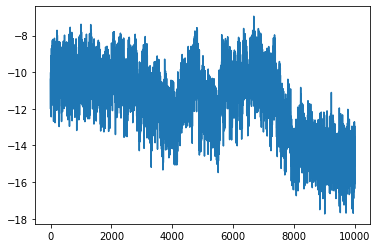

In [3]:
plt.plot(reward_records)

In [4]:
import misc

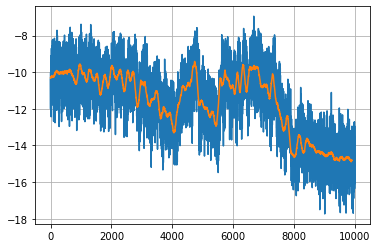

In [5]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


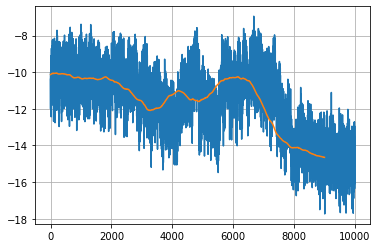

In [6]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,1000))
plt.grid()

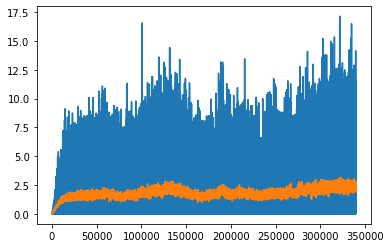

In [7]:
plt.plot(buffer.critic_loss_buffer[100:])
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))

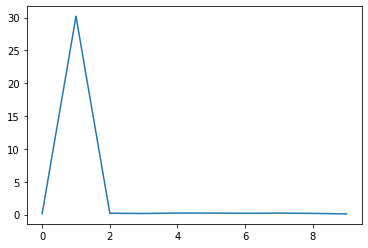

In [8]:
plt.plot(buffer.critic_loss_buffer[:10])


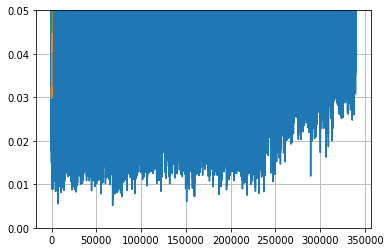

In [9]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1000))
plt.ylim([0,0.05])
plt.grid()

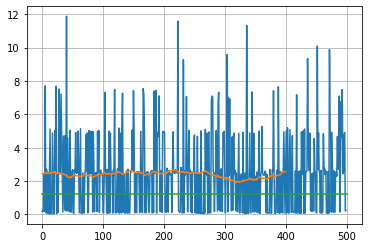

In [10]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1000))
plt.grid()

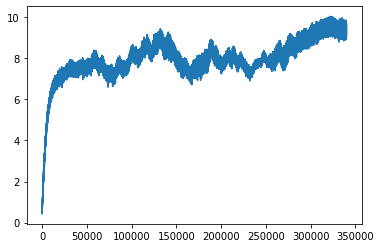

In [11]:
plt.plot(buffer.actor_loss_buffer[100:])


In [12]:
deterministic_action.numpy()

array([[-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.]], dtype=float32)

In [13]:
deterministic_action.numpy().var(axis=0)

array([0., 0.], dtype=float32)

In [14]:
env.timestep

50

In [15]:
state, reward, done, info = env.step(action)


In [16]:
deterministic_action2 = policy(env.unflatten_observation(prev_state), actor_model, lower_bound, upper_bound)


In [17]:
deterministic_action2.numpy()

array([[-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.]], dtype=float32)

In [18]:
policy(env.unflatten_observation(0.0*prev_state), actor_model, lower_bound, upper_bound)

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.]], dtype=float32)>

In [19]:
for k_state in range(-3,4):
    for k_act in range(-3,4):
        print(k_state,k_act,critic_model([env.unflatten_observation(k_state*prev_state),
                      k_act*deterministic_action]).numpy()[:5].T)

-3 -3 [[-31.999655 -32.745235 -31.38836  -32.98084  -33.69714 ]]
-3 -2 [[-31.972797 -32.718376 -31.361502 -32.95398  -33.67028 ]]
-3 -1 [[-31.94578  -32.69136  -31.334484 -32.926964 -33.643265]]
-3 0 [[-31.917875 -32.663456 -31.30658  -32.89906  -33.61536 ]]
-3 1 [[-31.889969 -32.635548 -31.278673 -32.87115  -33.587452]]
-3 2 [[-31.869116 -32.614697 -31.25782  -32.8503   -33.5666  ]]
-3 3 [[-31.855623 -32.601204 -31.24433  -32.836807 -33.55311 ]]
-2 -3 [[-23.30476  -23.803213 -22.895311 -23.959759 -24.438343]]
-2 -2 [[-23.277903 -23.776356 -22.868452 -23.932901 -24.411486]]
-2 -1 [[-23.250883 -23.749336 -22.841434 -23.905884 -24.384466]]
-2 0 [[-23.22298  -23.721434 -22.81353  -23.87798  -24.356564]]
-2 1 [[-23.195074 -23.693527 -22.785624 -23.850073 -24.328657]]
-2 2 [[-23.174221 -23.672674 -22.76477  -23.82922  -24.307804]]
-2 3 [[-23.160728 -23.659182 -22.75128  -23.815727 -24.294312]]
-1 -3 [[-14.99139  -15.090087 -14.835023 -15.203435 -15.600301]]
-1 -2 [[-14.964533  -15.06323   -

In [20]:
for k_state in range(-3,4):
    for k_act in range(-3,4):
        print(k_state,k_act,critic_model([env.unflatten_observation(k_state*state),
                      k_act*deterministic_action]).numpy()[:5].T)

-3 -3 [[-33.045086 -33.697163 -32.380344 -34.029354 -34.713146]]
-3 -2 [[-33.018227 -33.670303 -32.353485 -34.002495 -34.68629 ]]
-3 -1 [[-32.99121  -33.643284 -32.32647  -33.97548  -34.65927 ]]
-3 0 [[-32.963306 -33.61538  -32.298565 -33.947575 -34.631367]]
-3 1 [[-32.9354   -33.587475 -32.270657 -33.919666 -34.603462]]
-3 2 [[-32.914547 -33.56662  -32.249805 -33.898815 -34.582607]]
-3 3 [[-32.901054 -33.55313  -32.236313 -33.885323 -34.56912 ]]
-2 -3 [[-24.002375 -24.44043  -23.556599 -24.659845 -25.117657]]
-2 -2 [[-23.975517 -24.41357  -23.529741 -24.632988 -25.0908  ]]
-2 -1 [[-23.9485   -24.386553 -23.502724 -24.60597  -25.06378 ]]
-2 0 [[-23.920595 -24.358648 -23.47482  -24.578066 -25.035877]]
-2 1 [[-23.892689 -24.330742 -23.446913 -24.55016  -25.00797 ]]
-2 2 [[-23.871836 -24.30989  -23.42606  -24.529306 -24.987118]]
-2 3 [[-23.858343 -24.296398 -23.412567 -24.515814 -24.973625]]
-1 -3 [[-15.322474  -15.4010725 -15.151568  -15.543184  -15.931042 ]]
-1 -2 [[-15.295616 -15.37421

In [21]:
print('----------')
print(critic_model([env.unflatten_observation(state),
                      deterministic_action]).numpy()[:5].T)
print(critic_model([env.unflatten_observation(state),
                      -deterministic_action]).numpy()[:5].T)

----------
[[-7.5920877 -8.0003805 -7.669148  -7.684106  -7.439981 ]]
[[-7.6478987 -8.056191  -7.7249584 -7.7399163 -7.4957914]]


In [22]:
for ii in range(15):
    state, reward, done, info = env.step(action)
    print('----------')
    print(reward.numpy()[:5])
    print(critic_model([env.unflatten_observation(state),
                          deterministic_action]).numpy()[:5].T)
    print(critic_model([env.unflatten_observation(state),
                          -deterministic_action]).numpy()[:5].T)

----------
[-0.4690984  -0.86481    -0.36862335 -0.71989655 -0.34282508]
[[-7.512652 -7.91831  -7.589752 -7.602233 -7.3523  ]]
[[-7.5684624 -7.9741206 -7.645563  -7.6580434 -7.408111 ]]
----------
[-0.48625454 -0.8841365  -0.38143167 -0.7382316  -0.34943792]
[[-7.4329724 -7.8368263 -7.508406  -7.5205736 -7.266257 ]]
[[-7.488783  -7.8926373 -7.5642166 -7.5763845 -7.3220673]]
----------
[-0.5026732  -0.9026159  -0.39360017 -0.7557443  -0.3557569 ]
[[-7.3520913 -7.753407  -7.427292  -7.4367523 -7.181342 ]]
[[-7.407902  -7.8092175 -7.483103  -7.492563  -7.237153 ]]
----------
[-0.51838446 -0.9202914  -0.4051727  -0.77247846 -0.36179802]
[[-7.2679353 -7.6700296 -7.346633  -7.3524427 -7.0926695]]
[[-7.323746  -7.72584   -7.4024434 -7.4082537 -7.14848  ]]
----------
[-0.53342086 -0.9372055  -0.41618982 -0.78847694 -0.3675767 ]
[[-7.1857095 -7.5856347 -7.2644434 -7.2663517 -7.0032535]]
[[-7.2415204 -7.641445  -7.320254  -7.322162  -7.059064 ]]
----------
[-0.54781556 -0.9533992  -0.42668888 -0

In [23]:
reward.numpy()[:5]

array([-0.65355694, -1.0725824 , -0.5027311 , -0.9160549 , -0.41379008],
      dtype=float32)

In [24]:
state[-1]

<tf.Tensor: shape=(50221,), dtype=float32, numpy=
array([ 2.7049512e-02,  2.6976243e-02,  2.7226254e-02, ...,
       -8.8822556e+01, -9.0778679e+01,  6.6000000e+01], dtype=float32)>

In [26]:
env.reset()
for ii in range(55):
    random_action = -2+4*np.random.uniform(size=(config.batch_size,2))
    state, reward, done, info = env.step(random_action)
    print('----------')
    print(reward.numpy()[:5])
    print(critic_model([env.unflatten_observation(state),
                          deterministic_action]).numpy()[:5].T)

----------
[0. 0. 0. 0. 0.]
[[-9.9548855 -9.960775  -9.9548855 -9.955719  -9.966805 ]]
----------
[0. 0. 0. 0. 0.]
[[-9.9548855 -9.96131   -9.957983  -9.964522  -9.979976 ]]
----------
[0. 0. 0. 0. 0.]
[[-9.957684  -9.969769  -9.9683275 -9.961093  -9.988089 ]]
----------
[0. 0. 0. 0. 0.]
[[ -9.962639  -9.961404  -9.979847  -9.960422 -10.012974]]
----------
[0. 0. 0. 0. 0.]
[[ -9.958734   -9.9679575  -9.970473   -9.9548855 -10.010669 ]]
----------
[0. 0. 0. 0. 0.]
[[ -9.958043   -9.964634   -9.9548855  -9.958345  -10.008724 ]]
----------
[0. 0. 0. 0. 0.]
[[-9.956071  -9.978656  -9.947791  -9.9548855 -9.991079 ]]
----------
[0. 0. 0. 0. 0.]
[[-9.956937  -9.978774  -9.931317  -9.9548855 -9.995816 ]]
----------
[0. 0. 0. 0. 0.]
[[ -9.966716   -9.992234   -9.912241   -9.9548855 -10.017627 ]]
----------
[0. 0. 0. 0. 0.]
[[ -9.976174  -9.978816  -9.904631  -9.960357 -10.034157]]
----------
[0. 0. 0. 0. 0.]
[[ -9.995486  -9.988742  -9.87921   -9.941908 -10.071539]]
----------
[0. 0. 0. 0. 0.]
